# Importation des librairies

In [82]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import os.path

from sklearn.tree import plot_tree
from sklearn.model_selection import train_test_split
from sksurv.ensemble import RandomSurvivalForest
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.metrics import concordance_index_censored , concordance_index_ipcw
from sklearn.impute import SimpleImputer
from sksurv.util import Surv
from lifelines.utils import concordance_index



# Preprocessing

In [116]:
clinical_test=pd.read_csv('data/clinical_test.csv')
clinical_train=pd.read_csv('data/clinical_train.csv')

molecular_test=pd.read_csv('data/molecular_test.csv')
molecular_train=pd.read_csv('data/molecular_train.csv')


In [117]:
target_df=pd.read_csv('data/target_train.csv')

# Drop rows where 'OS_YEARS' is NaN if conversion caused any issues
target_df.dropna(subset=['OS_YEARS', 'OS_STATUS'], inplace=True)


# Contarget_dfvert 'OS_YEARS' to numeric if it isn’t already
target_df['OS_YEARS'] = pd.to_numeric(target_df['OS_YEARS'], errors='coerce')

# Ensure 'OS_STATUS' is boolean
target_df['OS_STATUS'] = target_df['OS_STATUS'].astype(bool)

In [118]:
def handle_missing_values(df):
    for col in df.columns:
        if df[col].isnull().any():
            if df[col].dtype in [np.int64, np.float64]:
                # Numérique : remplacer par la médiane
                median_val = df[col].median()
                df[col] = df[col].fillna(median_val)
            else:
                # Catégoriel : remplacer par 'Missing'
                df[col] = df[col].fillna('Missing')
    return df

In [119]:
import pandas as pd
import numpy as np

def aggregate_leukemia_data(df):
    """
    Agrégation des données de mutations par patient et calcul
    du risk_score_raw et risk_score_prob, version optimisée.
    """
    # Liste complète des gènes
    all_genes = [
        'GNB1', 'CSF3R', 'MPL', 'NRAS', 'HAX1', 'RIT1', 'SMC3', 'WT1', 'ATM', 'CBL',
        'ETV6', 'ETNK1', 'KRAS', 'ARID2', 'NFE2', 'SH2B3', 'PTPN11', 'FLT3', 'BRCA2',
        'PDS5B', 'IDH2', 'BLM', 'CREBBP', 'CTCF', 'PRPF8', 'TP53', 'NF1', 'SUZ12',
        'STAT5B', 'STAT3', 'PPM1D', 'SRSF2', 'SETBP1', 'BCL2', 'EPOR', 'CALR', 'CEBPA',
        'U2AF2', 'DNMT3A', 'ASXL2', 'SF3B1', 'IDH1', 'ASXL1', 'GNAS', 'RUNX1', 'U2AF1',
        'CHEK2', 'MYD88', 'GATA2', 'KIT', 'TET2', 'TERT', 'IRF1', 'CSNK1A1', 'NPM1',
        'NSD1', 'DDX41', 'JARID2', 'CCND3', 'VEGFA', 'IKZF1', 'EGFR', 'SBDS', 'CUX1',
        'BRAF', 'EZH2', 'RAD21', 'JAK2', 'CDKN2A', 'FANCG', 'NOTCH1', 'PIGA', 'ZRSR2',
        'BCOR', 'USP9X', 'KDM6A', 'SMC1A', 'MED12', 'STAG2', 'BCORL1', 'PHF6', 'BRCC3',
        'MLL'
    ]

    # Dictionnaire de poids (à ajuster selon la clinique)
    gene_weights = {
        'TP53': 5.0,
        'FLT3': 2.0,
        'ASXL1': 1.5, 'RUNX1': 1.5, 'EZH2': 1.5,
        'DNMT3A': 1.5, 'TET2': 1.5, 'IDH1': 1.5, 'IDH2': 1.5,
        'NPM1': -2.0, 'CEBPA': -2.0,
        # compléter si besoin
    }
    bad_effects = ['nonsense', 'frameshift', 'splice_site', 'stop_gained']

    # Agrégation sommaire
    result = df.groupby('ID').agg({
        'GENE': ['count', 'nunique'],
        'CHR': 'nunique',
        'VAF': ['mean', 'max', 'median', 'min', 'var'],
        'DEPTH': ['mean', 'median', 'min', 'max', 'var']
    }).reset_index()
    result.columns = [
        'ID', 'nb_mutations', 'nb_genes', 'nb_chromosomes',
        'vaf_mean', 'vaf_max', 'vaf_median', 'vaf_min', 'vaf_var',
        'depth_mean', 'depth_median', 'depth_min', 'depth_max', 'depth_var'
    ]

    # Crée la matrice binaire patient x gène (has_<GENE>)
    has_gene = (
        df.pivot_table(index='ID', columns='GENE', values='CHR', aggfunc='size', fill_value=0)
        .reindex(columns=all_genes, fill_value=0)
        .astype(int)
    )
    has_gene.columns = [f'has_{g}' for g in has_gene.columns]
    has_gene.reset_index(inplace=True)

    # Merge d'un coup
    result = result.merge(has_gene, on='ID', how='left')

    # Variables globales vectorisées
    result['nb_bad_effects'] = df.groupby('ID')['EFFECT'].apply(lambda x: x.isin(bad_effects).sum()).values
    result['nb_high_vaf'] = df.groupby('ID')['VAF'].apply(lambda x: (x > 0.4).sum()).values

    # Score brut vectorisé
    weights_series = pd.Series(gene_weights)
    has_cols = [f'has_{g}' for g in gene_weights]
    weights_series = pd.Series([gene_weights[g] for g in gene_weights], index=has_cols)
    gene_score = result[has_cols].dot(weights_series)
    result['risk_score_raw'] = (
    gene_score
    + 0.5 * result['nb_high_vaf']
    + 0.2 * result['nb_mutations']
)

    # Sigmoïde pour probabilité
    def logistic(p, intercept=5.0, scale=2.0):
        z = (p - intercept) / scale
        return 1.0 / (1.0 + np.exp(-z))

    result['risk_score_prob'] = result['risk_score_raw'].apply(logistic)

    return result


molecular_train = aggregate_leukemia_data(molecular_train)
molecular_test = aggregate_leukemia_data(molecular_test)

In [120]:
def add_cytogenetic_features(data):
    # Indicateur si le caryotype est "Normal"
    data["is_normal"] = data["CYTOGENETICS"].str.contains("Normal", case=False, na=False).astype(int)

    # Extraction du nombre total de chromosomes
    data["total_chromosomes"] = data["CYTOGENETICS"].str.extract(r"^(\d+)", expand=False).astype(float)
    data.loc[data["is_normal"] == 1, "total_chromosomes"] = 46  # Valeur par défaut pour caryotype normal

    # Normalisation de la casse des chromosomes (tout en majuscule)
    data["CYTOGENETICS"] = data["CYTOGENETICS"].str.upper()

    # Extraction du sexe brut (ex: XY, XX)
    data["sex_raw"] = data["CYTOGENETICS"].str.extract(r"\b(XX|XY|XYY|XXY|XXX|YY)\b", expand=False)

    # Normalisation du sexe : catégorisation des cas atypiques
    def normalize_sex(s):
        if s in ["XX", "XY"]:
            return s
        else:
            return "Other"


    data["sex"] = data["sex_raw"].apply(normalize_sex)

    # Nettoyage des colonnes intermédiaires
    data.drop(columns=["sex_raw"], inplace=True)

    return data

# Appliquer la fonction aux datasets
clinical_test = add_cytogenetic_features(clinical_test)
clinical_train = add_cytogenetic_features(clinical_train)


In [121]:
clinical_test = clinical_test.drop('CYTOGENETICS', axis=1)
clinical_train = clinical_train.drop('CYTOGENETICS', axis=1)

In [122]:
df_train = clinical_train.merge(molecular_train, on='ID', how='left').fillna(0)
df_test = clinical_test.merge(molecular_test, on='ID', how='left').fillna(0)

In [123]:
df_train['mutation_burden'] = df_train['nb_mutations'] * df_train['vaf_mean']
df_test['mutation_burden'] = df_test['nb_mutations'] * df_test['vaf_mean']


for col in ['HB', 'PLT', 'BM_BLAST']:
    lower = df_train[col].quantile(0.01)
    upper = df_train[col].quantile(0.99)
    df_train[col] = df_train[col].clip(lower, upper)
    df_test[col] = df_test[col].clip(lower, upper)


In [124]:
from sklearn.preprocessing import StandardScaler

# Select numerical columns excluding 'OS_YEARS' and ID (which is an identifier)
numerical_cols_train = df_train.select_dtypes(include=np.number).columns.tolist()
numerical_cols_test = df_test.select_dtypes(include=np.number).columns.tolist()


if 'OS_YEARS' in numerical_cols_train:
    numerical_cols_train.remove('OS_YEARS') # Exclude the target variable
if 'OS_STATUS' in numerical_cols_train:
    numerical_cols_train.remove('OS_STATUS') # Exclude the target variable

# Initialize StandardScaler
scaler = StandardScaler()

# Fit and transform on the training data using the filtered numerical columns
df_train[numerical_cols_train] = scaler.fit_transform(df_train[numerical_cols_train])

# Transform on the test data using the filtered numerical columns (and scaler fitted on training data)
# Need to ensure the columns in df_test match the columns used for fitting the scaler on df_train
numerical_cols_test_filtered = [col for col in numerical_cols_train if col in numerical_cols_test]
df_test[numerical_cols_test_filtered] = scaler.transform(df_test[numerical_cols_test_filtered])

In [125]:
df_train = df_train.merge(target_df, on='ID', how='inner')

In [126]:
# prompt: supprime les variables ID et CENTER de df_train et de df_test
ID_test = df_test['ID']

df_train = df_train.drop(['ID', 'CENTER'], axis=1)
df_test = df_test.drop(['ID', 'CENTER'], axis=1)

# Modèle MTLR

In [127]:
import torch
import torch.nn as nn
from torchmtlr import (MTLR, mtlr_neg_log_likelihood, mtlr_survival, mtlr_survival_at_times)
from torchmtlr.utils import encode_survival, make_time_bins
import numpy as np
import pandas as pd

X_features = df_train.drop(columns=['OS_YEARS', 'OS_STATUS'])
X_features = pd.get_dummies(X_features, drop_first=True)
X_features = X_features.astype(float)

X_features_test = pd.get_dummies(df_test, drop_first=True)
X_features_test = X_features_test.reindex(columns=X_features.columns, fill_value=0)
X_features_test = X_features_test.astype(float)

X_train = torch.tensor(X_features.values, dtype=torch.float32)
X_test = torch.tensor(X_features_test.values, dtype=torch.float32)
y_time = torch.tensor(df_train['OS_YEARS'].values, dtype=torch.float32)
y_event = torch.tensor(df_train['OS_STATUS'].values, dtype=torch.float32)

# Création des time bins
time_bins = make_time_bins(y_time, event=y_event)
target = encode_survival(y_time, y_event, time_bins)

## Hyperparameter tuning

In [ ]:
import optuna
from sklearn.model_selection import StratifiedKFold
import torch
import torch.nn as nn
import numpy as np
from sksurv.metrics import concordance_index_ipcw
from sksurv.util import Surv

def to_numpy(x):
    if isinstance(x, torch.Tensor):
        return x.detach().cpu().numpy()
    return np.asarray(x)

def objective(trial):
    n_hidden1 = trial.suggest_int('n_hidden1', 32, 256)
    n_hidden2 = trial.suggest_int('n_hidden2', 16, 128)
    dropout1 = trial.suggest_float('dropout1', 0.1, 0.5)
    dropout2 = trial.suggest_float('dropout2', 0.1, 0.5)
    lr = trial.suggest_float('lr', 1e-4, 1e-2, log=True)
    n_epochs = trial.suggest_int('n_epochs', 100, 900)
    activation = trial.suggest_categorical('activation', ['relu', 'leakyrelu', 'elu', 'selu'])
    if trial.suggest_categorical('use_weight_decay', [True, False]):
        weight_decay = trial.suggest_float('weight_decay', 1e-6, 1e-3, log=True)
    else:
        weight_decay = 0.0

    torch.manual_seed(42)
    np.random.seed(42)

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = []
    for fold, (train_idx, val_idx) in enumerate(skf.split(X_features, df_train['OS_STATUS'])):
        X_tr, X_val = X_features.iloc[train_idx], X_features.iloc[val_idx]
        y_time_tr, y_time_val = y_time[train_idx], y_time[val_idx]
        y_event_tr, y_event_val = y_event[train_idx], y_event[val_idx]

        events = (y_event_val == 1).sum().item() if isinstance(y_event_val, torch.Tensor) else np.sum(y_event_val == 1)
        censored = (y_event_val == 0).sum().item() if isinstance(y_event_val, torch.Tensor) else np.sum(y_event_val == 0)
        total = len(y_event_val)

        # Re-encode time bins pour chaque fold
        time_bins = make_time_bins(y_time_tr, event=y_event_tr)
        target_tr = encode_survival(y_time_tr, y_event_tr, time_bins)

        X_tr_torch = torch.tensor(X_tr.values, dtype=torch.float32)
        X_val_torch = torch.tensor(X_val.values, dtype=torch.float32)

        # Modèle dynamique
        layers = [
            nn.Linear(X_tr_torch.shape[1], n_hidden1),
            nn.BatchNorm1d(n_hidden1),
        ]
        if activation == 'relu':
            layers.append(nn.ReLU())
        elif activation == 'leakyrelu':
            layers.append(nn.LeakyReLU())
        elif activation == 'elu':
            layers.append(nn.ELU())
        elif activation == 'selu':
            layers.append(nn.SELU())
        layers.append(nn.Dropout(dropout1))
        layers.append(nn.Linear(n_hidden1, n_hidden2))
        layers.append(nn.BatchNorm1d(n_hidden2))
        if activation == 'relu':
            layers.append(nn.ReLU())
        elif activation == 'leakyrelu':
            layers.append(nn.LeakyReLU())
        elif activation == 'elu':
            layers.append(nn.ELU())
        elif activation == 'selu':
            layers.append(nn.SELU())
        layers.append(nn.Dropout(dropout2))
        layers.append(MTLR(n_hidden2, len(time_bins)))
        model = nn.Sequential(*layers)

        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

        for epoch in range(n_epochs):
            model.train()
            optimizer.zero_grad()
            logits = model(X_tr_torch)
            loss = mtlr_neg_log_likelihood(logits, target_tr, model[-1], C1=1., average=True)
            loss.backward()
            optimizer.step()

        model.eval()
        with torch.no_grad():
            logits_val = model(X_val_torch)
            surv_val = mtlr_survival(logits_val)
        median_pred = []
        for surv in surv_val:
            below_half = np.where(surv.numpy() <= 0.5)[0]
            if below_half.size > 0 and below_half[0] < len(time_bins):
                median_pred.append(time_bins[below_half[0]].item())
            else:
                median_pred.append(time_bins[-1].item())

        if (y_event_val == 1).sum() == 0 or (y_event_val == 0).sum() == 0:
            print(f"Fold {fold}: Skip fold (all events or all censored)")
            continue

        y_train_struct = Surv.from_arrays(event=to_numpy(y_event_tr).astype(bool), time=to_numpy(y_time_tr))
        y_val_struct = Surv.from_arrays(event=to_numpy(y_event_val).astype(bool), time=to_numpy(y_time_val))
        try:
            result = concordance_index_ipcw(
                y_train_struct,
                y_val_struct,
                -np.array(median_pred)
            )
            # Compatible avec toutes les versions de scikit-survival
            if isinstance(result, (tuple, list, np.ndarray)):
                cindex_ipcw = result[0]
            else:
                cindex_ipcw = result.cindex
            scores.append(cindex_ipcw)
        except Exception as e:
            print(f"Fold {fold}: Exception in concordance_index_ipcw: {e}")
            continue

    if len(scores) == 0:
        print("Aucun score valide, return 0.5")
        return 0.5
    print(f"Scores valides pour ce trial: {scores}")
    return np.mean(scores)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=1000)

print("Best trial:")
print(study.best_trial)
print("Best params:", study.best_params)

[I 2025-07-20 00:38:53,621] A new study created in memory with name: no-name-1f1a3cfc-bdf2-4900-ae0c-d96b45e6c414
[I 2025-07-20 00:39:28,762] Trial 0 finished with value: 0.6807808881836026 and parameters: {'n_hidden1': 208, 'n_hidden2': 97, 'dropout1': 0.4603824101023839, 'dropout2': 0.21555874080086324, 'lr': 0.00033024356502876773, 'n_epochs': 267, 'activation': 'elu', 'use_weight_decay': True, 'weight_decay': 7.706923933117599e-06}. Best is trial 0 with value: 0.6807808881836026.


Scores valides pour ce trial: [np.float64(0.6923564597944214), np.float64(0.6532173109152081), np.float64(0.6706508423116058), np.float64(0.7071844782290653), np.float64(0.6804953496677131)]


[I 2025-07-20 00:40:46,748] Trial 1 finished with value: 0.681837391107468 and parameters: {'n_hidden1': 239, 'n_hidden2': 61, 'dropout1': 0.2657355667007639, 'dropout2': 0.38381686039515217, 'lr': 0.00010154583475247735, 'n_epochs': 591, 'activation': 'leakyrelu', 'use_weight_decay': True, 'weight_decay': 3.6894019954704795e-05}. Best is trial 1 with value: 0.681837391107468.


Scores valides pour ce trial: [np.float64(0.68569176681379), np.float64(0.6622926118872718), np.float64(0.6773633357580703), np.float64(0.7012793782758016), np.float64(0.6825598628024061)]


[I 2025-07-20 00:41:58,795] Trial 2 finished with value: 0.679835174581783 and parameters: {'n_hidden1': 254, 'n_hidden2': 92, 'dropout1': 0.4499954315719159, 'dropout2': 0.4026420818786455, 'lr': 0.000357233727025794, 'n_epochs': 480, 'activation': 'elu', 'use_weight_decay': False}. Best is trial 1 with value: 0.681837391107468.


Scores valides pour ce trial: [np.float64(0.6941667666630712), np.float64(0.6544010138251719), np.float64(0.666634680128144), np.float64(0.7061698280760866), np.float64(0.6778035842164409)]


[I 2025-07-20 00:43:03,771] Trial 3 finished with value: 0.6880030814634716 and parameters: {'n_hidden1': 228, 'n_hidden2': 21, 'dropout1': 0.47863473518997934, 'dropout2': 0.15653855550410958, 'lr': 0.00023234982496248897, 'n_epochs': 577, 'activation': 'leakyrelu', 'use_weight_decay': True, 'weight_decay': 6.590269160908986e-05}. Best is trial 3 with value: 0.6880030814634716.


Scores valides pour ce trial: [np.float64(0.6979014198005458), np.float64(0.6513934424904436), np.float64(0.6888360893706742), np.float64(0.7112497001443441), np.float64(0.6906347555113501)]


[I 2025-07-20 00:43:54,165] Trial 4 finished with value: 0.6803369026244029 and parameters: {'n_hidden1': 231, 'n_hidden2': 125, 'dropout1': 0.23801422489885435, 'dropout2': 0.4798144246519561, 'lr': 0.003081754193783307, 'n_epochs': 322, 'activation': 'selu', 'use_weight_decay': False}. Best is trial 3 with value: 0.6880030814634716.


Scores valides pour ce trial: [np.float64(0.6987426045525841), np.float64(0.6613204885119409), np.float64(0.6679084596100108), np.float64(0.7031530168853478), np.float64(0.6705599435621311)]


[I 2025-07-20 00:44:13,549] Trial 5 finished with value: 0.675865122555676 and parameters: {'n_hidden1': 91, 'n_hidden2': 64, 'dropout1': 0.20273295643425338, 'dropout2': 0.16782404993870462, 'lr': 0.00018293722892639725, 'n_epochs': 234, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 3 with value: 0.6880030814634716.


Scores valides pour ce trial: [np.float64(0.671346653380376), np.float64(0.6700075456235556), np.float64(0.6702576400981307), np.float64(0.6911888099821083), np.float64(0.6765249636942091)]


[I 2025-07-20 00:44:37,887] Trial 6 finished with value: 0.6791804122561673 and parameters: {'n_hidden1': 221, 'n_hidden2': 120, 'dropout1': 0.10595261619847003, 'dropout2': 0.13282358773870395, 'lr': 0.0008837867467714145, 'n_epochs': 165, 'activation': 'selu', 'use_weight_decay': False}. Best is trial 3 with value: 0.6880030814634716.


Scores valides pour ce trial: [np.float64(0.6887945653267089), np.float64(0.6568390382843432), np.float64(0.666670810446571), np.float64(0.7062512455350274), np.float64(0.677346401688186)]


[I 2025-07-20 00:45:13,955] Trial 7 finished with value: 0.6753330198636076 and parameters: {'n_hidden1': 111, 'n_hidden2': 51, 'dropout1': 0.16042001096244005, 'dropout2': 0.16538187289089967, 'lr': 0.00016695312675941046, 'n_epochs': 417, 'activation': 'elu', 'use_weight_decay': True, 'weight_decay': 7.168413982955492e-05}. Best is trial 3 with value: 0.6880030814634716.


Scores valides pour ce trial: [np.float64(0.6807324887633175), np.float64(0.6428437769292795), np.float64(0.6735351461335501), np.float64(0.7012836761448208), np.float64(0.67827001134707)]


[I 2025-07-20 00:46:05,606] Trial 8 finished with value: 0.6728069566263969 and parameters: {'n_hidden1': 106, 'n_hidden2': 60, 'dropout1': 0.2383619534556367, 'dropout2': 0.29186830743495706, 'lr': 0.004001018309622097, 'n_epochs': 595, 'activation': 'selu', 'use_weight_decay': False}. Best is trial 3 with value: 0.6880030814634716.


Scores valides pour ce trial: [np.float64(0.6881349078647573), np.float64(0.6610919397218539), np.float64(0.656275963332902), np.float64(0.6870889094982081), np.float64(0.6714430627142632)]


[I 2025-07-20 00:46:15,875] Trial 9 finished with value: 0.6824324990067785 and parameters: {'n_hidden1': 115, 'n_hidden2': 49, 'dropout1': 0.28394253759583077, 'dropout2': 0.49957133272026943, 'lr': 0.0058000781101858545, 'n_epochs': 131, 'activation': 'selu', 'use_weight_decay': True, 'weight_decay': 3.1370474951622695e-05}. Best is trial 3 with value: 0.6880030814634716.


Scores valides pour ce trial: [np.float64(0.6977585817338603), np.float64(0.6444621215262831), np.float64(0.6798155596157881), np.float64(0.7088634823340019), np.float64(0.6812627498239585)]


[I 2025-07-20 00:46:57,129] Trial 10 finished with value: 0.6667860100385634 and parameters: {'n_hidden1': 47, 'n_hidden2': 17, 'dropout1': 0.37255480272339675, 'dropout2': 0.25178970199493145, 'lr': 0.001126700525640123, 'n_epochs': 890, 'activation': 'relu', 'use_weight_decay': True, 'weight_decay': 0.0007280798422206616}. Best is trial 3 with value: 0.6880030814634716.


Scores valides pour ce trial: [np.float64(0.6746165819321508), np.float64(0.6269712092248514), np.float64(0.6690283758534011), np.float64(0.6891706381055989), np.float64(0.6741432450768149)]


[I 2025-07-20 00:47:57,220] Trial 11 finished with value: 0.6414109819210511 and parameters: {'n_hidden1': 169, 'n_hidden2': 25, 'dropout1': 0.33225586455057027, 'dropout2': 0.36355996295873094, 'lr': 0.007555520466009403, 'n_epochs': 736, 'activation': 'leakyrelu', 'use_weight_decay': True, 'weight_decay': 0.00011189205936990868}. Best is trial 3 with value: 0.6880030814634716.


Scores valides pour ce trial: [np.float64(0.6238223941283685), np.float64(0.6338299416218228), np.float64(0.6475940576600763), np.float64(0.6539823148675968), np.float64(0.6478262013273912)]


[I 2025-07-20 00:48:07,090] Trial 12 finished with value: 0.6786279447469207 and parameters: {'n_hidden1': 168, 'n_hidden2': 32, 'dropout1': 0.36717980533816097, 'dropout2': 0.4450607872755397, 'lr': 0.0009102573966765917, 'n_epochs': 119, 'activation': 'relu', 'use_weight_decay': True, 'weight_decay': 3.6549822774951773e-06}. Best is trial 3 with value: 0.6880030814634716.


Scores valides pour ce trial: [np.float64(0.6966543910809002), np.float64(0.6337235054193775), np.float64(0.6826189270661581), np.float64(0.7020805842830424), np.float64(0.6780623158851254)]


[I 2025-07-20 00:49:03,859] Trial 13 finished with value: 0.6662314148285639 and parameters: {'n_hidden1': 143, 'n_hidden2': 39, 'dropout1': 0.4043993443645372, 'dropout2': 0.10259549287631911, 'lr': 0.009413035056642842, 'n_epochs': 721, 'activation': 'selu', 'use_weight_decay': True, 'weight_decay': 1.6562852685728e-05}. Best is trial 3 with value: 0.6880030814634716.


Scores valides pour ce trial: [np.float64(0.6747016635823126), np.float64(0.6412417460294315), np.float64(0.6495942659144653), np.float64(0.6874856260003992), np.float64(0.6781337726162107)]


[I 2025-07-20 00:49:24,821] Trial 14 finished with value: 0.6737529853570321 and parameters: {'n_hidden1': 60, 'n_hidden2': 42, 'dropout1': 0.30540482037728317, 'dropout2': 0.31985993886155806, 'lr': 0.0025249607865558982, 'n_epochs': 366, 'activation': 'leakyrelu', 'use_weight_decay': True, 'weight_decay': 1.0352727720667066e-06}. Best is trial 3 with value: 0.6880030814634716.


Scores valides pour ce trial: [np.float64(0.6839292709956439), np.float64(0.645542597155384), np.float64(0.6762368659966639), np.float64(0.6945550101387868), np.float64(0.6685011824986821)]


[I 2025-07-20 00:50:10,822] Trial 15 finished with value: 0.6857519842108667 and parameters: {'n_hidden1': 187, 'n_hidden2': 17, 'dropout1': 0.4946129545738741, 'dropout2': 0.2288540320958865, 'lr': 0.001803984237705833, 'n_epochs': 579, 'activation': 'selu', 'use_weight_decay': True, 'weight_decay': 0.0002594476192699771}. Best is trial 3 with value: 0.6880030814634716.


Scores valides pour ce trial: [np.float64(0.7025244352355877), np.float64(0.6556950911697286), np.float64(0.6815865603635572), np.float64(0.704285819064494), np.float64(0.6846680152209663)]


[I 2025-07-20 00:51:04,043] Trial 16 finished with value: 0.665085889826807 and parameters: {'n_hidden1': 191, 'n_hidden2': 20, 'dropout1': 0.4850266882872399, 'dropout2': 0.21198230602829082, 'lr': 0.0014138869812605024, 'n_epochs': 607, 'activation': 'leakyrelu', 'use_weight_decay': True, 'weight_decay': 0.00035520704514040564}. Best is trial 3 with value: 0.6880030814634716.


Scores valides pour ce trial: [np.float64(0.6797149616223441), np.float64(0.6315882890676077), np.float64(0.6675551562439614), np.float64(0.6768103834189633), np.float64(0.6697606587811585)]


[I 2025-07-20 00:52:07,345] Trial 17 finished with value: 0.6836189840740652 and parameters: {'n_hidden1': 196, 'n_hidden2': 33, 'dropout1': 0.41750312496543923, 'dropout2': 0.24783669822880944, 'lr': 0.0004464622592636821, 'n_epochs': 719, 'activation': 'relu', 'use_weight_decay': True, 'weight_decay': 0.00019748847176264236}. Best is trial 3 with value: 0.6880030814634716.


Scores valides pour ce trial: [np.float64(0.6929592143071915), np.float64(0.6583957339611739), np.float64(0.6858922046618731), np.float64(0.700980964472704), np.float64(0.6798668029673833)]


[I 2025-07-20 00:52:54,330] Trial 18 finished with value: 0.6836719975423641 and parameters: {'n_hidden1': 169, 'n_hidden2': 81, 'dropout1': 0.4942758747306177, 'dropout2': 0.1869484649007197, 'lr': 0.0020492091221622154, 'n_epochs': 503, 'activation': 'selu', 'use_weight_decay': True, 'weight_decay': 0.0009679834937597562}. Best is trial 3 with value: 0.6880030814634716.


Scores valides pour ce trial: [np.float64(0.7004579808158653), np.float64(0.6566154427927826), np.float64(0.6739774731010937), np.float64(0.7075553757159232), np.float64(0.6797537152861557)]


[I 2025-07-20 00:53:55,883] Trial 19 finished with value: 0.6748125663259857 and parameters: {'n_hidden1': 186, 'n_hidden2': 17, 'dropout1': 0.4373173005134062, 'dropout2': 0.289143595457683, 'lr': 0.0007269044783088669, 'n_epochs': 790, 'activation': 'leakyrelu', 'use_weight_decay': True, 'weight_decay': 0.0002723163109632596}. Best is trial 3 with value: 0.6880030814634716.


Scores valides pour ce trial: [np.float64(0.6903324848918087), np.float64(0.641299094423973), np.float64(0.6793201094629887), np.float64(0.6976841933328445), np.float64(0.6654269495183136)]


[I 2025-07-20 00:54:34,176] Trial 20 finished with value: 0.682175985341966 and parameters: {'n_hidden1': 141, 'n_hidden2': 30, 'dropout1': 0.40003404489883043, 'dropout2': 0.10235642196026723, 'lr': 0.0005564083609666884, 'n_epochs': 512, 'activation': 'selu', 'use_weight_decay': True, 'weight_decay': 9.324093523923451e-05}. Best is trial 3 with value: 0.6880030814634716.


Scores valides pour ce trial: [np.float64(0.6966219733880313), np.float64(0.6479606388465025), np.float64(0.6709115295829424), np.float64(0.7110563898920007), np.float64(0.6843293950003534)]


[I 2025-07-20 00:55:24,401] Trial 21 finished with value: 0.683712916770887 and parameters: {'n_hidden1': 170, 'n_hidden2': 84, 'dropout1': 0.4939473858700138, 'dropout2': 0.1831749508681771, 'lr': 0.0017818082751325035, 'n_epochs': 515, 'activation': 'selu', 'use_weight_decay': True, 'weight_decay': 0.0009277884628188282}. Best is trial 3 with value: 0.6880030814634716.


Scores valides pour ce trial: [np.float64(0.7029936519946665), np.float64(0.6561478469969982), np.float64(0.6720982427703869), np.float64(0.7059988945084739), np.float64(0.6813259475839095)]


[I 2025-07-20 00:56:32,875] Trial 22 finished with value: 0.6821714013952229 and parameters: {'n_hidden1': 213, 'n_hidden2': 83, 'dropout1': 0.4929904205684927, 'dropout2': 0.14522322981193125, 'lr': 0.0016579163254002846, 'n_epochs': 644, 'activation': 'selu', 'use_weight_decay': True, 'weight_decay': 0.00047290120336847453}. Best is trial 3 with value: 0.6880030814634716.


Scores valides pour ce trial: [np.float64(0.7013856183261812), np.float64(0.6527029422520212), np.float64(0.6711983363114525), np.float64(0.7070314945295043), np.float64(0.6785386155569558)]


[I 2025-07-20 00:57:17,256] Trial 23 finished with value: 0.6834555801274794 and parameters: {'n_hidden1': 161, 'n_hidden2': 103, 'dropout1': 0.46189214941406254, 'dropout2': 0.23234576023834808, 'lr': 0.0014815482981050676, 'n_epochs': 442, 'activation': 'selu', 'use_weight_decay': True, 'weight_decay': 0.0001623371415369582}. Best is trial 3 with value: 0.6880030814634716.


Scores valides pour ce trial: [np.float64(0.6997822998965026), np.float64(0.6540072218343481), np.float64(0.6732166453974969), np.float64(0.7075362770754795), np.float64(0.6827354564335695)]


[I 2025-07-20 00:58:19,962] Trial 24 finished with value: 0.6825139827669949 and parameters: {'n_hidden1': 256, 'n_hidden2': 73, 'dropout1': 0.4988599678792655, 'dropout2': 0.1867989371228128, 'lr': 0.00454494751193153, 'n_epochs': 533, 'activation': 'selu', 'use_weight_decay': True, 'weight_decay': 0.00048299422543982435}. Best is trial 3 with value: 0.6880030814634716.


Scores valides pour ce trial: [np.float64(0.7019371457672441), np.float64(0.6648343500156855), np.float64(0.6737400803649177), np.float64(0.6968447337293094), np.float64(0.6752136039578182)]


[I 2025-07-20 00:59:36,918] Trial 25 finished with value: 0.6833793732339912 and parameters: {'n_hidden1': 201, 'n_hidden2': 110, 'dropout1': 0.43440637187083314, 'dropout2': 0.2743458401857259, 'lr': 0.0002256408803321921, 'n_epochs': 674, 'activation': 'leakyrelu', 'use_weight_decay': True, 'weight_decay': 3.893770308076213e-05}. Best is trial 3 with value: 0.6880030814634716.


Scores valides pour ce trial: [np.float64(0.6902480698982556), np.float64(0.652812587108077), np.float64(0.6810103341639324), np.float64(0.7126960634597245), np.float64(0.6801298115399669)]


[I 2025-07-20 01:00:22,356] Trial 26 finished with value: 0.6521665772344076 and parameters: {'n_hidden1': 131, 'n_hidden2': 74, 'dropout1': 0.3730824713392758, 'dropout2': 0.331703685283078, 'lr': 0.002587054287648494, 'n_epochs': 552, 'activation': 'relu', 'use_weight_decay': False}. Best is trial 3 with value: 0.6880030814634716.


Scores valides pour ce trial: [np.float64(0.6665945868290686), np.float64(0.6289596949780587), np.float64(0.6386509486073826), np.float64(0.6687114461873835), np.float64(0.6579162095701448)]


[I 2025-07-20 01:01:05,413] Trial 27 finished with value: 0.6847665471226619 and parameters: {'n_hidden1': 224, 'n_hidden2': 88, 'dropout1': 0.47117375063630434, 'dropout2': 0.19985324310956912, 'lr': 0.000627034084611342, 'n_epochs': 393, 'activation': 'elu', 'use_weight_decay': True, 'weight_decay': 0.00022924462052501546}. Best is trial 3 with value: 0.6880030814634716.


Scores valides pour ce trial: [np.float64(0.701414978531728), np.float64(0.6586869354810186), np.float64(0.6741123969841776), np.float64(0.7069893705181829), np.float64(0.6826290540982028)]


[I 2025-07-20 01:01:41,675] Trial 28 finished with value: 0.682837492898569 and parameters: {'n_hidden1': 234, 'n_hidden2': 41, 'dropout1': 0.33798723290353583, 'dropout2': 0.14152564504911128, 'lr': 0.0006598954506243693, 'n_epochs': 361, 'activation': 'elu', 'use_weight_decay': True, 'weight_decay': 6.092250327939393e-05}. Best is trial 3 with value: 0.6880030814634716.


Scores valides pour ce trial: [np.float64(0.6937889354368009), np.float64(0.6540439748019725), np.float64(0.6765267705070338), np.float64(0.7063130484721116), np.float64(0.6835147352749259)]


[I 2025-07-20 01:02:29,763] Trial 29 finished with value: 0.68073485333569 and parameters: {'n_hidden1': 215, 'n_hidden2': 96, 'dropout1': 0.4566205314066283, 'dropout2': 0.2217753258005399, 'lr': 0.0002984516199673749, 'n_epochs': 434, 'activation': 'elu', 'use_weight_decay': True, 'weight_decay': 0.00016150534291321802}. Best is trial 3 with value: 0.6880030814634716.


Scores valides pour ce trial: [np.float64(0.6935009335078061), np.float64(0.6545766581125432), np.float64(0.6729631159934581), np.float64(0.7081616446096489), np.float64(0.6744719144549938)]


[I 2025-07-20 01:02:54,530] Trial 30 finished with value: 0.6803292255660326 and parameters: {'n_hidden1': 184, 'n_hidden2': 25, 'dropout1': 0.4656251677821995, 'dropout2': 0.2011848715437496, 'lr': 0.0001235615277178696, 'n_epochs': 311, 'activation': 'elu', 'use_weight_decay': True, 'weight_decay': 0.00024763122104035854}. Best is trial 3 with value: 0.6880030814634716.


Scores valides pour ce trial: [np.float64(0.6911254474261395), np.float64(0.6463428504966406), np.float64(0.679478167793674), np.float64(0.7001976554082676), np.float64(0.6845020067054406)]


[I 2025-07-20 01:03:53,985] Trial 31 finished with value: 0.6863245214838054 and parameters: {'n_hidden1': 206, 'n_hidden2': 87, 'dropout1': 0.4730750571959139, 'dropout2': 0.26322802878851065, 'lr': 0.0011838814059619228, 'n_epochs': 563, 'activation': 'elu', 'use_weight_decay': True, 'weight_decay': 0.0005409184716018574}. Best is trial 3 with value: 0.6880030814634716.


Scores valides pour ce trial: [np.float64(0.7041558890194239), np.float64(0.6593411402975553), np.float64(0.6792621139088676), np.float64(0.7054262559992708), np.float64(0.6834372081939095)]


[I 2025-07-20 01:05:02,349] Trial 32 finished with value: 0.6853690157887291 and parameters: {'n_hidden1': 243, 'n_hidden2': 90, 'dropout1': 0.4221003032848867, 'dropout2': 0.24785928800057144, 'lr': 0.00046247273803248735, 'n_epochs': 577, 'activation': 'elu', 'use_weight_decay': True, 'weight_decay': 0.0004984648517241631}. Best is trial 3 with value: 0.6880030814634716.


Scores valides pour ce trial: [np.float64(0.7012108212602284), np.float64(0.6514634648350015), np.float64(0.6766604035710637), np.float64(0.710079919714293), np.float64(0.6874304695630592)]


[I 2025-07-20 01:06:21,466] Trial 33 finished with value: 0.6865988013178035 and parameters: {'n_hidden1': 247, 'n_hidden2': 105, 'dropout1': 0.4184936463598248, 'dropout2': 0.2643076412059168, 'lr': 0.00034405920923893176, 'n_epochs': 636, 'activation': 'elu', 'use_weight_decay': True, 'weight_decay': 0.00044929350246710267}. Best is trial 3 with value: 0.6880030814634716.


Scores valides pour ce trial: [np.float64(0.7017016861169136), np.float64(0.658274227978026), np.float64(0.6745980168135327), np.float64(0.710599429698811), np.float64(0.6878206459817336)]


[I 2025-07-20 01:07:34,258] Trial 34 finished with value: 0.6827464039935272 and parameters: {'n_hidden1': 206, 'n_hidden2': 104, 'dropout1': 0.4423307964933071, 'dropout2': 0.2722914488748468, 'lr': 0.00026041642560031993, 'n_epochs': 652, 'activation': 'elu', 'use_weight_decay': True, 'weight_decay': 0.0005230812415239803}. Best is trial 3 with value: 0.6880030814634716.


Scores valides pour ce trial: [np.float64(0.6905575260708369), np.float64(0.6598654910681968), np.float64(0.6747246794292167), np.float64(0.7053348221314476), np.float64(0.6832495012679382)]


[I 2025-07-20 01:09:10,532] Trial 35 finished with value: 0.6854909200622729 and parameters: {'n_hidden1': 247, 'n_hidden2': 116, 'dropout1': 0.3900982768096782, 'dropout2': 0.31873016881070226, 'lr': 0.0003726847796085395, 'n_epochs': 785, 'activation': 'elu', 'use_weight_decay': False}. Best is trial 3 with value: 0.6880030814634716.


Scores valides pour ce trial: [np.float64(0.6984000895924014), np.float64(0.6562077069015466), np.float64(0.6798292040151229), np.float64(0.705324902263015), np.float64(0.6876926975392783)]


[I 2025-07-20 01:10:06,979] Trial 36 finished with value: 0.6762595597403869 and parameters: {'n_hidden1': 228, 'n_hidden2': 128, 'dropout1': 0.46918920664716757, 'dropout2': 0.3503674641939562, 'lr': 0.00011071465957182908, 'n_epochs': 462, 'activation': 'elu', 'use_weight_decay': True, 'weight_decay': 0.00012506079235811694}. Best is trial 3 with value: 0.6880030814634716.


Scores valides pour ce trial: [np.float64(0.6846771248038004), np.float64(0.6446095183098637), np.float64(0.6728845945248055), np.float64(0.7087885167837873), np.float64(0.6703380442796774)]


[I 2025-07-20 01:11:20,442] Trial 37 finished with value: 0.6867294770865274 and parameters: {'n_hidden1': 236, 'n_hidden2': 102, 'dropout1': 0.44484958062697, 'dropout2': 0.26632185784015955, 'lr': 0.0002171944709523232, 'n_epochs': 614, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 3 with value: 0.6880030814634716.


Scores valides pour ce trial: [np.float64(0.6952253300264961), np.float64(0.666252752318112), np.float64(0.6834544099587224), np.float64(0.7048880636119752), np.float64(0.6838268295173315)]


[I 2025-07-20 01:12:37,525] Trial 38 finished with value: 0.6814216574337929 and parameters: {'n_hidden1': 242, 'n_hidden2': 111, 'dropout1': 0.3501473708163997, 'dropout2': 0.4035919850018566, 'lr': 0.0001618440128130701, 'n_epochs': 621, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 3 with value: 0.6880030814634716.


Scores valides pour ce trial: [np.float64(0.6920040598174946), np.float64(0.6552343039651475), np.float64(0.669607480445516), np.float64(0.703911453360612), np.float64(0.6863509895801946)]


[I 2025-07-20 01:14:03,902] Trial 39 finished with value: 0.681725162521575 and parameters: {'n_hidden1': 255, 'n_hidden2': 100, 'dropout1': 0.42552300115736086, 'dropout2': 0.26730174197475615, 'lr': 0.0002012519094779647, 'n_epochs': 683, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 3 with value: 0.6880030814634716.


Scores valides pour ce trial: [np.float64(0.6912398200967826), np.float64(0.6574748623520575), np.float64(0.6734613525707225), np.float64(0.7065471723401314), np.float64(0.6799026052481808)]


[I 2025-07-20 01:15:29,378] Trial 40 finished with value: 0.686622918883239 and parameters: {'n_hidden1': 234, 'n_hidden2': 65, 'dropout1': 0.44985836354491304, 'dropout2': 0.29806770210972666, 'lr': 0.00014554889359983831, 'n_epochs': 795, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 3 with value: 0.6880030814634716.


Scores valides pour ce trial: [np.float64(0.7013489511696239), np.float64(0.6586367137117568), np.float64(0.6790137472946375), np.float64(0.7097642840377318), np.float64(0.684350898202445)]


[I 2025-07-20 01:16:56,984] Trial 41 finished with value: 0.6871409233025858 and parameters: {'n_hidden1': 230, 'n_hidden2': 62, 'dropout1': 0.44969238595545385, 'dropout2': 0.30298022515048795, 'lr': 0.00012524083810595566, 'n_epochs': 856, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 3 with value: 0.6880030814634716.


Scores valides pour ce trial: [np.float64(0.6971448307338249), np.float64(0.6616538414769082), np.float64(0.6814927853057129), np.float64(0.7036020917997826), np.float64(0.6918110671967007)]


[I 2025-07-20 01:18:32,630] Trial 42 finished with value: 0.6877495046580887 and parameters: {'n_hidden1': 235, 'n_hidden2': 65, 'dropout1': 0.4474775489953579, 'dropout2': 0.372192723607545, 'lr': 0.00014201506345949238, 'n_epochs': 896, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 3 with value: 0.6880030814634716.


Scores valides pour ce trial: [np.float64(0.6970650553581129), np.float64(0.6637214597286402), np.float64(0.6793216854540917), np.float64(0.7091440022874994), np.float64(0.6894953204620995)]


[I 2025-07-20 01:20:04,221] Trial 43 finished with value: 0.6865223826802647 and parameters: {'n_hidden1': 232, 'n_hidden2': 61, 'dropout1': 0.44371781214626616, 'dropout2': 0.39607195552639907, 'lr': 0.00014640091230009756, 'n_epochs': 895, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 3 with value: 0.6880030814634716.


Scores valides pour ce trial: [np.float64(0.6982879198385693), np.float64(0.6541442651659061), np.float64(0.6785393252019228), np.float64(0.7134260303301123), np.float64(0.6882143728648127)]


[I 2025-07-20 01:21:30,846] Trial 44 finished with value: 0.6791307699852586 and parameters: {'n_hidden1': 222, 'n_hidden2': 67, 'dropout1': 0.10846066063081128, 'dropout2': 0.4277063598122778, 'lr': 0.00010072642571960514, 'n_epochs': 842, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 3 with value: 0.6880030814634716.


Scores valides pour ce trial: [np.float64(0.6950889346189512), np.float64(0.6466011632432063), np.float64(0.6768851307752316), np.float64(0.6990785914452817), np.float64(0.6780000298436223)]


[I 2025-07-20 01:22:59,083] Trial 45 finished with value: 0.688933383901429 and parameters: {'n_hidden1': 234, 'n_hidden2': 54, 'dropout1': 0.3929837862111997, 'dropout2': 0.36625092654456093, 'lr': 0.00023345566200558862, 'n_epochs': 840, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 45 with value: 0.688933383901429.


Scores valides pour ce trial: [np.float64(0.6972171523239478), np.float64(0.6622150007837636), np.float64(0.688058558767776), np.float64(0.7014415171670465), np.float64(0.6957346904646112)]


[I 2025-07-20 01:24:28,933] Trial 46 finished with value: 0.6836979400192018 and parameters: {'n_hidden1': 217, 'n_hidden2': 54, 'dropout1': 0.3872810687420805, 'dropout2': 0.37549393343358517, 'lr': 0.00021647737718018435, 'n_epochs': 855, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 45 with value: 0.688933383901429.


Scores valides pour ce trial: [np.float64(0.69284502461649), np.float64(0.6541509121140283), np.float64(0.6846806248838454), np.float64(0.7036247537185651), np.float64(0.6831883847630806)]


[I 2025-07-20 01:25:24,328] Trial 47 finished with value: 0.6890809710226312 and parameters: {'n_hidden1': 82, 'n_hidden2': 55, 'dropout1': 0.40473419075199113, 'dropout2': 0.34738270866657334, 'lr': 0.0002610322656255788, 'n_epochs': 846, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 47 with value: 0.6890809710226312.


Scores valides pour ce trial: [np.float64(0.7045990856148583), np.float64(0.6576874874517488), np.float64(0.6852851311056843), np.float64(0.7116426672525414), np.float64(0.6861904836883229)]


[I 2025-07-20 01:26:19,341] Trial 48 finished with value: 0.6859816238977476 and parameters: {'n_hidden1': 85, 'n_hidden2': 54, 'dropout1': 0.31298226974588705, 'dropout2': 0.34468033471153503, 'lr': 0.0002724286247164088, 'n_epochs': 838, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 47 with value: 0.6890809710226312.


Scores valides pour ce trial: [np.float64(0.7021425390975463), np.float64(0.6575562198084418), np.float64(0.6790690054808993), np.float64(0.7030469349633128), np.float64(0.6880934201385378)]


[I 2025-07-20 01:27:06,998] Trial 49 finished with value: 0.6815928482339315 and parameters: {'n_hidden1': 70, 'n_hidden2': 47, 'dropout1': 0.24920965845465795, 'dropout2': 0.36912787800248337, 'lr': 0.00012931695736402953, 'n_epochs': 751, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 47 with value: 0.6890809710226312.


Scores valides pour ce trial: [np.float64(0.688670808675682), np.float64(0.6572724988254747), np.float64(0.6755839589148885), np.float64(0.7035934966984183), np.float64(0.6828434780551939)]


[I 2025-07-20 01:28:11,266] Trial 50 finished with value: 0.6853707935284886 and parameters: {'n_hidden1': 96, 'n_hidden2': 78, 'dropout1': 0.404559525595087, 'dropout2': 0.42586580894504605, 'lr': 0.00016918129646885496, 'n_epochs': 868, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 47 with value: 0.6890809710226312.


Scores valides pour ce trial: [np.float64(0.6925922685226817), np.float64(0.6515294118265283), np.float64(0.6826983626079619), np.float64(0.707256308121373), np.float64(0.6927776165638981)]


[I 2025-07-20 01:28:56,956] Trial 51 finished with value: 0.6878906311200256 and parameters: {'n_hidden1': 42, 'n_hidden2': 56, 'dropout1': 0.3645905015659015, 'dropout2': 0.3241815804545269, 'lr': 0.00025047683624907803, 'n_epochs': 800, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 47 with value: 0.6890809710226312.


Scores valides pour ce trial: [np.float64(0.6929571937228374), np.float64(0.6590368753753865), np.float64(0.6868292974911671), np.float64(0.7158976372063766), np.float64(0.68473215180436)]


[I 2025-07-20 01:29:46,919] Trial 52 finished with value: 0.6854715256327939 and parameters: {'n_hidden1': 65, 'n_hidden2': 57, 'dropout1': 0.3711826580863019, 'dropout2': 0.32017361419164003, 'lr': 0.00018422959532162232, 'n_epochs': 819, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 47 with value: 0.6890809710226312.


Scores valides pour ce trial: [np.float64(0.6985069360322052), np.float64(0.6541487205276834), np.float64(0.6741297364068134), np.float64(0.7098838537998603), np.float64(0.690688381397407)]


[I 2025-07-20 01:30:28,761] Trial 53 finished with value: 0.6853896120746097 and parameters: {'n_hidden1': 33, 'n_hidden2': 69, 'dropout1': 0.3501734892321816, 'dropout2': 0.3540133437558992, 'lr': 0.0003824069199817606, 'n_epochs': 759, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 47 with value: 0.6890809710226312.


Scores valides pour ce trial: [np.float64(0.7012772851395636), np.float64(0.6545437053973653), np.float64(0.6850917335815325), np.float64(0.70806919609265), np.float64(0.6779661401619369)]


[I 2025-07-20 01:31:15,207] Trial 54 finished with value: 0.6881272023441473 and parameters: {'n_hidden1': 46, 'n_hidden2': 47, 'dropout1': 0.40863607205180896, 'dropout2': 0.3360236320257742, 'lr': 0.0002664524891984002, 'n_epochs': 869, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 47 with value: 0.6890809710226312.


Scores valides pour ce trial: [np.float64(0.6941121623945), np.float64(0.6623109608029819), np.float64(0.6891289726868487), np.float64(0.7112442527058642), np.float64(0.6838396631305418)]


[I 2025-07-20 01:31:54,647] Trial 55 finished with value: 0.6847564662376997 and parameters: {'n_hidden1': 32, 'n_hidden2': 49, 'dropout1': 0.28498555786229124, 'dropout2': 0.3918964988208084, 'lr': 0.00026245799823823866, 'n_epochs': 814, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 47 with value: 0.6890809710226312.


Scores valides pour ce trial: [np.float64(0.6918922952245008), np.float64(0.6566465253597876), np.float64(0.687204666966627), np.float64(0.7045694118395052), np.float64(0.6834694317980783)]


[I 2025-07-20 01:32:43,349] Trial 56 finished with value: 0.683569851046383 and parameters: {'n_hidden1': 49, 'n_hidden2': 45, 'dropout1': 0.38836584026732107, 'dropout2': 0.33655109705879105, 'lr': 0.00045049164821503343, 'n_epochs': 895, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 47 with value: 0.6890809710226312.


Scores valides pour ce trial: [np.float64(0.6936636742441281), np.float64(0.6474458083939449), np.float64(0.6823072793592948), np.float64(0.7067399608963483), np.float64(0.6876925323381994)]


[I 2025-07-20 01:33:28,420] Trial 57 finished with value: 0.6881737595147759 and parameters: {'n_hidden1': 77, 'n_hidden2': 37, 'dropout1': 0.4062143692673881, 'dropout2': 0.4123110499613837, 'lr': 0.00033475129874143415, 'n_epochs': 768, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 47 with value: 0.6890809710226312.


Scores valides pour ce trial: [np.float64(0.6930244989647312), np.float64(0.6561840433954437), np.float64(0.6875168840199375), np.float64(0.7100881990589217), np.float64(0.6940551721348455)]


[I 2025-07-20 01:34:02,713] Trial 58 finished with value: 0.6845396907366191 and parameters: {'n_hidden1': 45, 'n_hidden2': 36, 'dropout1': 0.32506690337677707, 'dropout2': 0.4127371609993705, 'lr': 0.00030329129829545764, 'n_epochs': 693, 'activation': 'relu', 'use_weight_decay': False}. Best is trial 47 with value: 0.6890809710226312.


Scores valides pour ce trial: [np.float64(0.6974741580846026), np.float64(0.6534927978680585), np.float64(0.6859268945563599), np.float64(0.7015965280895645), np.float64(0.6842080750845101)]


[I 2025-07-20 01:34:44,809] Trial 59 finished with value: 0.6453263386399539 and parameters: {'n_hidden1': 78, 'n_hidden2': 24, 'dropout1': 0.3639460950645327, 'dropout2': 0.4495130394725827, 'lr': 0.0002380017467787376, 'n_epochs': 759, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 47 with value: 0.6890809710226312.


Scores valides pour ce trial: [np.float64(0.6951686656041878), np.float64(0.6616986278848108), np.float64(0.6826996134509543), np.float64(0.5), np.float64(0.6870647862598167)]


[I 2025-07-20 01:34:56,477] Trial 60 finished with value: 0.6812634533132578 and parameters: {'n_hidden1': 55, 'n_hidden2': 37, 'dropout1': 0.4126272363315677, 'dropout2': 0.46779565460181444, 'lr': 0.0005012478864847786, 'n_epochs': 199, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 47 with value: 0.6890809710226312.


Scores valides pour ce trial: [np.float64(0.6918073112364689), np.float64(0.6545383380543808), np.float64(0.6881011356693276), np.float64(0.6948029646646172), np.float64(0.6770675169414947)]


[I 2025-07-20 01:36:06,458] Trial 61 finished with value: 0.686414119333357 and parameters: {'n_hidden1': 129, 'n_hidden2': 57, 'dropout1': 0.4028225461877009, 'dropout2': 0.3804248492956408, 'lr': 0.00018848376167486945, 'n_epochs': 870, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 47 with value: 0.6890809710226312.


Scores valides pour ce trial: [np.float64(0.6961343269098861), np.float64(0.6560315665794227), np.float64(0.6793206908641509), np.float64(0.7107326435865488), np.float64(0.6898513687267768)]


[I 2025-07-20 01:36:50,380] Trial 62 finished with value: 0.6876394110310979 and parameters: {'n_hidden1': 40, 'n_hidden2': 52, 'dropout1': 0.4327190234376922, 'dropout2': 0.36183678056872637, 'lr': 0.00032265947903127075, 'n_epochs': 812, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 47 with value: 0.6890809710226312.


Scores valides pour ce trial: [np.float64(0.7017905429644807), np.float64(0.6512826975250277), np.float64(0.684516031724149), np.float64(0.7112292568681466), np.float64(0.6893785260736858)]


[I 2025-07-20 01:37:44,149] Trial 63 finished with value: 0.6852838338321254 and parameters: {'n_hidden1': 95, 'n_hidden2': 44, 'dropout1': 0.3835609634178303, 'dropout2': 0.31138458315682227, 'lr': 0.00025329978230414525, 'n_epochs': 828, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 47 with value: 0.6890809710226312.


Scores valides pour ce trial: [np.float64(0.7016139746441145), np.float64(0.6582806323366495), np.float64(0.6802163964857869), np.float64(0.705973016098048), np.float64(0.6803351495960283)]


[I 2025-07-20 01:38:21,021] Trial 64 finished with value: 0.6796480840481793 and parameters: {'n_hidden1': 53, 'n_hidden2': 32, 'dropout1': 0.4824433431126618, 'dropout2': 0.33278738872393654, 'lr': 0.00015296437873715447, 'n_epochs': 713, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 47 with value: 0.6890809710226312.


Scores valides pour ce trial: [np.float64(0.6913042398728696), np.float64(0.6442332627163833), np.float64(0.6841109487032659), np.float64(0.691459175275803), np.float64(0.687132793672575)]


[I 2025-07-20 01:39:19,449] Trial 65 finished with value: 0.6810182650656913 and parameters: {'n_hidden1': 105, 'n_hidden2': 57, 'dropout1': 0.35197218024504134, 'dropout2': 0.2854639637389745, 'lr': 0.00041669563580506677, 'n_epochs': 774, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 47 with value: 0.6890809710226312.


Scores valides pour ce trial: [np.float64(0.6902521242257222), np.float64(0.6475252774609648), np.float64(0.6868100444223686), np.float64(0.6983133112779812), np.float64(0.6821905679414189)]


[I 2025-07-20 01:40:19,331] Trial 66 finished with value: 0.6786077032683602 and parameters: {'n_hidden1': 75, 'n_hidden2': 49, 'dropout1': 0.21112191721626075, 'dropout2': 0.38858448594872197, 'lr': 0.000294778646898126, 'n_epochs': 881, 'activation': 'relu', 'use_weight_decay': False}. Best is trial 47 with value: 0.6890809710226312.


Scores valides pour ce trial: [np.float64(0.6810505793775236), np.float64(0.6474296398472184), np.float64(0.6797526538703508), np.float64(0.7029948641338091), np.float64(0.6818107791128988)]


[I 2025-07-20 01:41:13,579] Trial 67 finished with value: 0.6791878186660656 and parameters: {'n_hidden1': 117, 'n_hidden2': 28, 'dropout1': 0.41141605975896844, 'dropout2': 0.3607280363612039, 'lr': 0.0007907421093164083, 'n_epochs': 801, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 47 with value: 0.6890809710226312.


Scores valides pour ce trial: [np.float64(0.6878310436854295), np.float64(0.6512148317823084), np.float64(0.6818436911338647), np.float64(0.7022059707600702), np.float64(0.6728435559686555)]


[I 2025-07-20 01:41:53,722] Trial 68 finished with value: 0.6877842046934328 and parameters: {'n_hidden1': 61, 'n_hidden2': 40, 'dropout1': 0.42787035451927863, 'dropout2': 0.3425539977500611, 'lr': 0.0005609845544611943, 'n_epochs': 740, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 47 with value: 0.6890809710226312.


Scores valides pour ce trial: [np.float64(0.6934478264627167), np.float64(0.6528910568848152), np.float64(0.6906612474203623), np.float64(0.7077036881660108), np.float64(0.6942172045332593)]


[I 2025-07-20 01:42:33,668] Trial 69 finished with value: 0.689528066119184 and parameters: {'n_hidden1': 61, 'n_hidden2': 40, 'dropout1': 0.3943753504112603, 'dropout2': 0.3266292244815799, 'lr': 0.0005381377469766246, 'n_epochs': 742, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 69 with value: 0.689528066119184.


Scores valides pour ce trial: [np.float64(0.6935477926205426), np.float64(0.6650800347173259), np.float64(0.6951494145584144), np.float64(0.7021730603452692), np.float64(0.6916900283543679)]


[I 2025-07-20 01:43:10,710] Trial 70 finished with value: 0.6808800534971089 and parameters: {'n_hidden1': 42, 'n_hidden2': 22, 'dropout1': 0.3594953068745943, 'dropout2': 0.32006234944455003, 'lr': 0.00035583649484133143, 'n_epochs': 771, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 69 with value: 0.689528066119184.


Scores valides pour ce trial: [np.float64(0.6901669893767729), np.float64(0.6402473242004871), np.float64(0.6945140767807837), np.float64(0.7005537655789243), np.float64(0.678918111548576)]


[I 2025-07-20 01:43:51,006] Trial 71 finished with value: 0.6844714730413306 and parameters: {'n_hidden1': 60, 'n_hidden2': 39, 'dropout1': 0.378195385606165, 'dropout2': 0.34135648731673185, 'lr': 0.0005977847196947279, 'n_epochs': 719, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 69 with value: 0.689528066119184.


Scores valides pour ce trial: [np.float64(0.6886342365878044), np.float64(0.6559420076892843), np.float64(0.6803399325430269), np.float64(0.7089881122371091), np.float64(0.6884530761494284)]


[I 2025-07-20 01:44:32,792] Trial 72 finished with value: 0.6847587773870486 and parameters: {'n_hidden1': 62, 'n_hidden2': 41, 'dropout1': 0.3921080179952844, 'dropout2': 0.1168888352646197, 'lr': 0.0007227358595902996, 'n_epochs': 742, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 69 with value: 0.689528066119184.


Scores valides pour ce trial: [np.float64(0.6896741934056111), np.float64(0.6518447133241059), np.float64(0.6897147283959918), np.float64(0.7069796647250296), np.float64(0.6855805870845045)]


[I 2025-07-20 01:45:10,050] Trial 73 finished with value: 0.6880102719755551 and parameters: {'n_hidden1': 72, 'n_hidden2': 34, 'dropout1': 0.4242469663845153, 'dropout2': 0.33157279156274333, 'lr': 0.0005134428592268097, 'n_epochs': 659, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 69 with value: 0.689528066119184.


Scores valides pour ce trial: [np.float64(0.6937190942358425), np.float64(0.6598188408476782), np.float64(0.6959939420234225), np.float64(0.7069456815386673), np.float64(0.6835738012321652)]


[I 2025-07-20 01:45:49,985] Trial 74 finished with value: 0.6850481745072983 and parameters: {'n_hidden1': 80, 'n_hidden2': 35, 'dropout1': 0.3970848146919032, 'dropout2': 0.3072208609566294, 'lr': 0.000425854814116849, 'n_epochs': 704, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 69 with value: 0.689528066119184.


Scores valides pour ce trial: [np.float64(0.6932352618212383), np.float64(0.6580556071837138), np.float64(0.6866786707372377), np.float64(0.7036241958833144), np.float64(0.683647136910987)]


[I 2025-07-20 01:46:29,769] Trial 75 finished with value: 0.6772452887486162 and parameters: {'n_hidden1': 86, 'n_hidden2': 30, 'dropout1': 0.4126022807436872, 'dropout2': 0.32763986639058623, 'lr': 0.000967906986144264, 'n_epochs': 668, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 69 with value: 0.689528066119184.


Scores valides pour ce trial: [np.float64(0.6828122104282702), np.float64(0.6533149579843841), np.float64(0.6798729931402129), np.float64(0.6931885172704466), np.float64(0.6770377649197673)]


[I 2025-07-20 01:47:23,238] Trial 76 finished with value: 0.684357430282691 and parameters: {'n_hidden1': 73, 'n_hidden2': 45, 'dropout1': 0.3365150979354599, 'dropout2': 0.29233678985311407, 'lr': 0.0005332962988367724, 'n_epochs': 842, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 69 with value: 0.689528066119184.


Scores valides pour ce trial: [np.float64(0.6938986492895349), np.float64(0.6541563489444012), np.float64(0.684553528952765), np.float64(0.7063202706468292), np.float64(0.6828583535799249)]


[I 2025-07-20 01:48:06,295] Trial 77 finished with value: 0.6836489256919532 and parameters: {'n_hidden1': 68, 'n_hidden2': 28, 'dropout1': 0.3764689623955829, 'dropout2': 0.3541051261931217, 'lr': 0.0003910234772732143, 'n_epochs': 789, 'activation': 'relu', 'use_weight_decay': False}. Best is trial 69 with value: 0.689528066119184.


Scores valides pour ce trial: [np.float64(0.698264193929968), np.float64(0.6456708390111279), np.float64(0.6835206682683648), np.float64(0.7057079007763085), np.float64(0.6850810264739972)]


[I 2025-07-20 01:48:39,343] Trial 78 finished with value: 0.6851927329881742 and parameters: {'n_hidden1': 55, 'n_hidden2': 16, 'dropout1': 0.4248353052396925, 'dropout2': 0.16100491174554862, 'lr': 0.0003244761255090241, 'n_epochs': 659, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 69 with value: 0.689528066119184.


Scores valides pour ce trial: [np.float64(0.6940416110786495), np.float64(0.6601062810701261), np.float64(0.6879525941639194), np.float64(0.7039479702169715), np.float64(0.6799152084112041)]


[I 2025-07-20 01:49:25,292] Trial 79 finished with value: 0.6873189368291962 and parameters: {'n_hidden1': 151, 'n_hidden2': 20, 'dropout1': 0.4805716206572146, 'dropout2': 0.28282669741388183, 'lr': 0.0002333260101887529, 'n_epochs': 593, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 69 with value: 0.689528066119184.


Scores valides pour ce trial: [np.float64(0.7004565184184739), np.float64(0.6549369374135436), np.float64(0.6866070928931963), np.float64(0.7048314057862202), np.float64(0.689762729634547)]


[I 2025-07-20 01:50:07,668] Trial 80 finished with value: 0.6892154149252037 and parameters: {'n_hidden1': 40, 'n_hidden2': 52, 'dropout1': 0.45787716549243773, 'dropout2': 0.41826547582072143, 'lr': 0.000284180406643696, 'n_epochs': 775, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 69 with value: 0.689528066119184.


Scores valides pour ce trial: [np.float64(0.7040593196879437), np.float64(0.6488917480322403), np.float64(0.6933659905852436), np.float64(0.708701437710017), np.float64(0.6910585786105741)]


[I 2025-07-20 01:50:48,612] Trial 81 finished with value: 0.6881432043238792 and parameters: {'n_hidden1': 37, 'n_hidden2': 51, 'dropout1': 0.4586586590561999, 'dropout2': 0.42901080585069334, 'lr': 0.0002054890529746352, 'n_epochs': 776, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 69 with value: 0.689528066119184.


Scores valides pour ce trial: [np.float64(0.6991181298218321), np.float64(0.6644982176105684), np.float64(0.6861953347329361), np.float64(0.7028448076866533), np.float64(0.688059531767406)]


[I 2025-07-20 01:51:23,540] Trial 82 finished with value: 0.6832359982347624 and parameters: {'n_hidden1': 38, 'n_hidden2': 52, 'dropout1': 0.46329656741828357, 'dropout2': 0.4397563214285113, 'lr': 0.00019509204537967848, 'n_epochs': 634, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 69 with value: 0.689528066119184.


Scores valides pour ce trial: [np.float64(0.6912145794570133), np.float64(0.6507390593559185), np.float64(0.683363899737538), np.float64(0.7066287203070839), np.float64(0.684233732316259)]


[I 2025-07-20 01:52:03,484] Trial 83 finished with value: 0.684519332159741 and parameters: {'n_hidden1': 50, 'n_hidden2': 34, 'dropout1': 0.4354553433898538, 'dropout2': 0.40948363480646865, 'lr': 0.00028351560860081446, 'n_epochs': 777, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 69 with value: 0.689528066119184.


Scores valides pour ce trial: [np.float64(0.6931475913872787), np.float64(0.6568627700941919), np.float64(0.6764872935722475), np.float64(0.7046923887415775), np.float64(0.6914066170034099)]


[I 2025-07-20 01:52:40,903] Trial 84 finished with value: 0.6862050527817586 and parameters: {'n_hidden1': 37, 'n_hidden2': 44, 'dropout1': 0.459463679926773, 'dropout2': 0.463648715675683, 'lr': 0.000483913589110806, 'n_epochs': 726, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 69 with value: 0.689528066119184.


Scores valides pour ce trial: [np.float64(0.6934090400902294), np.float64(0.6531190441125103), np.float64(0.6873421138420281), np.float64(0.7087608935488261), np.float64(0.6883941723151996)]


[I 2025-07-20 01:53:12,674] Trial 85 finished with value: 0.6775312861618602 and parameters: {'n_hidden1': 56, 'n_hidden2': 49, 'dropout1': 0.4760835861174485, 'dropout2': 0.42188792850305495, 'lr': 0.00021268597462759922, 'n_epochs': 546, 'activation': 'selu', 'use_weight_decay': False}. Best is trial 69 with value: 0.689528066119184.


Scores valides pour ce trial: [np.float64(0.6881249915576838), np.float64(0.6448350980122532), np.float64(0.6655724287462363), np.float64(0.70651071987304), np.float64(0.6826131926200871)]


[I 2025-07-20 01:54:01,364] Trial 86 finished with value: 0.656263117190824 and parameters: {'n_hidden1': 48, 'n_hidden2': 60, 'dropout1': 0.490264670580968, 'dropout2': 0.4873987814038857, 'lr': 0.0003332831905295025, 'n_epochs': 856, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 69 with value: 0.689528066119184.


Scores valides pour ce trial: [np.float64(0.6995889642039214), np.float64(0.5), np.float64(0.68545792858374), np.float64(0.7077975194646692), np.float64(0.6884711737017893)]


[I 2025-07-20 01:54:43,351] Trial 87 finished with value: 0.6878307881307362 and parameters: {'n_hidden1': 88, 'n_hidden2': 38, 'dropout1': 0.4560076069395413, 'dropout2': 0.44969571607479997, 'lr': 0.00027992857326310477, 'n_epochs': 700, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 69 with value: 0.689528066119184.


Scores valides pour ce trial: [np.float64(0.6973408048188925), np.float64(0.6588632755120333), np.float64(0.6865533850969353), np.float64(0.7087184370903609), np.float64(0.6876780381354588)]


[I 2025-07-20 01:55:35,669] Trial 88 finished with value: 0.6864307351121088 and parameters: {'n_hidden1': 67, 'n_hidden2': 47, 'dropout1': 0.4035561650716957, 'dropout2': 0.4378019745554793, 'lr': 0.000362617333195291, 'n_epochs': 837, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 69 with value: 0.689528066119184.


Scores valides pour ce trial: [np.float64(0.6869361321479958), np.float64(0.6618753091768222), np.float64(0.6915826405671248), np.float64(0.7075231143358072), np.float64(0.6842364793327939)]


[I 2025-07-20 01:56:20,049] Trial 89 finished with value: 0.6858732202895172 and parameters: {'n_hidden1': 97, 'n_hidden2': 42, 'dropout1': 0.43545967072165265, 'dropout2': 0.37956318451243093, 'lr': 0.00017954534948771798, 'n_epochs': 682, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 69 with value: 0.689528066119184.


Scores valides pour ce trial: [np.float64(0.6989536094637357), np.float64(0.6520392172521671), np.float64(0.6784679821805384), np.float64(0.7123605017090111), np.float64(0.6875447908421339)]


[I 2025-07-20 01:56:59,893] Trial 90 finished with value: 0.678596858611037 and parameters: {'n_hidden1': 46, 'n_hidden2': 27, 'dropout1': 0.4206447823796874, 'dropout2': 0.41470147340939356, 'lr': 0.0011389887764791272, 'n_epochs': 818, 'activation': 'leakyrelu', 'use_weight_decay': True, 'weight_decay': 6.350572516027825e-06}. Best is trial 69 with value: 0.689528066119184.


Scores valides pour ce trial: [np.float64(0.6798235101155256), np.float64(0.6533246255894769), np.float64(0.6843102047911104), np.float64(0.6923746834975084), np.float64(0.6831512690615641)]


[I 2025-07-20 01:57:47,882] Trial 91 finished with value: 0.6858465193888311 and parameters: {'n_hidden1': 43, 'n_hidden2': 56, 'dropout1': 0.39618823063165787, 'dropout2': 0.39955272028264, 'lr': 0.0002561210379555824, 'n_epochs': 793, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 69 with value: 0.689528066119184.


Scores valides pour ce trial: [np.float64(0.695683600313403), np.float64(0.6563391797705806), np.float64(0.679471692759967), np.float64(0.7076064120464096), np.float64(0.6901317120537954)]


[I 2025-07-20 01:58:56,681] Trial 92 finished with value: 0.6821128482410824 and parameters: {'n_hidden1': 177, 'n_hidden2': 53, 'dropout1': 0.41295297457235325, 'dropout2': 0.31313559758414544, 'lr': 0.00023271952806475042, 'n_epochs': 754, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 69 with value: 0.689528066119184.


Scores valides pour ce trial: [np.float64(0.6902413007943862), np.float64(0.6527048435912952), np.float64(0.6814992053489606), np.float64(0.705817325497681), np.float64(0.6803015659730889)]


[I 2025-07-20 01:59:43,833] Trial 93 finished with value: 0.6826656378206664 and parameters: {'n_hidden1': 37, 'n_hidden2': 47, 'dropout1': 0.38219427369223924, 'dropout2': 0.327008290153818, 'lr': 0.0002043113681529945, 'n_epochs': 877, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 69 with value: 0.689528066119184.


Scores valides pour ce trial: [np.float64(0.6947805213517139), np.float64(0.6467112414820876), np.float64(0.681218163685388), np.float64(0.7080313899685309), np.float64(0.6825868726156121)]


[I 2025-07-20 02:00:34,462] Trial 94 finished with value: 0.686526117857602 and parameters: {'n_hidden1': 58, 'n_hidden2': 70, 'dropout1': 0.45437325685447805, 'dropout2': 0.35140618231444637, 'lr': 0.00030884473597253195, 'n_epochs': 730, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 69 with value: 0.689528066119184.


Scores valides pour ce trial: [np.float64(0.6944515263502166), np.float64(0.6507377338088455), np.float64(0.6883344415561667), np.float64(0.7131753626838124), np.float64(0.6859315248889688)]


[I 2025-07-20 02:01:25,761] Trial 95 finished with value: 0.6828459677614396 and parameters: {'n_hidden1': 80, 'n_hidden2': 56, 'dropout1': 0.46805952314808774, 'dropout2': 0.3695948694063861, 'lr': 0.00025451793836599044, 'n_epochs': 804, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 69 with value: 0.689528066119184.


Scores valides pour ce trial: [np.float64(0.6853850525313865), np.float64(0.6484955635357675), np.float64(0.69018066407866), np.float64(0.7032646070235158), np.float64(0.6869039516378682)]


[I 2025-07-20 02:02:08,603] Trial 96 finished with value: 0.6798814209860629 and parameters: {'n_hidden1': 34, 'n_hidden2': 62, 'dropout1': 0.3653193323747019, 'dropout2': 0.4589848242178086, 'lr': 0.00016840487237383472, 'n_epochs': 766, 'activation': 'relu', 'use_weight_decay': False}. Best is trial 69 with value: 0.689528066119184.


Scores valides pour ce trial: [np.float64(0.6939845403983763), np.float64(0.6557099069641901), np.float64(0.6758338394770959), np.float64(0.6963441820905563), np.float64(0.677534636000096)]


[I 2025-07-20 02:02:56,420] Trial 97 finished with value: 0.6858910796892673 and parameters: {'n_hidden1': 50, 'n_hidden2': 51, 'dropout1': 0.4395567067816012, 'dropout2': 0.3358288368012089, 'lr': 0.0003989331497997451, 'n_epochs': 853, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 69 with value: 0.689528066119184.


Scores valides pour ce trial: [np.float64(0.6946649143546892), np.float64(0.649940259148738), np.float64(0.6929231123903439), np.float64(0.7096662967615812), np.float64(0.6822608157909847)]


[I 2025-07-20 02:03:44,146] Trial 98 finished with value: 0.6813325856939014 and parameters: {'n_hidden1': 73, 'n_hidden2': 32, 'dropout1': 0.4101573805151651, 'dropout2': 0.3005201075157679, 'lr': 0.00023376614662602558, 'n_epochs': 823, 'activation': 'selu', 'use_weight_decay': True, 'weight_decay': 1.7173944885390996e-05}. Best is trial 69 with value: 0.689528066119184.


Scores valides pour ce trial: [np.float64(0.6984173048454384), np.float64(0.6525388532657036), np.float64(0.668195292454493), np.float64(0.7062482673729882), np.float64(0.6812632105308845)]


[I 2025-07-20 02:04:13,712] Trial 99 finished with value: 0.6860598527150128 and parameters: {'n_hidden1': 63, 'n_hidden2': 50, 'dropout1': 0.42467277809567566, 'dropout2': 0.43226768517690767, 'lr': 0.0002839160437261865, 'n_epochs': 492, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 69 with value: 0.689528066119184.


Scores valides pour ce trial: [np.float64(0.6993219808976257), np.float64(0.6596291478142807), np.float64(0.6766907085228672), np.float64(0.7055951754549358), np.float64(0.6890622508853548)]


[I 2025-07-20 02:05:02,578] Trial 100 finished with value: 0.6881120724506691 and parameters: {'n_hidden1': 43, 'n_hidden2': 59, 'dropout1': 0.4440140899466459, 'dropout2': 0.36593943999170153, 'lr': 0.0003384410371179408, 'n_epochs': 785, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 69 with value: 0.689528066119184.


Scores valides pour ce trial: [np.float64(0.6962685722226697), np.float64(0.6574664244255697), np.float64(0.6884764982228236), np.float64(0.7139645373622882), np.float64(0.6843843300199943)]


[I 2025-07-20 02:05:50,383] Trial 101 finished with value: 0.6550192161596031 and parameters: {'n_hidden1': 42, 'n_hidden2': 64, 'dropout1': 0.44727197067434915, 'dropout2': 0.34653471720528517, 'lr': 0.0003421228675998862, 'n_epochs': 784, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 69 with value: 0.689528066119184.


Scores valides pour ce trial: [np.float64(0.6944981698711272), np.float64(0.5), np.float64(0.6848901537071959), np.float64(0.709088370782539), np.float64(0.6866193864371538)]


[I 2025-07-20 02:06:37,169] Trial 102 finished with value: 0.6896834414685387 and parameters: {'n_hidden1': 49, 'n_hidden2': 55, 'dropout1': 0.40488546112552487, 'dropout2': 0.38765081176432326, 'lr': 0.0002096090741772139, 'n_epochs': 805, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 102 with value: 0.6896834414685387.


Scores valides pour ce trial: [np.float64(0.6989123268433589), np.float64(0.6669163474949518), np.float64(0.6911909236557341), np.float64(0.7077921120222394), np.float64(0.6836054973264089)]


[I 2025-07-20 02:07:23,750] Trial 103 finished with value: 0.6845496457987383 and parameters: {'n_hidden1': 53, 'n_hidden2': 59, 'dropout1': 0.43006561751090333, 'dropout2': 0.3919258224372065, 'lr': 0.00020367801774415532, 'n_epochs': 756, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 102 with value: 0.6896834414685387.


Scores valides pour ce trial: [np.float64(0.6981518595133278), np.float64(0.6433781956144639), np.float64(0.682168955762571), np.float64(0.7087774400305874), np.float64(0.6902717780727409)]


[I 2025-07-20 02:08:52,592] Trial 104 finished with value: 0.6878358776464197 and parameters: {'n_hidden1': 248, 'n_hidden2': 43, 'dropout1': 0.40553721509055285, 'dropout2': 0.38384066648610043, 'lr': 0.00017944736937291805, 'n_epochs': 829, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 102 with value: 0.6896834414685387.


Scores valides pour ce trial: [np.float64(0.695894315507562), np.float64(0.6614854293408373), np.float64(0.6886553582837365), np.float64(0.7014208638447655), np.float64(0.6917234212551975)]


[I 2025-07-20 02:09:36,067] Trial 105 finished with value: 0.6853670824102088 and parameters: {'n_hidden1': 32, 'n_hidden2': 54, 'dropout1': 0.42056446801494235, 'dropout2': 0.3659304982369388, 'lr': 0.0001343584315734596, 'n_epochs': 869, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 102 with value: 0.6896834414685387.


Scores valides pour ce trial: [np.float64(0.6981976567043536), np.float64(0.6616902634759075), np.float64(0.6799570037723106), np.float64(0.6979307213241087), np.float64(0.6890597667743634)]


[I 2025-07-20 02:10:08,669] Trial 106 finished with value: 0.6806638202324465 and parameters: {'n_hidden1': 67, 'n_hidden2': 37, 'dropout1': 0.14823312631629967, 'dropout2': 0.40595811696529654, 'lr': 0.00015983788807808128, 'n_epochs': 575, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 102 with value: 0.6896834414685387.


Scores valides pour ce trial: [np.float64(0.6829278385655843), np.float64(0.6563022090307389), np.float64(0.6711562031265853), np.float64(0.7008813553422741), np.float64(0.6920514950970502)]


[I 2025-07-20 02:10:49,071] Trial 107 finished with value: 0.6855526553936475 and parameters: {'n_hidden1': 47, 'n_hidden2': 47, 'dropout1': 0.39249694525645257, 'dropout2': 0.37597924220160045, 'lr': 0.00030576732477682655, 'n_epochs': 742, 'activation': 'leakyrelu', 'use_weight_decay': True, 'weight_decay': 1.5508805120894593e-06}. Best is trial 102 with value: 0.6896834414685387.


Scores valides pour ce trial: [np.float64(0.6985788029943907), np.float64(0.6584509738552946), np.float64(0.679607577795129), np.float64(0.705819439487959), np.float64(0.6853064828354646)]


[I 2025-07-20 02:11:55,970] Trial 108 finished with value: 0.6864176767202771 and parameters: {'n_hidden1': 102, 'n_hidden2': 76, 'dropout1': 0.4403511489046866, 'dropout2': 0.4196307942352191, 'lr': 0.0004340745840916782, 'n_epochs': 853, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 102 with value: 0.6896834414685387.


Scores valides pour ce trial: [np.float64(0.6993909891912831), np.float64(0.6519473787849133), np.float64(0.6883037851402186), np.float64(0.7083148863790771), np.float64(0.6841313441058939)]


[I 2025-07-20 02:13:22,159] Trial 109 finished with value: 0.6842860844515879 and parameters: {'n_hidden1': 227, 'n_hidden2': 58, 'dropout1': 0.47004073826239207, 'dropout2': 0.3584126409791273, 'lr': 0.00022978176173825017, 'n_epochs': 804, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 102 with value: 0.6896834414685387.


Scores valides pour ce trial: [np.float64(0.6918970733358978), np.float64(0.6532874260353126), np.float64(0.6813841394754944), np.float64(0.7056661716986607), np.float64(0.6891956117125747)]


[I 2025-07-20 02:14:38,377] Trial 110 finished with value: 0.6826362673938293 and parameters: {'n_hidden1': 198, 'n_hidden2': 54, 'dropout1': 0.48530201433723447, 'dropout2': 0.3894496025320908, 'lr': 0.0003683701998755545, 'n_epochs': 773, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 102 with value: 0.6896834414685387.


Scores valides pour ce trial: [np.float64(0.6923199601220782), np.float64(0.6460155342014238), np.float64(0.6838593593286485), np.float64(0.7071418202004777), np.float64(0.6838446631165185)]


[I 2025-07-20 02:15:29,472] Trial 111 finished with value: 0.6860013743646511 and parameters: {'n_hidden1': 42, 'n_hidden2': 63, 'dropout1': 0.3841006514315863, 'dropout2': 0.32638419891655623, 'lr': 0.0002488631956355711, 'n_epochs': 805, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 102 with value: 0.6896834414685387.


Scores valides pour ce trial: [np.float64(0.6980356383001824), np.float64(0.6445510584007222), np.float64(0.6940375031143315), np.float64(0.7074666523438853), np.float64(0.6859160196641344)]


[I 2025-07-20 02:16:17,425] Trial 112 finished with value: 0.6858461775857672 and parameters: {'n_hidden1': 52, 'n_hidden2': 51, 'dropout1': 0.40137315902184856, 'dropout2': 0.33878932730341893, 'lr': 0.00021511986501598237, 'n_epochs': 841, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 102 with value: 0.6896834414685387.


Scores valides pour ce trial: [np.float64(0.6956720550909345), np.float64(0.6543165968873935), np.float64(0.6895328554209423), np.float64(0.7099475099793197), np.float64(0.6797618705502458)]


[I 2025-07-20 02:17:04,787] Trial 113 finished with value: 0.6868792146344853 and parameters: {'n_hidden1': 38, 'n_hidden2': 59, 'dropout1': 0.4164326269342665, 'dropout2': 0.39855116239131644, 'lr': 0.0002836535517127396, 'n_epochs': 814, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 102 with value: 0.6896834414685387.


Scores valides pour ce trial: [np.float64(0.6990934989813885), np.float64(0.6550667416135849), np.float64(0.6907364541643441), np.float64(0.7087032007269133), np.float64(0.6807961776861959)]


[I 2025-07-20 02:17:57,504] Trial 114 finished with value: 0.6838409357658204 and parameters: {'n_hidden1': 58, 'n_hidden2': 66, 'dropout1': 0.3713530861858479, 'dropout2': 0.314132379570212, 'lr': 0.00019177256794591463, 'n_epochs': 788, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 102 with value: 0.6896834414685387.


Scores valides pour ce trial: [np.float64(0.6926209755887903), np.float64(0.6567572366208582), np.float64(0.6767160352306651), np.float64(0.7038133505403892), np.float64(0.689297080848399)]


[I 2025-07-20 02:18:43,369] Trial 115 finished with value: 0.6862340122921016 and parameters: {'n_hidden1': 45, 'n_hidden2': 46, 'dropout1': 0.35674829439203504, 'dropout2': 0.3620169507371091, 'lr': 0.00026666988682611854, 'n_epochs': 889, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 102 with value: 0.6896834414685387.


Scores valides pour ce trial: [np.float64(0.6890290790704715), np.float64(0.6558803350847394), np.float64(0.6855894101285572), np.float64(0.7086576422953219), np.float64(0.6920135948814174)]


[I 2025-07-20 02:19:16,963] Trial 116 finished with value: 0.6513653244831853 and parameters: {'n_hidden1': 72, 'n_hidden2': 55, 'dropout1': 0.43077295731245097, 'dropout2': 0.32421354736375113, 'lr': 0.00665824025847583, 'n_epochs': 527, 'activation': 'relu', 'use_weight_decay': False}. Best is trial 102 with value: 0.6896834414685387.


Scores valides pour ce trial: [np.float64(0.6635251976677765), np.float64(0.6172764214176549), np.float64(0.645611058714307), np.float64(0.6774808279682298), np.float64(0.6529331166479584)]


[I 2025-07-20 02:20:08,794] Trial 117 finished with value: 0.6893255773510908 and parameters: {'n_hidden1': 114, 'n_hidden2': 49, 'dropout1': 0.45441350633062577, 'dropout2': 0.34644153604965294, 'lr': 0.0006983775411798307, 'n_epochs': 706, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 102 with value: 0.6896834414685387.


Scores valides pour ce trial: [np.float64(0.697415494633521), np.float64(0.6642243197391926), np.float64(0.6861766840452558), np.float64(0.7086117232148884), np.float64(0.6901996651225963)]


[I 2025-07-20 02:21:02,757] Trial 118 finished with value: 0.6847712935791355 and parameters: {'n_hidden1': 127, 'n_hidden2': 42, 'dropout1': 0.45071063121870447, 'dropout2': 0.347513477094615, 'lr': 0.0006734392399955622, 'n_epochs': 712, 'activation': 'elu', 'use_weight_decay': True, 'weight_decay': 1.784902537183084e-05}. Best is trial 102 with value: 0.6896834414685387.


Scores valides pour ce trial: [np.float64(0.6998152339216768), np.float64(0.6526899838398978), np.float64(0.6820889131778517), np.float64(0.703593990021124), np.float64(0.6856683469351276)]


[I 2025-07-20 02:21:46,578] Trial 119 finished with value: 0.6886484693468212 and parameters: {'n_hidden1': 111, 'n_hidden2': 49, 'dropout1': 0.4620621842958534, 'dropout2': 0.3837635520906464, 'lr': 0.0004978205969138972, 'n_epochs': 608, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 102 with value: 0.6896834414685387.


Scores valides pour ce trial: [np.float64(0.6987913835777635), np.float64(0.6565755437556869), np.float64(0.6890097011166418), np.float64(0.7117196823281463), np.float64(0.6871460359558668)]


[I 2025-07-20 02:22:31,458] Trial 120 finished with value: 0.6863006221081992 and parameters: {'n_hidden1': 115, 'n_hidden2': 48, 'dropout1': 0.4632900561603715, 'dropout2': 0.3746389022248497, 'lr': 0.0007848448932055225, 'n_epochs': 626, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 102 with value: 0.6896834414685387.


Scores valides pour ce trial: [np.float64(0.6950438185932618), np.float64(0.6531860677986643), np.float64(0.6901482559444763), np.float64(0.7074034066678325), np.float64(0.6857215615367616)]


[I 2025-07-20 02:23:21,379] Trial 121 finished with value: 0.6846092148930003 and parameters: {'n_hidden1': 152, 'n_hidden2': 39, 'dropout1': 0.47585899998608483, 'dropout2': 0.3658133823293704, 'lr': 0.0006184777316502381, 'n_epochs': 614, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 102 with value: 0.6896834414685387.


Scores valides pour ce trial: [np.float64(0.6920851489602344), np.float64(0.6578120320553519), np.float64(0.6877072268930211), np.float64(0.7037545027333935), np.float64(0.6816871638230005)]


[I 2025-07-20 02:24:11,339] Trial 122 finished with value: 0.6890415873150897 and parameters: {'n_hidden1': 122, 'n_hidden2': 51, 'dropout1': 0.45861662896397537, 'dropout2': 0.3535524674384604, 'lr': 0.00047801362267109037, 'n_epochs': 650, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 102 with value: 0.6896834414685387.


Scores valides pour ce trial: [np.float64(0.6986567731576611), np.float64(0.6576298172196149), np.float64(0.6852742258398464), np.float64(0.7133474062366417), np.float64(0.690299714121684)]


[I 2025-07-20 02:25:02,070] Trial 123 finished with value: 0.6859567462870995 and parameters: {'n_hidden1': 134, 'n_hidden2': 50, 'dropout1': 0.4431289752629076, 'dropout2': 0.3843285515991407, 'lr': 0.0005260143032478424, 'n_epochs': 638, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 102 with value: 0.6896834414685387.


Scores valides pour ce trial: [np.float64(0.6942574144116759), np.float64(0.654532327770868), np.float64(0.6927676570108143), np.float64(0.7043149514956917), np.float64(0.683911380746447)]


[I 2025-07-20 02:25:52,865] Trial 124 finished with value: 0.6847635659607021 and parameters: {'n_hidden1': 124, 'n_hidden2': 52, 'dropout1': 0.4567703580111238, 'dropout2': 0.4146260851832744, 'lr': 0.0008488918123539271, 'n_epochs': 659, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 102 with value: 0.6896834414685387.


Scores valides pour ce trial: [np.float64(0.6939911350473151), np.float64(0.6603203932179961), np.float64(0.6819588203632571), np.float64(0.7016436293279223), np.float64(0.6859038518470196)]


[I 2025-07-20 02:26:41,677] Trial 125 finished with value: 0.6878533511242804 and parameters: {'n_hidden1': 110, 'n_hidden2': 43, 'dropout1': 0.49751903327093255, 'dropout2': 0.35335590654728505, 'lr': 0.0004693705443473556, 'n_epochs': 679, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 102 with value: 0.6896834414685387.


Scores valides pour ce trial: [np.float64(0.7023158578260851), np.float64(0.6475601490974668), np.float64(0.6932585011545922), np.float64(0.7120683769536365), np.float64(0.684063870589621)]


[I 2025-07-20 02:27:30,841] Trial 126 finished with value: 0.6837730214434092 and parameters: {'n_hidden1': 89, 'n_hidden2': 45, 'dropout1': 0.45248100361825155, 'dropout2': 0.33376455616658346, 'lr': 0.0005548826939182327, 'n_epochs': 738, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 102 with value: 0.6896834414685387.


Scores valides pour ce trial: [np.float64(0.6870397822030565), np.float64(0.6503577952752467), np.float64(0.687388054148975), np.float64(0.7091037952517684), np.float64(0.6849756803379998)]


[I 2025-07-20 02:28:20,830] Trial 127 finished with value: 0.6856204062782011 and parameters: {'n_hidden1': 123, 'n_hidden2': 35, 'dropout1': 0.4359162481368061, 'dropout2': 0.40486145366654847, 'lr': 0.0006756060953135464, 'n_epochs': 688, 'activation': 'selu', 'use_weight_decay': False}. Best is trial 102 with value: 0.6896834414685387.


Scores valides pour ce trial: [np.float64(0.6981721845352942), np.float64(0.6544527041863443), np.float64(0.6786632755273881), np.float64(0.7092334062526027), np.float64(0.6875804608893762)]


[I 2025-07-20 02:29:07,544] Trial 128 finished with value: 0.6868535567732521 and parameters: {'n_hidden1': 136, 'n_hidden2': 52, 'dropout1': 0.4633175022267847, 'dropout2': 0.35703250277848153, 'lr': 0.0004988897196714082, 'n_epochs': 602, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 102 with value: 0.6896834414685387.


Scores valides pour ce trial: [np.float64(0.6964728184956107), np.float64(0.6527920968826508), np.float64(0.6882186025698585), np.float64(0.7097896166342732), np.float64(0.6869946492838674)]


[I 2025-07-20 02:29:57,291] Trial 129 finished with value: 0.6846793271530753 and parameters: {'n_hidden1': 119, 'n_hidden2': 40, 'dropout1': 0.41949020685157123, 'dropout2': 0.3431922911950117, 'lr': 0.0005888235689025859, 'n_epochs': 703, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 102 with value: 0.6896834414685387.


Scores valides pour ce trial: [np.float64(0.6920347402485403), np.float64(0.649910483462483), np.float64(0.6904217323713463), np.float64(0.7033557957968642), np.float64(0.6876738838861425)]


[I 2025-07-20 02:30:47,647] Trial 130 finished with value: 0.6874463117820414 and parameters: {'n_hidden1': 92, 'n_hidden2': 49, 'dropout1': 0.4283811371960023, 'dropout2': 0.43157960164260245, 'lr': 0.00042691788936806505, 'n_epochs': 767, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 102 with value: 0.6896834414685387.


Scores valides pour ce trial: [np.float64(0.7041448007340879), np.float64(0.6493724513462026), np.float64(0.6874101858420232), np.float64(0.7137803092061772), np.float64(0.6825238117817166)]


[I 2025-07-20 02:31:37,594] Trial 131 finished with value: 0.6861323205877061 and parameters: {'n_hidden1': 109, 'n_hidden2': 60, 'dropout1': 0.47656314215704165, 'dropout2': 0.37246225695629454, 'lr': 0.00031920617427025767, 'n_epochs': 664, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 102 with value: 0.6896834414685387.


Scores valides pour ce trial: [np.float64(0.6898327177569173), np.float64(0.655417937936972), np.float64(0.6901055961592011), np.float64(0.708603869242034), np.float64(0.686701481843406)]


[I 2025-07-20 02:32:22,471] Trial 132 finished with value: 0.6868186808081261 and parameters: {'n_hidden1': 102, 'n_hidden2': 45, 'dropout1': 0.4885664751915709, 'dropout2': 0.3956750567175978, 'lr': 0.0004025079790781205, 'n_epochs': 647, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 102 with value: 0.6896834414685387.


Scores valides pour ce trial: [np.float64(0.6911280129217162), np.float64(0.653361510959873), np.float64(0.6906946266108471), np.float64(0.7122475824879596), np.float64(0.6866616710602346)]


[I 2025-07-20 02:33:01,078] Trial 133 finished with value: 0.6852420590549478 and parameters: {'n_hidden1': 83, 'n_hidden2': 55, 'dropout1': 0.4712357287867907, 'dropout2': 0.3810743585469031, 'lr': 0.0004940183803975422, 'n_epochs': 591, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 102 with value: 0.6896834414685387.


Scores valides pour ce trial: [np.float64(0.6949143200632587), np.float64(0.653777002440407), np.float64(0.6822037173597046), np.float64(0.7052337653644906), np.float64(0.6900814900468779)]


[I 2025-07-20 02:33:41,024] Trial 134 finished with value: 0.6851236718388864 and parameters: {'n_hidden1': 78, 'n_hidden2': 21, 'dropout1': 0.4467808008312678, 'dropout2': 0.3358783307333438, 'lr': 0.00035130285740597565, 'n_epochs': 727, 'activation': 'leakyrelu', 'use_weight_decay': True, 'weight_decay': 9.068902234950246e-06}. Best is trial 102 with value: 0.6896834414685387.


Scores valides pour ce trial: [np.float64(0.6961254149342128), np.float64(0.650765310900256), np.float64(0.6898014477904394), np.float64(0.7085877060759667), np.float64(0.6803384794935577)]


[I 2025-07-20 02:34:24,870] Trial 135 finished with value: 0.6444485067845752 and parameters: {'n_hidden1': 148, 'n_hidden2': 48, 'dropout1': 0.3943320208362306, 'dropout2': 0.36528218598806667, 'lr': 0.00989953928180645, 'n_epochs': 552, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 102 with value: 0.6896834414685387.


Scores valides pour ce trial: [np.float64(0.6446295718202136), np.float64(0.6194339409511378), np.float64(0.6655352415663592), np.float64(0.6497714584377271), np.float64(0.6428723211474384)]


[I 2025-07-20 02:35:45,104] Trial 136 finished with value: 0.6813781269501258 and parameters: {'n_hidden1': 241, 'n_hidden2': 53, 'dropout1': 0.4610543012252756, 'dropout2': 0.3885822293955677, 'lr': 0.0004555014145443181, 'n_epochs': 746, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 102 with value: 0.6896834414685387.


Scores valides pour ce trial: [np.float64(0.6971408176724186), np.float64(0.6437671395248706), np.float64(0.6744191822444626), np.float64(0.7053362268014658), np.float64(0.686227268507411)]


[I 2025-07-20 02:36:01,417] Trial 137 finished with value: 0.6806468787463824 and parameters: {'n_hidden1': 63, 'n_hidden2': 57, 'dropout1': 0.4070890137020453, 'dropout2': 0.3534303496711571, 'lr': 0.00037694508363214326, 'n_epochs': 259, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 102 with value: 0.6896834414685387.


Scores valides pour ce trial: [np.float64(0.6780818881804943), np.float64(0.6569279710036007), np.float64(0.6836252867891444), np.float64(0.7028041985799255), np.float64(0.6817950491787476)]


[I 2025-07-20 02:36:49,054] Trial 138 finished with value: 0.6792733437084821 and parameters: {'n_hidden1': 56, 'n_hidden2': 50, 'dropout1': 0.484147408749083, 'dropout2': 0.4225526016314601, 'lr': 0.0013246053461656866, 'n_epochs': 827, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 102 with value: 0.6896834414685387.


Scores valides pour ce trial: [np.float64(0.6887629764633745), np.float64(0.6416062554583518), np.float64(0.6789426187899216), np.float64(0.7003101824925722), np.float64(0.6867446853381909)]


[I 2025-07-20 02:37:43,911] Trial 139 finished with value: 0.6822736639861993 and parameters: {'n_hidden1': 113, 'n_hidden2': 41, 'dropout1': 0.2933017259041437, 'dropout2': 0.23238824911500183, 'lr': 0.00021601885877257346, 'n_epochs': 781, 'activation': 'elu', 'use_weight_decay': False}. Best is trial 102 with value: 0.6896834414685387.


Scores valides pour ce trial: [np.float64(0.6975047095093726), np.float64(0.6501334666981647), np.float64(0.675232448949408), np.float64(0.7056874195492137), np.float64(0.682810275224837)]


[I 2025-07-20 02:38:31,865] Trial 140 finished with value: 0.6823406249400618 and parameters: {'n_hidden1': 161, 'n_hidden2': 37, 'dropout1': 0.4364554312966688, 'dropout2': 0.34797857874264293, 'lr': 0.0007119698511020317, 'n_epochs': 578, 'activation': 'leakyrelu', 'use_weight_decay': True, 'weight_decay': 3.7069448324030136e-06}. Best is trial 102 with value: 0.6896834414685387.


Scores valides pour ce trial: [np.float64(0.6869235066413438), np.float64(0.6565965038204001), np.float64(0.6868862377921595), np.float64(0.7031022170298827), np.float64(0.6781946594165225)]


[I 2025-07-20 02:39:14,629] Trial 141 finished with value: 0.6887883602969843 and parameters: {'n_hidden1': 36, 'n_hidden2': 56, 'dropout1': 0.400450913405179, 'dropout2': 0.3101120312248771, 'lr': 0.00024485303935595443, 'n_epochs': 797, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 102 with value: 0.6896834414685387.


Scores valides pour ce trial: [np.float64(0.7048387215531969), np.float64(0.6585429417627295), np.float64(0.6852942147972731), np.float64(0.7068628932302482), np.float64(0.688403030141474)]


[I 2025-07-20 02:39:59,362] Trial 142 finished with value: 0.6870646684545854 and parameters: {'n_hidden1': 38, 'n_hidden2': 58, 'dropout1': 0.3984073855792064, 'dropout2': 0.31316036318279167, 'lr': 0.0002683007779688901, 'n_epochs': 762, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 102 with value: 0.6896834414685387.


Scores valides pour ce trial: [np.float64(0.695354865955684), np.float64(0.6571429077276542), np.float64(0.6891193800173624), np.float64(0.7091226892902398), np.float64(0.6845834992819865)]


[I 2025-07-20 02:40:34,753] Trial 143 finished with value: 0.6855549018601147 and parameters: {'n_hidden1': 32, 'n_hidden2': 31, 'dropout1': 0.41368042268618543, 'dropout2': 0.29475168641622684, 'lr': 0.00024330716580334315, 'n_epochs': 793, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 102 with value: 0.6896834414685387.


Scores valides pour ce trial: [np.float64(0.6971835454337493), np.float64(0.6553377413549489), np.float64(0.684784866296049), np.float64(0.7060451360515928), np.float64(0.6844232201642336)]


[I 2025-07-20 02:41:23,441] Trial 144 finished with value: 0.6886218339919951 and parameters: {'n_hidden1': 50, 'n_hidden2': 47, 'dropout1': 0.4457038275922759, 'dropout2': 0.33111062522946066, 'lr': 0.00033569559992362223, 'n_epochs': 857, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 102 with value: 0.6896834414685387.


Scores valides pour ce trial: [np.float64(0.7093189565695655), np.float64(0.6502932626685112), np.float64(0.6879981820707105), np.float64(0.713382100722017), np.float64(0.6821166679291708)]


[I 2025-07-20 02:42:11,571] Trial 145 finished with value: 0.6869946561671751 and parameters: {'n_hidden1': 49, 'n_hidden2': 54, 'dropout1': 0.4239447136506649, 'dropout2': 0.332045765810733, 'lr': 0.00030357142005986833, 'n_epochs': 853, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 102 with value: 0.6896834414685387.


Scores valides pour ce trial: [np.float64(0.6984552197464295), np.float64(0.6505373213755565), np.float64(0.6925109471441322), np.float64(0.7070092051378067), np.float64(0.6864605874319507)]


[I 2025-07-20 02:43:02,105] Trial 146 finished with value: 0.6838810201546408 and parameters: {'n_hidden1': 45, 'n_hidden2': 61, 'dropout1': 0.26662524021072864, 'dropout2': 0.30829967734415875, 'lr': 0.00033834313892414656, 'n_epochs': 870, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 102 with value: 0.6896834414685387.


Scores valides pour ce trial: [np.float64(0.6958196587818873), np.float64(0.6532481538229169), np.float64(0.6817702684025173), np.float64(0.706188873953904), np.float64(0.6823781458119785)]


[I 2025-07-20 02:43:43,994] Trial 147 finished with value: 0.6520703029892194 and parameters: {'n_hidden1': 36, 'n_hidden2': 46, 'dropout1': 0.3894408661829935, 'dropout2': 0.3409228893712064, 'lr': 0.0039414786361516106, 'n_epochs': 823, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 102 with value: 0.6896834414685387.


Scores valides pour ce trial: [np.float64(0.6465045480121023), np.float64(0.6317880680183836), np.float64(0.6517080710478882), np.float64(0.6664325107235074), np.float64(0.663918317144215)]


[I 2025-07-20 02:44:31,969] Trial 148 finished with value: 0.6892359849223402 and parameters: {'n_hidden1': 52, 'n_hidden2': 51, 'dropout1': 0.4469393362840233, 'dropout2': 0.3188570425056595, 'lr': 0.0005354464866916568, 'n_epochs': 847, 'activation': 'relu', 'use_weight_decay': False}. Best is trial 102 with value: 0.6896834414685387.


Scores valides pour ce trial: [np.float64(0.6965717204302996), np.float64(0.6575675293595088), np.float64(0.6916487349906276), np.float64(0.7091645444438454), np.float64(0.6912273953874195)]


[I 2025-07-20 02:45:25,363] Trial 149 finished with value: 0.6824353557580017 and parameters: {'n_hidden1': 53, 'n_hidden2': 51, 'dropout1': 0.45608605095836335, 'dropout2': 0.31913077379129046, 'lr': 0.000617503951036089, 'n_epochs': 900, 'activation': 'relu', 'use_weight_decay': False}. Best is trial 102 with value: 0.6896834414685387.


Scores valides pour ce trial: [np.float64(0.686376081983123), np.float64(0.6581078865489753), np.float64(0.6843637603197532), np.float64(0.7045184395413436), np.float64(0.6788106103968135)]


[I 2025-07-20 02:46:10,738] Trial 150 finished with value: 0.6858780538372964 and parameters: {'n_hidden1': 41, 'n_hidden2': 48, 'dropout1': 0.443475854939098, 'dropout2': 0.3026008501071746, 'lr': 0.00028672793051148554, 'n_epochs': 835, 'activation': 'relu', 'use_weight_decay': False}. Best is trial 102 with value: 0.6896834414685387.


Scores valides pour ce trial: [np.float64(0.7001071606009277), np.float64(0.650729010493719), np.float64(0.682922823900642), np.float64(0.7079828755571267), np.float64(0.6876483986340668)]


[I 2025-07-20 02:47:05,564] Trial 151 finished with value: 0.6868595367426378 and parameters: {'n_hidden1': 59, 'n_hidden2': 53, 'dropout1': 0.44966736384437744, 'dropout2': 0.3291802015934061, 'lr': 0.0004103571830757438, 'n_epochs': 863, 'activation': 'relu', 'use_weight_decay': False}. Best is trial 102 with value: 0.6896834414685387.


Scores valides pour ce trial: [np.float64(0.6970601761065871), np.float64(0.6537951140066788), np.float64(0.6871095987213914), np.float64(0.7095088912184058), np.float64(0.6868239036601256)]


[I 2025-07-20 02:47:54,601] Trial 152 finished with value: 0.6833925715110539 and parameters: {'n_hidden1': 68, 'n_hidden2': 56, 'dropout1': 0.40537604579199404, 'dropout2': 0.34619628039456346, 'lr': 0.0005583976080002276, 'n_epochs': 803, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 102 with value: 0.6896834414685387.


Scores valides pour ce trial: [np.float64(0.6895308659384309), np.float64(0.6504479225021024), np.float64(0.6853022348628265), np.float64(0.7083446929049894), np.float64(0.6833371413469207)]


[I 2025-07-20 02:48:41,299] Trial 153 finished with value: 0.6843292951036462 and parameters: {'n_hidden1': 49, 'n_hidden2': 44, 'dropout1': 0.43115196073700734, 'dropout2': 0.32113241577688634, 'lr': 0.0004700963006828726, 'n_epochs': 881, 'activation': 'relu', 'use_weight_decay': False}. Best is trial 102 with value: 0.6896834414685387.


Scores valides pour ce trial: [np.float64(0.6887929404000133), np.float64(0.6495164134851698), np.float64(0.6879052919347459), np.float64(0.7089623445477417), np.float64(0.6864694851505605)]


[I 2025-07-20 02:49:31,868] Trial 154 finished with value: 0.6879642790096359 and parameters: {'n_hidden1': 64, 'n_hidden2': 50, 'dropout1': 0.379542172313578, 'dropout2': 0.3595916498154946, 'lr': 0.0003234459969206444, 'n_epochs': 847, 'activation': 'relu', 'use_weight_decay': False}. Best is trial 102 with value: 0.6896834414685387.


Scores valides pour ce trial: [np.float64(0.7009908253256713), np.float64(0.6521840730201067), np.float64(0.6914483138198152), np.float64(0.7056994972115096), np.float64(0.6894986856710766)]


[I 2025-07-20 02:50:23,295] Trial 155 finished with value: 0.6866175716474028 and parameters: {'n_hidden1': 76, 'n_hidden2': 47, 'dropout1': 0.4665284679800752, 'dropout2': 0.34098358896083264, 'lr': 0.0005339113963855713, 'n_epochs': 817, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 102 with value: 0.6896834414685387.


Scores valides pour ce trial: [np.float64(0.6913028771020543), np.float64(0.6485438165773791), np.float64(0.68801097298725), np.float64(0.7119176267704393), np.float64(0.6933125647998909)]


[I 2025-07-20 02:51:08,151] Trial 156 finished with value: 0.6814590989144392 and parameters: {'n_hidden1': 45, 'n_hidden2': 55, 'dropout1': 0.416112221821467, 'dropout2': 0.44224298472732537, 'lr': 0.00037722276155712777, 'n_epochs': 786, 'activation': 'selu', 'use_weight_decay': False}. Best is trial 102 with value: 0.6896834414685387.


Scores valides pour ce trial: [np.float64(0.6931780075802221), np.float64(0.6460499049447622), np.float64(0.6736300010920417), np.float64(0.7079590462224268), np.float64(0.6864785347327438)]


[I 2025-07-20 02:51:47,635] Trial 157 finished with value: 0.6854585971115832 and parameters: {'n_hidden1': 54, 'n_hidden2': 34, 'dropout1': 0.4440079050767606, 'dropout2': 0.2818295056040643, 'lr': 0.00022529346378509277, 'n_epochs': 717, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 102 with value: 0.6896834414685387.


Scores valides pour ce trial: [np.float64(0.6980005253024162), np.float64(0.656262936203399), np.float64(0.6757406905301999), np.float64(0.7090959123265463), np.float64(0.6881929211953546)]


[I 2025-07-20 02:52:37,749] Trial 158 finished with value: 0.6794122495474301 and parameters: {'n_hidden1': 39, 'n_hidden2': 58, 'dropout1': 0.3984060555101121, 'dropout2': 0.3711053130862266, 'lr': 0.0009310843408843687, 'n_epochs': 838, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 102 with value: 0.6896834414685387.


Scores valides pour ce trial: [np.float64(0.6892842159085691), np.float64(0.6442591174112179), np.float64(0.6810798131268786), np.float64(0.7077434971254027), np.float64(0.6746946041650815)]


[I 2025-07-20 02:53:30,543] Trial 159 finished with value: 0.6824833212919797 and parameters: {'n_hidden1': 99, 'n_hidden2': 52, 'dropout1': 0.45552771703028627, 'dropout2': 0.4096469519877173, 'lr': 0.0007686476357622763, 'n_epochs': 759, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 102 with value: 0.6896834414685387.


Scores valides pour ce trial: [np.float64(0.6953542362573958), np.float64(0.653016940019014), np.float64(0.6900596251495194), np.float64(0.6981107220674369), np.float64(0.6758750829665326)]


[I 2025-07-20 02:54:20,471] Trial 160 finished with value: 0.6869054214333474 and parameters: {'n_hidden1': 82, 'n_hidden2': 43, 'dropout1': 0.4373185753528036, 'dropout2': 0.32794520901115715, 'lr': 0.00026775031488869154, 'n_epochs': 809, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 102 with value: 0.6896834414685387.


Scores valides pour ce trial: [np.float64(0.69524310162409), np.float64(0.6635948973228699), np.float64(0.6819379850363728), np.float64(0.7063591065163802), np.float64(0.6873920166670248)]


[I 2025-07-20 02:55:03,473] Trial 161 finished with value: 0.6828771079073765 and parameters: {'n_hidden1': 50, 'n_hidden2': 50, 'dropout1': 0.47682018452320496, 'dropout2': 0.31571277259816666, 'lr': 0.0001759267697920813, 'n_epochs': 773, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 102 with value: 0.6896834414685387.


Scores valides pour ce trial: [np.float64(0.6978094120749193), np.float64(0.6468452657141537), np.float64(0.6757750894314507), np.float64(0.7019598084746598), np.float64(0.6919959638416997)]


[I 2025-07-20 02:55:43,922] Trial 162 finished with value: 0.6821125326272599 and parameters: {'n_hidden1': 119, 'n_hidden2': 18, 'dropout1': 0.46689459578362297, 'dropout2': 0.35798642978537526, 'lr': 0.00019431642395132176, 'n_epochs': 617, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 102 with value: 0.6896834414685387.


Scores valides pour ce trial: [np.float64(0.6884847807420695), np.float64(0.6557233297034036), np.float64(0.6772795647778359), np.float64(0.7099382976664289), np.float64(0.6791366902465608)]


[I 2025-07-20 02:56:25,521] Trial 163 finished with value: 0.6864697323685922 and parameters: {'n_hidden1': 59, 'n_hidden2': 53, 'dropout1': 0.40830588637884974, 'dropout2': 0.3356119136723766, 'lr': 0.00023924531633990863, 'n_epochs': 647, 'activation': 'leakyrelu', 'use_weight_decay': True, 'weight_decay': 5.212498669933427e-05}. Best is trial 102 with value: 0.6896834414685387.


Scores valides pour ce trial: [np.float64(0.698759622938085), np.float64(0.667754324766416), np.float64(0.6764425573623929), np.float64(0.7051860989143527), np.float64(0.6842060578617147)]


[I 2025-07-20 02:57:15,622] Trial 164 finished with value: 0.6854672736765915 and parameters: {'n_hidden1': 70, 'n_hidden2': 26, 'dropout1': 0.4239694244169479, 'dropout2': 0.18040768626350645, 'lr': 0.00030434647617334613, 'n_epochs': 862, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 102 with value: 0.6896834414685387.


Scores valides pour ce trial: [np.float64(0.6964423945385072), np.float64(0.6543213625383579), np.float64(0.6898898379203048), np.float64(0.704304672242202), np.float64(0.6823781011435858)]


[I 2025-07-20 02:58:01,525] Trial 165 finished with value: 0.6808588315336728 and parameters: {'n_hidden1': 218, 'n_hidden2': 48, 'dropout1': 0.45110298307881397, 'dropout2': 0.30628234392186504, 'lr': 0.00020182662140515718, 'n_epochs': 462, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 102 with value: 0.6896834414685387.


Scores valides pour ce trial: [np.float64(0.686010053508313), np.float64(0.6578099446566994), np.float64(0.6757090433770446), np.float64(0.7033466201707813), np.float64(0.681418495955526)]


[I 2025-07-20 02:58:36,349] Trial 166 finished with value: 0.6841313074691756 and parameters: {'n_hidden1': 44, 'n_hidden2': 45, 'dropout1': 0.3890966265633595, 'dropout2': 0.35043173061340926, 'lr': 0.00024912776046654946, 'n_epochs': 691, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 102 with value: 0.6896834414685387.


Scores valides pour ce trial: [np.float64(0.7033405589893728), np.float64(0.64653473928427), np.float64(0.6825717997575722), np.float64(0.7071310895951278), np.float64(0.6810783497195358)]


[I 2025-07-20 02:59:08,323] Trial 167 finished with value: 0.685418191679335 and parameters: {'n_hidden1': 34, 'n_hidden2': 24, 'dropout1': 0.46184518601958996, 'dropout2': 0.39913209623768836, 'lr': 0.0004404589500364475, 'n_epochs': 748, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 102 with value: 0.6896834414685387.


Scores valides pour ce trial: [np.float64(0.6965538080440348), np.float64(0.640524256844378), np.float64(0.6849851514731746), np.float64(0.7077390736762253), np.float64(0.6972886683588623)]


[I 2025-07-20 03:00:09,666] Trial 168 finished with value: 0.6809491210879418 and parameters: {'n_hidden1': 142, 'n_hidden2': 39, 'dropout1': 0.4711019542804435, 'dropout2': 0.429404040225105, 'lr': 0.000658791663875244, 'n_epochs': 797, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 102 with value: 0.6896834414685387.


Scores valides pour ce trial: [np.float64(0.6899547679630672), np.float64(0.6501791667865241), np.float64(0.6865753021977148), np.float64(0.7000092393903168), np.float64(0.6780271291020863)]


[I 2025-07-20 03:00:57,974] Trial 169 finished with value: 0.6841732828068892 and parameters: {'n_hidden1': 42, 'n_hidden2': 55, 'dropout1': 0.4410575116195417, 'dropout2': 0.12574137999926543, 'lr': 0.00021752160164248996, 'n_epochs': 829, 'activation': 'relu', 'use_weight_decay': False}. Best is trial 102 with value: 0.6896834414685387.


Scores valides pour ce trial: [np.float64(0.6890377052312476), np.float64(0.6478305879466949), np.float64(0.689475165635297), np.float64(0.7039345147803148), np.float64(0.6905884404408912)]


[I 2025-07-20 03:01:55,579] Trial 170 finished with value: 0.6838288759425117 and parameters: {'n_hidden1': 108, 'n_hidden2': 29, 'dropout1': 0.4276060211315722, 'dropout2': 0.4515355803762038, 'lr': 0.0010357074243223948, 'n_epochs': 876, 'activation': 'elu', 'use_weight_decay': False}. Best is trial 102 with value: 0.6896834414685387.


Scores valides pour ce trial: [np.float64(0.6966028426377702), np.float64(0.6512985198105676), np.float64(0.6836745418786196), np.float64(0.7051955080350711), np.float64(0.6823729673505299)]


[I 2025-07-20 03:02:45,113] Trial 171 finished with value: 0.6877375119143999 and parameters: {'n_hidden1': 64, 'n_hidden2': 50, 'dropout1': 0.37863568508918943, 'dropout2': 0.36380908472934137, 'lr': 0.00033397053094529007, 'n_epochs': 848, 'activation': 'relu', 'use_weight_decay': False}. Best is trial 102 with value: 0.6896834414685387.


Scores valides pour ce trial: [np.float64(0.7020761841120613), np.float64(0.6522615039520134), np.float64(0.6899256492365287), np.float64(0.7050500859971197), np.float64(0.6893741362742767)]


[I 2025-07-20 03:03:36,886] Trial 172 finished with value: 0.6871537061805106 and parameters: {'n_hidden1': 66, 'n_hidden2': 51, 'dropout1': 0.3830178554683944, 'dropout2': 0.3813728023904705, 'lr': 0.00027833162516825905, 'n_epochs': 852, 'activation': 'relu', 'use_weight_decay': False}. Best is trial 102 with value: 0.6896834414685387.


Scores valides pour ce trial: [np.float64(0.6933074219603123), np.float64(0.6560873664861407), np.float64(0.6887284166102642), np.float64(0.7084999351962213), np.float64(0.6891453906496142)]


[I 2025-07-20 03:04:28,702] Trial 173 finished with value: 0.6862333845558911 and parameters: {'n_hidden1': 55, 'n_hidden2': 49, 'dropout1': 0.39590238230154323, 'dropout2': 0.3232586802012989, 'lr': 0.0003142593346872614, 'n_epochs': 839, 'activation': 'relu', 'use_weight_decay': False}. Best is trial 102 with value: 0.6896834414685387.


Scores valides pour ce trial: [np.float64(0.6906308135806387), np.float64(0.6491752755934749), np.float64(0.6866448171292988), np.float64(0.7125637631514911), np.float64(0.6921522533245522)]


[I 2025-07-20 03:05:24,949] Trial 174 finished with value: 0.6841798757935567 and parameters: {'n_hidden1': 73, 'n_hidden2': 60, 'dropout1': 0.4133752486074038, 'dropout2': 0.35767897268912224, 'lr': 0.00034385487447800503, 'n_epochs': 816, 'activation': 'relu', 'use_weight_decay': False}. Best is trial 102 with value: 0.6896834414685387.


Scores valides pour ce trial: [np.float64(0.6885594366784266), np.float64(0.6540391057661434), np.float64(0.6858489754111802), np.float64(0.7092266032854463), np.float64(0.683225257826587)]


[I 2025-07-20 03:05:33,863] Trial 175 finished with value: 0.678533867641673 and parameters: {'n_hidden1': 60, 'n_hidden2': 53, 'dropout1': 0.41918717215584744, 'dropout2': 0.3735500195301365, 'lr': 0.0004993862923342411, 'n_epochs': 140, 'activation': 'relu', 'use_weight_decay': False}. Best is trial 102 with value: 0.6896834414685387.


Scores valides pour ce trial: [np.float64(0.6775441554821258), np.float64(0.6551816995228384), np.float64(0.6812529328277525), np.float64(0.6998293380693364), np.float64(0.6788612123063121)]


[I 2025-07-20 03:06:10,781] Trial 176 finished with value: 0.68398794796288 and parameters: {'n_hidden1': 49, 'n_hidden2': 46, 'dropout1': 0.4064583536606541, 'dropout2': 0.34299634074988633, 'lr': 0.00038905673721585844, 'n_epochs': 671, 'activation': 'leakyrelu', 'use_weight_decay': True, 'weight_decay': 1.1454052885002908e-05}. Best is trial 102 with value: 0.6896834414685387.


Scores valides pour ce trial: [np.float64(0.690744603287575), np.float64(0.6588253278288645), np.float64(0.684022349871696), np.float64(0.6941474779404897), np.float64(0.6921999808857744)]


[I 2025-07-20 03:06:51,944] Trial 177 finished with value: 0.6861546822607074 and parameters: {'n_hidden1': 38, 'n_hidden2': 42, 'dropout1': 0.45713044670209446, 'dropout2': 0.3359850448818639, 'lr': 0.0002591368945704103, 'n_epochs': 776, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 102 with value: 0.6896834414685387.


Scores valides pour ce trial: [np.float64(0.7022299373779681), np.float64(0.6548983844856059), np.float64(0.6780403063149731), np.float64(0.7035472192632546), np.float64(0.6920575638617358)]


[I 2025-07-20 03:07:34,108] Trial 178 finished with value: 0.6846602434615112 and parameters: {'n_hidden1': 47, 'n_hidden2': 58, 'dropout1': 0.4811180794067368, 'dropout2': 0.15673372640889788, 'lr': 0.0006089139550024345, 'n_epochs': 728, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 102 with value: 0.6896834414685387.


Scores valides pour ce trial: [np.float64(0.6957797148247848), np.float64(0.648434673849815), np.float64(0.6886767386361438), np.float64(0.7052328329028443), np.float64(0.6851772570939688)]


[I 2025-07-20 03:09:08,216] Trial 179 finished with value: 0.6844773137471792 and parameters: {'n_hidden1': 237, 'n_hidden2': 51, 'dropout1': 0.39911101826764983, 'dropout2': 0.3513895168229023, 'lr': 0.00022691059249258408, 'n_epochs': 881, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 102 with value: 0.6896834414685387.


Scores valides pour ce trial: [np.float64(0.7013922886094516), np.float64(0.6481538434995499), np.float64(0.6830467122183874), np.float64(0.7016704217492118), np.float64(0.6881233026592961)]


[I 2025-07-20 03:10:27,389] Trial 180 finished with value: 0.681061867787452 and parameters: {'n_hidden1': 210, 'n_hidden2': 56, 'dropout1': 0.43380740623915565, 'dropout2': 0.36545968178811705, 'lr': 0.00029376556913914285, 'n_epochs': 794, 'activation': 'selu', 'use_weight_decay': False}. Best is trial 102 with value: 0.6896834414685387.


Scores valides pour ce trial: [np.float64(0.6973277666835789), np.float64(0.648178651641148), np.float64(0.6706669752136266), np.float64(0.7057000519047186), np.float64(0.6834358934941885)]


[I 2025-07-20 03:11:11,780] Trial 181 finished with value: 0.6819617608214452 and parameters: {'n_hidden1': 40, 'n_hidden2': 54, 'dropout1': 0.37735293501129746, 'dropout2': 0.3278828642617208, 'lr': 0.0002501561440597132, 'n_epochs': 808, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 102 with value: 0.6896834414685387.


Scores valides pour ce trial: [np.float64(0.6967152257308614), np.float64(0.6465789095516885), np.float64(0.6708241273895815), np.float64(0.7065815070486673), np.float64(0.689109034386427)]


[I 2025-07-20 03:11:55,815] Trial 182 finished with value: 0.686266089820072 and parameters: {'n_hidden1': 52, 'n_hidden2': 56, 'dropout1': 0.3922053421414751, 'dropout2': 0.3203915250101369, 'lr': 0.0002730804611172815, 'n_epochs': 783, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 102 with value: 0.6896834414685387.


Scores valides pour ce trial: [np.float64(0.6969541375649569), np.float64(0.6513474516981326), np.float64(0.677995883700968), np.float64(0.7080277459331985), np.float64(0.6970052302031039)]


[I 2025-07-20 03:12:43,057] Trial 183 finished with value: 0.6844431256430799 and parameters: {'n_hidden1': 44, 'n_hidden2': 63, 'dropout1': 0.3885494977688401, 'dropout2': 0.41925371418866514, 'lr': 0.0001919512664338384, 'n_epochs': 828, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 102 with value: 0.6896834414685387.


Scores valides pour ce trial: [np.float64(0.6963312992802347), np.float64(0.653968929840565), np.float64(0.6843994946058146), np.float64(0.706590739555065), np.float64(0.68092516493372)]


[I 2025-07-20 03:13:27,741] Trial 184 finished with value: 0.6862481756907886 and parameters: {'n_hidden1': 35, 'n_hidden2': 49, 'dropout1': 0.3664171338626878, 'dropout2': 0.33179499768151194, 'lr': 0.00021020080750453965, 'n_epochs': 854, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 102 with value: 0.6896834414685387.


Scores valides pour ce trial: [np.float64(0.6933768372098743), np.float64(0.6561627340128433), np.float64(0.6867756508191647), np.float64(0.701754068405113), np.float64(0.6931715880069474)]


[I 2025-07-20 03:14:04,083] Trial 185 finished with value: 0.6842701157927444 and parameters: {'n_hidden1': 56, 'n_hidden2': 47, 'dropout1': 0.4487231025050551, 'dropout2': 0.3111094389507718, 'lr': 0.00032379187230549, 'n_epochs': 628, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 102 with value: 0.6896834414685387.


Scores valides pour ce trial: [np.float64(0.6927676355105017), np.float64(0.6508400766991215), np.float64(0.6885319957452641), np.float64(0.7054588564834074), np.float64(0.6837520145254271)]


[I 2025-07-20 03:14:42,850] Trial 186 finished with value: 0.6879085484083113 and parameters: {'n_hidden1': 32, 'n_hidden2': 52, 'dropout1': 0.402932458649171, 'dropout2': 0.3370716843383696, 'lr': 0.00023904279521630602, 'n_epochs': 758, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 102 with value: 0.6896834414685387.


Scores valides pour ce trial: [np.float64(0.6998508067929903), np.float64(0.654902334722575), np.float64(0.6870752685743268), np.float64(0.7093789889431773), np.float64(0.6883353430084874)]


[I 2025-07-20 03:15:34,448] Trial 187 finished with value: 0.6843661329371468 and parameters: {'n_hidden1': 93, 'n_hidden2': 52, 'dropout1': 0.4037911252913003, 'dropout2': 0.3578691877028954, 'lr': 0.0005533430581325203, 'n_epochs': 751, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 102 with value: 0.6896834414685387.


Scores valides pour ce trial: [np.float64(0.7041013035714002), np.float64(0.6486273913670745), np.float64(0.6803827098012524), np.float64(0.7057366889111574), np.float64(0.6829825710348494)]


[I 2025-07-20 03:16:11,435] Trial 188 finished with value: 0.6865170533429689 and parameters: {'n_hidden1': 32, 'n_hidden2': 49, 'dropout1': 0.41187585344330285, 'dropout2': 0.3456086351965591, 'lr': 0.00036408331313461315, 'n_epochs': 737, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 102 with value: 0.6896834414685387.


Scores valides pour ce trial: [np.float64(0.6963194675649785), np.float64(0.6589973708911129), np.float64(0.6868759057009809), np.float64(0.7070084390852776), np.float64(0.6833840834724947)]


[I 2025-07-20 03:16:56,323] Trial 189 finished with value: 0.6875161194023649 and parameters: {'n_hidden1': 62, 'n_hidden2': 45, 'dropout1': 0.4612663243045485, 'dropout2': 0.38603357730061755, 'lr': 0.00044211265940176007, 'n_epochs': 769, 'activation': 'leakyrelu', 'use_weight_decay': True, 'weight_decay': 2.667664703029065e-05}. Best is trial 102 with value: 0.6896834414685387.


Scores valides pour ce trial: [np.float64(0.6963129198420879), np.float64(0.661033144953438), np.float64(0.6833970466865893), np.float64(0.7126627977264862), np.float64(0.6841746878032233)]


[I 2025-07-20 03:17:37,650] Trial 190 finished with value: 0.68548784194311 and parameters: {'n_hidden1': 39, 'n_hidden2': 53, 'dropout1': 0.4197340418622054, 'dropout2': 0.34931237702245177, 'lr': 0.00023268296395470103, 'n_epochs': 706, 'activation': 'relu', 'use_weight_decay': False}. Best is trial 102 with value: 0.6896834414685387.


Scores valides pour ce trial: [np.float64(0.7012809536141501), np.float64(0.6590085419002587), np.float64(0.6781178104868363), np.float64(0.7084878026557142), np.float64(0.6805441010585905)]


[I 2025-07-20 03:18:26,266] Trial 191 finished with value: 0.6827254932542131 and parameters: {'n_hidden1': 42, 'n_hidden2': 55, 'dropout1': 0.3830675170978619, 'dropout2': 0.3379874771460955, 'lr': 0.00024229762452725021, 'n_epochs': 801, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 102 with value: 0.6896834414685387.


Scores valides pour ce trial: [np.float64(0.6903133466094705), np.float64(0.6649842114567501), np.float64(0.6746534908905442), np.float64(0.7067015822025892), np.float64(0.6769748351117116)]


[I 2025-07-20 03:19:09,582] Trial 192 finished with value: 0.6851164506920506 and parameters: {'n_hidden1': 45, 'n_hidden2': 57, 'dropout1': 0.37442059652963483, 'dropout2': 0.32528565668039033, 'lr': 0.00025750857294606515, 'n_epochs': 759, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 102 with value: 0.6896834414685387.


Scores valides pour ce trial: [np.float64(0.6877651712238771), np.float64(0.6517849909981596), np.float64(0.6875300665576594), np.float64(0.7083871101834401), np.float64(0.6901149144971167)]


[I 2025-07-20 03:19:55,907] Trial 193 finished with value: 0.6861920367823069 and parameters: {'n_hidden1': 36, 'n_hidden2': 61, 'dropout1': 0.40190416356756775, 'dropout2': 0.31734357471908825, 'lr': 0.0003019938892181864, 'n_epochs': 838, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 102 with value: 0.6896834414685387.


Scores valides pour ce trial: [np.float64(0.6944613098776464), np.float64(0.659304241396047), np.float64(0.67832757285961), np.float64(0.7110573139158506), np.float64(0.6878097458623809)]


[I 2025-07-20 03:20:40,845] Trial 194 finished with value: 0.6849865012060704 and parameters: {'n_hidden1': 51, 'n_hidden2': 50, 'dropout1': 0.3933978677535346, 'dropout2': 0.33776272148661485, 'lr': 0.0002819071458532668, 'n_epochs': 778, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 102 with value: 0.6896834414685387.


Scores valides pour ce trial: [np.float64(0.6967593458184165), np.float64(0.6598142211853613), np.float64(0.6750694815506189), np.float64(0.7071791188553498), np.float64(0.6861103386206053)]


[I 2025-07-20 03:22:05,983] Trial 195 finished with value: 0.6859810687072188 and parameters: {'n_hidden1': 229, 'n_hidden2': 52, 'dropout1': 0.4087941960570691, 'dropout2': 0.436535747881556, 'lr': 0.00021650673090392236, 'n_epochs': 820, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 102 with value: 0.6896834414685387.


Scores valides pour ce trial: [np.float64(0.6984388835990314), np.float64(0.6489504332105135), np.float64(0.6930829459628812), np.float64(0.7048454495436147), np.float64(0.6845876312200531)]


[I 2025-07-20 03:23:03,227] Trial 196 finished with value: 0.6857932533848505 and parameters: {'n_hidden1': 77, 'n_hidden2': 59, 'dropout1': 0.4421141994991189, 'dropout2': 0.301313855214569, 'lr': 0.00020243032081416663, 'n_epochs': 865, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 102 with value: 0.6896834414685387.


Scores valides pour ce trial: [np.float64(0.6903245850229198), np.float64(0.6509477864363218), np.float64(0.6896493975524531), np.float64(0.7095603641917547), np.float64(0.6884841337208034)]


[I 2025-07-20 03:23:32,722] Trial 197 finished with value: 0.6877993755389918 and parameters: {'n_hidden1': 32, 'n_hidden2': 48, 'dropout1': 0.31431021782603225, 'dropout2': 0.3746233320047211, 'lr': 0.0005041311454755103, 'n_epochs': 606, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 102 with value: 0.6896834414685387.


Scores valides pour ce trial: [np.float64(0.6879794509224222), np.float64(0.6608076479133603), np.float64(0.6856927463028495), np.float64(0.7135377062221393), np.float64(0.6909793263341882)]


[I 2025-07-20 03:24:17,738] Trial 198 finished with value: 0.6854212741211605 and parameters: {'n_hidden1': 47, 'n_hidden2': 55, 'dropout1': 0.4725259884173624, 'dropout2': 0.3308342561785601, 'lr': 0.000268515176675942, 'n_epochs': 793, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 102 with value: 0.6896834414685387.


Scores valides pour ce trial: [np.float64(0.6954581182345001), np.float64(0.6487071429367949), np.float64(0.6812613128442732), np.float64(0.7124089232568107), np.float64(0.6892708733334233)]


[I 2025-07-20 03:25:39,432] Trial 199 finished with value: 0.6886466279388689 and parameters: {'n_hidden1': 249, 'n_hidden2': 51, 'dropout1': 0.4549354951543696, 'dropout2': 0.3625434910121142, 'lr': 0.00023086660040242375, 'n_epochs': 736, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 102 with value: 0.6896834414685387.


Scores valides pour ce trial: [np.float64(0.7068042763512032), np.float64(0.6584272550287149), np.float64(0.6881575289313017), np.float64(0.7071114226285558), np.float64(0.6827326567545685)]


[I 2025-07-20 03:26:57,016] Trial 200 finished with value: 0.6843375393137673 and parameters: {'n_hidden1': 247, 'n_hidden2': 36, 'dropout1': 0.4508407221495444, 'dropout2': 0.3678176223727116, 'lr': 0.00016721352952965744, 'n_epochs': 735, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 102 with value: 0.6896834414685387.


Scores valides pour ce trial: [np.float64(0.6957815430828651), np.float64(0.6496321989759676), np.float64(0.6834470028260096), np.float64(0.710119218716116), np.float64(0.6827077329678778)]


[I 2025-07-20 03:27:36,503] Trial 201 finished with value: 0.6834971771070977 and parameters: {'n_hidden1': 40, 'n_hidden2': 51, 'dropout1': 0.4580776687982475, 'dropout2': 0.35911930177702767, 'lr': 0.0002392242281663834, 'n_epochs': 746, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 102 with value: 0.6896834414685387.


Scores valides pour ce trial: [np.float64(0.6938198745106197), np.float64(0.6476629495095405), np.float64(0.6857537729309479), np.float64(0.7019922024607032), np.float64(0.6882570861236771)]


[I 2025-07-20 03:28:50,047] Trial 202 finished with value: 0.6856459485450173 and parameters: {'n_hidden1': 224, 'n_hidden2': 53, 'dropout1': 0.4658338231496572, 'dropout2': 0.3449606889534209, 'lr': 0.00018510319670828165, 'n_epochs': 716, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 102 with value: 0.6896834414685387.


Scores valides pour ce trial: [np.float64(0.6979921477455616), np.float64(0.6546322225110095), np.float64(0.6772300117242408), np.float64(0.707832734016378), np.float64(0.6905426267278961)]


[I 2025-07-20 03:30:15,496] Trial 203 finished with value: 0.6838550705100327 and parameters: {'n_hidden1': 253, 'n_hidden2': 46, 'dropout1': 0.4517273460019496, 'dropout2': 0.3561075470659629, 'lr': 0.00022453256868392268, 'n_epochs': 771, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 102 with value: 0.6896834414685387.


Scores valides pour ce trial: [np.float64(0.6936071507215019), np.float64(0.6521212096473666), np.float64(0.6828773395190274), np.float64(0.70301259243731), np.float64(0.6876570602249575)]


[I 2025-07-20 03:31:44,868] Trial 204 finished with value: 0.6856198902079537 and parameters: {'n_hidden1': 243, 'n_hidden2': 50, 'dropout1': 0.39767585488244295, 'dropout2': 0.3768713810458625, 'lr': 0.0003214655481841713, 'n_epochs': 816, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 102 with value: 0.6896834414685387.


Scores valides pour ce trial: [np.float64(0.6954487493739809), np.float64(0.6511172386937735), np.float64(0.6877133165943466), np.float64(0.706093210198521), np.float64(0.6877269361791464)]


[I 2025-07-20 03:33:11,383] Trial 205 finished with value: 0.68742108175442 and parameters: {'n_hidden1': 251, 'n_hidden2': 57, 'dropout1': 0.43415245042874423, 'dropout2': 0.40396313000156386, 'lr': 0.00025459253875780035, 'n_epochs': 756, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 102 with value: 0.6896834414685387.


Scores valides pour ce trial: [np.float64(0.6971106278495612), np.float64(0.6595246634192887), np.float64(0.6879909266748343), np.float64(0.7063866058291428), np.float64(0.6860925849992724)]


[I 2025-07-20 03:33:55,875] Trial 206 finished with value: 0.6879114230665223 and parameters: {'n_hidden1': 70, 'n_hidden2': 54, 'dropout1': 0.42687025748758334, 'dropout2': 0.3502046983495881, 'lr': 0.0002813530360250224, 'n_epochs': 692, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 102 with value: 0.6896834414685387.


Scores valides pour ce trial: [np.float64(0.6975814372236337), np.float64(0.6535656309824082), np.float64(0.6877525969688408), np.float64(0.7148687809135743), np.float64(0.685788669244155)]


[I 2025-07-20 03:34:41,874] Trial 207 finished with value: 0.6860618976083426 and parameters: {'n_hidden1': 71, 'n_hidden2': 54, 'dropout1': 0.42665937418628075, 'dropout2': 0.3670356393112353, 'lr': 0.0002861706463946068, 'n_epochs': 700, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 102 with value: 0.6896834414685387.


Scores valides pour ce trial: [np.float64(0.6994741036907904), np.float64(0.659114167196339), np.float64(0.6854267565119053), np.float64(0.7029587357453531), np.float64(0.6833357248973257)]


[I 2025-07-20 03:35:27,480] Trial 208 finished with value: 0.6853768236378903 and parameters: {'n_hidden1': 86, 'n_hidden2': 48, 'dropout1': 0.44402478460730965, 'dropout2': 0.3504277571657027, 'lr': 0.0003463991735480402, 'n_epochs': 721, 'activation': 'relu', 'use_weight_decay': False}. Best is trial 102 with value: 0.6896834414685387.


Scores valides pour ce trial: [np.float64(0.697048656325438), np.float64(0.6472049201084867), np.float64(0.6866360143135868), np.float64(0.7076014238662429), np.float64(0.6883931035756975)]


[I 2025-07-20 03:36:06,725] Trial 209 finished with value: 0.6867904169139172 and parameters: {'n_hidden1': 63, 'n_hidden2': 44, 'dropout1': 0.42725142246491676, 'dropout2': 0.34187152539657295, 'lr': 0.00040521371844956934, 'n_epochs': 673, 'activation': 'elu', 'use_weight_decay': True, 'weight_decay': 4.1620646967912255e-06}. Best is trial 102 with value: 0.6896834414685387.


Scores valides pour ce trial: [np.float64(0.6990101961705263), np.float64(0.6581350409260011), np.float64(0.6774319974550819), np.float64(0.708322894258532), np.float64(0.6910519557594441)]


[I 2025-07-20 03:36:55,851] Trial 210 finished with value: 0.6889828562765095 and parameters: {'n_hidden1': 122, 'n_hidden2': 41, 'dropout1': 0.41713250124359375, 'dropout2': 0.35108939006844103, 'lr': 0.00030336189545543407, 'n_epochs': 679, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 102 with value: 0.6896834414685387.


Scores valides pour ce trial: [np.float64(0.6894568153467252), np.float64(0.6595982770969658), np.float64(0.6891514664840669), np.float64(0.7129555294672891), np.float64(0.6937521929875003)]


[I 2025-07-20 03:37:43,937] Trial 211 finished with value: 0.6838599526670867 and parameters: {'n_hidden1': 132, 'n_hidden2': 34, 'dropout1': 0.40480976436347654, 'dropout2': 0.35693001941184366, 'lr': 0.00029479386486833614, 'n_epochs': 658, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 102 with value: 0.6896834414685387.


Scores valides pour ce trial: [np.float64(0.6884019271406621), np.float64(0.6572125172254776), np.float64(0.6856924244595247), np.float64(0.7077954350829964), np.float64(0.6801974594267725)]


[I 2025-07-20 03:38:32,067] Trial 212 finished with value: 0.6851987571044855 and parameters: {'n_hidden1': 123, 'n_hidden2': 40, 'dropout1': 0.41523462540415246, 'dropout2': 0.3482516214696813, 'lr': 0.0003189481547641649, 'n_epochs': 676, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 102 with value: 0.6896834414685387.


Scores valides pour ce trial: [np.float64(0.6914565177381063), np.float64(0.6538418154201001), np.float64(0.6853273711655568), np.float64(0.7016568600018753), np.float64(0.6937112211967889)]


[I 2025-07-20 03:39:21,590] Trial 213 finished with value: 0.6826673836113366 and parameters: {'n_hidden1': 116, 'n_hidden2': 42, 'dropout1': 0.42005502402207384, 'dropout2': 0.3377889558961094, 'lr': 0.0005779761640020763, 'n_epochs': 695, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 102 with value: 0.6896834414685387.


Scores valides pour ce trial: [np.float64(0.686323630360633), np.float64(0.6606334941899203), np.float64(0.6816285121650103), np.float64(0.7048106760021995), np.float64(0.6799406053389201)]


[I 2025-07-20 03:40:15,582] Trial 214 finished with value: 0.6848558308944988 and parameters: {'n_hidden1': 127, 'n_hidden2': 51, 'dropout1': 0.43863314035624734, 'dropout2': 0.36526600139153736, 'lr': 0.00026851494312973617, 'n_epochs': 689, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 102 with value: 0.6896834414685387.


Scores valides pour ce trial: [np.float64(0.6984033692912491), np.float64(0.6445154243367885), np.float64(0.6832467440849203), np.float64(0.7095045792895277), np.float64(0.6886090374700078)]


[I 2025-07-20 03:41:01,640] Trial 215 finished with value: 0.6874386295448129 and parameters: {'n_hidden1': 121, 'n_hidden2': 38, 'dropout1': 0.40995256026998816, 'dropout2': 0.4166936818614262, 'lr': 0.00022904656006379284, 'n_epochs': 635, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 102 with value: 0.6896834414685387.


Scores valides pour ce trial: [np.float64(0.6912419236370498), np.float64(0.6576105423669998), np.float64(0.6857821101755528), np.float64(0.7158162925310907), np.float64(0.6867422790133716)]


[I 2025-07-20 03:41:53,757] Trial 216 finished with value: 0.6827975934690027 and parameters: {'n_hidden1': 113, 'n_hidden2': 46, 'dropout1': 0.1865317253588426, 'dropout2': 0.3534720559591267, 'lr': 0.00020599958870065778, 'n_epochs': 720, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 102 with value: 0.6896834414685387.


Scores valides pour ce trial: [np.float64(0.6857620201562034), np.float64(0.657989367921725), np.float64(0.677880087516765), np.float64(0.7060372396473127), np.float64(0.686319252103007)]


[I 2025-07-20 03:42:41,443] Trial 217 finished with value: 0.6861074302830905 and parameters: {'n_hidden1': 104, 'n_hidden2': 53, 'dropout1': 0.4529250824872335, 'dropout2': 0.36291204573190455, 'lr': 0.00037476541481697455, 'n_epochs': 655, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 102 with value: 0.6896834414685387.


Scores valides pour ce trial: [np.float64(0.6952953074540859), np.float64(0.650873839413445), np.float64(0.6878895256735232), np.float64(0.7099492814099408), np.float64(0.6865291974644585)]


[I 2025-07-20 03:43:15,106] Trial 218 finished with value: 0.6818294136562454 and parameters: {'n_hidden1': 68, 'n_hidden2': 48, 'dropout1': 0.4634889721240757, 'dropout2': 0.3927809070082088, 'lr': 0.0002953676930382257, 'n_epochs': 561, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 102 with value: 0.6896834414685387.


Scores valides pour ce trial: [np.float64(0.6981346851224309), np.float64(0.634174663239588), np.float64(0.6829003620069904), np.float64(0.7046433845215452), np.float64(0.6892939733906722)]


[I 2025-07-20 03:43:59,917] Trial 219 finished with value: 0.6824882586010947 and parameters: {'n_hidden1': 74, 'n_hidden2': 43, 'dropout1': 0.4308809084770457, 'dropout2': 0.328964927930337, 'lr': 0.00045883466829897186, 'n_epochs': 682, 'activation': 'selu', 'use_weight_decay': False}. Best is trial 102 with value: 0.6896834414685387.


Scores valides pour ce trial: [np.float64(0.6981543735372963), np.float64(0.6492565928372626), np.float64(0.6698876413519623), np.float64(0.709328470707688), np.float64(0.6858142145712648)]


[I 2025-07-20 03:44:45,734] Trial 220 finished with value: 0.6866575510777635 and parameters: {'n_hidden1': 58, 'n_hidden2': 51, 'dropout1': 0.41556580610158234, 'dropout2': 0.34260518294482706, 'lr': 0.0002532647579681954, 'n_epochs': 732, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 102 with value: 0.6896834414685387.


Scores valides pour ce trial: [np.float64(0.6902156372857375), np.float64(0.654435288995381), np.float64(0.6844962371237276), np.float64(0.7088579392525387), np.float64(0.6952826527314322)]


[I 2025-07-20 03:45:38,074] Trial 221 finished with value: 0.6860735339455623 and parameters: {'n_hidden1': 80, 'n_hidden2': 56, 'dropout1': 0.40055219802781405, 'dropout2': 0.3195465132230615, 'lr': 0.0002439482574585445, 'n_epochs': 842, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 102 with value: 0.6896834414685387.


Scores valides pour ce trial: [np.float64(0.6880765949879237), np.float64(0.6603284259212339), np.float64(0.6837287805180442), np.float64(0.7089187971459459), np.float64(0.6893150711546635)]


[I 2025-07-20 03:46:45,460] Trial 222 finished with value: 0.6811855310729549 and parameters: {'n_hidden1': 158, 'n_hidden2': 54, 'dropout1': 0.38691740596113383, 'dropout2': 0.3314908146331972, 'lr': 0.0002701685238115618, 'n_epochs': 788, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 102 with value: 0.6896834414685387.


Scores valides pour ce trial: [np.float64(0.6922492276511538), np.float64(0.655981663624622), np.float64(0.6750972316197287), np.float64(0.7083078922014208), np.float64(0.6742916402678488)]


[I 2025-07-20 03:48:22,379] Trial 223 finished with value: 0.685883195522959 and parameters: {'n_hidden1': 181, 'n_hidden2': 123, 'dropout1': 0.3966254804514685, 'dropout2': 0.3094939476018695, 'lr': 0.000226088728674062, 'n_epochs': 867, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 102 with value: 0.6896834414685387.


Scores valides pour ce trial: [np.float64(0.6967016759660433), np.float64(0.6590619694827852), np.float64(0.6799048778180424), np.float64(0.7112346377177692), np.float64(0.6825128166301546)]


[I 2025-07-20 03:49:22,978] Trial 224 finished with value: 0.6831666411926229 and parameters: {'n_hidden1': 136, 'n_hidden2': 57, 'dropout1': 0.4720378300262145, 'dropout2': 0.3214846781481205, 'lr': 0.00031906771843310676, 'n_epochs': 762, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 102 with value: 0.6896834414685387.


Scores valides pour ce trial: [np.float64(0.7003366881852935), np.float64(0.6480631086785984), np.float64(0.6824711633405223), np.float64(0.708674806334664), np.float64(0.6762874394240366)]


[I 2025-07-20 03:50:51,416] Trial 225 finished with value: 0.683201334301849 and parameters: {'n_hidden1': 256, 'n_hidden2': 52, 'dropout1': 0.44322973915372627, 'dropout2': 0.42638216751775804, 'lr': 0.0005182792427009212, 'n_epochs': 801, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 102 with value: 0.6896834414685387.


Scores valides pour ce trial: [np.float64(0.6906516987006138), np.float64(0.6611117963562942), np.float64(0.6835690125490637), np.float64(0.7013726691859754), np.float64(0.679301494717298)]


[I 2025-07-20 03:51:40,078] Trial 226 finished with value: 0.6844150574938002 and parameters: {'n_hidden1': 36, 'n_hidden2': 59, 'dropout1': 0.45630200842766466, 'dropout2': 0.34946983282134414, 'lr': 0.0003510415355641184, 'n_epochs': 885, 'activation': 'relu', 'use_weight_decay': False}. Best is trial 102 with value: 0.6896834414685387.


Scores valides pour ce trial: [np.float64(0.6963904647375956), np.float64(0.6526640350022088), np.float64(0.6846751232608942), np.float64(0.7022934996938697), np.float64(0.6860521647744325)]


[I 2025-07-20 03:52:16,630] Trial 227 finished with value: 0.6814869254927045 and parameters: {'n_hidden1': 42, 'n_hidden2': 49, 'dropout1': 0.41059219955985365, 'dropout2': 0.33650094356396776, 'lr': 0.0002857925387977006, 'n_epochs': 646, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 102 with value: 0.6896834414685387.


Scores valides pour ce trial: [np.float64(0.6962263174400268), np.float64(0.6455852795878294), np.float64(0.6771092393578656), np.float64(0.705654083520356), np.float64(0.6828597075574447)]


[I 2025-07-20 03:53:06,797] Trial 228 finished with value: 0.6856012104754652 and parameters: {'n_hidden1': 51, 'n_hidden2': 54, 'dropout1': 0.3896737417398916, 'dropout2': 0.37267297841676117, 'lr': 0.00020745977770933373, 'n_epochs': 850, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 102 with value: 0.6896834414685387.


Scores valides pour ce trial: [np.float64(0.6903661516683625), np.float64(0.6639235597827708), np.float64(0.6815147048733159), np.float64(0.7068699492036185), np.float64(0.6853316868492582)]


[I 2025-07-20 03:53:48,974] Trial 229 finished with value: 0.6799952621630594 and parameters: {'n_hidden1': 68, 'n_hidden2': 47, 'dropout1': 0.4206695453229001, 'dropout2': 0.3814730816001077, 'lr': 0.000243648826855747, 'n_epochs': 702, 'activation': 'leakyrelu', 'use_weight_decay': True, 'weight_decay': 1.949003287660005e-06}. Best is trial 102 with value: 0.6896834414685387.


Scores valides pour ce trial: [np.float64(0.693778081360818), np.float64(0.6403248941508427), np.float64(0.6768217599708093), np.float64(0.7065966505506727), np.float64(0.6824549247821543)]


[I 2025-07-20 03:54:04,840] Trial 230 finished with value: 0.676346185570188 and parameters: {'n_hidden1': 46, 'n_hidden2': 32, 'dropout1': 0.40385586620633346, 'dropout2': 0.361362253441376, 'lr': 0.0002699042931073912, 'n_epochs': 322, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 102 with value: 0.6896834414685387.


Scores valides pour ce trial: [np.float64(0.691790417715879), np.float64(0.6349244096983843), np.float64(0.6704847749442334), np.float64(0.7024885110566512), np.float64(0.6820428144357924)]


[I 2025-07-20 03:54:53,210] Trial 231 finished with value: 0.6856672364660893 and parameters: {'n_hidden1': 115, 'n_hidden2': 38, 'dropout1': 0.482234406226599, 'dropout2': 0.35188292461746856, 'lr': 0.0004701805732190934, 'n_epochs': 692, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 102 with value: 0.6896834414685387.


Scores valides pour ce trial: [np.float64(0.6935500144135988), np.float64(0.6547392529109319), np.float64(0.690072096389964), np.float64(0.706545044073492), np.float64(0.6834297745424596)]


[I 2025-07-20 03:55:43,855] Trial 232 finished with value: 0.6840572810475977 and parameters: {'n_hidden1': 107, 'n_hidden2': 41, 'dropout1': 0.49762513580440454, 'dropout2': 0.34125338437577324, 'lr': 0.0005536817720296271, 'n_epochs': 675, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 102 with value: 0.6896834414685387.


Scores valides pour ce trial: [np.float64(0.6881727190953056), np.float64(0.6539739063924288), np.float64(0.683561487609858), np.float64(0.7063346805526497), np.float64(0.6882436115877462)]


[I 2025-07-20 03:56:53,495] Trial 233 finished with value: 0.6835627975259936 and parameters: {'n_hidden1': 233, 'n_hidden2': 44, 'dropout1': 0.34323813223814176, 'dropout2': 0.3560196390429571, 'lr': 0.00040736302945383894, 'n_epochs': 658, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 102 with value: 0.6896834414685387.


Scores valides pour ce trial: [np.float64(0.6956683867332941), np.float64(0.6534645932605717), np.float64(0.6833109606933316), np.float64(0.7072789736314112), np.float64(0.6780910733113592)]


[I 2025-07-20 03:57:37,651] Trial 234 finished with value: 0.684474204443595 and parameters: {'n_hidden1': 39, 'n_hidden2': 50, 'dropout1': 0.4621235634083487, 'dropout2': 0.32762948452776347, 'lr': 0.000643848324754174, 'n_epochs': 777, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 102 with value: 0.6896834414685387.


Scores valides pour ce trial: [np.float64(0.6949928780359039), np.float64(0.6539253406232923), np.float64(0.6855810287712852), np.float64(0.704938733357454), np.float64(0.6829330414300392)]


[I 2025-07-20 03:58:28,599] Trial 235 finished with value: 0.6858724260679544 and parameters: {'n_hidden1': 109, 'n_hidden2': 40, 'dropout1': 0.44512568528396607, 'dropout2': 0.3491545499510028, 'lr': 0.0005027615944496594, 'n_epochs': 742, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 102 with value: 0.6896834414685387.


Scores valides pour ce trial: [np.float64(0.6917237793865827), np.float64(0.6599634180969626), np.float64(0.6870590356391595), np.float64(0.7020631975882126), np.float64(0.6885526996288549)]


[I 2025-07-20 03:59:29,356] Trial 236 finished with value: 0.6894351556082746 and parameters: {'n_hidden1': 119, 'n_hidden2': 44, 'dropout1': 0.4906439345475126, 'dropout2': 0.20931413043486105, 'lr': 0.00045407731126623744, 'n_epochs': 827, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 102 with value: 0.6896834414685387.


Scores valides pour ce trial: [np.float64(0.6993064445382201), np.float64(0.6557289056720864), np.float64(0.6893278255028974), np.float64(0.7122318603418182), np.float64(0.6905807419863513)]


[I 2025-07-20 04:00:30,801] Trial 237 finished with value: 0.6803911559545652 and parameters: {'n_hidden1': 119, 'n_hidden2': 46, 'dropout1': 0.4892656527647726, 'dropout2': 0.20991840290481723, 'lr': 0.0004261324561094188, 'n_epochs': 831, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 102 with value: 0.6896834414685387.


Scores valides pour ce trial: [np.float64(0.6903605103097776), np.float64(0.6465500045526555), np.float64(0.6822203912684408), np.float64(0.7061584531882575), np.float64(0.6766664204536944)]


[I 2025-07-20 04:01:32,650] Trial 238 finished with value: 0.6856181389593847 and parameters: {'n_hidden1': 128, 'n_hidden2': 50, 'dropout1': 0.47919690804792264, 'dropout2': 0.11434156091996686, 'lr': 0.0003061851977136013, 'n_epochs': 824, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 102 with value: 0.6896834414685387.


Scores valides pour ce trial: [np.float64(0.7009251407177197), np.float64(0.6576351219380085), np.float64(0.679949493497718), np.float64(0.7113333712959289), np.float64(0.6782475673475483)]


[I 2025-07-20 04:02:33,520] Trial 239 finished with value: 0.6889381120379193 and parameters: {'n_hidden1': 124, 'n_hidden2': 52, 'dropout1': 0.48911692237899884, 'dropout2': 0.40947644865174954, 'lr': 0.00034671273614652367, 'n_epochs': 806, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 102 with value: 0.6896834414685387.


Scores valides pour ce trial: [np.float64(0.6980183850094019), np.float64(0.6693613415110234), np.float64(0.6842593673585755), np.float64(0.703859859164178), np.float64(0.6891916071464179)]


[I 2025-07-20 04:03:35,864] Trial 240 finished with value: 0.684747116926683 and parameters: {'n_hidden1': 123, 'n_hidden2': 48, 'dropout1': 0.49142349582786565, 'dropout2': 0.17067050756164392, 'lr': 0.00035268971549740725, 'n_epochs': 851, 'activation': 'relu', 'use_weight_decay': False}. Best is trial 102 with value: 0.6896834414685387.


Scores valides pour ce trial: [np.float64(0.6968031563423961), np.float64(0.6516059836533629), np.float64(0.6888810389070008), np.float64(0.7053480544616976), np.float64(0.6810973512689574)]


[I 2025-07-20 04:04:35,575] Trial 241 finished with value: 0.6891990314003231 and parameters: {'n_hidden1': 118, 'n_hidden2': 52, 'dropout1': 0.4978203347834638, 'dropout2': 0.23764818263728404, 'lr': 0.00033441529247888417, 'n_epochs': 807, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 102 with value: 0.6896834414685387.


Scores valides pour ce trial: [np.float64(0.70316328518365), np.float64(0.6518849040194064), np.float64(0.6877019377080692), np.float64(0.7135863812228267), np.float64(0.6896586488676638)]


[I 2025-07-20 04:05:37,965] Trial 242 finished with value: 0.6881923586699504 and parameters: {'n_hidden1': 130, 'n_hidden2': 52, 'dropout1': 0.48135902712719175, 'dropout2': 0.24886201357030108, 'lr': 0.0003312172036800736, 'n_epochs': 806, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 102 with value: 0.6896834414685387.


Scores valides pour ce trial: [np.float64(0.699202100798186), np.float64(0.6567586837809157), np.float64(0.6852115764811877), np.float64(0.7081653669177911), np.float64(0.6916240653716715)]


[I 2025-07-20 04:06:40,696] Trial 243 finished with value: 0.6851283130717882 and parameters: {'n_hidden1': 127, 'n_hidden2': 52, 'dropout1': 0.49724402282976937, 'dropout2': 0.19124896163528213, 'lr': 0.0003680145352688752, 'n_epochs': 800, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 102 with value: 0.6896834414685387.


Scores valides pour ce trial: [np.float64(0.6977899223784113), np.float64(0.6472220955789617), np.float64(0.6868898465290932), np.float64(0.7118191506397531), np.float64(0.681920550232722)]


[I 2025-07-20 04:07:44,368] Trial 244 finished with value: 0.6843491171257832 and parameters: {'n_hidden1': 120, 'n_hidden2': 55, 'dropout1': 0.48394077577927275, 'dropout2': 0.2491902352572712, 'lr': 0.0003337055446529759, 'n_epochs': 817, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 102 with value: 0.6896834414685387.


Scores valides pour ce trial: [np.float64(0.6993531683657919), np.float64(0.6505455188429816), np.float64(0.6815186445459468), np.float64(0.7103475625850144), np.float64(0.6799806912891815)]


[I 2025-07-20 04:08:47,430] Trial 245 finished with value: 0.6869747035225375 and parameters: {'n_hidden1': 130, 'n_hidden2': 50, 'dropout1': 0.4896278850194883, 'dropout2': 0.22653971514922477, 'lr': 0.00038710111254925154, 'n_epochs': 807, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 102 with value: 0.6896834414685387.


Scores valides pour ce trial: [np.float64(0.6981847489982066), np.float64(0.6595315737797569), np.float64(0.6837132260781078), np.float64(0.7016449892723738), np.float64(0.6917989794842424)]


[I 2025-07-20 04:09:52,093] Trial 246 finished with value: 0.6847688095440735 and parameters: {'n_hidden1': 123, 'n_hidden2': 53, 'dropout1': 0.497574090757249, 'dropout2': 0.2068422344530666, 'lr': 0.0003344108130138757, 'n_epochs': 837, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 102 with value: 0.6896834414685387.


Scores valides pour ce trial: [np.float64(0.6925724376036846), np.float64(0.6551230970204309), np.float64(0.6862984142211596), np.float64(0.7070121573790098), np.float64(0.6828379414960825)]


[I 2025-07-20 04:10:55,389] Trial 247 finished with value: 0.6884953504890394 and parameters: {'n_hidden1': 115, 'n_hidden2': 81, 'dropout1': 0.477088044152558, 'dropout2': 0.2558152707359489, 'lr': 0.00032024716950095793, 'n_epochs': 783, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 102 with value: 0.6896834414685387.


Scores valides pour ce trial: [np.float64(0.6978972291641384), np.float64(0.6582109643754993), np.float64(0.6844765441929783), np.float64(0.7090254148956604), np.float64(0.6928665998169203)]


[I 2025-07-20 04:11:58,270] Trial 248 finished with value: 0.6861873202629327 and parameters: {'n_hidden1': 113, 'n_hidden2': 71, 'dropout1': 0.4858393267700736, 'dropout2': 0.23827106032190773, 'lr': 0.0003664267084862778, 'n_epochs': 789, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 102 with value: 0.6896834414685387.


Scores valides pour ce trial: [np.float64(0.6949915929146052), np.float64(0.6556444064482486), np.float64(0.6861905243212563), np.float64(0.7072160384054496), np.float64(0.6868940392251045)]


[I 2025-07-20 04:13:05,166] Trial 249 finished with value: 0.6872350289524638 and parameters: {'n_hidden1': 117, 'n_hidden2': 81, 'dropout1': 0.47777088797747214, 'dropout2': 0.24164737456190544, 'lr': 0.00031215282347138483, 'n_epochs': 820, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 102 with value: 0.6896834414685387.


Scores valides pour ce trial: [np.float64(0.7026835892528432), np.float64(0.6484914755207193), np.float64(0.6853685644186576), np.float64(0.7106917672088117), np.float64(0.6889397483612871)]


[I 2025-07-20 04:14:13,259] Trial 250 finished with value: 0.6860460942024378 and parameters: {'n_hidden1': 125, 'n_hidden2': 83, 'dropout1': 0.4728695389759739, 'dropout2': 0.41067284323219233, 'lr': 0.0003358802195195118, 'n_epochs': 792, 'activation': 'elu', 'use_weight_decay': False}. Best is trial 102 with value: 0.6896834414685387.


Scores valides pour ce trial: [np.float64(0.7011165861431078), np.float64(0.6510877416788069), np.float64(0.6777764875319944), np.float64(0.7114324303627056), np.float64(0.6888172252955741)]


[I 2025-07-20 04:15:36,970] Trial 251 finished with value: 0.6852276066620104 and parameters: {'n_hidden1': 191, 'n_hidden2': 79, 'dropout1': 0.46768308691737065, 'dropout2': 0.27629649107572757, 'lr': 0.0004218475693798035, 'n_epochs': 804, 'activation': 'leakyrelu', 'use_weight_decay': True, 'weight_decay': 8.38257722958625e-05}. Best is trial 102 with value: 0.6896834414685387.


Scores valides pour ce trial: [np.float64(0.6929975489643866), np.float64(0.6471228291405297), np.float64(0.6895284991281545), np.float64(0.7072814032889057), np.float64(0.6892077527880757)]


[I 2025-07-20 04:16:30,460] Trial 252 finished with value: 0.6857158017981178 and parameters: {'n_hidden1': 112, 'n_hidden2': 44, 'dropout1': 0.49033447770579924, 'dropout2': 0.23813168897903858, 'lr': 0.00048748549123910084, 'n_epochs': 773, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 102 with value: 0.6896834414685387.


Scores valides pour ce trial: [np.float64(0.6871572934236919), np.float64(0.6600137138718809), np.float64(0.6865890233996017), np.float64(0.7084119274525448), np.float64(0.6864070508428696)]


[I 2025-07-20 04:17:12,902] Trial 253 finished with value: 0.6871224094918291 and parameters: {'n_hidden1': 114, 'n_hidden2': 47, 'dropout1': 0.4817885943369094, 'dropout2': 0.2470961391986936, 'lr': 0.00030003388361880145, 'n_epochs': 589, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 102 with value: 0.6896834414685387.


Scores valides pour ce trial: [np.float64(0.6976102626458867), np.float64(0.6591952873185253), np.float64(0.6749620549835814), np.float64(0.7139806936753479), np.float64(0.6898637488358045)]


[I 2025-07-20 04:18:14,681] Trial 254 finished with value: 0.6853667695228759 and parameters: {'n_hidden1': 119, 'n_hidden2': 49, 'dropout1': 0.47148658542956545, 'dropout2': 0.2658031110002927, 'lr': 0.0004451911509131748, 'n_epochs': 835, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 102 with value: 0.6896834414685387.


Scores valides pour ce trial: [np.float64(0.6910799287174443), np.float64(0.6519946520982953), np.float64(0.6899961771055364), np.float64(0.7107518201817573), np.float64(0.6830112695113463)]


[I 2025-07-20 04:19:24,737] Trial 255 finished with value: 0.6865184035349299 and parameters: {'n_hidden1': 130, 'n_hidden2': 67, 'dropout1': 0.49103775026078167, 'dropout2': 0.40189051818013904, 'lr': 0.0003897290462074154, 'n_epochs': 870, 'activation': 'relu', 'use_weight_decay': False}. Best is trial 102 with value: 0.6896834414685387.


Scores valides pour ce trial: [np.float64(0.6946577127208985), np.float64(0.6504329970760576), np.float64(0.6876829965212526), np.float64(0.7135042779219671), np.float64(0.6863140334344734)]


[I 2025-07-20 04:20:22,945] Trial 256 finished with value: 0.6847032514699851 and parameters: {'n_hidden1': 138, 'n_hidden2': 37, 'dropout1': 0.4779007137873141, 'dropout2': 0.22215187797989408, 'lr': 0.0005908465174841537, 'n_epochs': 782, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 102 with value: 0.6896834414685387.


Scores valides pour ce trial: [np.float64(0.6955698715169711), np.float64(0.6581272900202382), np.float64(0.6851606780661732), np.float64(0.7014342050889616), np.float64(0.6832242126575814)]


[I 2025-07-20 04:21:23,084] Trial 257 finished with value: 0.6878499886633012 and parameters: {'n_hidden1': 123, 'n_hidden2': 43, 'dropout1': 0.4606542946493174, 'dropout2': 0.2902076524657062, 'lr': 0.00033777432136497694, 'n_epochs': 815, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 102 with value: 0.6896834414685387.


Scores valides pour ce trial: [np.float64(0.6979224276839188), np.float64(0.6560392404481786), np.float64(0.6843930180646637), np.float64(0.7130056596445669), np.float64(0.6878895974751781)]


[I 2025-07-20 04:22:32,805] Trial 258 finished with value: 0.6787416025491879 and parameters: {'n_hidden1': 116, 'n_hidden2': 73, 'dropout1': 0.4741017011102241, 'dropout2': 0.25918990027077277, 'lr': 0.00030757252026684235, 'n_epochs': 856, 'activation': 'selu', 'use_weight_decay': False}. Best is trial 102 with value: 0.6896834414685387.


Scores valides pour ce trial: [np.float64(0.6960967974403696), np.float64(0.6428003423425805), np.float64(0.6654636043559508), np.float64(0.7058655344176185), np.float64(0.6834817341894202)]


[I 2025-07-20 04:24:02,207] Trial 259 finished with value: 0.6821882420857502 and parameters: {'n_hidden1': 240, 'n_hidden2': 46, 'dropout1': 0.49993610788165505, 'dropout2': 0.2589137875369193, 'lr': 0.0005197038749578398, 'n_epochs': 843, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 102 with value: 0.6896834414685387.


Scores valides pour ce trial: [np.float64(0.7019061345492141), np.float64(0.6495316768693344), np.float64(0.6775565831705473), np.float64(0.7005212787445582), np.float64(0.6814255370950968)]


[I 2025-07-20 04:25:11,830] Trial 260 finished with value: 0.6736710318945948 and parameters: {'n_hidden1': 119, 'n_hidden2': 88, 'dropout1': 0.4664481258386332, 'dropout2': 0.14329137096215902, 'lr': 0.0008507364757219585, 'n_epochs': 823, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 102 with value: 0.6896834414685387.


Scores valides pour ce trial: [np.float64(0.698161610993287), np.float64(0.6486179458456074), np.float64(0.6656706465998026), np.float64(0.6877893165979192), np.float64(0.6681156394363573)]


[I 2025-07-20 04:26:12,368] Trial 261 finished with value: 0.6895797117649044 and parameters: {'n_hidden1': 126, 'n_hidden2': 51, 'dropout1': 0.4529483857269978, 'dropout2': 0.25607238987194375, 'lr': 0.0004059463834027727, 'n_epochs': 789, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 102 with value: 0.6896834414685387.


Scores valides pour ce trial: [np.float64(0.7050250580648523), np.float64(0.6574595323285725), np.float64(0.6854964525073619), np.float64(0.7148111077380329), np.float64(0.685106408185703)]


[I 2025-07-20 04:27:23,085] Trial 262 finished with value: 0.6855287490628921 and parameters: {'n_hidden1': 133, 'n_hidden2': 92, 'dropout1': 0.45390219226375816, 'dropout2': 0.25609557994736787, 'lr': 0.0004238655053600885, 'n_epochs': 769, 'activation': 'leakyrelu', 'use_weight_decay': True, 'weight_decay': 2.544693004973027e-05}. Best is trial 102 with value: 0.6896834414685387.


Scores valides pour ce trial: [np.float64(0.6945432032249305), np.float64(0.6552605890138146), np.float64(0.681139052583677), np.float64(0.7117225710461808), np.float64(0.6849783294458581)]


[I 2025-07-20 04:28:24,691] Trial 263 finished with value: 0.6848915911337812 and parameters: {'n_hidden1': 126, 'n_hidden2': 52, 'dropout1': 0.45592442190485805, 'dropout2': 0.1931151968228687, 'lr': 0.00046125343351297585, 'n_epochs': 790, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 102 with value: 0.6896834414685387.


Scores valides pour ce trial: [np.float64(0.6897831977168714), np.float64(0.656785405887756), np.float64(0.6883613851511604), np.float64(0.7067189911519834), np.float64(0.6828089757611349)]


[I 2025-07-20 04:29:05,803] Trial 264 finished with value: 0.687252541103116 and parameters: {'n_hidden1': 122, 'n_hidden2': 55, 'dropout1': 0.4483108167160304, 'dropout2': 0.2728521249762745, 'lr': 0.000397201730607628, 'n_epochs': 516, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 102 with value: 0.6896834414685387.


Scores valides pour ce trial: [np.float64(0.6866818030979908), np.float64(0.6588759659734328), np.float64(0.6901971230773853), np.float64(0.7084819029273904), np.float64(0.6920259104393804)]


[I 2025-07-20 04:30:09,514] Trial 265 finished with value: 0.6863577621983804 and parameters: {'n_hidden1': 140, 'n_hidden2': 48, 'dropout1': 0.4846309676836822, 'dropout2': 0.2472933141155932, 'lr': 0.00036481951067229986, 'n_epochs': 807, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 102 with value: 0.6896834414685387.


Scores valides pour ce trial: [np.float64(0.6986306416682666), np.float64(0.6575703409047191), np.float64(0.6784759717585489), np.float64(0.7078279470216569), np.float64(0.6892839096387107)]


[I 2025-07-20 04:31:07,296] Trial 266 finished with value: 0.685752680494875 and parameters: {'n_hidden1': 110, 'n_hidden2': 52, 'dropout1': 0.46293392901020175, 'dropout2': 0.2175364009696091, 'lr': 0.0004627771065847545, 'n_epochs': 787, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 102 with value: 0.6896834414685387.


Scores valides pour ce trial: [np.float64(0.6931909276461612), np.float64(0.6564998024577188), np.float64(0.6874271368074306), np.float64(0.7066702047954093), np.float64(0.6849753307676552)]


[I 2025-07-20 04:32:04,488] Trial 267 finished with value: 0.683809315275705 and parameters: {'n_hidden1': 130, 'n_hidden2': 42, 'dropout1': 0.475034525413981, 'dropout2': 0.4254846130756137, 'lr': 0.0005391581636863443, 'n_epochs': 752, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 102 with value: 0.6896834414685387.


Scores valides pour ce trial: [np.float64(0.6897044728970241), np.float64(0.6581528346198452), np.float64(0.68348065140199), np.float64(0.7059363799861322), np.float64(0.6817722374735337)]


[I 2025-07-20 04:32:59,409] Trial 268 finished with value: 0.6701520332395786 and parameters: {'n_hidden1': 127, 'n_hidden2': 23, 'dropout1': 0.10052319040884006, 'dropout2': 0.2336082352127109, 'lr': 0.0003900492896241138, 'n_epochs': 773, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 102 with value: 0.6896834414685387.


Scores valides pour ce trial: [np.float64(0.6716114217826142), np.float64(0.6282474548476551), np.float64(0.6696061260878526), np.float64(0.6950236025278091), np.float64(0.6862715609519617)]


[I 2025-07-20 04:34:13,404] Trial 269 finished with value: 0.6873366632545197 and parameters: {'n_hidden1': 147, 'n_hidden2': 76, 'dropout1': 0.44846740923974926, 'dropout2': 0.41560596723991616, 'lr': 0.00018836492385478583, 'n_epochs': 807, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 102 with value: 0.6896834414685387.


Scores valides pour ce trial: [np.float64(0.7017721134308785), np.float64(0.6676983981701851), np.float64(0.6780029348493849), np.float64(0.7071345489049009), np.float64(0.6820753209172497)]


[I 2025-07-20 04:35:11,965] Trial 270 finished with value: 0.6855648384447652 and parameters: {'n_hidden1': 117, 'n_hidden2': 57, 'dropout1': 0.46831275703362346, 'dropout2': 0.25556139660506055, 'lr': 0.00035416757690993114, 'n_epochs': 764, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 102 with value: 0.6896834414685387.


Scores valides pour ce trial: [np.float64(0.6979787146721408), np.float64(0.652335261853959), np.float64(0.6909897833980637), np.float64(0.7072283848822403), np.float64(0.6792920474174224)]


[I 2025-07-20 04:36:05,705] Trial 271 finished with value: 0.682980972294065 and parameters: {'n_hidden1': 107, 'n_hidden2': 86, 'dropout1': 0.2338731728732778, 'dropout2': 0.410287908440093, 'lr': 0.0002718117514033357, 'n_epochs': 626, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 102 with value: 0.6896834414685387.


Scores valides pour ce trial: [np.float64(0.6914795610112248), np.float64(0.6532190376053797), np.float64(0.6836620140996361), np.float64(0.7037509680053512), np.float64(0.6827932807487328)]


[I 2025-07-20 04:36:45,567] Trial 272 finished with value: 0.6860400639774691 and parameters: {'n_hidden1': 121, 'n_hidden2': 51, 'dropout1': 0.45705877164125186, 'dropout2': 0.17657171637339256, 'lr': 0.0004188146346937002, 'n_epochs': 538, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 102 with value: 0.6896834414685387.


Scores valides pour ce trial: [np.float64(0.6915770597468796), np.float64(0.6594241699552783), np.float64(0.6784079770163173), np.float64(0.7079596821835233), np.float64(0.6928314309853469)]


[I 2025-07-20 04:37:21,306] Trial 273 finished with value: 0.6842648074746032 and parameters: {'n_hidden1': 47, 'n_hidden2': 19, 'dropout1': 0.43977421896597246, 'dropout2': 0.43655901516354134, 'lr': 0.0007263986684262502, 'n_epochs': 799, 'activation': 'leakyrelu', 'use_weight_decay': True, 'weight_decay': 5.518403751282365e-06}. Best is trial 102 with value: 0.6896834414685387.


Scores valides pour ce trial: [np.float64(0.6901540220478564), np.float64(0.6535496344792865), np.float64(0.6891644745809092), np.float64(0.7040349892561278), np.float64(0.684420917008836)]


[I 2025-07-20 04:38:04,838] Trial 274 finished with value: 0.6884305645794246 and parameters: {'n_hidden1': 51, 'n_hidden2': 40, 'dropout1': 0.49140941667368165, 'dropout2': 0.39046196868812216, 'lr': 0.0003020799764102024, 'n_epochs': 827, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 102 with value: 0.6896834414685387.


Scores valides pour ce trial: [np.float64(0.7001130347166077), np.float64(0.6623245607734977), np.float64(0.6887849993644608), np.float64(0.7068200831613041), np.float64(0.6841101448812528)]


[I 2025-07-20 04:38:51,319] Trial 275 finished with value: 0.6654485961565018 and parameters: {'n_hidden1': 55, 'n_hidden2': 40, 'dropout1': 0.4933985306495392, 'dropout2': 0.3901642242992753, 'lr': 0.002331050983678281, 'n_epochs': 826, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 102 with value: 0.6896834414685387.


Scores valides pour ce trial: [np.float64(0.670134020374053), np.float64(0.6300562966680411), np.float64(0.67170269232978), np.float64(0.6908644132568071), np.float64(0.6644855581538275)]


[I 2025-07-20 04:39:43,140] Trial 276 finished with value: 0.6874944711879206 and parameters: {'n_hidden1': 101, 'n_hidden2': 38, 'dropout1': 0.49964996955106056, 'dropout2': 0.40519228335179147, 'lr': 0.00030113248665984905, 'n_epochs': 784, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 102 with value: 0.6896834414685387.


Scores valides pour ce trial: [np.float64(0.6943824275628729), np.float64(0.6516946366293763), np.float64(0.6880628053845415), np.float64(0.7111820462264635), np.float64(0.692150440136349)]


[I 2025-07-20 04:40:25,765] Trial 277 finished with value: 0.6871828878695337 and parameters: {'n_hidden1': 51, 'n_hidden2': 36, 'dropout1': 0.484814259553694, 'dropout2': 0.3970865272521205, 'lr': 0.00034010702903814984, 'n_epochs': 810, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 102 with value: 0.6896834414685387.


Scores valides pour ce trial: [np.float64(0.6944527677796271), np.float64(0.6580237940880362), np.float64(0.6813046535434253), np.float64(0.7128153092831674), np.float64(0.6893179146534132)]


[I 2025-07-20 04:41:27,439] Trial 278 finished with value: 0.6863228226391889 and parameters: {'n_hidden1': 134, 'n_hidden2': 35, 'dropout1': 0.4878317181978316, 'dropout2': 0.3870370449764422, 'lr': 0.0003728066150004971, 'n_epochs': 836, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 102 with value: 0.6896834414685387.


Scores valides pour ce trial: [np.float64(0.6922668105416104), np.float64(0.6520795369908863), np.float64(0.6896725397603701), np.float64(0.7088387942293765), np.float64(0.6887564316737009)]


[I 2025-07-20 04:42:11,873] Trial 279 finished with value: 0.6797903369305481 and parameters: {'n_hidden1': 46, 'n_hidden2': 45, 'dropout1': 0.4518583077882982, 'dropout2': 0.39620414911319063, 'lr': 0.0003183811439808485, 'n_epochs': 859, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 102 with value: 0.6896834414685387.


Scores valides pour ce trial: [np.float64(0.6941786108929577), np.float64(0.6371686379244215), np.float64(0.6776995802714599), np.float64(0.7068781450717948), np.float64(0.6830267104921068)]


[I 2025-07-20 04:42:55,882] Trial 280 finished with value: 0.682208950435774 and parameters: {'n_hidden1': 54, 'n_hidden2': 33, 'dropout1': 0.4336267765006993, 'dropout2': 0.20076336383304225, 'lr': 0.00028255995412286973, 'n_epochs': 824, 'activation': 'elu', 'use_weight_decay': False}. Best is trial 102 with value: 0.6896834414685387.


Scores valides pour ce trial: [np.float64(0.6927413005398461), np.float64(0.6490170924413279), np.float64(0.6714429048958441), np.float64(0.7095535774138086), np.float64(0.6882898768880438)]


[I 2025-07-20 04:43:47,437] Trial 281 finished with value: 0.6861427229378636 and parameters: {'n_hidden1': 114, 'n_hidden2': 40, 'dropout1': 0.4618451156701613, 'dropout2': 0.42097901460668347, 'lr': 0.0004730135894090305, 'n_epochs': 752, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 102 with value: 0.6896834414685387.


Scores valides pour ce trial: [np.float64(0.7004953377523316), np.float64(0.6522384604781538), np.float64(0.6842624068335258), np.float64(0.714754269411867), np.float64(0.6789631402134394)]


[I 2025-07-20 04:44:31,807] Trial 282 finished with value: 0.6855512450245096 and parameters: {'n_hidden1': 49, 'n_hidden2': 54, 'dropout1': 0.47835051161466013, 'dropout2': 0.37631485116597335, 'lr': 0.0005646784572177866, 'n_epochs': 792, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 102 with value: 0.6896834414685387.


Scores valides pour ce trial: [np.float64(0.6994234152519778), np.float64(0.648254509160086), np.float64(0.6867129469081324), np.float64(0.7079694231750626), np.float64(0.6853959306272887)]


[I 2025-07-20 04:45:25,481] Trial 283 finished with value: 0.6854628612469336 and parameters: {'n_hidden1': 126, 'n_hidden2': 48, 'dropout1': 0.4449618604413671, 'dropout2': 0.26626302695218784, 'lr': 0.0002632355609717764, 'n_epochs': 730, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 102 with value: 0.6896834414685387.


Scores valides pour ce trial: [np.float64(0.7039013066973195), np.float64(0.6469897782541277), np.float64(0.6851169458877314), np.float64(0.7070912370175985), np.float64(0.6842150383778904)]


[I 2025-07-20 04:46:12,362] Trial 284 finished with value: 0.6881683946304155 and parameters: {'n_hidden1': 44, 'n_hidden2': 56, 'dropout1': 0.46688317767896553, 'dropout2': 0.2417389369224361, 'lr': 0.00030428947530785353, 'n_epochs': 876, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 102 with value: 0.6896834414685387.


Scores valides pour ce trial: [np.float64(0.7026652466178842), np.float64(0.6583307245472254), np.float64(0.6791952017543831), np.float64(0.7072726314542637), np.float64(0.693378168778321)]


[I 2025-07-20 04:47:06,421] Trial 285 finished with value: 0.6882791101440187 and parameters: {'n_hidden1': 42, 'n_hidden2': 58, 'dropout1': 0.4690321262559156, 'dropout2': 0.23556382573408857, 'lr': 0.00030359765786179354, 'n_epochs': 882, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 102 with value: 0.6896834414685387.


Scores valides pour ce trial: [np.float64(0.6972953242229427), np.float64(0.655666344137447), np.float64(0.6933556530254553), np.float64(0.7091171504905398), np.float64(0.6859610788437077)]


[I 2025-07-20 04:48:00,217] Trial 286 finished with value: 0.6844729876852674 and parameters: {'n_hidden1': 39, 'n_hidden2': 57, 'dropout1': 0.47226973041855974, 'dropout2': 0.2423103651176532, 'lr': 0.00029661997457263784, 'n_epochs': 894, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 102 with value: 0.6896834414685387.


Scores valides pour ce trial: [np.float64(0.6986914205461278), np.float64(0.6477237846576509), np.float64(0.6757249070487421), np.float64(0.7103008115435386), np.float64(0.6899240146302775)]


[I 2025-07-20 04:49:19,965] Trial 287 finished with value: 0.686145271311955 and parameters: {'n_hidden1': 173, 'n_hidden2': 55, 'dropout1': 0.4809234924870676, 'dropout2': 0.2517910368101166, 'lr': 0.0003180576125806078, 'n_epochs': 876, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 102 with value: 0.6896834414685387.


Scores valides pour ce trial: [np.float64(0.6945034396367773), np.float64(0.6525147945434223), np.float64(0.6907258980129671), np.float64(0.7113785127697986), np.float64(0.6816037115968099)]


[I 2025-07-20 04:50:09,890] Trial 288 finished with value: 0.6805019933052495 and parameters: {'n_hidden1': 41, 'n_hidden2': 50, 'dropout1': 0.466799148380599, 'dropout2': 0.22048610105136296, 'lr': 0.00026118941684901797, 'n_epochs': 889, 'activation': 'selu', 'use_weight_decay': False}. Best is trial 102 with value: 0.6896834414685387.


Scores valides pour ce trial: [np.float64(0.6901361502111983), np.float64(0.6487201052938538), np.float64(0.6726176084887566), np.float64(0.7055374757104781), np.float64(0.685498626821961)]


[I 2025-07-20 04:50:58,770] Trial 289 finished with value: 0.684502059667315 and parameters: {'n_hidden1': 46, 'n_hidden2': 60, 'dropout1': 0.4912304265568448, 'dropout2': 0.24583410840111763, 'lr': 0.00029214497546107643, 'n_epochs': 867, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 102 with value: 0.6896834414685387.


Scores valides pour ce trial: [np.float64(0.6993133821234109), np.float64(0.647921250575365), np.float64(0.6803001988583213), np.float64(0.7087014031433614), np.float64(0.6862740636361163)]


[I 2025-07-20 04:51:46,641] Trial 290 finished with value: 0.6867526679964467 and parameters: {'n_hidden1': 44, 'n_hidden2': 52, 'dropout1': 0.4700077623774079, 'dropout2': 0.22876895690149096, 'lr': 0.00021696252528174162, 'n_epochs': 896, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 102 with value: 0.6896834414685387.


Scores valides pour ce trial: [np.float64(0.7006918780540428), np.float64(0.6491404315113063), np.float64(0.6823571722379231), np.float64(0.7131499746151793), np.float64(0.6884238835637823)]


[I 2025-07-20 04:52:39,194] Trial 291 finished with value: 0.6884322212486025 and parameters: {'n_hidden1': 51, 'n_hidden2': 56, 'dropout1': 0.45966233018061675, 'dropout2': 0.2595691327513017, 'lr': 0.0003526945060207858, 'n_epochs': 879, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 102 with value: 0.6896834414685387.


Scores valides pour ce trial: [np.float64(0.7036044933585781), np.float64(0.6536990128584637), np.float64(0.6881416811258503), np.float64(0.7073509260637204), np.float64(0.6893649928363995)]


[I 2025-07-20 04:53:32,912] Trial 292 finished with value: 0.6883138569688392 and parameters: {'n_hidden1': 51, 'n_hidden2': 57, 'dropout1': 0.4609504809589953, 'dropout2': 0.2347555494553658, 'lr': 0.00035944656586305485, 'n_epochs': 875, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 102 with value: 0.6896834414685387.


Scores valides pour ce trial: [np.float64(0.6946035430567833), np.float64(0.65914149516608), np.float64(0.6885295860144612), np.float64(0.7119417964588558), np.float64(0.6873528641480157)]


[I 2025-07-20 04:54:31,564] Trial 293 finished with value: 0.6879921857248241 and parameters: {'n_hidden1': 58, 'n_hidden2': 62, 'dropout1': 0.4603133341807093, 'dropout2': 0.23193995747672666, 'lr': 0.00036205459182505684, 'n_epochs': 878, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 102 with value: 0.6896834414685387.


Scores valides pour ce trial: [np.float64(0.6946175110026779), np.float64(0.6633441705519593), np.float64(0.6914359653289074), np.float64(0.7026066254519685), np.float64(0.6879566562886079)]


[I 2025-07-20 04:55:25,448] Trial 294 finished with value: 0.6862310447158689 and parameters: {'n_hidden1': 52, 'n_hidden2': 58, 'dropout1': 0.4770086747272547, 'dropout2': 0.23787592821080425, 'lr': 0.0003934598730597506, 'n_epochs': 899, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 102 with value: 0.6896834414685387.


Scores valides pour ce trial: [np.float64(0.6965002442171293), np.float64(0.6473659953857149), np.float64(0.6942098202642369), np.float64(0.7064025195437891), np.float64(0.6866766441684742)]


[I 2025-07-20 04:56:18,952] Trial 295 finished with value: 0.6841929865686 and parameters: {'n_hidden1': 56, 'n_hidden2': 57, 'dropout1': 0.4663842508996054, 'dropout2': 0.22518841847620688, 'lr': 0.00034875676722435244, 'n_epochs': 872, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 102 with value: 0.6896834414685387.


Scores valides pour ce trial: [np.float64(0.6922191746045739), np.float64(0.6505912493422118), np.float64(0.6821026163289154), np.float64(0.7107243606719328), np.float64(0.6853275318953659)]


[I 2025-07-20 04:57:11,965] Trial 296 finished with value: 0.6862781177587951 and parameters: {'n_hidden1': 51, 'n_hidden2': 60, 'dropout1': 0.4582887872721643, 'dropout2': 0.24388252491643692, 'lr': 0.00032837929300824414, 'n_epochs': 860, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 102 with value: 0.6896834414685387.


Scores valides pour ce trial: [np.float64(0.6956464243760531), np.float64(0.6519210294461436), np.float64(0.6846030587478088), np.float64(0.7105661498568622), np.float64(0.6886539263671082)]


[I 2025-07-20 04:58:14,222] Trial 297 finished with value: 0.6842652499884112 and parameters: {'n_hidden1': 109, 'n_hidden2': 56, 'dropout1': 0.48111526303813357, 'dropout2': 0.26728659903090835, 'lr': 0.0004196138455660507, 'n_epochs': 846, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 102 with value: 0.6896834414685387.


Scores valides pour ce trial: [np.float64(0.6948146783620648), np.float64(0.6517196386443677), np.float64(0.6837182609873783), np.float64(0.7087455080024871), np.float64(0.6823281639457582)]


[I 2025-07-20 04:59:22,310] Trial 298 finished with value: 0.6863882748885848 and parameters: {'n_hidden1': 119, 'n_hidden2': 55, 'dropout1': 0.49071811307520846, 'dropout2': 0.25093703455414246, 'lr': 0.0003495382077453555, 'n_epochs': 880, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 102 with value: 0.6896834414685387.


Scores valides pour ce trial: [np.float64(0.6976104460149443), np.float64(0.6558743805528751), np.float64(0.6828646279899501), np.float64(0.7066107363630544), np.float64(0.6889811835220997)]


[I 2025-07-20 05:00:29,289] Trial 299 finished with value: 0.6859141745872631 and parameters: {'n_hidden1': 123, 'n_hidden2': 54, 'dropout1': 0.46932434194208755, 'dropout2': 0.2555296062023743, 'lr': 0.00030765432072070865, 'n_epochs': 859, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 102 with value: 0.6896834414685387.


Scores valides pour ce trial: [np.float64(0.6980966131581461), np.float64(0.6535017312725989), np.float64(0.6843317217772173), np.float64(0.7095646290134203), np.float64(0.684076177714933)]


[I 2025-07-20 05:01:26,284] Trial 300 finished with value: 0.687144331316303 and parameters: {'n_hidden1': 49, 'n_hidden2': 96, 'dropout1': 0.4518738459923538, 'dropout2': 0.23895807281242043, 'lr': 0.00038336069323064006, 'n_epochs': 844, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 102 with value: 0.6896834414685387.


Scores valides pour ce trial: [np.float64(0.6977822313294804), np.float64(0.6566105720744478), np.float64(0.6838357016268697), np.float64(0.7157940648414609), np.float64(0.6816990867092567)]


[I 2025-07-20 05:02:32,264] Trial 301 finished with value: 0.6872012642266503 and parameters: {'n_hidden1': 104, 'n_hidden2': 64, 'dropout1': 0.4617095895036147, 'dropout2': 0.21471375374518992, 'lr': 0.00032275197362653234, 'n_epochs': 887, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 102 with value: 0.6896834414685387.


Scores valides pour ce trial: [np.float64(0.6897090266021052), np.float64(0.6586271635541663), np.float64(0.6862510329831634), np.float64(0.7112436733790835), np.float64(0.6901754246147335)]


[I 2025-07-20 05:02:47,502] Trial 302 finished with value: 0.6791733764032026 and parameters: {'n_hidden1': 112, 'n_hidden2': 59, 'dropout1': 0.4995896560297367, 'dropout2': 0.2605247020462777, 'lr': 0.00043534571441444146, 'n_epochs': 201, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 102 with value: 0.6896834414685387.


Scores valides pour ce trial: [np.float64(0.6886384930943146), np.float64(0.6479058580009787), np.float64(0.6727146996300705), np.float64(0.7037341044291507), np.float64(0.682873726861499)]


[I 2025-07-20 05:03:48,979] Trial 303 finished with value: 0.6863624210320467 and parameters: {'n_hidden1': 118, 'n_hidden2': 53, 'dropout1': 0.4735209031505955, 'dropout2': 0.24019240307631648, 'lr': 0.00036257012240424423, 'n_epochs': 836, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 102 with value: 0.6896834414685387.


Scores valides pour ce trial: [np.float64(0.6963828186632959), np.float64(0.657722081750036), np.float64(0.6921932354954583), np.float64(0.7047110592024896), np.float64(0.6808029100489535)]


[I 2025-07-20 05:04:48,598] Trial 304 finished with value: 0.6898362545133977 and parameters: {'n_hidden1': 97, 'n_hidden2': 56, 'dropout1': 0.4831230528461295, 'dropout2': 0.2305204104465684, 'lr': 0.0002862118575790184, 'n_epochs': 864, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 304 with value: 0.6898362545133977.


Scores valides pour ce trial: [np.float64(0.7049782321640432), np.float64(0.6569671039653898), np.float64(0.6883420055095003), np.float64(0.7136690707413718), np.float64(0.6852248601866829)]


[I 2025-07-20 05:05:48,171] Trial 305 finished with value: 0.6852887492608947 and parameters: {'n_hidden1': 99, 'n_hidden2': 52, 'dropout1': 0.4879031750481185, 'dropout2': 0.22567727770411766, 'lr': 0.00028472809488804527, 'n_epochs': 854, 'activation': 'elu', 'use_weight_decay': False}. Best is trial 304 with value: 0.6898362545133977.


Scores valides pour ce trial: [np.float64(0.6948380770813113), np.float64(0.6592106112769107), np.float64(0.677872602428021), np.float64(0.7056237974725261), np.float64(0.6888986580457044)]


[I 2025-07-20 05:06:50,354] Trial 306 finished with value: 0.6845050322330396 and parameters: {'n_hidden1': 96, 'n_hidden2': 92, 'dropout1': 0.48220908338710394, 'dropout2': 0.23446821658772923, 'lr': 0.0003835755636600579, 'n_epochs': 815, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 304 with value: 0.6898362545133977.


Scores valides pour ce trial: [np.float64(0.699295407312967), np.float64(0.6521751337351623), np.float64(0.6808478433166998), np.float64(0.712483337917992), np.float64(0.6777234388823772)]


[I 2025-07-20 05:07:45,360] Trial 307 finished with value: 0.6851719659888811 and parameters: {'n_hidden1': 92, 'n_hidden2': 54, 'dropout1': 0.47936183827870993, 'dropout2': 0.2321677871855628, 'lr': 0.00025200901533007654, 'n_epochs': 828, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 304 with value: 0.6898362545133977.


Scores valides pour ce trial: [np.float64(0.6955385431981311), np.float64(0.6549283265360861), np.float64(0.6809165158450786), np.float64(0.7072547811789771), np.float64(0.6872216631861326)]


[I 2025-07-20 05:08:49,322] Trial 308 finished with value: 0.6868534219819952 and parameters: {'n_hidden1': 105, 'n_hidden2': 58, 'dropout1': 0.4892771065908419, 'dropout2': 0.251651767748297, 'lr': 0.0003336762546213135, 'n_epochs': 849, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 304 with value: 0.6898362545133977.


Scores valides pour ce trial: [np.float64(0.6933956895600566), np.float64(0.6616788953475901), np.float64(0.6854066192501672), np.float64(0.7072588951442984), np.float64(0.6865270106078633)]


[I 2025-07-20 05:10:10,061] Trial 309 finished with value: 0.6864424438759473 and parameters: {'n_hidden1': 130, 'n_hidden2': 110, 'dropout1': 0.45592423368181617, 'dropout2': 0.21095259071088002, 'lr': 0.00027449082353674776, 'n_epochs': 864, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 304 with value: 0.6898362545133977.


Scores valides pour ce trial: [np.float64(0.6987472059556005), np.float64(0.6573555430961461), np.float64(0.6835548704112485), np.float64(0.708025639941595), np.float64(0.6845289599751466)]


[I 2025-07-20 05:11:03,804] Trial 310 finished with value: 0.6500459408337239 and parameters: {'n_hidden1': 90, 'n_hidden2': 50, 'dropout1': 0.49980791035629796, 'dropout2': 0.28148829529130803, 'lr': 0.008760752113141632, 'n_epochs': 831, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 304 with value: 0.6898362545133977.


Scores valides pour ce trial: [np.float64(0.6628911801965576), np.float64(0.6316892167272283), np.float64(0.6380399755586859), np.float64(0.6735979601851715), np.float64(0.6440113715009761)]


[I 2025-07-20 05:11:53,498] Trial 311 finished with value: 0.6512222110035096 and parameters: {'n_hidden1': 84, 'n_hidden2': 42, 'dropout1': 0.4497120893041757, 'dropout2': 0.29913769917814137, 'lr': 0.005084909019104915, 'n_epochs': 809, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 304 with value: 0.6898362545133977.


Scores valides pour ce trial: [np.float64(0.6628505013298116), np.float64(0.6388098693306382), np.float64(0.6334453025945066), np.float64(0.6680744949812568), np.float64(0.6529308867813345)]


[I 2025-07-20 05:12:58,348] Trial 312 finished with value: 0.6857559395875534 and parameters: {'n_hidden1': 115, 'n_hidden2': 61, 'dropout1': 0.47435754461891877, 'dropout2': 0.21946665502517157, 'lr': 0.00040481125687036914, 'n_epochs': 844, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 304 with value: 0.6898362545133977.


Scores valides pour ce trial: [np.float64(0.699911303182128), np.float64(0.6464537358206057), np.float64(0.6905135482051946), np.float64(0.7060714722533213), np.float64(0.6858296384765173)]


[I 2025-07-20 05:13:52,851] Trial 313 finished with value: 0.6829741795105286 and parameters: {'n_hidden1': 123, 'n_hidden2': 46, 'dropout1': 0.48457742405238563, 'dropout2': 0.3909664198399916, 'lr': 0.0004890842939799807, 'n_epochs': 712, 'activation': 'selu', 'use_weight_decay': False}. Best is trial 304 with value: 0.6898362545133977.


Scores valides pour ce trial: [np.float64(0.6975479272439662), np.float64(0.6498845124355578), np.float64(0.6741032552694634), np.float64(0.7101231349947693), np.float64(0.6832120676088865)]


[I 2025-07-20 05:14:20,206] Trial 314 finished with value: 0.6851800109345021 and parameters: {'n_hidden1': 59, 'n_hidden2': 56, 'dropout1': 0.49222893497523373, 'dropout2': 0.22905534333084862, 'lr': 0.0003449779356752135, 'n_epochs': 417, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 304 with value: 0.6898362545133977.


Scores valides pour ce trial: [np.float64(0.6967359949487885), np.float64(0.653008695375005), np.float64(0.6749042112538045), np.float64(0.71176387106286), np.float64(0.6894872820320527)]


[I 2025-07-20 05:15:18,891] Trial 315 finished with value: 0.6855699224761503 and parameters: {'n_hidden1': 110, 'n_hidden2': 53, 'dropout1': 0.46233262460910846, 'dropout2': 0.4037261838950512, 'lr': 0.00029286846764940705, 'n_epochs': 801, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 304 with value: 0.6898362545133977.


Scores valides pour ce trial: [np.float64(0.6908686785378374), np.float64(0.6548773619716391), np.float64(0.6850660149178547), np.float64(0.7104394521104321), np.float64(0.686598104842988)]


[I 2025-07-20 05:16:21,216] Trial 316 finished with value: 0.6870431436189945 and parameters: {'n_hidden1': 116, 'n_hidden2': 49, 'dropout1': 0.4773773330769839, 'dropout2': 0.3815143144084065, 'lr': 0.00023713756531337348, 'n_epochs': 866, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 304 with value: 0.6898362545133977.


Scores valides pour ce trial: [np.float64(0.6997370342462317), np.float64(0.6512223064107352), np.float64(0.689813457209081), np.float64(0.7088730015769638), np.float64(0.6855699186519612)]


[I 2025-07-20 05:17:25,727] Trial 317 finished with value: 0.6778739226410976 and parameters: {'n_hidden1': 133, 'n_hidden2': 51, 'dropout1': 0.4552456879815274, 'dropout2': 0.24968387876544026, 'lr': 0.0006308093328676125, 'n_epochs': 820, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 304 with value: 0.6898362545133977.


Scores valides pour ce trial: [np.float64(0.6893767702849097), np.float64(0.6460567724246041), np.float64(0.6837112987966323), np.float64(0.6979941281367116), np.float64(0.6722306435626303)]


[I 2025-07-20 05:18:22,754] Trial 318 finished with value: 0.6847812140106496 and parameters: {'n_hidden1': 120, 'n_hidden2': 43, 'dropout1': 0.46991848891602833, 'dropout2': 0.3116375667434555, 'lr': 0.00032314419258198934, 'n_epochs': 767, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 304 with value: 0.6898362545133977.


Scores valides pour ce trial: [np.float64(0.6928036998691978), np.float64(0.6568977036913948), np.float64(0.6810248000114455), np.float64(0.7072174534183894), np.float64(0.6859624130628209)]


[I 2025-07-20 05:19:32,762] Trial 319 finished with value: 0.6842433264694349 and parameters: {'n_hidden1': 126, 'n_hidden2': 114, 'dropout1': 0.4383776596873437, 'dropout2': 0.4105783731667564, 'lr': 0.00042864904966930125, 'n_epochs': 741, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 304 with value: 0.6898362545133977.


Scores valides pour ce trial: [np.float64(0.7016692017996591), np.float64(0.646189410338923), np.float64(0.6832370742092269), np.float64(0.70551566589892), np.float64(0.6846052801004454)]


[I 2025-07-20 05:20:24,552] Trial 320 finished with value: 0.6840427097276666 and parameters: {'n_hidden1': 54, 'n_hidden2': 58, 'dropout1': 0.3960492734286342, 'dropout2': 0.2666938599921502, 'lr': 0.0003594106587459088, 'n_epochs': 833, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 304 with value: 0.6898362545133977.


Scores valides pour ce trial: [np.float64(0.7026597990411099), np.float64(0.646052002186692), np.float64(0.6820069156533476), np.float64(0.700950359820299), np.float64(0.6885444719368844)]


[I 2025-07-20 05:21:27,223] Trial 321 finished with value: 0.6878989558075154 and parameters: {'n_hidden1': 113, 'n_hidden2': 39, 'dropout1': 0.4849695301441046, 'dropout2': 0.36845964808513243, 'lr': 0.00028032315128867697, 'n_epochs': 885, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 304 with value: 0.6898362545133977.


Scores valides pour ce trial: [np.float64(0.6940485300692049), np.float64(0.6541730166897575), np.float64(0.6922158366873656), np.float64(0.7069523111445232), np.float64(0.6921050844467259)]


[I 2025-07-20 05:22:12,200] Trial 322 finished with value: 0.6855819390473225 and parameters: {'n_hidden1': 52, 'n_hidden2': 54, 'dropout1': 0.46249030343405384, 'dropout2': 0.2567807069023458, 'lr': 0.00025267124291247724, 'n_epochs': 780, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 304 with value: 0.6898362545133977.


Scores valides pour ce trial: [np.float64(0.6939917783723565), np.float64(0.6665595126205239), np.float64(0.6693957582452373), np.float64(0.7121026480644799), np.float64(0.6858599979340146)]


[I 2025-07-20 05:23:39,541] Trial 323 finished with value: 0.6814070573346186 and parameters: {'n_hidden1': 246, 'n_hidden2': 48, 'dropout1': 0.49328695087178853, 'dropout2': 0.20069482687594098, 'lr': 0.0004636784866131029, 'n_epochs': 812, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 304 with value: 0.6898362545133977.


Scores valides pour ce trial: [np.float64(0.6903122492800983), np.float64(0.6538672213795651), np.float64(0.6848153031657469), np.float64(0.7020653805620303), np.float64(0.6759751322856529)]


[I 2025-07-20 05:24:42,655] Trial 324 finished with value: 0.6846353675246859 and parameters: {'n_hidden1': 122, 'n_hidden2': 45, 'dropout1': 0.32605924810815395, 'dropout2': 0.23678665579250552, 'lr': 0.00030710572296647126, 'n_epochs': 856, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 304 with value: 0.6898362545133977.


Scores valides pour ce trial: [np.float64(0.7009366353201277), np.float64(0.6477119449020035), np.float64(0.6802816243014315), np.float64(0.708262903316966), np.float64(0.685983729782901)]


[I 2025-07-20 05:25:36,393] Trial 325 finished with value: 0.6743313817293248 and parameters: {'n_hidden1': 60, 'n_hidden2': 68, 'dropout1': 0.4505949479442926, 'dropout2': 0.39858941884609744, 'lr': 0.001550459879465458, 'n_epochs': 842, 'activation': 'relu', 'use_weight_decay': False}. Best is trial 304 with value: 0.6898362545133977.


Scores valides pour ce trial: [np.float64(0.6830739448389133), np.float64(0.6493218472514722), np.float64(0.6768910429602638), np.float64(0.6884357731706952), np.float64(0.6739343004252795)]


[I 2025-07-20 05:26:54,802] Trial 326 finished with value: 0.6869344584675051 and parameters: {'n_hidden1': 201, 'n_hidden2': 51, 'dropout1': 0.47548496243592214, 'dropout2': 0.38316448590373886, 'lr': 0.0003905620825646415, 'n_epochs': 794, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 304 with value: 0.6898362545133977.


Scores valides pour ce trial: [np.float64(0.6996034213893068), np.float64(0.6542618360474387), np.float64(0.6906217877680596), np.float64(0.7110215568687033), np.float64(0.6791636902640169)]


[I 2025-07-20 05:27:56,523] Trial 327 finished with value: 0.6749417901246623 and parameters: {'n_hidden1': 48, 'n_hidden2': 106, 'dropout1': 0.13745523270894883, 'dropout2': 0.22432335697351108, 'lr': 0.0005118570262138278, 'n_epochs': 900, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 304 with value: 0.6898362545133977.


Scores valides pour ce trial: [np.float64(0.6800658248757888), np.float64(0.650991125674736), np.float64(0.6722553110244803), np.float64(0.6974716798046054), np.float64(0.6739250092437011)]


[I 2025-07-20 05:28:59,978] Trial 328 finished with value: 0.6842205475415254 and parameters: {'n_hidden1': 128, 'n_hidden2': 55, 'dropout1': 0.4660013342748345, 'dropout2': 0.24594847869803002, 'lr': 0.00032885270872278193, 'n_epochs': 819, 'activation': 'elu', 'use_weight_decay': False}. Best is trial 304 with value: 0.6898362545133977.


Scores valides pour ce trial: [np.float64(0.6954358936190581), np.float64(0.6541633298343588), np.float64(0.6786230548150524), np.float64(0.7064764300898385), np.float64(0.6864040293493188)]


[I 2025-07-20 05:30:03,191] Trial 329 finished with value: 0.6860033432433627 and parameters: {'n_hidden1': 111, 'n_hidden2': 49, 'dropout1': 0.44255290862848895, 'dropout2': 0.30492916637043027, 'lr': 0.0002766321976883705, 'n_epochs': 873, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 304 with value: 0.6898362545133977.


Scores valides pour ce trial: [np.float64(0.695869629940996), np.float64(0.6518758958553278), np.float64(0.6912819293823429), np.float64(0.7069327879146061), np.float64(0.6840564731235401)]


[I 2025-07-20 05:30:48,835] Trial 330 finished with value: 0.685689376670519 and parameters: {'n_hidden1': 87, 'n_hidden2': 41, 'dropout1': 0.4831725302592508, 'dropout2': 0.2725252370575375, 'lr': 0.00036627333640175706, 'n_epochs': 728, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 304 with value: 0.6898362545133977.


Scores valides pour ce trial: [np.float64(0.6865545521464138), np.float64(0.6565401100927035), np.float64(0.6868991486451052), np.float64(0.7113775194055753), np.float64(0.6870755530627976)]


[I 2025-07-20 05:31:22,334] Trial 331 finished with value: 0.6848617273629319 and parameters: {'n_hidden1': 101, 'n_hidden2': 52, 'dropout1': 0.4562231745416973, 'dropout2': 0.3165316000482433, 'lr': 0.0004458647807629745, 'n_epochs': 472, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 304 with value: 0.6898362545133977.


Scores valides pour ce trial: [np.float64(0.6890553181002685), np.float64(0.6510143240722803), np.float64(0.6841223239919403), np.float64(0.7119041976747058), np.float64(0.688212472975465)]


[I 2025-07-20 05:32:08,977] Trial 332 finished with value: 0.6885152762934862 and parameters: {'n_hidden1': 56, 'n_hidden2': 59, 'dropout1': 0.4076749362891095, 'dropout2': 0.3716879651335177, 'lr': 0.0002232593407756116, 'n_epochs': 756, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 304 with value: 0.6898362545133977.


Scores valides pour ce trial: [np.float64(0.6981011796194154), np.float64(0.6644244047563823), np.float64(0.6827158484650084), np.float64(0.7118704017901448), np.float64(0.68546454683648)]


[I 2025-07-20 05:32:55,253] Trial 333 finished with value: 0.685878606409797 and parameters: {'n_hidden1': 56, 'n_hidden2': 63, 'dropout1': 0.4713930543578232, 'dropout2': 0.3774122558921004, 'lr': 0.00022781170517577592, 'n_epochs': 746, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 304 with value: 0.6898362545133977.


Scores valides pour ce trial: [np.float64(0.7008219340834028), np.float64(0.6570948764443386), np.float64(0.6779935679797034), np.float64(0.7063592115609733), np.float64(0.687123441980567)]


[I 2025-07-20 05:33:44,219] Trial 334 finished with value: 0.6839497906023464 and parameters: {'n_hidden1': 53, 'n_hidden2': 59, 'dropout1': 0.446895084572823, 'dropout2': 0.36090684652977784, 'lr': 0.00024310351551103378, 'n_epochs': 798, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 304 with value: 0.6898362545133977.


Scores valides pour ce trial: [np.float64(0.6948219312103296), np.float64(0.6575571079142337), np.float64(0.6762706978457896), np.float64(0.7109928699389745), np.float64(0.6801063461024051)]


[I 2025-07-20 05:34:37,729] Trial 335 finished with value: 0.6846798637034271 and parameters: {'n_hidden1': 117, 'n_hidden2': 57, 'dropout1': 0.4937664498749238, 'dropout2': 0.3683656981802481, 'lr': 0.00022597297904991133, 'n_epochs': 709, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 304 with value: 0.6898362545133977.


Scores valides pour ce trial: [np.float64(0.6965994752765765), np.float64(0.6605825166661403), np.float64(0.6808807203824864), np.float64(0.7052718142084938), np.float64(0.6800647919834386)]


[I 2025-07-20 05:35:30,131] Trial 336 finished with value: 0.688074805259 and parameters: {'n_hidden1': 43, 'n_hidden2': 60, 'dropout1': 0.3901404006218786, 'dropout2': 0.21257263165544593, 'lr': 0.00020244512103121705, 'n_epochs': 858, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 304 with value: 0.6898362545133977.


Scores valides pour ce trial: [np.float64(0.6967191396427429), np.float64(0.6582136588048371), np.float64(0.6811135229753221), np.float64(0.7092824114974554), np.float64(0.695045293374643)]


[I 2025-07-20 05:36:36,173] Trial 337 finished with value: 0.67942141286837 and parameters: {'n_hidden1': 136, 'n_hidden2': 56, 'dropout1': 0.45810686102377296, 'dropout2': 0.260524919282103, 'lr': 0.0002634308557870057, 'n_epochs': 837, 'activation': 'selu', 'use_weight_decay': False}. Best is trial 304 with value: 0.6898362545133977.


Scores valides pour ce trial: [np.float64(0.6909182022556266), np.float64(0.6527544081181733), np.float64(0.6684413440925506), np.float64(0.7057242623974133), np.float64(0.6792688474780859)]


[I 2025-07-20 05:37:21,459] Trial 338 finished with value: 0.6449216306428164 and parameters: {'n_hidden1': 61, 'n_hidden2': 54, 'dropout1': 0.40524615288913063, 'dropout2': 0.3770174476790862, 'lr': 0.0005555820081046246, 'n_epochs': 762, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 304 with value: 0.6898362545133977.


Scores valides pour ce trial: [np.float64(0.6873725603526992), np.float64(0.6515689218442695), np.float64(0.5), np.float64(0.7058712889823462), np.float64(0.6797953820347669)]


[I 2025-07-20 05:38:10,648] Trial 339 finished with value: 0.6883910399362093 and parameters: {'n_hidden1': 49, 'n_hidden2': 47, 'dropout1': 0.478602814354537, 'dropout2': 0.372364284214114, 'lr': 0.00018117598169825283, 'n_epochs': 882, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 304 with value: 0.6898362545133977.


Scores valides pour ce trial: [np.float64(0.6986775784744506), np.float64(0.6599168630886255), np.float64(0.689974010284422), np.float64(0.700586203542572), np.float64(0.6928005442909764)]


[I 2025-07-20 05:38:59,004] Trial 340 finished with value: 0.6846544943065496 and parameters: {'n_hidden1': 49, 'n_hidden2': 45, 'dropout1': 0.4661466441844687, 'dropout2': 0.36887480637519293, 'lr': 0.00016755395922296094, 'n_epochs': 883, 'activation': 'relu', 'use_weight_decay': False}. Best is trial 304 with value: 0.6898362545133977.


Scores valides pour ce trial: [np.float64(0.6928031360807271), np.float64(0.6464711286166022), np.float64(0.6864322267157906), np.float64(0.7122503048089988), np.float64(0.6853156753106286)]


[I 2025-07-20 05:39:50,234] Trial 341 finished with value: 0.6865669245842208 and parameters: {'n_hidden1': 56, 'n_hidden2': 48, 'dropout1': 0.4099111177580489, 'dropout2': 0.3735152035163435, 'lr': 0.00014500727579818467, 'n_epochs': 886, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 304 with value: 0.6898362545133977.


Scores valides pour ce trial: [np.float64(0.699687849157556), np.float64(0.6602282861954402), np.float64(0.6842932053728105), np.float64(0.7024642562481576), np.float64(0.6861610259471398)]


[I 2025-07-20 05:40:36,572] Trial 342 finished with value: 0.6851507062271777 and parameters: {'n_hidden1': 48, 'n_hidden2': 46, 'dropout1': 0.2765026893803281, 'dropout2': 0.39010269402104386, 'lr': 0.00020005618667684032, 'n_epochs': 875, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 304 with value: 0.6898362545133977.


Scores valides pour ce trial: [np.float64(0.6942246073011119), np.float64(0.6553668390875942), np.float64(0.6970403897549534), np.float64(0.7019407763515783), np.float64(0.6771809186406508)]


[I 2025-07-20 05:41:25,684] Trial 343 finished with value: 0.678278715445645 and parameters: {'n_hidden1': 42, 'n_hidden2': 50, 'dropout1': 0.45287936736265283, 'dropout2': 0.3811007286460002, 'lr': 0.00015639007990731973, 'n_epochs': 864, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 304 with value: 0.6898362545133977.


Scores valides pour ce trial: [np.float64(0.6924173500971641), np.float64(0.6363208321861817), np.float64(0.677359744639061), np.float64(0.7010650934101418), np.float64(0.6842305568956768)]


[I 2025-07-20 05:42:12,926] Trial 344 finished with value: 0.6802189903328261 and parameters: {'n_hidden1': 51, 'n_hidden2': 44, 'dropout1': 0.39786224687516836, 'dropout2': 0.36046706175869186, 'lr': 0.00019079296064682816, 'n_epochs': 857, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 304 with value: 0.6898362545133977.


Scores valides pour ce trial: [np.float64(0.6875753529974046), np.float64(0.6332229591198475), np.float64(0.686049652522469), np.float64(0.7081413297160332), np.float64(0.6861056573083764)]


[I 2025-07-20 05:43:00,345] Trial 345 finished with value: 0.684123692334804 and parameters: {'n_hidden1': 36, 'n_hidden2': 61, 'dropout1': 0.4737450531912368, 'dropout2': 0.38696273093683514, 'lr': 0.0010268289563993339, 'n_epochs': 850, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 304 with value: 0.6898362545133977.


Scores valides pour ce trial: [np.float64(0.6880064314516088), np.float64(0.6548630015323142), np.float64(0.6874061663958378), np.float64(0.705116027273065), np.float64(0.6852268350211937)]


[I 2025-07-20 05:43:49,034] Trial 346 finished with value: 0.686002963496841 and parameters: {'n_hidden1': 45, 'n_hidden2': 56, 'dropout1': 0.4372810982223355, 'dropout2': 0.3708452014271938, 'lr': 0.00017314796458752025, 'n_epochs': 872, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 304 with value: 0.6898362545133977.


Scores valides pour ce trial: [np.float64(0.6946125624578567), np.float64(0.6480690541875183), np.float64(0.6829144700731916), np.float64(0.7054354270909903), np.float64(0.6989833036746478)]


[I 2025-07-20 05:44:42,021] Trial 347 finished with value: 0.6869205171750735 and parameters: {'n_hidden1': 64, 'n_hidden2': 47, 'dropout1': 0.4864028219721486, 'dropout2': 0.3569186625812864, 'lr': 0.00022795498230086163, 'n_epochs': 900, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 304 with value: 0.6898362545133977.


Scores valides pour ce trial: [np.float64(0.6959905621821544), np.float64(0.654334237525537), np.float64(0.6872163091383993), np.float64(0.7076402597726797), np.float64(0.6894212172565976)]


[I 2025-07-20 05:45:29,917] Trial 348 finished with value: 0.6818940332401409 and parameters: {'n_hidden1': 58, 'n_hidden2': 58, 'dropout1': 0.4999530519468759, 'dropout2': 0.34459063650036725, 'lr': 0.0001806754451704433, 'n_epochs': 723, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 304 with value: 0.6898362545133977.


Scores valides pour ce trial: [np.float64(0.6960579923340371), np.float64(0.6511484757069776), np.float64(0.674887021216583), np.float64(0.6979144086873129), np.float64(0.6894622682557936)]


[I 2025-07-20 05:46:20,291] Trial 349 finished with value: 0.687796560451804 and parameters: {'n_hidden1': 54, 'n_hidden2': 53, 'dropout1': 0.4617661958078402, 'dropout2': 0.2946936824385785, 'lr': 0.0002491092419544871, 'n_epochs': 829, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 304 with value: 0.6898362545133977.


Scores valides pour ce trial: [np.float64(0.6957777332021184), np.float64(0.6568309634074496), np.float64(0.689813534908798), np.float64(0.7106121123110631), np.float64(0.6859484584295908)]


[I 2025-07-20 05:47:25,236] Trial 350 finished with value: 0.683679390096138 and parameters: {'n_hidden1': 106, 'n_hidden2': 76, 'dropout1': 0.4490757018258238, 'dropout2': 0.3259142009321432, 'lr': 0.00011507827641511795, 'n_epochs': 776, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 304 with value: 0.6898362545133977.


Scores valides pour ce trial: [np.float64(0.6981001325518038), np.float64(0.6560498052323027), np.float64(0.6756923148357263), np.float64(0.707814710284948), np.float64(0.6807399875759085)]


[I 2025-07-20 05:47:32,170] Trial 351 finished with value: 0.6845155513934877 and parameters: {'n_hidden1': 47, 'n_hidden2': 65, 'dropout1': 0.47565968264004604, 'dropout2': 0.3624975028407972, 'lr': 0.0036954978340607, 'n_epochs': 107, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 304 with value: 0.6898362545133977.


Scores valides pour ce trial: [np.float64(0.6950831259516413), np.float64(0.6523009548060537), np.float64(0.686845502213158), np.float64(0.7062688399132963), np.float64(0.6820793340832894)]


[I 2025-07-20 05:48:17,506] Trial 352 finished with value: 0.6883372535540184 and parameters: {'n_hidden1': 40, 'n_hidden2': 50, 'dropout1': 0.4663022666160067, 'dropout2': 0.20691019319464582, 'lr': 0.00021024608719645682, 'n_epochs': 843, 'activation': 'relu', 'use_weight_decay': False}. Best is trial 304 with value: 0.6898362545133977.


Scores valides pour ce trial: [np.float64(0.6975461777885754), np.float64(0.6602163844960333), np.float64(0.6888988884898184), np.float64(0.7071523297421398), np.float64(0.6878724872535249)]


[I 2025-07-20 05:49:05,826] Trial 353 finished with value: 0.6817318420892882 and parameters: {'n_hidden1': 51, 'n_hidden2': 49, 'dropout1': 0.4193064472126049, 'dropout2': 0.19862343502187232, 'lr': 0.0002121508862906838, 'n_epochs': 827, 'activation': 'elu', 'use_weight_decay': False}. Best is trial 304 with value: 0.6898362545133977.


Scores valides pour ce trial: [np.float64(0.6912435267907092), np.float64(0.6538669365491453), np.float64(0.6741913537362797), np.float64(0.7071061320274656), np.float64(0.6822512613428408)]


[I 2025-07-20 05:49:50,334] Trial 354 finished with value: 0.6876119436364896 and parameters: {'n_hidden1': 36, 'n_hidden2': 47, 'dropout1': 0.4463057150763264, 'dropout2': 0.21159095653018284, 'lr': 0.00019266985386838276, 'n_epochs': 843, 'activation': 'relu', 'use_weight_decay': False}. Best is trial 304 with value: 0.6898362545133977.


Scores valides pour ce trial: [np.float64(0.701443096269338), np.float64(0.670744313922116), np.float64(0.6714384693133297), np.float64(0.7114558968676652), np.float64(0.6829779418099994)]


[I 2025-07-20 05:50:32,024] Trial 355 finished with value: 0.6832607873419576 and parameters: {'n_hidden1': 38, 'n_hidden2': 51, 'dropout1': 0.3860681686285533, 'dropout2': 0.20745311588290755, 'lr': 0.0002107550470805964, 'n_epochs': 739, 'activation': 'relu', 'use_weight_decay': False}. Best is trial 304 with value: 0.6898362545133977.


Scores valides pour ce trial: [np.float64(0.6980814904112758), np.float64(0.6501151639226136), np.float64(0.6714791442621726), np.float64(0.7040038523096611), np.float64(0.6926242858040648)]


[I 2025-07-20 05:51:31,016] Trial 356 finished with value: 0.68577520768155 and parameters: {'n_hidden1': 120, 'n_hidden2': 44, 'dropout1': 0.460231474135584, 'dropout2': 0.18501468897389745, 'lr': 0.00022688282666308098, 'n_epochs': 812, 'activation': 'relu', 'use_weight_decay': False}. Best is trial 304 with value: 0.6898362545133977.


Scores valides pour ce trial: [np.float64(0.6982855942108673), np.float64(0.6601535141155276), np.float64(0.6767749690816651), np.float64(0.7074488950384291), np.float64(0.6862130659612606)]


[I 2025-07-20 05:52:25,571] Trial 357 finished with value: 0.6843215829841305 and parameters: {'n_hidden1': 112, 'n_hidden2': 50, 'dropout1': 0.4884305317490883, 'dropout2': 0.3752967141021479, 'lr': 0.0006635383565012322, 'n_epochs': 756, 'activation': 'relu', 'use_weight_decay': False}. Best is trial 304 with value: 0.6898362545133977.


Scores valides pour ce trial: [np.float64(0.6904656334378952), np.float64(0.6537439641283501), np.float64(0.6837421836368266), np.float64(0.7108467787107945), np.float64(0.6828093550067861)]


[I 2025-07-20 05:53:58,232] Trial 358 finished with value: 0.6868121084360983 and parameters: {'n_hidden1': 251, 'n_hidden2': 53, 'dropout1': 0.47967641741063227, 'dropout2': 0.38558005354898606, 'lr': 0.0001802785021718883, 'n_epochs': 841, 'activation': 'relu', 'use_weight_decay': False}. Best is trial 304 with value: 0.6898362545133977.


Scores valides pour ce trial: [np.float64(0.699103710366856), np.float64(0.6503325968589752), np.float64(0.6858019471853201), np.float64(0.7147711536727559), np.float64(0.6840511340965839)]


[I 2025-07-20 05:55:05,306] Trial 359 finished with value: 0.6861256763578386 and parameters: {'n_hidden1': 107, 'n_hidden2': 85, 'dropout1': 0.3006891816485331, 'dropout2': 0.36687682366783736, 'lr': 0.00021788672511194234, 'n_epochs': 787, 'activation': 'relu', 'use_weight_decay': False}. Best is trial 304 with value: 0.6898362545133977.


Scores valides pour ce trial: [np.float64(0.7005088695523021), np.float64(0.6599504135149741), np.float64(0.6796070914685619), np.float64(0.7090351471703485), np.float64(0.6815268600830063)]


[I 2025-07-20 05:55:51,848] Trial 360 finished with value: 0.6834074315444056 and parameters: {'n_hidden1': 56, 'n_hidden2': 48, 'dropout1': 0.41156157519657854, 'dropout2': 0.21816177522128843, 'lr': 0.0005772105936495205, 'n_epochs': 823, 'activation': 'relu', 'use_weight_decay': False}. Best is trial 304 with value: 0.6898362545133977.


Scores valides pour ce trial: [np.float64(0.692529418453173), np.float64(0.6466967138176425), np.float64(0.6895177030894079), np.float64(0.7043221097079327), np.float64(0.6839712126538718)]


[I 2025-07-20 05:56:42,698] Trial 361 finished with value: 0.684613753661731 and parameters: {'n_hidden1': 117, 'n_hidden2': 42, 'dropout1': 0.45603211291493884, 'dropout2': 0.2031498966319623, 'lr': 0.0004940272268603091, 'n_epochs': 706, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 304 with value: 0.6898362545133977.


Scores valides pour ce trial: [np.float64(0.6914074885070194), np.float64(0.6508646571790756), np.float64(0.6857197417706993), np.float64(0.7058250495638276), np.float64(0.6892518312880332)]


[I 2025-07-20 05:57:20,660] Trial 362 finished with value: 0.6848558295600392 and parameters: {'n_hidden1': 41, 'n_hidden2': 51, 'dropout1': 0.4327609948729568, 'dropout2': 0.3529063655412132, 'lr': 0.00025871807121639374, 'n_epochs': 671, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 304 with value: 0.6898362545133977.


Scores valides pour ce trial: [np.float64(0.6914141030485601), np.float64(0.6540581093172353), np.float64(0.6816926027835765), np.float64(0.7109201608472098), np.float64(0.686194171803614)]


[I 2025-07-20 05:58:19,965] Trial 363 finished with value: 0.68272899867529 and parameters: {'n_hidden1': 98, 'n_hidden2': 54, 'dropout1': 0.46656383567216636, 'dropout2': 0.31388750056305703, 'lr': 0.00019644035097415426, 'n_epochs': 852, 'activation': 'selu', 'use_weight_decay': False}. Best is trial 304 with value: 0.6898362545133977.


Scores valides pour ce trial: [np.float64(0.7005686029325954), np.float64(0.6481686000560556), np.float64(0.6747237865027577), np.float64(0.707250718591446), np.float64(0.6829332852935951)]


[I 2025-07-20 05:59:05,555] Trial 364 finished with value: 0.6858896354631716 and parameters: {'n_hidden1': 61, 'n_hidden2': 49, 'dropout1': 0.4013622785396884, 'dropout2': 0.34717178675359467, 'lr': 0.00041846910285664365, 'n_epochs': 792, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 304 with value: 0.6898362545133977.


Scores valides pour ce trial: [np.float64(0.6965019928786701), np.float64(0.6527005605913293), np.float64(0.6853127688809841), np.float64(0.7090386447565087), np.float64(0.6858942102083659)]


[I 2025-07-20 06:00:09,147] Trial 365 finished with value: 0.6871856131329868 and parameters: {'n_hidden1': 124, 'n_hidden2': 46, 'dropout1': 0.49236891828465706, 'dropout2': 0.39574188183667675, 'lr': 0.0002389670430732266, 'n_epochs': 863, 'activation': 'relu', 'use_weight_decay': False}. Best is trial 304 with value: 0.6898362545133977.


Scores valides pour ce trial: [np.float64(0.7015773174521485), np.float64(0.6557197559731776), np.float64(0.6812158753947443), np.float64(0.7097011972088711), np.float64(0.6877139196359916)]


[I 2025-07-20 06:00:54,778] Trial 366 finished with value: 0.6849773101823706 and parameters: {'n_hidden1': 47, 'n_hidden2': 55, 'dropout1': 0.4395722929974274, 'dropout2': 0.19234225081012418, 'lr': 0.0002788984941605746, 'n_epochs': 810, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 304 with value: 0.6898362545133977.


Scores valides pour ce trial: [np.float64(0.6966853536580687), np.float64(0.6517820875772139), np.float64(0.6849651882328831), np.float64(0.7107044688604177), np.float64(0.6807494525832694)]


[I 2025-07-20 06:01:42,558] Trial 367 finished with value: 0.6863978198053632 and parameters: {'n_hidden1': 53, 'n_hidden2': 52, 'dropout1': 0.47629528606590954, 'dropout2': 0.3356499021221231, 'lr': 0.0004425710010824304, 'n_epochs': 829, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 304 with value: 0.6898362545133977.


Scores valides pour ce trial: [np.float64(0.6968074981532301), np.float64(0.6502891147696189), np.float64(0.6852120802800333), np.float64(0.7108394285337544), np.float64(0.6888409772901791)]


[I 2025-07-20 06:02:22,775] Trial 368 finished with value: 0.6860673413489127 and parameters: {'n_hidden1': 49, 'n_hidden2': 42, 'dropout1': 0.4525324456683712, 'dropout2': 0.3209699337984503, 'lr': 0.000495657235619615, 'n_epochs': 763, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 304 with value: 0.6898362545133977.


Scores valides pour ce trial: [np.float64(0.6925041268305817), np.float64(0.6579652633076811), np.float64(0.6902201206389236), np.float64(0.7102278114272051), np.float64(0.6794193845401718)]


[I 2025-07-20 06:03:12,919] Trial 369 finished with value: 0.6831669923489077 and parameters: {'n_hidden1': 116, 'n_hidden2': 47, 'dropout1': 0.46099879063758725, 'dropout2': 0.3812244145244013, 'lr': 0.0006139969940200394, 'n_epochs': 687, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 304 with value: 0.6898362545133977.


Scores valides pour ce trial: [np.float64(0.6881072409395762), np.float64(0.6600848206920088), np.float64(0.6773375037544481), np.float64(0.7060226513949364), np.float64(0.6842827449635686)]


[I 2025-07-20 06:03:41,243] Trial 370 finished with value: 0.686732406352616 and parameters: {'n_hidden1': 42, 'n_hidden2': 50, 'dropout1': 0.48399631728472803, 'dropout2': 0.35751265378581454, 'lr': 0.0008120231913581669, 'n_epochs': 496, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 304 with value: 0.6898362545133977.


Scores valides pour ce trial: [np.float64(0.6930201032403126), np.float64(0.6564291892785518), np.float64(0.6899643237375358), np.float64(0.7082710814640242), np.float64(0.6859773340426557)]


[I 2025-07-20 06:04:20,695] Trial 371 finished with value: 0.6849280207042362 and parameters: {'n_hidden1': 32, 'n_hidden2': 53, 'dropout1': 0.39178508293887254, 'dropout2': 0.3705329287490107, 'lr': 0.0002128154437276896, 'n_epochs': 779, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 304 with value: 0.6898362545133977.


Scores valides pour ce trial: [np.float64(0.6947605234610439), np.float64(0.6644048691398667), np.float64(0.6761487814814727), np.float64(0.7000108082447587), np.float64(0.6893151211940396)]


[I 2025-07-20 06:05:16,026] Trial 372 finished with value: 0.6854866630315097 and parameters: {'n_hidden1': 121, 'n_hidden2': 45, 'dropout1': 0.46869685368271974, 'dropout2': 0.2830415748446303, 'lr': 0.00016274402116370584, 'n_epochs': 736, 'activation': 'leakyrelu', 'use_weight_decay': True, 'weight_decay': 2.4608756439784453e-06}. Best is trial 304 with value: 0.6898362545133977.


Scores valides pour ce trial: [np.float64(0.6939936639789633), np.float64(0.6533001552129607), np.float64(0.6839353976463026), np.float64(0.7120789303809356), np.float64(0.6841251679383867)]


[I 2025-07-20 06:06:14,040] Trial 373 finished with value: 0.6846227988379877 and parameters: {'n_hidden1': 94, 'n_hidden2': 56, 'dropout1': 0.4447883330601913, 'dropout2': 0.33936088554299915, 'lr': 0.0005313493746855772, 'n_epochs': 837, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 304 with value: 0.6898362545133977.


Scores valides pour ce trial: [np.float64(0.6898124993039167), np.float64(0.6546389307829833), np.float64(0.6915029592186133), np.float64(0.7024026343335307), np.float64(0.6847569705508944)]


[I 2025-07-20 06:07:09,010] Trial 374 finished with value: 0.6889739446106322 and parameters: {'n_hidden1': 112, 'n_hidden2': 39, 'dropout1': 0.41494278195205064, 'dropout2': 0.362898479084564, 'lr': 0.00024835632582940787, 'n_epochs': 798, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 304 with value: 0.6898362545133977.


Scores valides pour ce trial: [np.float64(0.705356480177266), np.float64(0.6506089919686674), np.float64(0.6940867424287177), np.float64(0.7058067599592768), np.float64(0.6890107485192333)]


[I 2025-07-20 06:08:03,144] Trial 375 finished with value: 0.6842525496547984 and parameters: {'n_hidden1': 111, 'n_hidden2': 40, 'dropout1': 0.4186049820536105, 'dropout2': 0.36323131436805994, 'lr': 0.00024409762521787872, 'n_epochs': 801, 'activation': 'relu', 'use_weight_decay': False}. Best is trial 304 with value: 0.6898362545133977.


Scores valides pour ce trial: [np.float64(0.6888304720335592), np.float64(0.6524397870556582), np.float64(0.6839542783656104), np.float64(0.706523798796402), np.float64(0.6895144120227622)]


[I 2025-07-20 06:08:56,627] Trial 376 finished with value: 0.6878872737511198 and parameters: {'n_hidden1': 110, 'n_hidden2': 38, 'dropout1': 0.4099938253959809, 'dropout2': 0.35185020975698716, 'lr': 0.00024929052366374203, 'n_epochs': 776, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 304 with value: 0.6898362545133977.


Scores valides pour ce trial: [np.float64(0.7038006152645995), np.float64(0.655805415539863), np.float64(0.6850792705780301), np.float64(0.7054776758131324), np.float64(0.6892733915599741)]


[I 2025-07-20 06:09:53,326] Trial 377 finished with value: 0.6893817026021796 and parameters: {'n_hidden1': 103, 'n_hidden2': 40, 'dropout1': 0.4278097723264637, 'dropout2': 0.372266769519274, 'lr': 0.00022491035604158268, 'n_epochs': 815, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 304 with value: 0.6898362545133977.


Scores valides pour ce trial: [np.float64(0.7029221217283317), np.float64(0.6648530105165557), np.float64(0.685266406989725), np.float64(0.7038410834340482), np.float64(0.690025890342237)]


[I 2025-07-20 06:10:50,890] Trial 378 finished with value: 0.6900418203421009 and parameters: {'n_hidden1': 107, 'n_hidden2': 36, 'dropout1': 0.42780354995872044, 'dropout2': 0.37378513758878645, 'lr': 0.00027456503936485247, 'n_epochs': 799, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 378 with value: 0.6900418203421009.


Scores valides pour ce trial: [np.float64(0.7007015273307876), np.float64(0.6626896773665634), np.float64(0.6882010909456912), np.float64(0.7155873277696686), np.float64(0.6830294782977936)]


[I 2025-07-20 06:11:45,369] Trial 379 finished with value: 0.6864038007310066 and parameters: {'n_hidden1': 104, 'n_hidden2': 35, 'dropout1': 0.42865045784041267, 'dropout2': 0.36368306982305965, 'lr': 0.0002719115940344719, 'n_epochs': 799, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 378 with value: 0.6900418203421009.


Scores valides pour ce trial: [np.float64(0.6926851855255243), np.float64(0.6540407740918919), np.float64(0.6853146305916252), np.float64(0.7082506194581251), np.float64(0.691727793987867)]


[I 2025-07-20 06:12:36,191] Trial 380 finished with value: 0.685172840803796 and parameters: {'n_hidden1': 100, 'n_hidden2': 36, 'dropout1': 0.4265600519572232, 'dropout2': 0.378038865633127, 'lr': 0.00027739929931155547, 'n_epochs': 787, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 378 with value: 0.6900418203421009.


Scores valides pour ce trial: [np.float64(0.696081673955798), np.float64(0.6538982571463738), np.float64(0.6777109782566829), np.float64(0.7123686218201547), np.float64(0.6858046728399709)]


[I 2025-07-20 06:13:32,223] Trial 381 finished with value: 0.6867904434607923 and parameters: {'n_hidden1': 104, 'n_hidden2': 39, 'dropout1': 0.4352386895182975, 'dropout2': 0.38648260629178177, 'lr': 0.0002580229426660066, 'n_epochs': 810, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 378 with value: 0.6900418203421009.


Scores valides pour ce trial: [np.float64(0.6949116384622318), np.float64(0.6562574796248197), np.float64(0.6828186780553442), np.float64(0.7125072887111812), np.float64(0.6874571324503845)]


[I 2025-07-20 06:14:32,613] Trial 382 finished with value: 0.6880727114443949 and parameters: {'n_hidden1': 107, 'n_hidden2': 39, 'dropout1': 0.42245760348533606, 'dropout2': 0.36804333390346694, 'lr': 0.00023459466701282624, 'n_epochs': 816, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 378 with value: 0.6900418203421009.


Scores valides pour ce trial: [np.float64(0.7009826583252496), np.float64(0.6494187316788721), np.float64(0.6892414446172616), np.float64(0.7127073463753252), np.float64(0.6880133762252657)]


[I 2025-07-20 06:15:26,681] Trial 383 finished with value: 0.6857920452200893 and parameters: {'n_hidden1': 102, 'n_hidden2': 38, 'dropout1': 0.4105238294341128, 'dropout2': 0.39236401202106364, 'lr': 0.0002948875716631072, 'n_epochs': 797, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 378 with value: 0.6900418203421009.


Scores valides pour ce trial: [np.float64(0.6920807380121421), np.float64(0.6542606914901795), np.float64(0.6842705537175511), np.float64(0.7102222057584997), np.float64(0.6881260371220743)]


[I 2025-07-20 06:16:20,563] Trial 384 finished with value: 0.687902385955189 and parameters: {'n_hidden1': 114, 'n_hidden2': 41, 'dropout1': 0.4213776958027506, 'dropout2': 0.35585926643797766, 'lr': 0.0002885279724777717, 'n_epochs': 751, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 378 with value: 0.6900418203421009.


Scores valides pour ce trial: [np.float64(0.6975353834188821), np.float64(0.6616732506058963), np.float64(0.6858403208431061), np.float64(0.7028415340923124), np.float64(0.6916214408157481)]


[I 2025-07-20 06:17:13,384] Trial 385 finished with value: 0.6880115149066774 and parameters: {'n_hidden1': 108, 'n_hidden2': 36, 'dropout1': 0.43129618299207295, 'dropout2': 0.3750086457053938, 'lr': 0.00025230135783367195, 'n_epochs': 779, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 378 with value: 0.6900418203421009.


Scores valides pour ce trial: [np.float64(0.692391595573305), np.float64(0.6602970909077268), np.float64(0.6908566454095877), np.float64(0.7057002991220332), np.float64(0.6908119435207344)]


[I 2025-07-20 06:18:05,914] Trial 386 finished with value: 0.6887786949300503 and parameters: {'n_hidden1': 98, 'n_hidden2': 33, 'dropout1': 0.41257416165637983, 'dropout2': 0.35889648877339386, 'lr': 0.000311131905504561, 'n_epochs': 820, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 378 with value: 0.6900418203421009.


Scores valides pour ce trial: [np.float64(0.6987386953468095), np.float64(0.6584563706740179), np.float64(0.6864944781994389), np.float64(0.7105930017695895), np.float64(0.6896109286603952)]


[I 2025-07-20 06:19:03,713] Trial 387 finished with value: 0.6851040104938049 and parameters: {'n_hidden1': 97, 'n_hidden2': 81, 'dropout1': 0.41885155938315677, 'dropout2': 0.3481677801645242, 'lr': 0.0013401688963219256, 'n_epochs': 764, 'activation': 'elu', 'use_weight_decay': False}. Best is trial 378 with value: 0.6900418203421009.


Scores valides pour ce trial: [np.float64(0.698882304674935), np.float64(0.6635225729242713), np.float64(0.6759581116381854), np.float64(0.7056304934532885), np.float64(0.6815265697783441)]


[I 2025-07-20 06:19:52,733] Trial 388 finished with value: 0.6845870140789891 and parameters: {'n_hidden1': 94, 'n_hidden2': 35, 'dropout1': 0.4165917718793436, 'dropout2': 0.3610982242743344, 'lr': 0.00022960757032751842, 'n_epochs': 796, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 378 with value: 0.6900418203421009.


Scores valides pour ce trial: [np.float64(0.6884797471732559), np.float64(0.6581176959757781), np.float64(0.684661453986452), np.float64(0.7110995795544126), np.float64(0.6805765937050471)]


[I 2025-07-20 06:20:44,827] Trial 389 finished with value: 0.68210795735433 and parameters: {'n_hidden1': 104, 'n_hidden2': 32, 'dropout1': 0.4051751240168837, 'dropout2': 0.34406397047650605, 'lr': 0.0007402169554666356, 'n_epochs': 815, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 378 with value: 0.6900418203421009.


Scores valides pour ce trial: [np.float64(0.6942677910162306), np.float64(0.6515286806904628), np.float64(0.6830741916109873), np.float64(0.6993978667791423), np.float64(0.6822712566748278)]


[I 2025-07-20 06:21:34,005] Trial 390 finished with value: 0.6861757027466383 and parameters: {'n_hidden1': 100, 'n_hidden2': 34, 'dropout1': 0.42547688441639353, 'dropout2': 0.35460504846373997, 'lr': 0.0002627547449862232, 'n_epochs': 782, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 378 with value: 0.6900418203421009.


Scores valides pour ce trial: [np.float64(0.6975420866339501), np.float64(0.654090895427582), np.float64(0.6853582323586827), np.float64(0.7080394215690383), np.float64(0.6858478777439386)]


[I 2025-07-20 06:22:21,749] Trial 391 finished with value: 0.6841904736850052 and parameters: {'n_hidden1': 110, 'n_hidden2': 27, 'dropout1': 0.41335236918988494, 'dropout2': 0.36248605374932963, 'lr': 0.00031895602708114664, 'n_epochs': 716, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 378 with value: 0.6900418203421009.


Scores valides pour ce trial: [np.float64(0.6913676029455588), np.float64(0.6545512364249173), np.float64(0.683346516985602), np.float64(0.70789086233474), np.float64(0.6837961497342079)]


[I 2025-07-20 06:23:16,849] Trial 392 finished with value: 0.6838384804511966 and parameters: {'n_hidden1': 115, 'n_hidden2': 31, 'dropout1': 0.43767057393615466, 'dropout2': 0.3318178244319812, 'lr': 0.00023399052599977363, 'n_epochs': 802, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 378 with value: 0.6900418203421009.


Scores valides pour ce trial: [np.float64(0.7017538899914897), np.float64(0.6383252907839035), np.float64(0.6873357936780621), np.float64(0.7113561611128216), np.float64(0.680421266689706)]


[I 2025-07-20 06:24:02,704] Trial 393 finished with value: 0.6861290333636803 and parameters: {'n_hidden1': 90, 'n_hidden2': 37, 'dropout1': 0.399246714031566, 'dropout2': 0.36691951075552504, 'lr': 0.000404292102528767, 'n_epochs': 747, 'activation': 'leakyrelu', 'use_weight_decay': True, 'weight_decay': 1.1235432858574744e-06}. Best is trial 378 with value: 0.6900418203421009.


Scores valides pour ce trial: [np.float64(0.6963429012575125), np.float64(0.6490879956737626), np.float64(0.6885300143590547), np.float64(0.7075460125608951), np.float64(0.6891382429671757)]


[I 2025-07-20 06:24:51,747] Trial 394 finished with value: 0.6847872839812381 and parameters: {'n_hidden1': 108, 'n_hidden2': 32, 'dropout1': 0.4150884961437151, 'dropout2': 0.34317607419702545, 'lr': 0.000465652203895406, 'n_epochs': 765, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 378 with value: 0.6900418203421009.


Scores valides pour ce trial: [np.float64(0.6955868222234624), np.float64(0.6569929909692338), np.float64(0.6860001328023334), np.float64(0.7058466657351636), np.float64(0.6795098081759972)]


[I 2025-07-20 06:25:43,453] Trial 395 finished with value: 0.684336975290928 and parameters: {'n_hidden1': 98, 'n_hidden2': 30, 'dropout1': 0.40267169438161216, 'dropout2': 0.30755113193170824, 'lr': 0.0002941256245285272, 'n_epochs': 815, 'activation': 'selu', 'use_weight_decay': False}. Best is trial 378 with value: 0.6900418203421009.


Scores valides pour ce trial: [np.float64(0.696284294655824), np.float64(0.656125344126662), np.float64(0.6743891527041953), np.float64(0.710622635434742), np.float64(0.6842634495332166)]


[I 2025-07-20 06:26:39,516] Trial 396 finished with value: 0.686903186153332 and parameters: {'n_hidden1': 105, 'n_hidden2': 42, 'dropout1': 0.42274296953643814, 'dropout2': 0.3508976392989931, 'lr': 0.0002591655465557665, 'n_epochs': 791, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 378 with value: 0.6900418203421009.


Scores valides pour ce trial: [np.float64(0.6970370632734355), np.float64(0.6528600809529737), np.float64(0.6919783559407611), np.float64(0.7088926717691212), np.float64(0.6837477588303688)]


[I 2025-07-20 06:27:23,178] Trial 397 finished with value: 0.6880443301482113 and parameters: {'n_hidden1': 114, 'n_hidden2': 37, 'dropout1': 0.4290773596313608, 'dropout2': 0.3258147295591685, 'lr': 0.0005309355655066608, 'n_epochs': 643, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 378 with value: 0.6900418203421009.


Scores valides pour ce trial: [np.float64(0.6999292639309403), np.float64(0.6542764905848283), np.float64(0.6958406651821855), np.float64(0.7069123415315516), np.float64(0.683262889511551)]


[I 2025-07-20 06:28:24,549] Trial 398 finished with value: 0.6871929339280692 and parameters: {'n_hidden1': 119, 'n_hidden2': 53, 'dropout1': 0.40715331540895483, 'dropout2': 0.3742000863832861, 'lr': 0.0003169579734903628, 'n_epochs': 821, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 378 with value: 0.6900418203421009.


Scores valides pour ce trial: [np.float64(0.6983023173597531), np.float64(0.650530579367576), np.float64(0.6885612477255967), np.float64(0.7078408963365407), np.float64(0.6907296288508794)]


[I 2025-07-20 06:29:18,630] Trial 399 finished with value: 0.6877674500177159 and parameters: {'n_hidden1': 109, 'n_hidden2': 43, 'dropout1': 0.41425833789247585, 'dropout2': 0.49158612991345235, 'lr': 0.0003503787145439614, 'n_epochs': 770, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 378 with value: 0.6900418203421009.


Scores valides pour ce trial: [np.float64(0.7004909754804038), np.float64(0.6577996146634583), np.float64(0.6927041983123681), np.float64(0.7046598090982539), np.float64(0.6831826525340958)]


[I 2025-07-20 06:30:14,886] Trial 400 finished with value: 0.6862740865314454 and parameters: {'n_hidden1': 114, 'n_hidden2': 55, 'dropout1': 0.3959962042229395, 'dropout2': 0.35847804554945895, 'lr': 0.00022184992552822704, 'n_epochs': 733, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 378 with value: 0.6900418203421009.


Scores valides pour ce trial: [np.float64(0.6944177293967944), np.float64(0.6548583814135198), np.float64(0.6894582650427321), np.float64(0.7083170232415494), np.float64(0.6843190335626315)]


[I 2025-07-20 06:31:08,915] Trial 401 finished with value: 0.6870471897740593 and parameters: {'n_hidden1': 102, 'n_hidden2': 34, 'dropout1': 0.43861207524856544, 'dropout2': 0.34273389028606954, 'lr': 0.00027974424789443557, 'n_epochs': 803, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 378 with value: 0.6900418203421009.


Scores valides pour ce trial: [np.float64(0.6959924115695053), np.float64(0.6566870388496399), np.float64(0.685974080212223), np.float64(0.7118352371997437), np.float64(0.6847471810391849)]


[I 2025-07-20 06:32:00,806] Trial 402 finished with value: 0.6864128566474974 and parameters: {'n_hidden1': 120, 'n_hidden2': 44, 'dropout1': 0.4055839364720951, 'dropout2': 0.3703448337999416, 'lr': 0.00038410727439721726, 'n_epochs': 697, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 378 with value: 0.6900418203421009.


Scores valides pour ce trial: [np.float64(0.6980297454952148), np.float64(0.6545339429927144), np.float64(0.6859722028702961), np.float64(0.7091495233219053), np.float64(0.6843788685573561)]


[I 2025-07-20 06:32:30,196] Trial 403 finished with value: 0.6807821166805827 and parameters: {'n_hidden1': 96, 'n_hidden2': 89, 'dropout1': 0.37958202706886596, 'dropout2': 0.35510790901594474, 'lr': 0.0002456037207147499, 'n_epochs': 377, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 378 with value: 0.6900418203421009.


Scores valides pour ce trial: [np.float64(0.6886003765392021), np.float64(0.6511056841121828), np.float64(0.6686895987004029), np.float64(0.7125379914941798), np.float64(0.6829769325569462)]


[I 2025-07-20 06:33:32,917] Trial 404 finished with value: 0.6813103624990704 and parameters: {'n_hidden1': 144, 'n_hidden2': 52, 'dropout1': 0.433085706234645, 'dropout2': 0.37998657420628734, 'lr': 0.0006863285657391759, 'n_epochs': 786, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 378 with value: 0.6900418203421009.


Scores valides pour ce trial: [np.float64(0.6862089276158653), np.float64(0.6518773948829905), np.float64(0.6852735827463894), np.float64(0.7001928304246058), np.float64(0.6829990768255011)]


[I 2025-07-20 06:34:53,032] Trial 405 finished with value: 0.6749792902474512 and parameters: {'n_hidden1': 213, 'n_hidden2': 40, 'dropout1': 0.22344491968289995, 'dropout2': 0.3158884134948254, 'lr': 0.00031269011471453926, 'n_epochs': 832, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 378 with value: 0.6900418203421009.


Scores valides pour ce trial: [np.float64(0.6901237608938081), np.float64(0.6471932220051889), np.float64(0.6710909796239587), np.float64(0.6841922352184553), np.float64(0.6822962534958448)]


[I 2025-07-20 06:35:56,787] Trial 406 finished with value: 0.6823880001371028 and parameters: {'n_hidden1': 125, 'n_hidden2': 54, 'dropout1': 0.4243431481531083, 'dropout2': 0.33257838801178796, 'lr': 0.0005844237902227781, 'n_epochs': 814, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 378 with value: 0.6900418203421009.


Scores valides pour ce trial: [np.float64(0.7008254518052395), np.float64(0.6411616898924226), np.float64(0.6866990638949017), np.float64(0.7032645620906195), np.float64(0.6799892330023307)]


[I 2025-07-20 06:36:50,834] Trial 407 finished with value: 0.6812917119330983 and parameters: {'n_hidden1': 112, 'n_hidden2': 79, 'dropout1': 0.44415299034042793, 'dropout2': 0.36439112925490325, 'lr': 0.0009193599988587406, 'n_epochs': 663, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 378 with value: 0.6900418203421009.


Scores valides pour ce trial: [np.float64(0.6905261883769507), np.float64(0.6534362804721588), np.float64(0.6819865571323954), np.float64(0.7003090123146823), np.float64(0.680200521369304)]


[I 2025-07-20 06:37:49,286] Trial 408 finished with value: 0.6827578817932272 and parameters: {'n_hidden1': 119, 'n_hidden2': 51, 'dropout1': 0.3933766308993625, 'dropout2': 0.2989340828998842, 'lr': 0.00026871641341800866, 'n_epochs': 761, 'activation': 'elu', 'use_weight_decay': False}. Best is trial 378 with value: 0.6900418203421009.


Scores valides pour ce trial: [np.float64(0.6934053890757814), np.float64(0.6535906812287622), np.float64(0.6721909874632181), np.float64(0.7089213700454675), np.float64(0.6856809811529071)]


[I 2025-07-20 06:38:47,091] Trial 409 finished with value: 0.686260232175162 and parameters: {'n_hidden1': 105, 'n_hidden2': 49, 'dropout1': 0.40800646839261506, 'dropout2': 0.34867682694289703, 'lr': 0.00043185586671244924, 'n_epochs': 782, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 378 with value: 0.6900418203421009.


Scores valides pour ce trial: [np.float64(0.691573226369125), np.float64(0.6512491204902985), np.float64(0.6935745452155938), np.float64(0.7053578665575486), np.float64(0.6895464022432439)]


[I 2025-07-20 06:39:52,523] Trial 410 finished with value: 0.6829026791303197 and parameters: {'n_hidden1': 115, 'n_hidden2': 74, 'dropout1': 0.39930452143393397, 'dropout2': 0.3380261957322999, 'lr': 0.00021337313638351913, 'n_epochs': 800, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 378 with value: 0.6900418203421009.


Scores valides pour ce trial: [np.float64(0.6945184521347857), np.float64(0.6562230963985014), np.float64(0.6780508682981757), np.float64(0.7058525080530883), np.float64(0.6798684707670475)]


[I 2025-07-20 06:40:57,524] Trial 411 finished with value: 0.68813679617953 and parameters: {'n_hidden1': 126, 'n_hidden2': 56, 'dropout1': 0.41638259145671863, 'dropout2': 0.273830085047942, 'lr': 0.00034317919299759267, 'n_epochs': 825, 'activation': 'leakyrelu', 'use_weight_decay': True, 'weight_decay': 4.024865741958245e-05}. Best is trial 378 with value: 0.6900418203421009.


Scores valides pour ce trial: [np.float64(0.6960255419128334), np.float64(0.662150291125677), np.float64(0.6848902320398713), np.float64(0.7097877491133161), np.float64(0.6878301667059528)]


[I 2025-07-20 06:41:45,642] Trial 412 finished with value: 0.6877203886479313 and parameters: {'n_hidden1': 91, 'n_hidden2': 59, 'dropout1': 0.4409599450567161, 'dropout2': 0.36078232922774955, 'lr': 0.00028809089644593486, 'n_epochs': 680, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 378 with value: 0.6900418203421009.


Scores valides pour ce trial: [np.float64(0.6942506497799567), np.float64(0.6555032552724321), np.float64(0.688137974471796), np.float64(0.7128738368969317), np.float64(0.6878362268185396)]


[I 2025-07-20 06:42:29,900] Trial 413 finished with value: 0.6845614618638383 and parameters: {'n_hidden1': 83, 'n_hidden2': 38, 'dropout1': 0.4292882656346159, 'dropout2': 0.37999467814946847, 'lr': 0.0004888120436331466, 'n_epochs': 725, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 378 with value: 0.6900418203421009.


Scores valides pour ce trial: [np.float64(0.6960298718652681), np.float64(0.6512365762870713), np.float64(0.6828488022528928), np.float64(0.7080572962412313), np.float64(0.6846347626727275)]


[I 2025-07-20 06:43:29,075] Trial 414 finished with value: 0.678619295534667 and parameters: {'n_hidden1': 110, 'n_hidden2': 70, 'dropout1': 0.18921330134180225, 'dropout2': 0.3536357852561309, 'lr': 0.00037801255580495013, 'n_epochs': 750, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 378 with value: 0.6900418203421009.


Scores valides pour ce trial: [np.float64(0.6949612175600819), np.float64(0.6500471226220041), np.float64(0.6775553682960767), np.float64(0.694121455817342), np.float64(0.6764113133778307)]


[I 2025-07-20 06:44:39,983] Trial 415 finished with value: 0.6890643289919144 and parameters: {'n_hidden1': 155, 'n_hidden2': 44, 'dropout1': 0.38752589798760073, 'dropout2': 0.3695648642480254, 'lr': 0.00023160257617909572, 'n_epochs': 833, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 378 with value: 0.6900418203421009.


Scores valides pour ce trial: [np.float64(0.6914652435556078), np.float64(0.659633907155139), np.float64(0.6899787041964814), np.float64(0.7146371019013958), np.float64(0.6896066881509479)]


[I 2025-07-20 06:46:08,407] Trial 416 finished with value: 0.6781006550192593 and parameters: {'n_hidden1': 237, 'n_hidden2': 45, 'dropout1': 0.392077438005032, 'dropout2': 0.37196927009473907, 'lr': 0.0001992040499561691, 'n_epochs': 829, 'activation': 'selu', 'use_weight_decay': False}. Best is trial 378 with value: 0.6900418203421009.


Scores valides pour ce trial: [np.float64(0.692007426950235), np.float64(0.6496483060125735), np.float64(0.6681685307630678), np.float64(0.7060519432534935), np.float64(0.6746270681169271)]


[I 2025-07-20 06:47:06,939] Trial 417 finished with value: 0.686411281609042 and parameters: {'n_hidden1': 123, 'n_hidden2': 41, 'dropout1': 0.36904573335447305, 'dropout2': 0.3673609449082092, 'lr': 0.00023439187837736927, 'n_epochs': 812, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 378 with value: 0.6900418203421009.


Scores valides pour ce trial: [np.float64(0.6990557405454659), np.float64(0.6496119210338082), np.float64(0.685778822550722), np.float64(0.7128839854028329), np.float64(0.6847259385123808)]


[I 2025-07-20 06:48:15,817] Trial 418 finished with value: 0.6842861358784095 and parameters: {'n_hidden1': 152, 'n_hidden2': 43, 'dropout1': 0.39038435246413616, 'dropout2': 0.3837632583389094, 'lr': 0.00022418524995216314, 'n_epochs': 841, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 378 with value: 0.6900418203421009.


Scores valides pour ce trial: [np.float64(0.7009068568010854), np.float64(0.6484718662903027), np.float64(0.6807467025485103), np.float64(0.7064456296357179), np.float64(0.6848596241164311)]


[I 2025-07-20 06:49:22,121] Trial 419 finished with value: 0.6870970858734676 and parameters: {'n_hidden1': 162, 'n_hidden2': 47, 'dropout1': 0.40406093680942995, 'dropout2': 0.3724542578936117, 'lr': 0.00024781989196676654, 'n_epochs': 773, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 378 with value: 0.6900418203421009.


Scores valides pour ce trial: [np.float64(0.6960494128311578), np.float64(0.6533625232621323), np.float64(0.6851765633387723), np.float64(0.7097380736556417), np.float64(0.6911588562796338)]


[I 2025-07-20 06:50:29,802] Trial 420 finished with value: 0.6638174893100364 and parameters: {'n_hidden1': 167, 'n_hidden2': 44, 'dropout1': 0.38228060960924165, 'dropout2': 0.37742263675108423, 'lr': 0.0011799770063529798, 'n_epochs': 797, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 378 with value: 0.6900418203421009.


Scores valides pour ce trial: [np.float64(0.6705990608341534), np.float64(0.6308806494467544), np.float64(0.6720376546725547), np.float64(0.6871487142566046), np.float64(0.6584213673401145)]


[I 2025-07-20 06:51:52,271] Trial 421 finished with value: 0.686722564403143 and parameters: {'n_hidden1': 225, 'n_hidden2': 41, 'dropout1': 0.4131431299786568, 'dropout2': 0.36165939373282735, 'lr': 0.00020481767561370283, 'n_epochs': 823, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 378 with value: 0.6900418203421009.


Scores valides pour ce trial: [np.float64(0.7010441761060807), np.float64(0.6506709251602499), np.float64(0.6870981006757261), np.float64(0.7080462674209338), np.float64(0.6867533526527247)]


[I 2025-07-20 06:53:17,541] Trial 422 finished with value: 0.6857634086154739 and parameters: {'n_hidden1': 244, 'n_hidden2': 48, 'dropout1': 0.3985236495188274, 'dropout2': 0.42061930207037823, 'lr': 0.0002720013973554591, 'n_epochs': 808, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 378 with value: 0.6900418203421009.


Scores valides pour ce trial: [np.float64(0.6913066186620906), np.float64(0.6526292067830268), np.float64(0.6843804872838761), np.float64(0.7066860243143835), np.float64(0.6938147060339929)]


[I 2025-07-20 06:54:04,468] Trial 423 finished with value: 0.6868095830970409 and parameters: {'n_hidden1': 131, 'n_hidden2': 46, 'dropout1': 0.3875767846325565, 'dropout2': 0.3270955073702136, 'lr': 0.0002581710683612013, 'n_epochs': 611, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 378 with value: 0.6900418203421009.


Scores valides pour ce trial: [np.float64(0.7027519044227474), np.float64(0.6546599584160011), np.float64(0.6824312537710325), np.float64(0.7074218496928221), np.float64(0.6867829491826013)]


[I 2025-07-20 06:54:55,956] Trial 424 finished with value: 0.6840034935950718 and parameters: {'n_hidden1': 100, 'n_hidden2': 39, 'dropout1': 0.4223774727287431, 'dropout2': 0.3543550712106753, 'lr': 0.0002216276477208717, 'n_epochs': 789, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 378 with value: 0.6900418203421009.


Scores valides pour ce trial: [np.float64(0.6964500622192404), np.float64(0.6531182501415016), np.float64(0.6840095326496629), np.float64(0.706811099362613), np.float64(0.6796285236023413)]


[I 2025-07-20 06:56:15,013] Trial 425 finished with value: 0.6800624142931029 and parameters: {'n_hidden1': 196, 'n_hidden2': 50, 'dropout1': 0.2581939295230369, 'dropout2': 0.3660754524010262, 'lr': 0.00023650043790103447, 'n_epochs': 837, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 378 with value: 0.6900418203421009.


Scores valides pour ce trial: [np.float64(0.6961275468310407), np.float64(0.6418147729588257), np.float64(0.6858176552258296), np.float64(0.701034155884649), np.float64(0.6755179405651691)]


[I 2025-07-20 06:57:10,150] Trial 426 finished with value: 0.686007876848189 and parameters: {'n_hidden1': 118, 'n_hidden2': 43, 'dropout1': 0.41067236385148626, 'dropout2': 0.34383327192495083, 'lr': 0.00029923563615592987, 'n_epochs': 748, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 378 with value: 0.6900418203421009.


Scores valides pour ce trial: [np.float64(0.6945650780518052), np.float64(0.6682112926872206), np.float64(0.6824159438165072), np.float64(0.702229736835603), np.float64(0.6826173328498086)]


[I 2025-07-20 06:57:35,817] Trial 427 finished with value: 0.6797965957129406 and parameters: {'n_hidden1': 108, 'n_hidden2': 51, 'dropout1': 0.37714611516981267, 'dropout2': 0.305396217910414, 'lr': 0.0002641390848400844, 'n_epochs': 350, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 378 with value: 0.6900418203421009.


Scores valides pour ce trial: [np.float64(0.6850002324551402), np.float64(0.6512698905313548), np.float64(0.6767554116223892), np.float64(0.7016640166067886), np.float64(0.6842934273490303)]


[I 2025-07-20 06:58:05,949] Trial 428 finished with value: 0.6827230187909153 and parameters: {'n_hidden1': 113, 'n_hidden2': 29, 'dropout1': 0.4034520609804274, 'dropout2': 0.40313229762230796, 'lr': 0.00019792464316359263, 'n_epochs': 441, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 378 with value: 0.6900418203421009.


Scores valides pour ce trial: [np.float64(0.6885977426882637), np.float64(0.6508305928429048), np.float64(0.6828948465184965), np.float64(0.7029530077573222), np.float64(0.6883389041475891)]


[I 2025-07-20 06:58:54,899] Trial 429 finished with value: 0.6874287261872291 and parameters: {'n_hidden1': 105, 'n_hidden2': 36, 'dropout1': 0.4495253480140104, 'dropout2': 0.3845512378722777, 'lr': 0.00024185716999595264, 'n_epochs': 713, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 378 with value: 0.6900418203421009.


Scores valides pour ce trial: [np.float64(0.6968947015702693), np.float64(0.6515539353864869), np.float64(0.6885457996798079), np.float64(0.7122946786978357), np.float64(0.6878545156017455)]


[I 2025-07-20 07:00:08,589] Trial 430 finished with value: 0.6808988934089848 and parameters: {'n_hidden1': 205, 'n_hidden2': 48, 'dropout1': 0.41533258757455244, 'dropout2': 0.3373794685510111, 'lr': 0.00047270864081447794, 'n_epochs': 773, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 378 with value: 0.6900418203421009.


Scores valides pour ce trial: [np.float64(0.6879353424590445), np.float64(0.6517526909614136), np.float64(0.6779988668306464), np.float64(0.7009577606952213), np.float64(0.685849806098598)]


[I 2025-07-20 07:01:22,012] Trial 431 finished with value: 0.6867315709301246 and parameters: {'n_hidden1': 189, 'n_hidden2': 33, 'dropout1': 0.433541249386731, 'dropout2': 0.31974181288216197, 'lr': 0.0005638423691548757, 'n_epochs': 818, 'activation': 'elu', 'use_weight_decay': True, 'weight_decay': 1.1633213120727274e-05}. Best is trial 378 with value: 0.6900418203421009.


Scores valides pour ce trial: [np.float64(0.7029979791336554), np.float64(0.6536024234683848), np.float64(0.6839983037453263), np.float64(0.7087982885560595), np.float64(0.6842608597471965)]


[I 2025-07-20 07:02:17,366] Trial 432 finished with value: 0.6826896217604684 and parameters: {'n_hidden1': 94, 'n_hidden2': 53, 'dropout1': 0.3964880552951964, 'dropout2': 0.35682408491363604, 'lr': 0.0005265899137347368, 'n_epochs': 801, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 378 with value: 0.6900418203421009.


Scores valides pour ce trial: [np.float64(0.6908931433766385), np.float64(0.6584730820228087), np.float64(0.6844482635130027), np.float64(0.7010465006986375), np.float64(0.6785871191912545)]


[I 2025-07-20 07:03:21,865] Trial 433 finished with value: 0.6916145006787462 and parameters: {'n_hidden1': 124, 'n_hidden2': 45, 'dropout1': 0.42080375666681874, 'dropout2': 0.3724671888233012, 'lr': 0.0002798236460562603, 'n_epochs': 849, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 433 with value: 0.6916145006787462.


Scores valides pour ce trial: [np.float64(0.7008804485195005), np.float64(0.66684686522021), np.float64(0.693874080170929), np.float64(0.7091308069217703), np.float64(0.6873403025613213)]


[I 2025-07-20 07:04:24,657] Trial 434 finished with value: 0.6888190839865953 and parameters: {'n_hidden1': 128, 'n_hidden2': 44, 'dropout1': 0.42002606983746027, 'dropout2': 0.37119592299003273, 'lr': 0.00027847187254734397, 'n_epochs': 840, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 433 with value: 0.6916145006787462.


Scores valides pour ce trial: [np.float64(0.6937250563808081), np.float64(0.6613331647449175), np.float64(0.6879883384656732), np.float64(0.7066857538095191), np.float64(0.6943631065320582)]


[I 2025-07-20 07:05:29,413] Trial 435 finished with value: 0.6851863083975994 and parameters: {'n_hidden1': 130, 'n_hidden2': 45, 'dropout1': 0.4273172117939039, 'dropout2': 0.37727084809126493, 'lr': 0.00028406915286584706, 'n_epochs': 849, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 433 with value: 0.6916145006787462.


Scores valides pour ce trial: [np.float64(0.7021727783564646), np.float64(0.6498919077577694), np.float64(0.682794480742327), np.float64(0.703159113555215), np.float64(0.6879132615762209)]


[I 2025-07-20 07:06:33,375] Trial 436 finished with value: 0.6865230386806732 and parameters: {'n_hidden1': 125, 'n_hidden2': 43, 'dropout1': 0.417731035466337, 'dropout2': 0.3650162348296078, 'lr': 0.0002800083182530869, 'n_epochs': 852, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 433 with value: 0.6916145006787462.


Scores valides pour ce trial: [np.float64(0.7026545289137048), np.float64(0.6510327702255244), np.float64(0.6799094387038375), np.float64(0.7089199139760919), np.float64(0.690098541584207)]


[I 2025-07-20 07:07:36,690] Trial 437 finished with value: 0.6852130949525815 and parameters: {'n_hidden1': 128, 'n_hidden2': 46, 'dropout1': 0.4260559223861729, 'dropout2': 0.39338071440783007, 'lr': 0.0003001379504770139, 'n_epochs': 836, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 433 with value: 0.6916145006787462.


Scores valides pour ce trial: [np.float64(0.6918446904591277), np.float64(0.6527441550209991), np.float64(0.6866016336660397), np.float64(0.7107700658460966), np.float64(0.6841049297706443)]


[I 2025-07-20 07:08:42,073] Trial 438 finished with value: 0.6849419648211597 and parameters: {'n_hidden1': 132, 'n_hidden2': 42, 'dropout1': 0.4217629655530377, 'dropout2': 0.37121111010195756, 'lr': 0.0002648807966652243, 'n_epochs': 850, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 433 with value: 0.6916145006787462.


Scores valides pour ce trial: [np.float64(0.6926156912882209), np.float64(0.6491383640267858), np.float64(0.6849062020899355), np.float64(0.7122513368719662), np.float64(0.6857982298288897)]


[I 2025-07-20 07:09:46,032] Trial 439 finished with value: 0.6879492751057814 and parameters: {'n_hidden1': 138, 'n_hidden2': 40, 'dropout1': 0.434616492861435, 'dropout2': 0.35910010050569274, 'lr': 0.0003178580252153284, 'n_epochs': 833, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 433 with value: 0.6916145006787462.


Scores valides pour ce trial: [np.float64(0.6984423153426108), np.float64(0.658735427949353), np.float64(0.6901728007604757), np.float64(0.7062970232181324), np.float64(0.6860988082583355)]


[I 2025-07-20 07:10:48,845] Trial 440 finished with value: 0.6842837846575571 and parameters: {'n_hidden1': 123, 'n_hidden2': 43, 'dropout1': 0.4444008591959761, 'dropout2': 0.34669541990737307, 'lr': 0.0019445656886501789, 'n_epochs': 853, 'activation': 'selu', 'use_weight_decay': False}. Best is trial 433 with value: 0.6916145006787462.


Scores valides pour ce trial: [np.float64(0.7027947742106928), np.float64(0.6637022856435755), np.float64(0.6723316583878117), np.float64(0.7025999002947471), np.float64(0.6799903047509587)]


[I 2025-07-20 07:11:51,739] Trial 441 finished with value: 0.6865244390068178 and parameters: {'n_hidden1': 134, 'n_hidden2': 45, 'dropout1': 0.35912861991818923, 'dropout2': 0.3811392378579984, 'lr': 0.0002444946126717954, 'n_epochs': 820, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 433 with value: 0.6916145006787462.


Scores valides pour ce trial: [np.float64(0.6993188245514136), np.float64(0.6604319348793807), np.float64(0.6727450162408382), np.float64(0.7075515043850258), np.float64(0.6925749149774308)]


[I 2025-07-20 07:12:55,785] Trial 442 finished with value: 0.6872799648040697 and parameters: {'n_hidden1': 127, 'n_hidden2': 47, 'dropout1': 0.4320627898060204, 'dropout2': 0.3655337072595373, 'lr': 0.00025189096246183213, 'n_epochs': 837, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 433 with value: 0.6916145006787462.


Scores valides pour ce trial: [np.float64(0.7020470723731483), np.float64(0.6522931282394218), np.float64(0.688017250076013), np.float64(0.7075058147906568), np.float64(0.6865365585411085)]


[I 2025-07-20 07:13:55,023] Trial 443 finished with value: 0.6845825615498684 and parameters: {'n_hidden1': 123, 'n_hidden2': 38, 'dropout1': 0.4163569248772566, 'dropout2': 0.3496642983065832, 'lr': 0.0006081793259400796, 'n_epochs': 822, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 433 with value: 0.6916145006787462.


Scores valides pour ce trial: [np.float64(0.7037456153274853), np.float64(0.6461252081993227), np.float64(0.6860903201159927), np.float64(0.7023149768050119), np.float64(0.6846366873015294)]


[I 2025-07-20 07:14:57,013] Trial 444 finished with value: 0.6880514208487186 and parameters: {'n_hidden1': 118, 'n_hidden2': 41, 'dropout1': 0.4242802991621516, 'dropout2': 0.42820151719447097, 'lr': 0.00028391882687669014, 'n_epochs': 863, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 433 with value: 0.6916145006787462.


Scores valides pour ce trial: [np.float64(0.6934248110928413), np.float64(0.6509166843514721), np.float64(0.6955098193598869), np.float64(0.7049859389350349), np.float64(0.6954198505043584)]


[I 2025-07-20 07:16:24,013] Trial 445 finished with value: 0.6835344957654002 and parameters: {'n_hidden1': 231, 'n_hidden2': 49, 'dropout1': 0.44049869041349454, 'dropout2': 0.41358928495666375, 'lr': 0.00042786967136744134, 'n_epochs': 840, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 433 with value: 0.6916145006787462.


Scores valides pour ce trial: [np.float64(0.6912006115760368), np.float64(0.6573441082608605), np.float64(0.6928524112842583), np.float64(0.7013526160551318), np.float64(0.6749227316507135)]


[I 2025-07-20 07:17:45,282] Trial 446 finished with value: 0.68497715596747 and parameters: {'n_hidden1': 217, 'n_hidden2': 45, 'dropout1': 0.40769678251186364, 'dropout2': 0.33088876353067015, 'lr': 0.00030832091429636686, 'n_epochs': 811, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 433 with value: 0.6916145006787462.


Scores valides pour ce trial: [np.float64(0.6993691015531174), np.float64(0.6616656629410247), np.float64(0.6847207936258601), np.float64(0.6977242694054495), np.float64(0.6814059523118979)]


[I 2025-07-20 07:18:59,711] Trial 447 finished with value: 0.6879855969841898 and parameters: {'n_hidden1': 87, 'n_hidden2': 128, 'dropout1': 0.44948154922199673, 'dropout2': 0.3717824011593464, 'lr': 0.00026201164723091457, 'n_epochs': 858, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 433 with value: 0.6916145006787462.


Scores valides pour ce trial: [np.float64(0.698905881443468), np.float64(0.6579461633524226), np.float64(0.6848772408071598), np.float64(0.7097845550465252), np.float64(0.6884141442713738)]


[I 2025-07-20 07:20:13,754] Trial 448 finished with value: 0.6834316904073969 and parameters: {'n_hidden1': 181, 'n_hidden2': 48, 'dropout1': 0.3136927188536926, 'dropout2': 0.38265123928474354, 'lr': 0.00021899772868479565, 'n_epochs': 830, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 433 with value: 0.6916145006787462.


Scores valides pour ce trial: [np.float64(0.6981587123846364), np.float64(0.6504694215686083), np.float64(0.6854000169646807), np.float64(0.7011327361194004), np.float64(0.6819975649996591)]


[I 2025-07-20 07:21:06,315] Trial 449 finished with value: 0.6862332226067431 and parameters: {'n_hidden1': 119, 'n_hidden2': 44, 'dropout1': 0.4347455996052704, 'dropout2': 0.35798947095014805, 'lr': 0.00033717374462280424, 'n_epochs': 700, 'activation': 'leakyrelu', 'use_weight_decay': True, 'weight_decay': 0.0007504526738375739}. Best is trial 433 with value: 0.6916145006787462.


Scores valides pour ce trial: [np.float64(0.6991530687273086), np.float64(0.6478787663998671), np.float64(0.6868059002704139), np.float64(0.7093652449577488), np.float64(0.6879631326783775)]


[I 2025-07-20 07:22:09,314] Trial 450 finished with value: 0.6859555784007098 and parameters: {'n_hidden1': 127, 'n_hidden2': 40, 'dropout1': 0.4016121798806508, 'dropout2': 0.388421266192067, 'lr': 0.00028467488237788387, 'n_epochs': 848, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 433 with value: 0.6916145006787462.


Scores valides pour ce trial: [np.float64(0.6952105267691553), np.float64(0.6567392908238467), np.float64(0.6835862563654309), np.float64(0.7101242810521939), np.float64(0.6841175369929221)]


[I 2025-07-20 07:23:21,852] Trial 451 finished with value: 0.6809342026267327 and parameters: {'n_hidden1': 249, 'n_hidden2': 50, 'dropout1': 0.4183188691478475, 'dropout2': 0.32174722909825515, 'lr': 0.0005128555092721844, 'n_epochs': 652, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 433 with value: 0.6916145006787462.


Scores valides pour ce trial: [np.float64(0.7009137769155405), np.float64(0.6476763749861073), np.float64(0.6814379660214903), np.float64(0.7024280012740968), np.float64(0.6722148939364289)]


[I 2025-07-20 07:24:23,293] Trial 452 finished with value: 0.6834730245516201 and parameters: {'n_hidden1': 139, 'n_hidden2': 37, 'dropout1': 0.41197867564927415, 'dropout2': 0.3501502069469296, 'lr': 0.0004508156386337805, 'n_epochs': 816, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 433 with value: 0.6916145006787462.


Scores valides pour ce trial: [np.float64(0.6968319687020554), np.float64(0.6506079465645035), np.float64(0.6866044821803834), np.float64(0.7055749867845683), np.float64(0.6777457385265894)]


[I 2025-07-20 07:25:22,887] Trial 453 finished with value: 0.6833506048779264 and parameters: {'n_hidden1': 122, 'n_hidden2': 47, 'dropout1': 0.4452528623724236, 'dropout2': 0.3671550925452197, 'lr': 0.00024362169861214607, 'n_epochs': 804, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 433 with value: 0.6916145006787462.


Scores valides pour ce trial: [np.float64(0.6898835042713675), np.float64(0.6539469230788022), np.float64(0.6761903888506802), np.float64(0.7102164348803733), np.float64(0.6865157733084088)]


[I 2025-07-20 07:26:20,374] Trial 454 finished with value: 0.6842613430181046 and parameters: {'n_hidden1': 100, 'n_hidden2': 52, 'dropout1': 0.34422033051627127, 'dropout2': 0.3413192470493318, 'lr': 0.0003267622858072437, 'n_epochs': 833, 'activation': 'elu', 'use_weight_decay': False}. Best is trial 433 with value: 0.6916145006787462.


Scores valides pour ce trial: [np.float64(0.7000211383770639), np.float64(0.650313526711144), np.float64(0.6765985230315777), np.float64(0.7086396190410476), np.float64(0.6857339079296899)]


[I 2025-07-20 07:27:13,033] Trial 455 finished with value: 0.6502819616123 and parameters: {'n_hidden1': 144, 'n_hidden2': 42, 'dropout1': 0.42702294288850273, 'dropout2': 0.3132808988627333, 'lr': 0.003144500131516192, 'n_epochs': 675, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 433 with value: 0.6916145006787462.


Scores valides pour ce trial: [np.float64(0.6548133998088254), np.float64(0.6144889701314146), np.float64(0.6514684461578346), np.float64(0.671271268977574), np.float64(0.6593677229858518)]


[I 2025-07-20 07:28:06,523] Trial 456 finished with value: 0.6869305010156433 and parameters: {'n_hidden1': 77, 'n_hidden2': 46, 'dropout1': 0.4379159837707391, 'dropout2': 0.3760284379800887, 'lr': 0.0002659176771393204, 'n_epochs': 864, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 433 with value: 0.6916145006787462.


Scores valides pour ce trial: [np.float64(0.6940436723755264), np.float64(0.6519910324455426), np.float64(0.6829186921632174), np.float64(0.7134474284193565), np.float64(0.6922516796745741)]


[I 2025-07-20 07:29:07,511] Trial 457 finished with value: 0.6801731625635555 and parameters: {'n_hidden1': 116, 'n_hidden2': 49, 'dropout1': 0.3927792642536147, 'dropout2': 0.35961100349667485, 'lr': 0.0006361850264227522, 'n_epochs': 828, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 433 with value: 0.6916145006787462.


Scores valides pour ce trial: [np.float64(0.694025855869699), np.float64(0.6563775221096622), np.float64(0.6881066403227697), np.float64(0.6922700324896418), np.float64(0.6700857620260049)]


[I 2025-07-20 07:30:06,846] Trial 458 finished with value: 0.6712072297138536 and parameters: {'n_hidden1': 111, 'n_hidden2': 51, 'dropout1': 0.1201136726806869, 'dropout2': 0.3993982494695918, 'lr': 0.00039979269297508513, 'n_epochs': 806, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 433 with value: 0.6916145006787462.


Scores valides pour ce trial: [np.float64(0.6855918382520951), np.float64(0.6389332033495221), np.float64(0.6678645922860553), np.float64(0.6989825349633626), np.float64(0.6646639797182327)]


[I 2025-07-20 07:30:55,723] Trial 459 finished with value: 0.6850482744986575 and parameters: {'n_hidden1': 129, 'n_hidden2': 44, 'dropout1': 0.4191133809533469, 'dropout2': 0.3321297388956197, 'lr': 0.000236105412373856, 'n_epochs': 629, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 433 with value: 0.6916145006787462.


Scores valides pour ce trial: [np.float64(0.7021426544084265), np.float64(0.6519225259485346), np.float64(0.6800866105382888), np.float64(0.7010015415710241), np.float64(0.6900880400270131)]


[I 2025-07-20 07:31:57,836] Trial 460 finished with value: 0.6893407582513955 and parameters: {'n_hidden1': 121, 'n_hidden2': 39, 'dropout1': 0.4544499150583578, 'dropout2': 0.355201297050062, 'lr': 0.00020951110049772427, 'n_epochs': 846, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 433 with value: 0.6916145006787462.


Scores valides pour ce trial: [np.float64(0.7013576471025893), np.float64(0.6556010277012844), np.float64(0.6849709730553923), np.float64(0.7108970771558326), np.float64(0.6938770662418788)]


[I 2025-07-20 07:32:59,267] Trial 461 finished with value: 0.6820779621281112 and parameters: {'n_hidden1': 121, 'n_hidden2': 38, 'dropout1': 0.45322872313195817, 'dropout2': 0.36308472957778437, 'lr': 0.0001920823946203051, 'n_epochs': 846, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 433 with value: 0.6916145006787462.


Scores valides pour ce trial: [np.float64(0.6904548137082298), np.float64(0.648987059283635), np.float64(0.6795184344490757), np.float64(0.7067481846058628), np.float64(0.6846813185937526)]


[I 2025-07-20 07:33:59,810] Trial 462 finished with value: 0.6892552330667849 and parameters: {'n_hidden1': 125, 'n_hidden2': 35, 'dropout1': 0.3874630709620669, 'dropout2': 0.4472404775640178, 'lr': 0.0002029238532673731, 'n_epochs': 822, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 433 with value: 0.6916145006787462.


Scores valides pour ce trial: [np.float64(0.6933403076509085), np.float64(0.6581540460557646), np.float64(0.697406299718883), np.float64(0.7048808237286169), np.float64(0.6924946881797515)]


[I 2025-07-20 07:35:00,602] Trial 463 finished with value: 0.679724155759635 and parameters: {'n_hidden1': 132, 'n_hidden2': 33, 'dropout1': 0.37447487963813547, 'dropout2': 0.4537978084218399, 'lr': 0.0001774554054279839, 'n_epochs': 819, 'activation': 'selu', 'use_weight_decay': False}. Best is trial 433 with value: 0.6916145006787462.


Scores valides pour ce trial: [np.float64(0.6918933914126564), np.float64(0.6483502655749731), np.float64(0.671010361629893), np.float64(0.7034717275987925), np.float64(0.6838950325818599)]


[I 2025-07-20 07:35:57,680] Trial 464 finished with value: 0.6863917709405299 and parameters: {'n_hidden1': 126, 'n_hidden2': 31, 'dropout1': 0.3879134580448255, 'dropout2': 0.4534707582535342, 'lr': 0.00020788638393042357, 'n_epochs': 796, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 433 with value: 0.6916145006787462.


Scores valides pour ce trial: [np.float64(0.6977859643159624), np.float64(0.6611475726652528), np.float64(0.6835655418817222), np.float64(0.7039996411846566), np.float64(0.6854601346550558)]


[I 2025-07-20 07:36:58,412] Trial 465 finished with value: 0.6867628890660098 and parameters: {'n_hidden1': 134, 'n_hidden2': 35, 'dropout1': 0.3813684367723652, 'dropout2': 0.44332710614175086, 'lr': 0.00018938940476061116, 'n_epochs': 827, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 433 with value: 0.6916145006787462.


Scores valides pour ce trial: [np.float64(0.697623224670352), np.float64(0.6575758662145488), np.float64(0.6824466901869745), np.float64(0.7089006737735918), np.float64(0.6872679904845818)]


[I 2025-07-20 07:37:56,009] Trial 466 finished with value: 0.6886198868985788 and parameters: {'n_hidden1': 125, 'n_hidden2': 36, 'dropout1': 0.38448360846625385, 'dropout2': 0.3866923588640237, 'lr': 0.00021793351507743306, 'n_epochs': 808, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 433 with value: 0.6916145006787462.


Scores valides pour ce trial: [np.float64(0.6961550072511826), np.float64(0.6603658339665117), np.float64(0.6912841347533057), np.float64(0.7089266422478392), np.float64(0.6863678162740544)]


[I 2025-07-20 07:38:16,566] Trial 467 finished with value: 0.681194865474045 and parameters: {'n_hidden1': 119, 'n_hidden2': 34, 'dropout1': 0.39861064770857646, 'dropout2': 0.3736955426034367, 'lr': 0.0002068066237602769, 'n_epochs': 288, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 433 with value: 0.6916145006787462.


Scores valides pour ce trial: [np.float64(0.698423900417871), np.float64(0.6536609058185547), np.float64(0.6689817837257742), np.float64(0.7077099334855464), np.float64(0.6771978039224782)]


[I 2025-07-20 07:39:16,699] Trial 468 finished with value: 0.6848270575512168 and parameters: {'n_hidden1': 120, 'n_hidden2': 39, 'dropout1': 0.40861758707334817, 'dropout2': 0.3550648952462313, 'lr': 0.00017171513243146555, 'n_epochs': 843, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 433 with value: 0.6916145006787462.


Scores valides pour ce trial: [np.float64(0.6912689455714508), np.float64(0.6522456041564445), np.float64(0.6903060078316895), np.float64(0.7054129288282132), np.float64(0.6849018013682855)]


[I 2025-07-20 07:40:12,953] Trial 469 finished with value: 0.6835947259543224 and parameters: {'n_hidden1': 113, 'n_hidden2': 37, 'dropout1': 0.3704462552722673, 'dropout2': 0.4647636440452705, 'lr': 0.0001975006799091011, 'n_epochs': 824, 'activation': 'leakyrelu', 'use_weight_decay': True, 'weight_decay': 2.813954424432485e-06}. Best is trial 433 with value: 0.6916145006787462.


Scores valides pour ce trial: [np.float64(0.6948355346262708), np.float64(0.6551402616060902), np.float64(0.6826190319418683), np.float64(0.7056251474891789), np.float64(0.6797536541082033)]


[I 2025-07-20 07:40:55,692] Trial 470 finished with value: 0.6877089410341648 and parameters: {'n_hidden1': 129, 'n_hidden2': 40, 'dropout1': 0.3947958076078424, 'dropout2': 0.4800110019921372, 'lr': 0.0002240278807982306, 'n_epochs': 581, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 433 with value: 0.6916145006787462.


Scores valides pour ce trial: [np.float64(0.6994944863359742), np.float64(0.6522635127011067), np.float64(0.6936675164862732), np.float64(0.7050715580996865), np.float64(0.6880476315477839)]


[I 2025-07-20 07:41:52,424] Trial 471 finished with value: 0.686403020460487 and parameters: {'n_hidden1': 123, 'n_hidden2': 35, 'dropout1': 0.40734617055811617, 'dropout2': 0.4473792786366484, 'lr': 0.0005392078851542175, 'n_epochs': 798, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 433 with value: 0.6916145006787462.


Scores valides pour ce trial: [np.float64(0.6985038574859087), np.float64(0.6533641543520161), np.float64(0.686723900882058), np.float64(0.7075376914502762), np.float64(0.6858854981321756)]


[I 2025-07-20 07:42:51,866] Trial 472 finished with value: 0.6851869563909884 and parameters: {'n_hidden1': 116, 'n_hidden2': 39, 'dropout1': 0.38628271044890644, 'dropout2': 0.4651257340590695, 'lr': 0.0002509921865045614, 'n_epochs': 848, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 433 with value: 0.6916145006787462.


Scores valides pour ce trial: [np.float64(0.6983250133500088), np.float64(0.6522477399950972), np.float64(0.6835236464958545), np.float64(0.705925903418375), np.float64(0.6859124786956067)]


[I 2025-07-20 07:43:51,392] Trial 473 finished with value: 0.684311134820135 and parameters: {'n_hidden1': 107, 'n_hidden2': 42, 'dropout1': 0.39776561069100974, 'dropout2': 0.3944841756897874, 'lr': 0.00046403502314299903, 'n_epochs': 814, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 433 with value: 0.6916145006787462.


Scores valides pour ce trial: [np.float64(0.6811746489579658), np.float64(0.6544693842053206), np.float64(0.6913440590426267), np.float64(0.709132379079627), np.float64(0.6854352028151343)]


[I 2025-07-20 07:44:49,991] Trial 474 finished with value: 0.686239966669832 and parameters: {'n_hidden1': 123, 'n_hidden2': 33, 'dropout1': 0.4138466799232565, 'dropout2': 0.4721377659358967, 'lr': 0.0001833290635655983, 'n_epochs': 831, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 433 with value: 0.6916145006787462.


Scores valides pour ce trial: [np.float64(0.6953197710231477), np.float64(0.652372226333536), np.float64(0.6850333021047004), np.float64(0.7115501610856773), np.float64(0.6869243728020988)]


[I 2025-07-20 07:45:43,479] Trial 475 finished with value: 0.6870438955627578 and parameters: {'n_hidden1': 116, 'n_hidden2': 29, 'dropout1': 0.40348788240906597, 'dropout2': 0.4337205130950527, 'lr': 0.00023149034569253758, 'n_epochs': 792, 'activation': 'relu', 'use_weight_decay': False}. Best is trial 433 with value: 0.6916145006787462.


Scores valides pour ce trial: [np.float64(0.6976779337528498), np.float64(0.6561910177193578), np.float64(0.6874934993095404), np.float64(0.7064402593906653), np.float64(0.6874167676413757)]


[I 2025-07-20 07:46:41,811] Trial 476 finished with value: 0.6882323527008106 and parameters: {'n_hidden1': 103, 'n_hidden2': 37, 'dropout1': 0.4249687807111023, 'dropout2': 0.37965379182920056, 'lr': 0.0002683938787829651, 'n_epochs': 863, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 433 with value: 0.6916145006787462.


Scores valides pour ce trial: [np.float64(0.7087322914786544), np.float64(0.6599615794434647), np.float64(0.6827554930779681), np.float64(0.7015092818765812), np.float64(0.6882031176273846)]


[I 2025-07-20 07:47:44,866] Trial 477 finished with value: 0.6867722536243608 and parameters: {'n_hidden1': 127, 'n_hidden2': 41, 'dropout1': 0.4970020828982881, 'dropout2': 0.36811904819537694, 'lr': 0.00029468685212348376, 'n_epochs': 835, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 433 with value: 0.6916145006787462.


Scores valides pour ce trial: [np.float64(0.6975668980650297), np.float64(0.6535370563365975), np.float64(0.6865890594910531), np.float64(0.7039973862694975), np.float64(0.6921708679596263)]


[I 2025-07-20 07:48:46,631] Trial 478 finished with value: 0.685540666596364 and parameters: {'n_hidden1': 135, 'n_hidden2': 37, 'dropout1': 0.39176818151359516, 'dropout2': 0.44008959877428755, 'lr': 0.00020609916101539178, 'n_epochs': 811, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 433 with value: 0.6916145006787462.


Scores valides pour ce trial: [np.float64(0.6922104956362429), np.float64(0.6580782550095232), np.float64(0.6822895900106538), np.float64(0.7074798613682183), np.float64(0.687645130957182)]


[I 2025-07-20 07:49:36,878] Trial 479 finished with value: 0.68384720529977 and parameters: {'n_hidden1': 96, 'n_hidden2': 40, 'dropout1': 0.4161210534174079, 'dropout2': 0.29490447835170863, 'lr': 0.0002520275913698037, 'n_epochs': 794, 'activation': 'elu', 'use_weight_decay': False}. Best is trial 433 with value: 0.6916145006787462.


Scores valides pour ce trial: [np.float64(0.7006577708431274), np.float64(0.650757658751355), np.float64(0.6751698048179984), np.float64(0.7070006970181264), np.float64(0.6856500950682431)]


[I 2025-07-20 07:50:35,434] Trial 480 finished with value: 0.6369087950532022 and parameters: {'n_hidden1': 110, 'n_hidden2': 42, 'dropout1': 0.40303431672318246, 'dropout2': 0.3492255139876951, 'lr': 0.006221561666415171, 'n_epochs': 846, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 433 with value: 0.6916145006787462.


Scores valides pour ce trial: [np.float64(0.646815420155694), np.float64(0.6191453625340029), np.float64(0.6262845245611738), np.float64(0.646105273626257), np.float64(0.6461933943888833)]


[I 2025-07-20 07:51:30,088] Trial 481 finished with value: 0.6848378631582297 and parameters: {'n_hidden1': 120, 'n_hidden2': 35, 'dropout1': 0.3781921628227524, 'dropout2': 0.3754863287018816, 'lr': 0.0004903374065119169, 'n_epochs': 785, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 433 with value: 0.6916145006787462.


Scores valides pour ce trial: [np.float64(0.6992665577004122), np.float64(0.6479653078174645), np.float64(0.6891175017266378), np.float64(0.7023869379655237), np.float64(0.6854530105811106)]


[I 2025-07-20 07:52:34,256] Trial 482 finished with value: 0.6819701708176859 and parameters: {'n_hidden1': 130, 'n_hidden2': 54, 'dropout1': 0.42871183541888075, 'dropout2': 0.3565376896443409, 'lr': 0.0005875790549390781, 'n_epochs': 819, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 433 with value: 0.6916145006787462.


Scores valides pour ce trial: [np.float64(0.6859065697033142), np.float64(0.6569614228756872), np.float64(0.6887494947036245), np.float64(0.701895648607226), np.float64(0.6763377181985778)]


[I 2025-07-20 07:53:32,922] Trial 483 finished with value: 0.6863091298155616 and parameters: {'n_hidden1': 114, 'n_hidden2': 38, 'dropout1': 0.4118076045434655, 'dropout2': 0.4077514527129318, 'lr': 0.00029253827285201026, 'n_epochs': 838, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 433 with value: 0.6916145006787462.


Scores valides pour ce trial: [np.float64(0.699521302172134), np.float64(0.6515270048382719), np.float64(0.6883487600212509), np.float64(0.7101216593357518), np.float64(0.6820269227103993)]


[I 2025-07-20 07:54:37,589] Trial 484 finished with value: 0.6796060950616518 and parameters: {'n_hidden1': 123, 'n_hidden2': 44, 'dropout1': 0.4215493511299381, 'dropout2': 0.3903327886642495, 'lr': 0.0007679590804228848, 'n_epochs': 866, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 433 with value: 0.6916145006787462.


Scores valides pour ce trial: [np.float64(0.6937255476635439), np.float64(0.6433291732004425), np.float64(0.6769468381280492), np.float64(0.7022910236580865), np.float64(0.6817378926581373)]


[I 2025-07-20 07:55:24,226] Trial 485 finished with value: 0.6863799298385915 and parameters: {'n_hidden1': 117, 'n_hidden2': 31, 'dropout1': 0.3888984371840303, 'dropout2': 0.36935573975722835, 'lr': 0.00021783365965077884, 'n_epochs': 663, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 433 with value: 0.6916145006787462.


Scores valides pour ce trial: [np.float64(0.6982115427783919), np.float64(0.6520249781607319), np.float64(0.6871627439626996), np.float64(0.7093904247378713), np.float64(0.6851099595532635)]


[I 2025-07-20 07:56:22,958] Trial 486 finished with value: 0.6870199777481905 and parameters: {'n_hidden1': 107, 'n_hidden2': 40, 'dropout1': 0.4004681813539843, 'dropout2': 0.3616815134849343, 'lr': 0.0002334073419316845, 'n_epochs': 809, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 433 with value: 0.6916145006787462.


Scores valides pour ce trial: [np.float64(0.7027684633780739), np.float64(0.6524130179222919), np.float64(0.6864839358558358), np.float64(0.7082324351392415), np.float64(0.6852020364455094)]


[I 2025-07-20 07:57:20,285] Trial 487 finished with value: 0.6858554070871529 and parameters: {'n_hidden1': 102, 'n_hidden2': 42, 'dropout1': 0.4349277421562415, 'dropout2': 0.34463968998853844, 'lr': 0.00015192819823736946, 'n_epochs': 825, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 433 with value: 0.6916145006787462.


Scores valides pour ce trial: [np.float64(0.6966218421879575), np.float64(0.6533526009450424), np.float64(0.6848821713128066), np.float64(0.7119106727404603), np.float64(0.6825097482494973)]


[I 2025-07-20 07:58:27,524] Trial 488 finished with value: 0.6807256051239168 and parameters: {'n_hidden1': 126, 'n_hidden2': 53, 'dropout1': 0.49390480167804207, 'dropout2': 0.3858317059183974, 'lr': 0.0003739252259296663, 'n_epochs': 851, 'activation': 'selu', 'use_weight_decay': True, 'weight_decay': 0.000337145031948195}. Best is trial 433 with value: 0.6916145006787462.


Scores valides pour ce trial: [np.float64(0.6973487355837725), np.float64(0.6432797068961502), np.float64(0.6713044824007397), np.float64(0.7065516750606202), np.float64(0.6851434256783016)]


[I 2025-07-20 07:59:21,489] Trial 489 finished with value: 0.6735935107922979 and parameters: {'n_hidden1': 112, 'n_hidden2': 33, 'dropout1': 0.28859575704940604, 'dropout2': 0.37741708196977475, 'lr': 0.000684323563263441, 'n_epochs': 800, 'activation': 'relu', 'use_weight_decay': False}. Best is trial 433 with value: 0.6916145006787462.


Scores valides pour ce trial: [np.float64(0.6848589677198097), np.float64(0.6467289602321117), np.float64(0.683625870015707), np.float64(0.6853968003913647), np.float64(0.667356955602497)]


[I 2025-07-20 08:00:19,361] Trial 490 finished with value: 0.67401787608549 and parameters: {'n_hidden1': 119, 'n_hidden2': 45, 'dropout1': 0.1649848598052742, 'dropout2': 0.3527821659489869, 'lr': 0.00041774479431825527, 'n_epochs': 782, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 433 with value: 0.6916145006787462.


Scores valides pour ce trial: [np.float64(0.6817759390354176), np.float64(0.6473238539137867), np.float64(0.6728133858298095), np.float64(0.6888472771174448), np.float64(0.6793289245309916)]


[I 2025-07-20 08:00:59,021] Trial 491 finished with value: 0.6851708696834281 and parameters: {'n_hidden1': 92, 'n_hidden2': 36, 'dropout1': 0.40950511360589176, 'dropout2': 0.28963014223571476, 'lr': 0.0002768301100309918, 'n_epochs': 645, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 433 with value: 0.6916145006787462.


Scores valides pour ce trial: [np.float64(0.7008020728712063), np.float64(0.6564121726754416), np.float64(0.6788905101494548), np.float64(0.7040869197968084), np.float64(0.6856626729242298)]


[I 2025-07-20 08:01:43,393] Trial 492 finished with value: 0.6850775200640482 and parameters: {'n_hidden1': 140, 'n_hidden2': 49, 'dropout1': 0.44282395046786477, 'dropout2': 0.3991360458719001, 'lr': 0.00025937384626625317, 'n_epochs': 564, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 433 with value: 0.6916145006787462.


Scores valides pour ce trial: [np.float64(0.6959495544819256), np.float64(0.6537587587003094), np.float64(0.677816908208533), np.float64(0.7142899463052118), np.float64(0.6835724326242618)]


[I 2025-07-20 08:02:52,868] Trial 493 finished with value: 0.6847823912737592 and parameters: {'n_hidden1': 156, 'n_hidden2': 47, 'dropout1': 0.38257826537449974, 'dropout2': 0.3055026901719504, 'lr': 0.0003092672416226639, 'n_epochs': 827, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 433 with value: 0.6916145006787462.


Scores valides pour ce trial: [np.float64(0.7007001597823979), np.float64(0.6531103971015906), np.float64(0.6824887598371332), np.float64(0.7066385287404521), np.float64(0.6809741109072216)]


[I 2025-07-20 08:03:51,720] Trial 494 finished with value: 0.6865202962282904 and parameters: {'n_hidden1': 111, 'n_hidden2': 39, 'dropout1': 0.49896340439852777, 'dropout2': 0.36619558954838, 'lr': 0.00023647453575703972, 'n_epochs': 854, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 433 with value: 0.6916145006787462.


Scores valides pour ce trial: [np.float64(0.6943587237547064), np.float64(0.6540227324461304), np.float64(0.6857459384568398), np.float64(0.7139891909355376), np.float64(0.6844848955482374)]


[I 2025-07-20 08:04:54,578] Trial 495 finished with value: 0.6870565632876879 and parameters: {'n_hidden1': 123, 'n_hidden2': 55, 'dropout1': 0.4202279388473077, 'dropout2': 0.22155222340445982, 'lr': 0.0001955046895563282, 'n_epochs': 811, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 433 with value: 0.6916145006787462.


Scores valides pour ce trial: [np.float64(0.7041665228119882), np.float64(0.6547097701730719), np.float64(0.6833861517294318), np.float64(0.7074325832997307), np.float64(0.6855877884242175)]


[I 2025-07-20 08:05:56,193] Trial 496 finished with value: 0.6845004343177586 and parameters: {'n_hidden1': 117, 'n_hidden2': 43, 'dropout1': 0.455169858116948, 'dropout2': 0.16787203755183472, 'lr': 0.0005124907778160144, 'n_epochs': 841, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 433 with value: 0.6916145006787462.


Scores valides pour ce trial: [np.float64(0.6949467643497631), np.float64(0.6489508749925237), np.float64(0.6850370291569527), np.float64(0.7083238597473113), np.float64(0.6852436433422423)]


[I 2025-07-20 08:06:49,646] Trial 497 finished with value: 0.6914474290662498 and parameters: {'n_hidden1': 133, 'n_hidden2': 52, 'dropout1': 0.42993183938846524, 'dropout2': 0.36124962822212514, 'lr': 0.00045532118162522285, 'n_epochs': 686, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 433 with value: 0.6916145006787462.


Scores valides pour ce trial: [np.float64(0.699073463342127), np.float64(0.662625701124663), np.float64(0.6971370475113382), np.float64(0.7105611292827596), np.float64(0.6878398040703612)]


[I 2025-07-20 08:07:42,879] Trial 498 finished with value: 0.6887397488532889 and parameters: {'n_hidden1': 136, 'n_hidden2': 52, 'dropout1': 0.4299796846836409, 'dropout2': 0.35828393212897836, 'lr': 0.00040629162018078046, 'n_epochs': 688, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 433 with value: 0.6916145006787462.


Scores valides pour ce trial: [np.float64(0.6982458626353724), np.float64(0.6573834539296806), np.float64(0.6908866126848242), np.float64(0.7115803481612517), np.float64(0.6856024668553157)]


[I 2025-07-20 08:08:44,572] Trial 499 finished with value: 0.689027340360157 and parameters: {'n_hidden1': 132, 'n_hidden2': 57, 'dropout1': 0.4287927620667313, 'dropout2': 0.3515963320657929, 'lr': 0.0003676129893783627, 'n_epochs': 780, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 433 with value: 0.6916145006787462.


Scores valides pour ce trial: [np.float64(0.7031777296614483), np.float64(0.65792555972767), np.float64(0.6915105140867464), np.float64(0.7027961126996324), np.float64(0.6897267856252878)]


[I 2025-07-20 08:09:45,983] Trial 500 finished with value: 0.684194700022344 and parameters: {'n_hidden1': 132, 'n_hidden2': 58, 'dropout1': 0.4307810022902368, 'dropout2': 0.34064354276001424, 'lr': 0.0004386021659185472, 'n_epochs': 772, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 433 with value: 0.6916145006787462.


Scores valides pour ce trial: [np.float64(0.692788858524161), np.float64(0.6514397845704408), np.float64(0.6834896619482498), np.float64(0.7072677934745543), np.float64(0.6859874015943137)]


[I 2025-07-20 08:10:47,002] Trial 501 finished with value: 0.686043832159642 and parameters: {'n_hidden1': 136, 'n_hidden2': 56, 'dropout1': 0.4394825296896131, 'dropout2': 0.35149349107519173, 'lr': 0.0003731218086077851, 'n_epochs': 778, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 433 with value: 0.6916145006787462.


Scores valides pour ce trial: [np.float64(0.6883346864524792), np.float64(0.657199622888075), np.float64(0.6865847826847027), np.float64(0.7069266752737494), np.float64(0.6911733934992036)]


[I 2025-07-20 08:11:41,069] Trial 502 finished with value: 0.685954667299446 and parameters: {'n_hidden1': 130, 'n_hidden2': 54, 'dropout1': 0.4254524570668506, 'dropout2': 0.3432744212552862, 'lr': 0.0003920832080595569, 'n_epochs': 690, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 433 with value: 0.6916145006787462.


Scores valides pour ce trial: [np.float64(0.694979441308475), np.float64(0.6577469554189107), np.float64(0.6824778024168997), np.float64(0.7075511777379657), np.float64(0.6870179596149789)]


[I 2025-07-20 08:12:45,736] Trial 503 finished with value: 0.6857176951895271 and parameters: {'n_hidden1': 142, 'n_hidden2': 54, 'dropout1': 0.4327391874786089, 'dropout2': 0.34970310819344474, 'lr': 0.00034531659707409787, 'n_epochs': 785, 'activation': 'relu', 'use_weight_decay': False}. Best is trial 433 with value: 0.6916145006787462.


Scores valides pour ce trial: [np.float64(0.7016206130781919), np.float64(0.653756134117404), np.float64(0.6842631477787297), np.float64(0.7038130363949077), np.float64(0.6851355445784024)]


[I 2025-07-20 08:13:03,809] Trial 504 finished with value: 0.6832441052750144 and parameters: {'n_hidden1': 131, 'n_hidden2': 58, 'dropout1': 0.43826010253038045, 'dropout2': 0.33638266456136057, 'lr': 0.0004534920367548655, 'n_epochs': 218, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 433 with value: 0.6916145006787462.


Scores valides pour ce trial: [np.float64(0.68813239310979), np.float64(0.6562161247774605), np.float64(0.6844654737566375), np.float64(0.7078087610198874), np.float64(0.6795977737112973)]


[I 2025-07-20 08:14:00,190] Trial 505 finished with value: 0.6829805313497964 and parameters: {'n_hidden1': 138, 'n_hidden2': 57, 'dropout1': 0.4261403409280355, 'dropout2': 0.3635242507970483, 'lr': 0.0002127666606810061, 'n_epochs': 678, 'activation': 'elu', 'use_weight_decay': False}. Best is trial 433 with value: 0.6916145006787462.


Scores valides pour ce trial: [np.float64(0.6969283924258753), np.float64(0.6598408261912807), np.float64(0.6683807080015907), np.float64(0.7071946357386086), np.float64(0.6825580943916264)]


[I 2025-07-20 08:14:56,984] Trial 506 finished with value: 0.6867837760104754 and parameters: {'n_hidden1': 128, 'n_hidden2': 62, 'dropout1': 0.41900500810603164, 'dropout2': 0.3534558784426768, 'lr': 0.00036337620903704527, 'n_epochs': 703, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 433 with value: 0.6916145006787462.


Scores valides pour ce trial: [np.float64(0.7029028622194202), np.float64(0.6479464939046036), np.float64(0.6858695288538187), np.float64(0.7094522122949148), np.float64(0.6877477827796198)]


[I 2025-07-20 08:15:57,807] Trial 507 finished with value: 0.6817228956843776 and parameters: {'n_hidden1': 135, 'n_hidden2': 51, 'dropout1': 0.44522612233940817, 'dropout2': 0.3701082786453383, 'lr': 0.0004664459211961215, 'n_epochs': 764, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 433 with value: 0.6916145006787462.


Scores valides pour ce trial: [np.float64(0.6892068533999742), np.float64(0.6566853018547804), np.float64(0.6881984547645352), np.float64(0.6993422004199082), np.float64(0.67518166798269)]


[I 2025-07-20 08:16:59,879] Trial 508 finished with value: 0.6855144465375211 and parameters: {'n_hidden1': 127, 'n_hidden2': 56, 'dropout1': 0.4324573867306436, 'dropout2': 0.42090827874332354, 'lr': 0.00041042106704928096, 'n_epochs': 792, 'activation': 'leakyrelu', 'use_weight_decay': True, 'weight_decay': 1.3717885589135821e-06}. Best is trial 433 with value: 0.6916145006787462.


Scores valides pour ce trial: [np.float64(0.6957272111903077), np.float64(0.651425417856411), np.float64(0.6822482859620324), np.float64(0.7120075589841663), np.float64(0.6861637586946884)]


[I 2025-07-20 08:18:06,455] Trial 509 finished with value: 0.686940177532151 and parameters: {'n_hidden1': 147, 'n_hidden2': 52, 'dropout1': 0.4221452079448259, 'dropout2': 0.31032069821161956, 'lr': 0.00018408195338890035, 'n_epochs': 801, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 433 with value: 0.6916145006787462.


Scores valides pour ce trial: [np.float64(0.692608621086994), np.float64(0.6524871606410633), np.float64(0.6873991261272412), np.float64(0.7081688020347685), np.float64(0.6940371777706881)]


[I 2025-07-20 08:19:06,257] Trial 510 finished with value: 0.6829302272177886 and parameters: {'n_hidden1': 125, 'n_hidden2': 54, 'dropout1': 0.4390526127974437, 'dropout2': 0.34164510792416464, 'lr': 0.0002475401093894858, 'n_epochs': 772, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 433 with value: 0.6916145006787462.


Scores valides pour ce trial: [np.float64(0.696232438661746), np.float64(0.648197815150146), np.float64(0.6798736370563903), np.float64(0.7065614741114413), np.float64(0.68378577110922)]


[I 2025-07-20 08:20:14,664] Trial 511 finished with value: 0.6834964934349561 and parameters: {'n_hidden1': 133, 'n_hidden2': 50, 'dropout1': 0.3312647664921055, 'dropout2': 0.35779837936460596, 'lr': 0.0002775420944564775, 'n_epochs': 864, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 433 with value: 0.6916145006787462.


Scores valides pour ce trial: [np.float64(0.6891003188891517), np.float64(0.6460542329849791), np.float64(0.6815769197462078), np.float64(0.7106311290847043), np.float64(0.6901198664697379)]


[I 2025-07-20 08:21:18,301] Trial 512 finished with value: 0.6815239367849488 and parameters: {'n_hidden1': 128, 'n_hidden2': 60, 'dropout1': 0.4166762625433704, 'dropout2': 0.3676187740074379, 'lr': 0.00032960008285608364, 'n_epochs': 793, 'activation': 'selu', 'use_weight_decay': False}. Best is trial 433 with value: 0.6916145006787462.


Scores valides pour ce trial: [np.float64(0.6939141039266128), np.float64(0.6501183816500026), np.float64(0.6752309802343069), np.float64(0.7066934780297203), np.float64(0.6816627400841011)]


[I 2025-07-20 08:22:22,804] Trial 513 finished with value: 0.6862734748925001 and parameters: {'n_hidden1': 123, 'n_hidden2': 53, 'dropout1': 0.4479062254473557, 'dropout2': 0.32491201217606497, 'lr': 0.0002196519340718232, 'n_epochs': 834, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 433 with value: 0.6916145006787462.


Scores valides pour ce trial: [np.float64(0.6989874505966183), np.float64(0.6543016225680419), np.float64(0.6830217150849546), np.float64(0.7097294018615011), np.float64(0.6853271843513851)]


[I 2025-07-20 08:23:25,651] Trial 514 finished with value: 0.6869890868394937 and parameters: {'n_hidden1': 120, 'n_hidden2': 55, 'dropout1': 0.395973595157492, 'dropout2': 0.19582737244584567, 'lr': 0.00026355322518777785, 'n_epochs': 808, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 433 with value: 0.6916145006787462.


Scores valides pour ce trial: [np.float64(0.692288953836384), np.float64(0.6597085665244216), np.float64(0.6837148988604232), np.float64(0.7140123438435437), np.float64(0.685220671132696)]


[I 2025-07-20 08:24:31,699] Trial 515 finished with value: 0.6872333895972103 and parameters: {'n_hidden1': 131, 'n_hidden2': 41, 'dropout1': 0.3666978022712375, 'dropout2': 0.34895600604537236, 'lr': 0.00035868222256003847, 'n_epochs': 873, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 433 with value: 0.6916145006787462.


Scores valides pour ce trial: [np.float64(0.7011690639435519), np.float64(0.6691425307259515), np.float64(0.683147502664454), np.float64(0.6987954465429879), np.float64(0.6839124041091059)]


[I 2025-07-20 08:25:37,585] Trial 516 finished with value: 0.6879769380994857 and parameters: {'n_hidden1': 140, 'n_hidden2': 47, 'dropout1': 0.4266589885608222, 'dropout2': 0.4979158084797246, 'lr': 0.0002990913915704225, 'n_epochs': 819, 'activation': 'relu', 'use_weight_decay': False}. Best is trial 433 with value: 0.6916145006787462.


Scores valides pour ce trial: [np.float64(0.7023245809603456), np.float64(0.655369061701548), np.float64(0.6879140160196661), np.float64(0.7033814755920175), np.float64(0.6908955562238513)]


[I 2025-07-20 08:26:32,205] Trial 517 finished with value: 0.6840990647087997 and parameters: {'n_hidden1': 123, 'n_hidden2': 52, 'dropout1': 0.40703134561687787, 'dropout2': 0.36268905159116027, 'lr': 0.00016828347718449672, 'n_epochs': 712, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 433 with value: 0.6916145006787462.


Scores valides pour ce trial: [np.float64(0.6984179810152356), np.float64(0.6473888251148855), np.float64(0.6860150400953692), np.float64(0.7022597857630885), np.float64(0.6864136915554202)]


[I 2025-07-20 08:27:34,455] Trial 518 finished with value: 0.6830903795439391 and parameters: {'n_hidden1': 126, 'n_hidden2': 44, 'dropout1': 0.4324658465529539, 'dropout2': 0.37479764874635657, 'lr': 0.0005446618188213547, 'n_epochs': 843, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 433 with value: 0.6916145006787462.


Scores valides pour ce trial: [np.float64(0.6960110978073736), np.float64(0.6509211377592213), np.float64(0.6863746638729245), np.float64(0.7018556643605723), np.float64(0.680289333919604)]


[I 2025-07-20 08:28:15,457] Trial 519 finished with value: 0.6854695777351469 and parameters: {'n_hidden1': 35, 'n_hidden2': 49, 'dropout1': 0.4165164390449777, 'dropout2': 0.3534559319245569, 'lr': 0.00023619443834225223, 'n_epochs': 784, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 433 with value: 0.6916145006787462.


Scores valides pour ce trial: [np.float64(0.694557765653904), np.float64(0.6517343176988938), np.float64(0.6860945303539032), np.float64(0.7032884024958905), np.float64(0.6916728724731427)]


[I 2025-07-20 08:29:16,017] Trial 520 finished with value: 0.6846275960202801 and parameters: {'n_hidden1': 134, 'n_hidden2': 56, 'dropout1': 0.4872680488647427, 'dropout2': 0.17925150507312193, 'lr': 0.0002000594747131804, 'n_epochs': 762, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 433 with value: 0.6916145006787462.


Scores valides pour ce trial: [np.float64(0.6894368846021716), np.float64(0.6618199094507037), np.float64(0.6762709986973793), np.float64(0.7139083331286825), np.float64(0.6817018542224635)]


[I 2025-07-20 08:30:12,814] Trial 521 finished with value: 0.6875447499632223 and parameters: {'n_hidden1': 120, 'n_hidden2': 39, 'dropout1': 0.40290988601986594, 'dropout2': 0.3331888464403299, 'lr': 0.00038997872974683384, 'n_epochs': 805, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 433 with value: 0.6916145006787462.


Scores valides pour ce trial: [np.float64(0.6927192191234685), np.float64(0.6612169040277895), np.float64(0.6922421825623275), np.float64(0.7072067874286043), np.float64(0.6843386566739217)]


[I 2025-07-20 08:31:35,170] Trial 522 finished with value: 0.6855024076119598 and parameters: {'n_hidden1': 126, 'n_hidden2': 118, 'dropout1': 0.4411068813185303, 'dropout2': 0.37833612635364827, 'lr': 0.00044533998989217024, 'n_epochs': 861, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 433 with value: 0.6916145006787462.


Scores valides pour ce trial: [np.float64(0.6985341544163027), np.float64(0.6530728613275117), np.float64(0.6847125005933209), np.float64(0.7090300116902457), np.float64(0.6821625100324179)]


[I 2025-07-20 08:32:38,695] Trial 523 finished with value: 0.6850783972149264 and parameters: {'n_hidden1': 130, 'n_hidden2': 51, 'dropout1': 0.4997565294881783, 'dropout2': 0.22768426621246837, 'lr': 0.0003354491822309966, 'n_epochs': 827, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 433 with value: 0.6916145006787462.


Scores valides pour ce trial: [np.float64(0.6906072779153917), np.float64(0.6509180782355962), np.float64(0.6894463794818592), np.float64(0.7099336303107677), np.float64(0.6844866201310169)]


[I 2025-07-20 08:33:52,503] Trial 524 finished with value: 0.6844885231967517 and parameters: {'n_hidden1': 176, 'n_hidden2': 45, 'dropout1': 0.4510823224983826, 'dropout2': 0.21388332608721902, 'lr': 0.0002594341776062069, 'n_epochs': 852, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 433 with value: 0.6916145006787462.


Scores valides pour ce trial: [np.float64(0.7021740558688855), np.float64(0.6599594898666439), np.float64(0.6739476498038127), np.float64(0.7018092938490819), np.float64(0.6845521265953346)]


[I 2025-07-20 08:34:43,266] Trial 525 finished with value: 0.6696810207695366 and parameters: {'n_hidden1': 117, 'n_hidden2': 58, 'dropout1': 0.3927253284962974, 'dropout2': 0.3461489396835063, 'lr': 0.0010859462519099913, 'n_epochs': 671, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 433 with value: 0.6916145006787462.


Scores valides pour ce trial: [np.float64(0.683780583375084), np.float64(0.6352132403192755), np.float64(0.6700864928909548), np.float64(0.6885702222577321), np.float64(0.6707545650046365)]


[I 2025-07-20 08:35:40,995] Trial 526 finished with value: 0.6803180997286932 and parameters: {'n_hidden1': 123, 'n_hidden2': 42, 'dropout1': 0.4250662250520668, 'dropout2': 0.3176524159417547, 'lr': 0.00048098385416562504, 'n_epochs': 793, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 433 with value: 0.6916145006787462.


Scores valides pour ce trial: [np.float64(0.6919897816190836), np.float64(0.6503413702778897), np.float64(0.6805690952725866), np.float64(0.7054873302196022), np.float64(0.6732029212543037)]


[I 2025-07-20 08:36:41,493] Trial 527 finished with value: 0.6883774704806412 and parameters: {'n_hidden1': 115, 'n_hidden2': 54, 'dropout1': 0.3817390138115737, 'dropout2': 0.4592525589526422, 'lr': 0.00028699246837383594, 'n_epochs': 818, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 433 with value: 0.6916145006787462.


Scores valides pour ce trial: [np.float64(0.6956059449431898), np.float64(0.6597510274587516), np.float64(0.6924324828238222), np.float64(0.7073586331909558), np.float64(0.6867392639864865)]


[I 2025-07-20 08:37:38,401] Trial 528 finished with value: 0.6831879194288188 and parameters: {'n_hidden1': 138, 'n_hidden2': 48, 'dropout1': 0.411032778002724, 'dropout2': 0.47935355028608645, 'lr': 0.00020556226892555867, 'n_epochs': 725, 'activation': 'elu', 'use_weight_decay': True, 'weight_decay': 5.074389414686034e-06}. Best is trial 433 with value: 0.6916145006787462.


Scores valides pour ce trial: [np.float64(0.6962621017236735), np.float64(0.6548462135881782), np.float64(0.6749287820731756), np.float64(0.7057928942637932), np.float64(0.6841096054952736)]


[I 2025-07-20 08:38:20,613] Trial 529 finished with value: 0.6871172252692 and parameters: {'n_hidden1': 32, 'n_hidden2': 51, 'dropout1': 0.3731313238288158, 'dropout2': 0.365301568689486, 'lr': 0.00023072376628349521, 'n_epochs': 837, 'activation': 'relu', 'use_weight_decay': False}. Best is trial 433 with value: 0.6916145006787462.


Scores valides pour ce trial: [np.float64(0.7005807891492699), np.float64(0.6502026963193903), np.float64(0.6928777694646747), np.float64(0.7074207911256951), np.float64(0.6845040802869702)]


[I 2025-07-20 08:39:21,486] Trial 530 finished with value: 0.6840183206999033 and parameters: {'n_hidden1': 119, 'n_hidden2': 46, 'dropout1': 0.35325014839050733, 'dropout2': 0.3020390357462667, 'lr': 0.0003150884989477585, 'n_epochs': 808, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 433 with value: 0.6916145006787462.


Scores valides pour ce trial: [np.float64(0.6932836787811182), np.float64(0.6530598044816465), np.float64(0.6812682524804605), np.float64(0.703479811835488), np.float64(0.6890000559208038)]


[I 2025-07-20 08:40:21,002] Trial 531 finished with value: 0.6873150023528432 and parameters: {'n_hidden1': 130, 'n_hidden2': 41, 'dropout1': 0.43553178088773375, 'dropout2': 0.4331086638115803, 'lr': 0.00040736249505377085, 'n_epochs': 789, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 433 with value: 0.6916145006787462.


Scores valides pour ce trial: [np.float64(0.6908263455983076), np.float64(0.6631898162393915), np.float64(0.690849022715218), np.float64(0.7050193302571598), np.float64(0.6866904969541386)]


[I 2025-07-20 08:41:07,248] Trial 532 finished with value: 0.6895271574048935 and parameters: {'n_hidden1': 82, 'n_hidden2': 38, 'dropout1': 0.401324351933035, 'dropout2': 0.3572534443808014, 'lr': 0.00025536695849960703, 'n_epochs': 778, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 433 with value: 0.6916145006787462.


Scores valides pour ce trial: [np.float64(0.6963205417736855), np.float64(0.6606726443953893), np.float64(0.682450916728437), np.float64(0.7164774688618623), np.float64(0.6917142152650934)]


[I 2025-07-20 08:41:31,822] Trial 533 finished with value: 0.6758884258503886 and parameters: {'n_hidden1': 80, 'n_hidden2': 39, 'dropout1': 0.4180843471359986, 'dropout2': 0.3594418251095743, 'lr': 0.0002793141413371011, 'n_epochs': 413, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 433 with value: 0.6916145006787462.


Scores valides pour ce trial: [np.float64(0.6871329206790482), np.float64(0.6308518760434353), np.float64(0.6787177283077944), np.float64(0.7013169283820814), np.float64(0.6814226758395832)]


[I 2025-07-20 08:42:31,579] Trial 534 finished with value: 0.6833154527064114 and parameters: {'n_hidden1': 82, 'n_hidden2': 101, 'dropout1': 0.4465241587666265, 'dropout2': 0.3473604661904838, 'lr': 0.00025079097140967316, 'n_epochs': 768, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 433 with value: 0.6916145006787462.


Scores valides pour ce trial: [np.float64(0.6888177963739271), np.float64(0.6539267117060645), np.float64(0.6832283344485615), np.float64(0.7066246065889725), np.float64(0.683979814414531)]


[I 2025-07-20 08:43:15,194] Trial 535 finished with value: 0.6888082111826426 and parameters: {'n_hidden1': 70, 'n_hidden2': 37, 'dropout1': 0.4023472259431396, 'dropout2': 0.3697821522615652, 'lr': 0.0003374906597224023, 'n_epochs': 743, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 433 with value: 0.6916145006787462.


Scores valides pour ce trial: [np.float64(0.7040726249024033), np.float64(0.6513779989999005), np.float64(0.6851839742274093), np.float64(0.7125899083485506), np.float64(0.6908165494349489)]


[I 2025-07-20 08:43:25,521] Trial 536 finished with value: 0.6792814474997255 and parameters: {'n_hidden1': 87, 'n_hidden2': 39, 'dropout1': 0.490295976452454, 'dropout2': 0.35590800538474887, 'lr': 0.00030732194256322457, 'n_epochs': 155, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 433 with value: 0.6916145006787462.


Scores valides pour ce trial: [np.float64(0.686558596207109), np.float64(0.64959272827245), np.float64(0.6759013534049096), np.float64(0.7088287164938327), np.float64(0.6755258431203267)]


[I 2025-07-20 08:44:12,819] Trial 537 finished with value: 0.6833169139851794 and parameters: {'n_hidden1': 75, 'n_hidden2': 36, 'dropout1': 0.42326253736960606, 'dropout2': 0.3616768030667228, 'lr': 0.0005790674698251305, 'n_epochs': 755, 'activation': 'selu', 'use_weight_decay': False}. Best is trial 433 with value: 0.6916145006787462.


Scores valides pour ce trial: [np.float64(0.6922936297779307), np.float64(0.6537109862781153), np.float64(0.6744360794570928), np.float64(0.7104134092693082), np.float64(0.6857304651434494)]


[I 2025-07-20 08:45:10,127] Trial 538 finished with value: 0.6847585994582099 and parameters: {'n_hidden1': 123, 'n_hidden2': 42, 'dropout1': 0.45541936174275727, 'dropout2': 0.34182825534814215, 'lr': 0.0004330420176462171, 'n_epochs': 779, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 433 with value: 0.6916145006787462.


Scores valides pour ce trial: [np.float64(0.696077054177168), np.float64(0.6469085275262589), np.float64(0.687707912867848), np.float64(0.7078832826999956), np.float64(0.6852162200197793)]


[I 2025-07-20 08:46:12,911] Trial 539 finished with value: 0.6869587284949237 and parameters: {'n_hidden1': 133, 'n_hidden2': 36, 'dropout1': 0.4319682376130898, 'dropout2': 0.35277521229277137, 'lr': 0.0002196199465317454, 'n_epochs': 852, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 433 with value: 0.6916145006787462.


Scores valides pour ce trial: [np.float64(0.6995804698989744), np.float64(0.6557470662645998), np.float64(0.6860586528199762), np.float64(0.7063985312774959), np.float64(0.6870089222135722)]


[I 2025-07-20 08:47:03,508] Trial 540 finished with value: 0.6874056480362658 and parameters: {'n_hidden1': 67, 'n_hidden2': 38, 'dropout1': 0.4100730589487916, 'dropout2': 0.3718569937330594, 'lr': 0.0005111207270636991, 'n_epochs': 875, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 433 with value: 0.6916145006787462.


Scores valides pour ce trial: [np.float64(0.6992781032885612), np.float64(0.6472441518262964), np.float64(0.6889651535152299), np.float64(0.7099931241945266), np.float64(0.6915477073567147)]


[I 2025-07-20 08:47:52,715] Trial 541 finished with value: 0.6769015982684632 and parameters: {'n_hidden1': 114, 'n_hidden2': 44, 'dropout1': 0.3872225695258781, 'dropout2': 0.3817415203132197, 'lr': 0.0008647297917310935, 'n_epochs': 692, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 433 with value: 0.6916145006787462.


Scores valides pour ce trial: [np.float64(0.688083024007858), np.float64(0.6342101143561559), np.float64(0.6816172836982102), np.float64(0.7049486260665527), np.float64(0.6756489432135391)]


[I 2025-07-20 08:48:43,913] Trial 542 finished with value: 0.6873027851610936 and parameters: {'n_hidden1': 85, 'n_hidden2': 41, 'dropout1': 0.39544590350099634, 'dropout2': 0.36275865418708736, 'lr': 0.000366322874888427, 'n_epochs': 829, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 433 with value: 0.6916145006787462.


Scores valides pour ce trial: [np.float64(0.6970675640485605), np.float64(0.6540322487082725), np.float64(0.6917320091068918), np.float64(0.7039889729923015), np.float64(0.689693130949442)]


[I 2025-07-20 08:49:40,553] Trial 543 finished with value: 0.6870623393721752 and parameters: {'n_hidden1': 120, 'n_hidden2': 49, 'dropout1': 0.4408030916088289, 'dropout2': 0.33897385032948074, 'lr': 0.0002695903645225237, 'n_epochs': 773, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 433 with value: 0.6916145006787462.


Scores valides pour ce trial: [np.float64(0.6965957900514963), np.float64(0.6580953081315307), np.float64(0.6883409350286145), np.float64(0.7076486824730498), np.float64(0.6846309811761844)]


[I 2025-07-20 08:50:40,832] Trial 544 finished with value: 0.6846323662435646 and parameters: {'n_hidden1': 128, 'n_hidden2': 43, 'dropout1': 0.4137939402043721, 'dropout2': 0.35346567533938034, 'lr': 0.00024250921814256748, 'n_epochs': 804, 'activation': 'relu', 'use_weight_decay': False}. Best is trial 433 with value: 0.6916145006787462.


Scores valides pour ce trial: [np.float64(0.6932184435157843), np.float64(0.6607021193082725), np.float64(0.6814191069990058), np.float64(0.7048876863295384), np.float64(0.6829344750652224)]


[I 2025-07-20 08:51:24,955] Trial 545 finished with value: 0.6864581417402583 and parameters: {'n_hidden1': 78, 'n_hidden2': 38, 'dropout1': 0.42220895188771523, 'dropout2': 0.37373085142962437, 'lr': 0.00018321026123712398, 'n_epochs': 736, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 433 with value: 0.6916145006787462.


Scores valides pour ce trial: [np.float64(0.7014078966226951), np.float64(0.6601825459104838), np.float64(0.6836138492958428), np.float64(0.703714638084273), np.float64(0.6833717787879967)]


[I 2025-07-20 08:52:27,355] Trial 546 finished with value: 0.6850713934948734 and parameters: {'n_hidden1': 107, 'n_hidden2': 46, 'dropout1': 0.4519147712311131, 'dropout2': 0.41429643706735475, 'lr': 0.0002937367186038608, 'n_epochs': 836, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 433 with value: 0.6916145006787462.


Scores valides pour ce trial: [np.float64(0.6972564385704575), np.float64(0.6512126916514515), np.float64(0.6862112634742508), np.float64(0.7097770613384976), np.float64(0.6808995124397094)]


[I 2025-07-20 08:53:33,760] Trial 547 finished with value: 0.688665655864563 and parameters: {'n_hidden1': 143, 'n_hidden2': 34, 'dropout1': 0.48422110298305077, 'dropout2': 0.3475226551848225, 'lr': 0.0002616377320475439, 'n_epochs': 865, 'activation': 'leakyrelu', 'use_weight_decay': True, 'weight_decay': 0.00011984489793016403}. Best is trial 433 with value: 0.6916145006787462.


Scores valides pour ce trial: [np.float64(0.700704437135416), np.float64(0.6567750077939766), np.float64(0.6817063690641173), np.float64(0.7120478358985086), np.float64(0.6920946294307964)]


[I 2025-07-20 08:54:33,233] Trial 548 finished with value: 0.6862972084141241 and parameters: {'n_hidden1': 124, 'n_hidden2': 41, 'dropout1': 0.40666338768287186, 'dropout2': 0.3669828608527907, 'lr': 0.00021568597286808255, 'n_epochs': 820, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 433 with value: 0.6916145006787462.


Scores valides pour ce trial: [np.float64(0.7009779714161238), np.float64(0.655647383986214), np.float64(0.6813770636285696), np.float64(0.7092142504695131), np.float64(0.6842693725702002)]


[I 2025-07-20 08:55:20,075] Trial 549 finished with value: 0.682995885899883 and parameters: {'n_hidden1': 72, 'n_hidden2': 52, 'dropout1': 0.4303033912529086, 'dropout2': 0.35901849313820355, 'lr': 0.0006300177580038387, 'n_epochs': 755, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 433 with value: 0.6916145006787462.


Scores valides pour ce trial: [np.float64(0.6933238542733396), np.float64(0.6499706808748631), np.float64(0.6818832046091454), np.float64(0.7052997178845081), np.float64(0.6845019718575596)]


[I 2025-07-20 08:56:30,031] Trial 550 finished with value: 0.6855372439283454 and parameters: {'n_hidden1': 185, 'n_hidden2': 48, 'dropout1': 0.39733503644689905, 'dropout2': 0.3838052058758229, 'lr': 0.00032748758352474486, 'n_epochs': 782, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 433 with value: 0.6916145006787462.


Scores valides pour ce trial: [np.float64(0.695451687424226), np.float64(0.6557154147221932), np.float64(0.6903229935758233), np.float64(0.703201517124589), np.float64(0.6829946067948958)]


[I 2025-07-20 08:57:19,661] Trial 551 finished with value: 0.6833751724246011 and parameters: {'n_hidden1': 111, 'n_hidden2': 44, 'dropout1': 0.248506975506434, 'dropout2': 0.3742287848601045, 'lr': 0.00038431173970371416, 'n_epochs': 702, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 433 with value: 0.6916145006787462.


Scores valides pour ce trial: [np.float64(0.6866470114798757), np.float64(0.6642925500260669), np.float64(0.6819162450799039), np.float64(0.7011490046985392), np.float64(0.6828710508386195)]


[I 2025-07-20 08:58:19,402] Trial 552 finished with value: 0.6826678840150553 and parameters: {'n_hidden1': 117, 'n_hidden2': 39, 'dropout1': 0.4917098961127247, 'dropout2': 0.35502560940918354, 'lr': 0.0004794660054639874, 'n_epochs': 847, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 433 with value: 0.6916145006787462.


Scores valides pour ce trial: [np.float64(0.6893197693760056), np.float64(0.6454782174273119), np.float64(0.6875613577784786), np.float64(0.7057503711152682), np.float64(0.6852297043782125)]


[I 2025-07-20 08:59:23,027] Trial 553 finished with value: 0.6833791347864666 and parameters: {'n_hidden1': 135, 'n_hidden2': 49, 'dropout1': 0.46137556442314254, 'dropout2': 0.34379140873569825, 'lr': 0.00023723314688312732, 'n_epochs': 802, 'activation': 'elu', 'use_weight_decay': False}. Best is trial 433 with value: 0.6916145006787462.


Scores valides pour ce trial: [np.float64(0.6920542337735137), np.float64(0.6546502159043759), np.float64(0.6775702549589654), np.float64(0.704256499080425), np.float64(0.6883644702150535)]


[I 2025-07-20 09:00:36,381] Trial 554 finished with value: 0.6918901999953753 and parameters: {'n_hidden1': 195, 'n_hidden2': 36, 'dropout1': 0.43970339120743995, 'dropout2': 0.3657477493645878, 'lr': 0.00028265986514056075, 'n_epochs': 820, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 554 with value: 0.6918901999953753.


Scores valides pour ce trial: [np.float64(0.6967148613687602), np.float64(0.6707457343552732), np.float64(0.6932383494577975), np.float64(0.7075921131357459), np.float64(0.6911599416592993)]


[I 2025-07-20 09:01:41,496] Trial 555 finished with value: 0.683911121500042 and parameters: {'n_hidden1': 171, 'n_hidden2': 36, 'dropout1': 0.44724541648453103, 'dropout2': 0.3355888041588105, 'lr': 0.00042338672640846717, 'n_epochs': 790, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 554 with value: 0.6918901999953753.


Scores valides pour ce trial: [np.float64(0.699588026645541), np.float64(0.6463626290861038), np.float64(0.6884157066479247), np.float64(0.7041211859033844), np.float64(0.6810680592172563)]


[I 2025-07-20 09:03:00,053] Trial 556 finished with value: 0.6863423217358549 and parameters: {'n_hidden1': 214, 'n_hidden2': 34, 'dropout1': 0.4392244520227195, 'dropout2': 0.35927715616145356, 'lr': 0.0003555041037838546, 'n_epochs': 822, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 554 with value: 0.6918901999953753.


Scores valides pour ce trial: [np.float64(0.7024572512949797), np.float64(0.6555002877122272), np.float64(0.6908422145878038), np.float64(0.7000761955526185), np.float64(0.6828356595316455)]


[I 2025-07-20 09:04:03,391] Trial 557 finished with value: 0.6877454737088445 and parameters: {'n_hidden1': 167, 'n_hidden2': 36, 'dropout1': 0.4522249771818759, 'dropout2': 0.35010435082081565, 'lr': 0.00030442669518434694, 'n_epochs': 762, 'activation': 'relu', 'use_weight_decay': False}. Best is trial 554 with value: 0.6918901999953753.


Scores valides pour ce trial: [np.float64(0.6998804433205389), np.float64(0.6522306806189991), np.float64(0.6905636654502971), np.float64(0.7079634731537299), np.float64(0.6880891060006575)]


[I 2025-07-20 09:05:24,263] Trial 558 finished with value: 0.6901187468799768 and parameters: {'n_hidden1': 222, 'n_hidden2': 35, 'dropout1': 0.4450695961464168, 'dropout2': 0.42840659859245717, 'lr': 0.00026101393326400074, 'n_epochs': 807, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 554 with value: 0.6918901999953753.


Scores valides pour ce trial: [np.float64(0.6986108615314455), np.float64(0.6815621686065403), np.float64(0.6799861095521237), np.float64(0.705996320112985), np.float64(0.6844382745967892)]


[I 2025-07-20 09:06:27,086] Trial 559 finished with value: 0.6860628247593387 and parameters: {'n_hidden1': 147, 'n_hidden2': 35, 'dropout1': 0.44799888539057325, 'dropout2': 0.42576302723189924, 'lr': 0.00028092097122606234, 'n_epochs': 795, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 554 with value: 0.6918901999953753.


Scores valides pour ce trial: [np.float64(0.694772345448413), np.float64(0.6517740853939236), np.float64(0.6851590742862217), np.float64(0.7051520958189825), np.float64(0.6934565228491527)]


[I 2025-07-20 09:07:40,437] Trial 560 finished with value: 0.6852038834481365 and parameters: {'n_hidden1': 197, 'n_hidden2': 31, 'dropout1': 0.44075833867708103, 'dropout2': 0.431491068595173, 'lr': 0.00031761379989162024, 'n_epochs': 810, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 554 with value: 0.6918901999953753.


Scores valides pour ce trial: [np.float64(0.6949968303884847), np.float64(0.6487256308104288), np.float64(0.6859884832252041), np.float64(0.7117712491038576), np.float64(0.6845372237127078)]


[I 2025-07-20 09:08:25,917] Trial 561 finished with value: 0.6832746818321673 and parameters: {'n_hidden1': 188, 'n_hidden2': 33, 'dropout1': 0.4376649740290706, 'dropout2': 0.4469605559117087, 'lr': 0.00025875218334531187, 'n_epochs': 524, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 554 with value: 0.6918901999953753.


Scores valides pour ce trial: [np.float64(0.6905107454725803), np.float64(0.6457310697501432), np.float64(0.6842670521512187), np.float64(0.7018228723171215), np.float64(0.694041669469773)]


[I 2025-07-20 09:09:38,637] Trial 562 finished with value: 0.6873456864636659 and parameters: {'n_hidden1': 207, 'n_hidden2': 38, 'dropout1': 0.4578322954482388, 'dropout2': 0.41119643095897596, 'lr': 0.0003479056518181469, 'n_epochs': 776, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 554 with value: 0.6918901999953753.


Scores valides pour ce trial: [np.float64(0.6946939036645142), np.float64(0.6503102723780236), np.float64(0.6866312711260844), np.float64(0.711139708519874), np.float64(0.6939532766298332)]


[I 2025-07-20 09:10:39,010] Trial 563 finished with value: 0.6839314920073196 and parameters: {'n_hidden1': 218, 'n_hidden2': 30, 'dropout1': 0.44300065009740786, 'dropout2': 0.4482332718020381, 'lr': 0.0007023167754561838, 'n_epochs': 664, 'activation': 'selu', 'use_weight_decay': False}. Best is trial 554 with value: 0.6918901999953753.


Scores valides pour ce trial: [np.float64(0.6969152430421687), np.float64(0.6548600965295797), np.float64(0.6750373687728616), np.float64(0.7083957400021453), np.float64(0.6844490116898426)]


[I 2025-07-20 09:11:41,656] Trial 564 finished with value: 0.6867821632034181 and parameters: {'n_hidden1': 208, 'n_hidden2': 35, 'dropout1': 0.43328261335767193, 'dropout2': 0.44130940611576847, 'lr': 0.0002961231180740865, 'n_epochs': 717, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 554 with value: 0.6918901999953753.


Scores valides pour ce trial: [np.float64(0.7008285552161146), np.float64(0.6512298745102113), np.float64(0.6855655875585813), np.float64(0.7111521646208535), np.float64(0.6851346341113294)]


[I 2025-07-20 09:12:39,809] Trial 565 finished with value: 0.6832035351211487 and parameters: {'n_hidden1': 162, 'n_hidden2': 32, 'dropout1': 0.4471082726519961, 'dropout2': 0.4277837836914006, 'lr': 0.00013484409500212383, 'n_epochs': 786, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 554 with value: 0.6918901999953753.


Scores valides pour ce trial: [np.float64(0.6981322399504091), np.float64(0.6438874228971295), np.float64(0.6787312271528567), np.float64(0.7103915454518033), np.float64(0.6848752401535452)]


[I 2025-07-20 09:13:53,856] Trial 566 finished with value: 0.682644320214099 and parameters: {'n_hidden1': 224, 'n_hidden2': 37, 'dropout1': 0.45646157524772, 'dropout2': 0.4210645019281458, 'lr': 0.00039112049686716016, 'n_epochs': 804, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 554 with value: 0.6918901999953753.


Scores valides pour ce trial: [np.float64(0.6934190044844712), np.float64(0.6504028107560414), np.float64(0.6872225411484691), np.float64(0.7036255587134983), np.float64(0.6785516859680149)]


[I 2025-07-20 09:14:40,066] Trial 567 finished with value: 0.6910056851903509 and parameters: {'n_hidden1': 90, 'n_hidden2': 27, 'dropout1': 0.46719599002908724, 'dropout2': 0.22344810327481854, 'lr': 0.00046701074777203105, 'n_epochs': 816, 'activation': 'leakyrelu', 'use_weight_decay': True, 'weight_decay': 8.068470227069259e-06}. Best is trial 554 with value: 0.6918901999953753.


Scores valides pour ce trial: [np.float64(0.7027491284878974), np.float64(0.6691595785669805), np.float64(0.6901307076697607), np.float64(0.7081907556564591), np.float64(0.6847982555706568)]


[I 2025-07-20 09:15:21,544] Trial 568 finished with value: 0.6825001490925657 and parameters: {'n_hidden1': 85, 'n_hidden2': 18, 'dropout1': 0.45714308650105684, 'dropout2': 0.22031040836597643, 'lr': 0.0004829924090869124, 'n_epochs': 824, 'activation': 'leakyrelu', 'use_weight_decay': True, 'weight_decay': 9.130182389147543e-06}. Best is trial 554 with value: 0.6918901999953753.


Scores valides pour ce trial: [np.float64(0.6928525985313566), np.float64(0.6484924978832098), np.float64(0.6813707887314495), np.float64(0.7067343721096373), np.float64(0.6830504882071753)]


[I 2025-07-20 09:16:04,966] Trial 569 finished with value: 0.6850857178850375 and parameters: {'n_hidden1': 90, 'n_hidden2': 25, 'dropout1': 0.46832637855701237, 'dropout2': 0.22586184933649706, 'lr': 0.0005204601876816847, 'n_epochs': 811, 'activation': 'leakyrelu', 'use_weight_decay': True, 'weight_decay': 2.9458257256508096e-06}. Best is trial 554 with value: 0.6918901999953753.


Scores valides pour ce trial: [np.float64(0.6995430897392939), np.float64(0.6484140144439564), np.float64(0.6893225425637269), np.float64(0.7017950429211015), np.float64(0.6863538997571087)]


[I 2025-07-20 09:16:50,134] Trial 570 finished with value: 0.6839311983030779 and parameters: {'n_hidden1': 93, 'n_hidden2': 40, 'dropout1': 0.4626909611238728, 'dropout2': 0.221913818873239, 'lr': 0.0005339895141669532, 'n_epochs': 742, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 554 with value: 0.6918901999953753.


Scores valides pour ce trial: [np.float64(0.7027189648427379), np.float64(0.6560844468666767), np.float64(0.6792226873857428), np.float64(0.699757786221348), np.float64(0.6818721061988844)]


[I 2025-07-20 09:17:30,249] Trial 571 finished with value: 0.6875454844383878 and parameters: {'n_hidden1': 90, 'n_hidden2': 34, 'dropout1': 0.46721169352915615, 'dropout2': 0.21399332728825746, 'lr': 0.00045039016327720654, 'n_epochs': 684, 'activation': 'leakyrelu', 'use_weight_decay': True, 'weight_decay': 2.0969245441852886e-05}. Best is trial 554 with value: 0.6918901999953753.


Scores valides pour ce trial: [np.float64(0.7036003166469069), np.float64(0.6533216375435507), np.float64(0.679808139184793), np.float64(0.7134141818958779), np.float64(0.6875831469208105)]


[I 2025-07-20 09:18:32,279] Trial 572 finished with value: 0.6778099098478975 and parameters: {'n_hidden1': 192, 'n_hidden2': 21, 'dropout1': 0.45516657752788703, 'dropout2': 0.23326806669690286, 'lr': 0.0005517322588394015, 'n_epochs': 789, 'activation': 'relu', 'use_weight_decay': False}. Best is trial 554 with value: 0.6918901999953753.


Scores valides pour ce trial: [np.float64(0.6901911034812129), np.float64(0.6477358069989473), np.float64(0.6810081710137863), np.float64(0.6970649745048408), np.float64(0.6730494932406997)]


[I 2025-07-20 09:19:15,546] Trial 573 finished with value: 0.6827676796628355 and parameters: {'n_hidden1': 83, 'n_hidden2': 38, 'dropout1': 0.4495108986506887, 'dropout2': 0.21414214654865754, 'lr': 0.00047164763104953387, 'n_epochs': 775, 'activation': 'leakyrelu', 'use_weight_decay': True, 'weight_decay': 5.743248652605414e-05}. Best is trial 554 with value: 0.6918901999953753.


Scores valides pour ce trial: [np.float64(0.691509695897039), np.float64(0.6497936820066347), np.float64(0.6876574737915866), np.float64(0.7035713480052657), np.float64(0.6813061986136517)]


[I 2025-07-20 09:20:02,445] Trial 574 finished with value: 0.6838636144633883 and parameters: {'n_hidden1': 90, 'n_hidden2': 31, 'dropout1': 0.4399481270513033, 'dropout2': 0.22620175753427715, 'lr': 0.0004356513194228465, 'n_epochs': 822, 'activation': 'leakyrelu', 'use_weight_decay': True, 'weight_decay': 1.4717270652935153e-05}. Best is trial 554 with value: 0.6918901999953753.


Scores valides pour ce trial: [np.float64(0.6873652183223239), np.float64(0.6531382190310387), np.float64(0.6820939160779251), np.float64(0.7077030256354045), np.float64(0.6890176932502491)]


[I 2025-07-20 09:20:45,810] Trial 575 finished with value: 0.686609789797352 and parameters: {'n_hidden1': 81, 'n_hidden2': 23, 'dropout1': 0.4645918466690869, 'dropout2': 0.21623417629392241, 'lr': 0.0005645943220087578, 'n_epochs': 797, 'activation': 'leakyrelu', 'use_weight_decay': True, 'weight_decay': 7.289596291500305e-06}. Best is trial 554 with value: 0.6918901999953753.


Scores valides pour ce trial: [np.float64(0.6903225349494585), np.float64(0.652603623144687), np.float64(0.6955988919362415), np.float64(0.7042048195481766), np.float64(0.6903190794081965)]


[I 2025-07-20 09:21:33,547] Trial 576 finished with value: 0.6859297023704036 and parameters: {'n_hidden1': 96, 'n_hidden2': 30, 'dropout1': 0.4736344491820959, 'dropout2': 0.20653377570070464, 'lr': 0.000500815013232538, 'n_epochs': 834, 'activation': 'leakyrelu', 'use_weight_decay': True, 'weight_decay': 4.616893032101379e-05}. Best is trial 554 with value: 0.6918901999953753.


Scores valides pour ce trial: [np.float64(0.7009284518757648), np.float64(0.6485282044432025), np.float64(0.689467207731023), np.float64(0.7067742391126293), np.float64(0.6839504086893986)]


[I 2025-07-20 09:22:16,420] Trial 577 finished with value: 0.685531381982073 and parameters: {'n_hidden1': 87, 'n_hidden2': 40, 'dropout1': 0.446528520226482, 'dropout2': 0.23208500869155252, 'lr': 0.00024586331953015177, 'n_epochs': 759, 'activation': 'leakyrelu', 'use_weight_decay': True, 'weight_decay': 3.3732616094530964e-05}. Best is trial 554 with value: 0.6918901999953753.


Scores valides pour ce trial: [np.float64(0.6990037895750937), np.float64(0.6503385829062298), np.float64(0.6831010943497224), np.float64(0.7083611422932837), np.float64(0.6868523007860352)]


[I 2025-07-20 09:22:36,952] Trial 578 finished with value: 0.6795028008254888 and parameters: {'n_hidden1': 200, 'n_hidden2': 28, 'dropout1': 0.4342601815256635, 'dropout2': 0.4386312951308352, 'lr': 0.00019288674807746575, 'n_epochs': 249, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 554 with value: 0.6918901999953753.


Scores valides pour ce trial: [np.float64(0.6763321750838208), np.float64(0.6544558728792682), np.float64(0.667277664987634), np.float64(0.7130330907619941), np.float64(0.6864152004147267)]


[I 2025-07-20 09:23:22,812] Trial 579 finished with value: 0.6864460905531343 and parameters: {'n_hidden1': 100, 'n_hidden2': 24, 'dropout1': 0.4590729781285771, 'dropout2': 0.20474852748435954, 'lr': 0.0006040704699028652, 'n_epochs': 813, 'activation': 'elu', 'use_weight_decay': True, 'weight_decay': 0.00017150527551047223}. Best is trial 554 with value: 0.6918901999953753.


Scores valides pour ce trial: [np.float64(0.6967755616835427), np.float64(0.6572107739697275), np.float64(0.6846914666307311), np.float64(0.7066828577143798), np.float64(0.6868697927672908)]


[I 2025-07-20 09:24:04,485] Trial 580 finished with value: 0.6866072260815985 and parameters: {'n_hidden1': 94, 'n_hidden2': 38, 'dropout1': 0.42992488007775015, 'dropout2': 0.33702882801330436, 'lr': 0.00022168345118909482, 'n_epochs': 724, 'activation': 'leakyrelu', 'use_weight_decay': True, 'weight_decay': 7.958720784011619e-05}. Best is trial 554 with value: 0.6918901999953753.


Scores valides pour ce trial: [np.float64(0.6909528110218313), np.float64(0.646340482602044), np.float64(0.6879868685053465), np.float64(0.7138268032550342), np.float64(0.6939291650237365)]


[I 2025-07-20 09:24:49,219] Trial 581 finished with value: 0.68787706740753 and parameters: {'n_hidden1': 102, 'n_hidden2': 28, 'dropout1': 0.4526580447237391, 'dropout2': 0.2404128131267327, 'lr': 0.00026173174839746316, 'n_epochs': 770, 'activation': 'leakyrelu', 'use_weight_decay': True, 'weight_decay': 2.1143184982406897e-06}. Best is trial 554 with value: 0.6918901999953753.


Scores valides pour ce trial: [np.float64(0.6969750504293629), np.float64(0.6586905926662114), np.float64(0.6857969700522052), np.float64(0.708475706199936), np.float64(0.6894470176899341)]


[I 2025-07-20 09:25:52,940] Trial 582 finished with value: 0.683356152578428 and parameters: {'n_hidden1': 181, 'n_hidden2': 36, 'dropout1': 0.44416266535853416, 'dropout2': 0.23081122842052584, 'lr': 0.00041862502275251233, 'n_epochs': 802, 'activation': 'leakyrelu', 'use_weight_decay': True, 'weight_decay': 1.5996863293572823e-06}. Best is trial 554 with value: 0.6918901999953753.


Scores valides pour ce trial: [np.float64(0.6946133277774185), np.float64(0.6508099673160875), np.float64(0.6847126999362372), np.float64(0.7031566015202597), np.float64(0.6834881663421368)]


[I 2025-07-20 09:26:35,611] Trial 583 finished with value: 0.6838038074743651 and parameters: {'n_hidden1': 80, 'n_hidden2': 33, 'dropout1': 0.46811527720721025, 'dropout2': 0.13391226934614836, 'lr': 0.0002325775603503489, 'n_epochs': 829, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 554 with value: 0.6918901999953753.


Scores valides pour ce trial: [np.float64(0.6881037311442882), np.float64(0.6545024830817316), np.float64(0.6883811957141254), np.float64(0.708887085883234), np.float64(0.6791445415484456)]


[I 2025-07-20 09:27:29,991] Trial 584 finished with value: 0.6843654181221451 and parameters: {'n_hidden1': 105, 'n_hidden2': 40, 'dropout1': 0.4268775227684964, 'dropout2': 0.3464821806121653, 'lr': 0.00027483086471599824, 'n_epochs': 848, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 554 with value: 0.6918901999953753.


Scores valides pour ce trial: [np.float64(0.6956195567989657), np.float64(0.6520060451322486), np.float64(0.6826010972080198), np.float64(0.7070179713190119), np.float64(0.6845824201524796)]


[I 2025-07-20 09:28:17,550] Trial 585 finished with value: 0.684558693643421 and parameters: {'n_hidden1': 98, 'n_hidden2': 26, 'dropout1': 0.4385280154412003, 'dropout2': 0.45145252628088633, 'lr': 0.00046884005575743083, 'n_epochs': 818, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 554 with value: 0.6918901999953753.


Scores valides pour ce trial: [np.float64(0.6894441248731554), np.float64(0.6471276282430842), np.float64(0.6893159029486212), np.float64(0.7097535598791944), np.float64(0.6871522522730493)]


[I 2025-07-20 09:29:16,172] Trial 586 finished with value: 0.6854098108195148 and parameters: {'n_hidden1': 150, 'n_hidden2': 37, 'dropout1': 0.450922153609181, 'dropout2': 0.4604763609781437, 'lr': 0.000207128275368342, 'n_epochs': 790, 'activation': 'relu', 'use_weight_decay': False}. Best is trial 554 with value: 0.6918901999953753.


Scores valides pour ce trial: [np.float64(0.6939763751772402), np.float64(0.6493428043701495), np.float64(0.6815648524868787), np.float64(0.708654341517371), np.float64(0.693510680545935)]


[I 2025-07-20 09:30:05,614] Trial 587 finished with value: 0.6840673705737759 and parameters: {'n_hidden1': 110, 'n_hidden2': 16, 'dropout1': 0.47583681547163625, 'dropout2': 0.3634776147254315, 'lr': 0.00016410186064935869, 'n_epochs': 865, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 554 with value: 0.6918901999953753.


Scores valides pour ce trial: [np.float64(0.6975394960820868), np.float64(0.6525385158528464), np.float64(0.6788112767856893), np.float64(0.7047007210539966), np.float64(0.6867468430942605)]


[I 2025-07-20 09:30:46,375] Trial 588 finished with value: 0.6871407398607794 and parameters: {'n_hidden1': 74, 'n_hidden2': 41, 'dropout1': 0.46182376546084797, 'dropout2': 0.354012054131678, 'lr': 0.00025003914582503794, 'n_epochs': 705, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 554 with value: 0.6918901999953753.


Scores valides pour ce trial: [np.float64(0.7075823726636788), np.float64(0.6611269861698715), np.float64(0.6811075237393904), np.float64(0.6989901234366984), np.float64(0.6868966932942577)]


[I 2025-07-20 09:31:31,556] Trial 589 finished with value: 0.6812211444667751 and parameters: {'n_hidden1': 88, 'n_hidden2': 42, 'dropout1': 0.42827539997323505, 'dropout2': 0.20025113088121765, 'lr': 0.0002937877140580311, 'n_epochs': 752, 'activation': 'selu', 'use_weight_decay': False}. Best is trial 554 with value: 0.6918901999953753.


Scores valides pour ce trial: [np.float64(0.6937320735837457), np.float64(0.6510003936685806), np.float64(0.6704320054489443), np.float64(0.7104359983010055), np.float64(0.6805052513315998)]


[I 2025-07-20 09:32:15,396] Trial 590 finished with value: 0.6874466339555514 and parameters: {'n_hidden1': 113, 'n_hidden2': 38, 'dropout1': 0.44374630112210095, 'dropout2': 0.2204752683829452, 'lr': 0.0005138118254005611, 'n_epochs': 678, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 554 with value: 0.6918901999953753.


Scores valides pour ce trial: [np.float64(0.6961529741039953), np.float64(0.6567281702019475), np.float64(0.6883404308452352), np.float64(0.7098751415096523), np.float64(0.6861364531169268)]


[I 2025-07-20 09:33:03,963] Trial 591 finished with value: 0.689140843978387 and parameters: {'n_hidden1': 105, 'n_hidden2': 34, 'dropout1': 0.43358105670813446, 'dropout2': 0.3428779207977535, 'lr': 0.00041918450563783864, 'n_epochs': 779, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 554 with value: 0.6918901999953753.


Scores valides pour ce trial: [np.float64(0.6997216737747339), np.float64(0.6531227883232463), np.float64(0.6885138319004437), np.float64(0.7106462081016305), np.float64(0.6936997177918806)]


[I 2025-07-20 09:33:48,101] Trial 592 finished with value: 0.6854059040624987 and parameters: {'n_hidden1': 94, 'n_hidden2': 29, 'dropout1': 0.44611083878494995, 'dropout2': 0.3489412192649792, 'lr': 0.00043518679193633975, 'n_epochs': 772, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 554 with value: 0.6918901999953753.


Scores valides pour ce trial: [np.float64(0.6909528332662658), np.float64(0.6517097118586822), np.float64(0.6886158846255941), np.float64(0.7079097981098996), np.float64(0.6878412924520516)]


[I 2025-07-20 09:34:36,451] Trial 593 finished with value: 0.6850924541004613 and parameters: {'n_hidden1': 105, 'n_hidden2': 33, 'dropout1': 0.4360867557177384, 'dropout2': 0.3260964950656138, 'lr': 0.00045518578397814124, 'n_epochs': 761, 'activation': 'leakyrelu', 'use_weight_decay': True, 'weight_decay': 1.2462182520481932e-05}. Best is trial 554 with value: 0.6918901999953753.


Scores valides pour ce trial: [np.float64(0.6894070940937922), np.float64(0.6597703869655704), np.float64(0.6844786713676946), np.float64(0.7035365953090519), np.float64(0.6882695227661968)]


[I 2025-07-20 09:35:43,188] Trial 594 finished with value: 0.6858562647513363 and parameters: {'n_hidden1': 221, 'n_hidden2': 27, 'dropout1': 0.4352416849374863, 'dropout2': 0.3381099102901584, 'lr': 0.00037865918031016594, 'n_epochs': 746, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 554 with value: 0.6918901999953753.


Scores valides pour ce trial: [np.float64(0.6917503840780771), np.float64(0.6553054828395473), np.float64(0.6845977441929316), np.float64(0.7098411926679367), np.float64(0.6877865199781886)]


[I 2025-07-20 09:36:26,918] Trial 595 finished with value: 0.6868989370805255 and parameters: {'n_hidden1': 98, 'n_hidden2': 35, 'dropout1': 0.4529043948730228, 'dropout2': 0.3301512006017673, 'lr': 0.0004053811288479712, 'n_epochs': 732, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 554 with value: 0.6918901999953753.


Scores valides pour ce trial: [np.float64(0.6910130661123115), np.float64(0.6572857417522788), np.float64(0.6883854203179712), np.float64(0.7075907589846544), np.float64(0.6902196982354116)]


[I 2025-07-20 09:37:13,108] Trial 596 finished with value: 0.6810553430590629 and parameters: {'n_hidden1': 100, 'n_hidden2': 31, 'dropout1': 0.2730442034568164, 'dropout2': 0.33805171028555825, 'lr': 0.00041834263699617915, 'n_epochs': 780, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 554 with value: 0.6918901999953753.


Scores valides pour ce trial: [np.float64(0.6964467606109632), np.float64(0.6463286692538732), np.float64(0.6822503493377751), np.float64(0.6981803753644779), np.float64(0.6820705607282246)]


[I 2025-07-20 09:38:00,200] Trial 597 finished with value: 0.6838468425241497 and parameters: {'n_hidden1': 97, 'n_hidden2': 35, 'dropout1': 0.4424501895957767, 'dropout2': 0.34199877316521976, 'lr': 0.0004914419589252121, 'n_epochs': 840, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 554 with value: 0.6918901999953753.


Scores valides pour ce trial: [np.float64(0.6873493713205092), np.float64(0.6513691266965445), np.float64(0.6892517507782366), np.float64(0.7078140007004572), np.float64(0.6834499631250014)]


[I 2025-07-20 09:38:48,439] Trial 598 finished with value: 0.6537529280472141 and parameters: {'n_hidden1': 102, 'n_hidden2': 32, 'dropout1': 0.42843329153181203, 'dropout2': 0.3293561327711131, 'lr': 0.007505844880940096, 'n_epochs': 813, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 554 with value: 0.6918901999953753.


Scores valides pour ce trial: [np.float64(0.6601982001790597), np.float64(0.6411827540137204), np.float64(0.650807817368831), np.float64(0.673561023757326), np.float64(0.6430148449171338)]


[I 2025-07-20 09:39:23,651] Trial 599 finished with value: 0.6455768751503277 and parameters: {'n_hidden1': 85, 'n_hidden2': 34, 'dropout1': 0.4586563954190183, 'dropout2': 0.3411661137900104, 'lr': 0.0006398361720157417, 'n_epochs': 657, 'activation': 'relu', 'use_weight_decay': False}. Best is trial 554 with value: 0.6918901999953753.


Scores valides pour ce trial: [np.float64(0.6969172339347267), np.float64(0.6518518109428408), np.float64(0.678679025962827), np.float64(0.7004363049112438), np.float64(0.5)]


[I 2025-07-20 09:40:15,960] Trial 600 finished with value: 0.6865182763829036 and parameters: {'n_hidden1': 104, 'n_hidden2': 36, 'dropout1': 0.47356667461080787, 'dropout2': 0.3470963895789696, 'lr': 0.00038958372959418025, 'n_epochs': 853, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 554 with value: 0.6918901999953753.


Scores valides pour ce trial: [np.float64(0.6965991361675691), np.float64(0.6538765883303478), np.float64(0.6862401061150362), np.float64(0.7108978809426667), np.float64(0.6849776703588983)]


[I 2025-07-20 09:41:11,757] Trial 601 finished with value: 0.6815619763111584 and parameters: {'n_hidden1': 121, 'n_hidden2': 46, 'dropout1': 0.45107560530378593, 'dropout2': 0.3325555826407255, 'lr': 0.0005416468351750417, 'n_epochs': 789, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 554 with value: 0.6918901999953753.


Scores valides pour ce trial: [np.float64(0.6848098677317477), np.float64(0.6490910124548267), np.float64(0.6875424835010313), np.float64(0.7095182133830394), np.float64(0.6768483044851471)]


[I 2025-07-20 09:42:20,776] Trial 602 finished with value: 0.6836139849680556 and parameters: {'n_hidden1': 193, 'n_hidden2': 37, 'dropout1': 0.4350891319428516, 'dropout2': 0.24036454787011283, 'lr': 0.00044874824739194385, 'n_epochs': 829, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 554 with value: 0.6918901999953753.


Scores valides pour ce trial: [np.float64(0.6952854371229604), np.float64(0.6506550846281319), np.float64(0.6868175699478354), np.float64(0.7042171850591046), np.float64(0.6810946480822455)]


[I 2025-07-20 09:43:30,115] Trial 603 finished with value: 0.6837040384757869 and parameters: {'n_hidden1': 204, 'n_hidden2': 50, 'dropout1': 0.42259179580907996, 'dropout2': 0.43868951129462785, 'lr': 0.0003909559609067763, 'n_epochs': 770, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 554 with value: 0.6918901999953753.


Scores valides pour ce trial: [np.float64(0.6883166263209411), np.float64(0.6514003827083673), np.float64(0.6882055800689395), np.float64(0.7074741501416019), np.float64(0.6831234531390851)]


[I 2025-07-20 09:44:32,015] Trial 604 finished with value: 0.6838448813918225 and parameters: {'n_hidden1': 156, 'n_hidden2': 43, 'dropout1': 0.4643642233009263, 'dropout2': 0.3566888080021915, 'lr': 0.0003435283113213217, 'n_epochs': 804, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 554 with value: 0.6918901999953753.


Scores valides pour ce trial: [np.float64(0.6934618230923004), np.float64(0.6467677075543082), np.float64(0.684192140614673), np.float64(0.7113211542629834), np.float64(0.6834815814348479)]


[I 2025-07-20 09:45:35,688] Trial 605 finished with value: 0.6780227761629275 and parameters: {'n_hidden1': 77, 'n_hidden2': 106, 'dropout1': 0.442669825600365, 'dropout2': 0.34914437410677907, 'lr': 0.0007882059346561291, 'n_epochs': 862, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 554 with value: 0.6918901999953753.


Scores valides pour ce trial: [np.float64(0.6939568213087257), np.float64(0.6426823587002675), np.float64(0.681269716670226), np.float64(0.6978037821143995), np.float64(0.6744012020210193)]


[I 2025-07-20 09:46:26,665] Trial 606 finished with value: 0.6854105879105976 and parameters: {'n_hidden1': 95, 'n_hidden2': 46, 'dropout1': 0.43103870747062356, 'dropout2': 0.22843849802537206, 'lr': 0.0004878952130712586, 'n_epochs': 818, 'activation': 'elu', 'use_weight_decay': False}. Best is trial 554 with value: 0.6918901999953753.


Scores valides pour ce trial: [np.float64(0.6983751804455844), np.float64(0.6513854088323126), np.float64(0.6811435081901723), np.float64(0.7101056562743234), np.float64(0.6860431858105954)]


[I 2025-07-20 09:47:15,228] Trial 607 finished with value: 0.6892546986362592 and parameters: {'n_hidden1': 91, 'n_hidden2': 33, 'dropout1': 0.48002530573649804, 'dropout2': 0.20923596805578, 'lr': 0.00032006194953101687, 'n_epochs': 883, 'activation': 'leakyrelu', 'use_weight_decay': True, 'weight_decay': 0.00010173752898580705}. Best is trial 554 with value: 0.6918901999953753.


Scores valides pour ce trial: [np.float64(0.7022045492583991), np.float64(0.6549102668315796), np.float64(0.6895256369922204), np.float64(0.7093365933255301), np.float64(0.6902964467735665)]


[I 2025-07-20 09:48:02,981] Trial 608 finished with value: 0.6858018148686698 and parameters: {'n_hidden1': 92, 'n_hidden2': 30, 'dropout1': 0.48322971108869817, 'dropout2': 0.20296191665155414, 'lr': 0.00035817605568705797, 'n_epochs': 865, 'activation': 'leakyrelu', 'use_weight_decay': True, 'weight_decay': 0.0003042512489181652}. Best is trial 554 with value: 0.6918901999953753.


Scores valides pour ce trial: [np.float64(0.6936656190968501), np.float64(0.6487391524182523), np.float64(0.68824105089997), np.float64(0.7053112438241903), np.float64(0.6930520081040863)]


[I 2025-07-20 09:48:50,893] Trial 609 finished with value: 0.6718002086479642 and parameters: {'n_hidden1': 89, 'n_hidden2': 33, 'dropout1': 0.4836353683374468, 'dropout2': 0.1869806806462618, 'lr': 0.0009880845808352028, 'n_epochs': 889, 'activation': 'leakyrelu', 'use_weight_decay': True, 'weight_decay': 0.0001072851985415986}. Best is trial 554 with value: 0.6918901999953753.


Scores valides pour ce trial: [np.float64(0.6835603653895891), np.float64(0.6386244166512574), np.float64(0.669309633535109), np.float64(0.6964988094843635), np.float64(0.6710078181795017)]


[I 2025-07-20 09:49:40,215] Trial 610 finished with value: 0.6859594403074334 and parameters: {'n_hidden1': 82, 'n_hidden2': 30, 'dropout1': 0.48200406669713486, 'dropout2': 0.21382594341872346, 'lr': 0.00042189619698679645, 'n_epochs': 897, 'activation': 'leakyrelu', 'use_weight_decay': True, 'weight_decay': 0.00021873864567286894}. Best is trial 554 with value: 0.6918901999953753.


Scores valides pour ce trial: [np.float64(0.6892269669779305), np.float64(0.6513401121490603), np.float64(0.6924331982184563), np.float64(0.7097342982801756), np.float64(0.6870626259115444)]


[I 2025-07-20 09:50:29,863] Trial 611 finished with value: 0.6870867531298621 and parameters: {'n_hidden1': 93, 'n_hidden2': 32, 'dropout1': 0.4768064493048811, 'dropout2': 0.19534409807612976, 'lr': 0.00031733948437573844, 'n_epochs': 883, 'activation': 'leakyrelu', 'use_weight_decay': True, 'weight_decay': 2.6241366947307472e-05}. Best is trial 554 with value: 0.6918901999953753.


Scores valides pour ce trial: [np.float64(0.6959438686561737), np.float64(0.6535115663542758), np.float64(0.6931897543317181), np.float64(0.7072219303277545), np.float64(0.6855666459793885)]


[I 2025-07-20 09:51:20,995] Trial 612 finished with value: 0.6831599004600327 and parameters: {'n_hidden1': 96, 'n_hidden2': 35, 'dropout1': 0.4615512406735626, 'dropout2': 0.2235587921921919, 'lr': 0.0005827065483374394, 'n_epochs': 868, 'activation': 'selu', 'use_weight_decay': True, 'weight_decay': 0.0004018639131074663}. Best is trial 554 with value: 0.6918901999953753.


Scores valides pour ce trial: [np.float64(0.6965042874802829), np.float64(0.6529972667729717), np.float64(0.6766158500248449), np.float64(0.7087244591878438), np.float64(0.6809576388342203)]


[I 2025-07-20 09:52:06,414] Trial 613 finished with value: 0.6870441196331512 and parameters: {'n_hidden1': 87, 'n_hidden2': 28, 'dropout1': 0.4722558145857997, 'dropout2': 0.2080813188306491, 'lr': 0.00046685492848975286, 'n_epochs': 846, 'activation': 'relu', 'use_weight_decay': True, 'weight_decay': 0.0001387844960255896}. Best is trial 554 with value: 0.6918901999953753.


Scores valides pour ce trial: [np.float64(0.6959868428541234), np.float64(0.6512204244630346), np.float64(0.6939150045992223), np.float64(0.706438351641196), np.float64(0.6876599746081794)]


[I 2025-07-20 09:52:53,632] Trial 614 finished with value: 0.6854113229455455 and parameters: {'n_hidden1': 84, 'n_hidden2': 34, 'dropout1': 0.4666245992029921, 'dropout2': 0.21248327331070682, 'lr': 0.0003683728015721455, 'n_epochs': 894, 'activation': 'leakyrelu', 'use_weight_decay': True, 'weight_decay': 2.1950711253785145e-05}. Best is trial 554 with value: 0.6918901999953753.


Scores valides pour ce trial: [np.float64(0.6950618403977542), np.float64(0.651504005431761), np.float64(0.6941953674722983), np.float64(0.7052292990862815), np.float64(0.6810661023396327)]


[I 2025-07-20 09:53:36,657] Trial 615 finished with value: 0.687768984356316 and parameters: {'n_hidden1': 64, 'n_hidden2': 32, 'dropout1': 0.49246493792103535, 'dropout2': 0.2173775500680883, 'lr': 0.0003330949957372632, 'n_epochs': 883, 'activation': 'leakyrelu', 'use_weight_decay': True, 'weight_decay': 8.739163706863287e-06}. Best is trial 554 with value: 0.6918901999953753.


Scores valides pour ce trial: [np.float64(0.6945624742311569), np.float64(0.6546713079023418), np.float64(0.6885092482166116), np.float64(0.71516165808137), np.float64(0.6859402333500992)]


[I 2025-07-20 09:54:34,459] Trial 616 finished with value: 0.686206732767175 and parameters: {'n_hidden1': 107, 'n_hidden2': 27, 'dropout1': 0.4753850859728755, 'dropout2': 0.2018039291531184, 'lr': 0.00041222141279674513, 'n_epochs': 877, 'activation': 'leakyrelu', 'use_weight_decay': True, 'weight_decay': 6.796084462141214e-05}. Best is trial 554 with value: 0.6918901999953753.


Scores valides pour ce trial: [np.float64(0.6981330802535253), np.float64(0.6529442709240407), np.float64(0.688749765194621), np.float64(0.7040397034666412), np.float64(0.6871668439970469)]


[I 2025-07-20 09:55:28,209] Trial 617 finished with value: 0.6846548469479886 and parameters: {'n_hidden1': 91, 'n_hidden2': 54, 'dropout1': 0.45651656229463294, 'dropout2': 0.20823260978407077, 'lr': 0.00018368543613712278, 'n_epochs': 852, 'activation': 'leakyrelu', 'use_weight_decay': True, 'weight_decay': 4.492016965248767e-06}. Best is trial 554 with value: 0.6918901999953753.


Scores valides pour ce trial: [np.float64(0.6901178234746811), np.float64(0.6563796767177013), np.float64(0.6776405427850735), np.float64(0.7084869068707955), np.float64(0.6906492848916914)]


[I 2025-07-20 09:56:20,439] Trial 618 finished with value: 0.6564811637951795 and parameters: {'n_hidden1': 101, 'n_hidden2': 35, 'dropout1': 0.48271614417425635, 'dropout2': 0.47335735718265953, 'lr': 0.004661915753126467, 'n_epochs': 876, 'activation': 'leakyrelu', 'use_weight_decay': True, 'weight_decay': 9.293785212199523e-05}. Best is trial 554 with value: 0.6918901999953753.


Scores valides pour ce trial: [np.float64(0.6740000915871317), np.float64(0.6328563324949886), np.float64(0.6628690516569076), np.float64(0.6607562031929671), np.float64(0.6519241400439026)]


[I 2025-07-20 09:57:05,979] Trial 619 finished with value: 0.6837645170223344 and parameters: {'n_hidden1': 90, 'n_hidden2': 26, 'dropout1': 0.45023450718843916, 'dropout2': 0.21988825382038282, 'lr': 0.0005056217902383132, 'n_epochs': 840, 'activation': 'leakyrelu', 'use_weight_decay': True, 'weight_decay': 3.3254894125661377e-06}. Best is trial 554 with value: 0.6918901999953753.


Scores valides pour ce trial: [np.float64(0.6928769982194627), np.float64(0.6582567376897307), np.float64(0.6893662296502975), np.float64(0.6995666637608248), np.float64(0.6787559557913562)]


[I 2025-07-20 09:57:56,004] Trial 620 finished with value: 0.6888958709509755 and parameters: {'n_hidden1': 79, 'n_hidden2': 61, 'dropout1': 0.47229605519038287, 'dropout2': 0.3672633593467616, 'lr': 0.00028160897484263715, 'n_epochs': 785, 'activation': 'leakyrelu', 'use_weight_decay': True, 'weight_decay': 3.054062180491071e-05}. Best is trial 554 with value: 0.6918901999953753.


Scores valides pour ce trial: [np.float64(0.7015727583419608), np.float64(0.6564629280736417), np.float64(0.6883007094482693), np.float64(0.7112680562849383), np.float64(0.6868749026060678)]


[I 2025-07-20 09:58:53,479] Trial 621 finished with value: 0.6542128536775987 and parameters: {'n_hidden1': 104, 'n_hidden2': 51, 'dropout1': 0.46795918756031496, 'dropout2': 0.19265839327136422, 'lr': 0.0025591045629476195, 'n_epochs': 834, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 554 with value: 0.6918901999953753.


Scores valides pour ce trial: [np.float64(0.6735807356981259), np.float64(0.6278652116203803), np.float64(0.6547037629023772), np.float64(0.6597703845859443), np.float64(0.6551441735811661)]


[I 2025-07-20 09:59:40,288] Trial 622 finished with value: 0.6877700794671103 and parameters: {'n_hidden1': 98, 'n_hidden2': 37, 'dropout1': 0.4882885815778073, 'dropout2': 0.22752905161948003, 'lr': 0.0004526531086002374, 'n_epochs': 755, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 554 with value: 0.6918901999953753.


Scores valides pour ce trial: [np.float64(0.6986440854287946), np.float64(0.6479227921207232), np.float64(0.6933241579655994), np.float64(0.7097674657690017), np.float64(0.6891918960514323)]


[I 2025-07-20 10:00:28,923] Trial 623 finished with value: 0.6874388317442837 and parameters: {'n_hidden1': 109, 'n_hidden2': 32, 'dropout1': 0.4575673384313703, 'dropout2': 0.23796567433241345, 'lr': 0.0003169674276008242, 'n_epochs': 804, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 554 with value: 0.6918901999953753.


Scores valides pour ce trial: [np.float64(0.6913053657029274), np.float64(0.6542445624443821), np.float64(0.6917063040474875), np.float64(0.7135273385423861), np.float64(0.6864105879842348)]


[I 2025-07-20 10:01:29,284] Trial 624 finished with value: 0.684663000677667 and parameters: {'n_hidden1': 116, 'n_hidden2': 55, 'dropout1': 0.4433361522387803, 'dropout2': 0.4316061288788964, 'lr': 0.00020693381668309422, 'n_epochs': 859, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 554 with value: 0.6918901999953753.


Scores valides pour ce trial: [np.float64(0.7015426614761222), np.float64(0.6516552130135594), np.float64(0.6785278763841986), np.float64(0.7052755659535129), np.float64(0.6863136865609425)]


[I 2025-07-20 10:02:19,827] Trial 625 finished with value: 0.6846537556437656 and parameters: {'n_hidden1': 86, 'n_hidden2': 53, 'dropout1': 0.45207957401619053, 'dropout2': 0.23071280686300744, 'lr': 0.0005622284597248792, 'n_epochs': 830, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 554 with value: 0.6918901999953753.


Scores valides pour ce trial: [np.float64(0.6880349307983737), np.float64(0.6619379733303864), np.float64(0.681715332443151), np.float64(0.7080999677525435), np.float64(0.683480573894374)]


[I 2025-07-20 10:03:18,075] Trial 626 finished with value: 0.6521628475998156 and parameters: {'n_hidden1': 142, 'n_hidden2': 48, 'dropout1': 0.48146214950033756, 'dropout2': 0.3270197046122767, 'lr': 0.0016662321116203923, 'n_epochs': 776, 'activation': 'relu', 'use_weight_decay': True, 'weight_decay': 0.0007474121524587036}. Best is trial 554 with value: 0.6918901999953753.


Scores valides pour ce trial: [np.float64(0.6468924673381178), np.float64(0.6279436616628477), np.float64(0.6538730731415696), np.float64(0.6780028427222595), np.float64(0.6541021931342832)]


[I 2025-07-20 10:04:39,766] Trial 627 finished with value: 0.6859337487841899 and parameters: {'n_hidden1': 233, 'n_hidden2': 57, 'dropout1': 0.49988014097637723, 'dropout2': 0.45416643614721, 'lr': 0.00037253706976376235, 'n_epochs': 814, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 554 with value: 0.6918901999953753.


Scores valides pour ce trial: [np.float64(0.6941033032671744), np.float64(0.6528911646969378), np.float64(0.6919562725454113), np.float64(0.7055446725201667), np.float64(0.6851733308912592)]


[I 2025-07-20 10:05:35,937] Trial 628 finished with value: 0.6847631287713571 and parameters: {'n_hidden1': 109, 'n_hidden2': 64, 'dropout1': 0.46536332904393035, 'dropout2': 0.37774810757262073, 'lr': 0.00022831007718454718, 'n_epochs': 793, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 554 with value: 0.6918901999953753.


Scores valides pour ce trial: [np.float64(0.6978903953763418), np.float64(0.663500885373747), np.float64(0.6821686304157747), np.float64(0.7053019717748505), np.float64(0.6749537609160716)]


[I 2025-07-20 10:06:48,438] Trial 629 finished with value: 0.6830672199451211 and parameters: {'n_hidden1': 228, 'n_hidden2': 51, 'dropout1': 0.362383015983631, 'dropout2': 0.24687260369103048, 'lr': 0.00029731206367185234, 'n_epochs': 737, 'activation': 'elu', 'use_weight_decay': False}. Best is trial 554 with value: 0.6918901999953753.


Scores valides pour ce trial: [np.float64(0.6975527052846865), np.float64(0.653818930807836), np.float64(0.6752995537370583), np.float64(0.7033643403634535), np.float64(0.6853005695325712)]


[I 2025-07-20 10:07:51,108] Trial 630 finished with value: 0.6844954319834807 and parameters: {'n_hidden1': 176, 'n_hidden2': 22, 'dropout1': 0.43957104429260535, 'dropout2': 0.3580157414277278, 'lr': 0.0002672741185357211, 'n_epochs': 849, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 554 with value: 0.6918901999953753.


Scores valides pour ce trial: [np.float64(0.6919897075210206), np.float64(0.6530087877212053), np.float64(0.6856628351006596), np.float64(0.7071311558291602), np.float64(0.6846846737453579)]


[I 2025-07-20 10:08:52,367] Trial 631 finished with value: 0.6768168574474174 and parameters: {'n_hidden1': 138, 'n_hidden2': 34, 'dropout1': 0.32144483306519894, 'dropout2': 0.342864586160246, 'lr': 0.0006974776984175713, 'n_epochs': 873, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 554 with value: 0.6918901999953753.


Scores valides pour ce trial: [np.float64(0.6916045341235078), np.float64(0.6406398144771911), np.float64(0.6760602302733688), np.float64(0.7010891598663295), np.float64(0.6746905484966901)]


[I 2025-07-20 10:09:39,558] Trial 632 finished with value: 0.6861371321445932 and parameters: {'n_hidden1': 97, 'n_hidden2': 30, 'dropout1': 0.44886800837691415, 'dropout2': 0.21884283904918156, 'lr': 0.00041371017934354877, 'n_epochs': 822, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 554 with value: 0.6918901999953753.


Scores valides pour ce trial: [np.float64(0.6946557610588286), np.float64(0.6575019332442985), np.float64(0.689201245299263), np.float64(0.7023124961277499), np.float64(0.6870142249928256)]


[I 2025-07-20 10:10:13,322] Trial 633 finished with value: 0.6861501059107377 and parameters: {'n_hidden1': 132, 'n_hidden2': 37, 'dropout1': 0.47285868718698104, 'dropout2': 0.2108193735509704, 'lr': 0.0003357073518661308, 'n_epochs': 455, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 554 with value: 0.6918901999953753.


Scores valides pour ce trial: [np.float64(0.6929635597356572), np.float64(0.6580295633058325), np.float64(0.6835330363687883), np.float64(0.7114436860795248), np.float64(0.6847806840638855)]


[I 2025-07-20 10:11:01,968] Trial 634 finished with value: 0.6877813255619116 and parameters: {'n_hidden1': 93, 'n_hidden2': 39, 'dropout1': 0.43422562203175247, 'dropout2': 0.32141264659722374, 'lr': 0.00018980111234120366, 'n_epochs': 763, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 554 with value: 0.6918901999953753.


Scores valides pour ce trial: [np.float64(0.695469864745613), np.float64(0.6598799780876788), np.float64(0.6892474676761379), np.float64(0.7047797737009162), np.float64(0.6895295435992124)]


[I 2025-07-20 10:12:22,051] Trial 635 finished with value: 0.6830726062154178 and parameters: {'n_hidden1': 213, 'n_hidden2': 53, 'dropout1': 0.46015885582970956, 'dropout2': 0.3680887493045561, 'lr': 0.0005218544374737472, 'n_epochs': 802, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 554 with value: 0.6918901999953753.


Scores valides pour ce trial: [np.float64(0.6918405339099616), np.float64(0.648400130854768), np.float64(0.6811968382434133), np.float64(0.7089339787311716), np.float64(0.6849915493377745)]


[I 2025-07-20 10:13:16,578] Trial 636 finished with value: 0.6849086829812613 and parameters: {'n_hidden1': 74, 'n_hidden2': 50, 'dropout1': 0.4452750852493755, 'dropout2': 0.15395511086078167, 'lr': 0.00045185151103316475, 'n_epochs': 835, 'activation': 'leakyrelu', 'use_weight_decay': True, 'weight_decay': 0.0006162300925442742}. Best is trial 554 with value: 0.6918901999953753.


Scores valides pour ce trial: [np.float64(0.6947691219770191), np.float64(0.6585700457661786), np.float64(0.680846860132504), np.float64(0.7061964318820312), np.float64(0.6841609551485733)]


[I 2025-07-20 10:14:17,354] Trial 637 finished with value: 0.6815457603819584 and parameters: {'n_hidden1': 126, 'n_hidden2': 56, 'dropout1': 0.3849813927066866, 'dropout2': 0.442928961466436, 'lr': 0.00022324056052394273, 'n_epochs': 789, 'activation': 'selu', 'use_weight_decay': False}. Best is trial 554 with value: 0.6918901999953753.


Scores valides pour ce trial: [np.float64(0.6980383849821475), np.float64(0.6503746629161925), np.float64(0.670889215692567), np.float64(0.7054112759792764), np.float64(0.683015262339608)]


[I 2025-07-20 10:14:50,379] Trial 638 finished with value: 0.6862219475216627 and parameters: {'n_hidden1': 115, 'n_hidden2': 36, 'dropout1': 0.21733875164380306, 'dropout2': 0.3357979415577482, 'lr': 0.0003882769688341235, 'n_epochs': 483, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 554 with value: 0.6918901999953753.


Scores valides pour ce trial: [np.float64(0.6960913734405546), np.float64(0.6566094985470998), np.float64(0.6849445052924288), np.float64(0.7094262725193579), np.float64(0.6840380878088725)]


[I 2025-07-20 10:15:25,841] Trial 639 finished with value: 0.6834826654644102 and parameters: {'n_hidden1': 239, 'n_hidden2': 49, 'dropout1': 0.4877005989890546, 'dropout2': 0.3494808413679477, 'lr': 0.0002808339282570954, 'n_epochs': 335, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 554 with value: 0.6918901999953753.


Scores valides pour ce trial: [np.float64(0.6890748094333545), np.float64(0.6512267468012357), np.float64(0.6785952679134408), np.float64(0.7128472034323057), np.float64(0.6856692997417145)]


[I 2025-07-20 10:16:22,064] Trial 640 finished with value: 0.6867091475796776 and parameters: {'n_hidden1': 102, 'n_hidden2': 47, 'dropout1': 0.426477097196541, 'dropout2': 0.38870315028210606, 'lr': 0.0002499114273350332, 'n_epochs': 817, 'activation': 'relu', 'use_weight_decay': False}. Best is trial 554 with value: 0.6918901999953753.


Scores valides pour ce trial: [np.float64(0.7037560287555552), np.float64(0.6537373769770509), np.float64(0.6866679133926817), np.float64(0.7077221759245609), np.float64(0.6816622428485396)]


[I 2025-07-20 10:17:19,831] Trial 641 finished with value: 0.6876253142142631 and parameters: {'n_hidden1': 118, 'n_hidden2': 33, 'dropout1': 0.49310732172096267, 'dropout2': 0.3635843981478045, 'lr': 0.0003498580652132197, 'n_epochs': 858, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 554 with value: 0.6918901999953753.


Scores valides pour ce trial: [np.float64(0.6957194962867039), np.float64(0.6550727832455798), np.float64(0.6903121358636941), np.float64(0.7071985582132537), np.float64(0.6898235974620838)]


[I 2025-07-20 10:18:12,327] Trial 642 finished with value: 0.6869151362595616 and parameters: {'n_hidden1': 108, 'n_hidden2': 40, 'dropout1': 0.4782788818419601, 'dropout2': 0.3516583893267134, 'lr': 0.00031475127590217166, 'n_epochs': 805, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 554 with value: 0.6918901999953753.


Scores valides pour ce trial: [np.float64(0.6918652849121217), np.float64(0.6557687578129335), np.float64(0.6905997855858766), np.float64(0.7081189416864997), np.float64(0.6882229113003768)]


[I 2025-07-20 10:19:03,426] Trial 643 finished with value: 0.6876721447090157 and parameters: {'n_hidden1': 85, 'n_hidden2': 59, 'dropout1': 0.4551742154174802, 'dropout2': 0.19926421527338617, 'lr': 0.00048157527942291827, 'n_epochs': 777, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 554 with value: 0.6918901999953753.


Scores valides pour ce trial: [np.float64(0.6965273404569667), np.float64(0.6596071507305884), np.float64(0.6900425701672415), np.float64(0.7069639487445664), np.float64(0.6852197134457154)]


[I 2025-07-20 10:19:58,478] Trial 644 finished with value: 0.6849383420299542 and parameters: {'n_hidden1': 121, 'n_hidden2': 52, 'dropout1': 0.4415427872103906, 'dropout2': 0.3788625888277686, 'lr': 0.00020471580107790386, 'n_epochs': 749, 'activation': 'leakyrelu', 'use_weight_decay': True, 'weight_decay': 4.824376251696566e-05}. Best is trial 554 with value: 0.6918901999953753.


Scores valides pour ce trial: [np.float64(0.6938153493934678), np.float64(0.6552010354680186), np.float64(0.6809981207823158), np.float64(0.7032440311879498), np.float64(0.6914331733180187)]


[I 2025-07-20 10:20:45,644] Trial 645 finished with value: 0.6842133612467561 and parameters: {'n_hidden1': 63, 'n_hidden2': 44, 'dropout1': 0.466233745195428, 'dropout2': 0.3581484224969341, 'lr': 0.0006021013108719573, 'n_epochs': 837, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 554 with value: 0.6918901999953753.


Scores valides pour ce trial: [np.float64(0.6921035757113716), np.float64(0.6474716832651843), np.float64(0.6884439979365131), np.float64(0.7078922010087211), np.float64(0.6851553483119908)]


[I 2025-07-20 10:21:38,048] Trial 646 finished with value: 0.6855203493395188 and parameters: {'n_hidden1': 89, 'n_hidden2': 29, 'dropout1': 0.43141377794686014, 'dropout2': 0.37183215334734754, 'lr': 0.0001709648707145247, 'n_epochs': 880, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 554 with value: 0.6918901999953753.


Scores valides pour ce trial: [np.float64(0.6860876536124103), np.float64(0.6576608530368202), np.float64(0.685306575362288), np.float64(0.707751076207683), np.float64(0.6907955884783927)]


[I 2025-07-20 10:22:43,098] Trial 647 finished with value: 0.6829625610879468 and parameters: {'n_hidden1': 129, 'n_hidden2': 35, 'dropout1': 0.19903172914492842, 'dropout2': 0.34342379165812364, 'lr': 0.0002657340558333608, 'n_epochs': 900, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 554 with value: 0.6918901999953753.


Scores valides pour ce trial: [np.float64(0.694577223616542), np.float64(0.6498535197082909), np.float64(0.676134227952072), np.float64(0.7054852039419462), np.float64(0.688762630220883)]


[I 2025-07-20 10:23:43,248] Trial 648 finished with value: 0.682457455545203 and parameters: {'n_hidden1': 113, 'n_hidden2': 54, 'dropout1': 0.435771440705058, 'dropout2': 0.3349644522734057, 'lr': 0.0002350110147146169, 'n_epochs': 828, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 554 with value: 0.6918901999953753.


Scores valides pour ce trial: [np.float64(0.6924716483601029), np.float64(0.6504950494808313), np.float64(0.6822099319225463), np.float64(0.7027823732523633), np.float64(0.6843282747101707)]


[I 2025-07-20 10:24:37,216] Trial 649 finished with value: 0.6863155803738233 and parameters: {'n_hidden1': 95, 'n_hidden2': 38, 'dropout1': 0.451054060281352, 'dropout2': 0.4212471076648122, 'lr': 0.0004295838970025342, 'n_epochs': 854, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 554 with value: 0.6918901999953753.


Scores valides pour ce trial: [np.float64(0.6978310430105616), np.float64(0.6507973484476678), np.float64(0.6890914633825092), np.float64(0.7096542244481148), np.float64(0.6842038225802632)]


[I 2025-07-20 10:25:31,292] Trial 650 finished with value: 0.6854537224415485 and parameters: {'n_hidden1': 104, 'n_hidden2': 48, 'dropout1': 0.4601312922006868, 'dropout2': 0.3623240763025066, 'lr': 0.00029835994751870433, 'n_epochs': 793, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 554 with value: 0.6918901999953753.


Scores valides pour ce trial: [np.float64(0.6917137594656532), np.float64(0.6521887702386583), np.float64(0.6871850997901259), np.float64(0.7119323229388793), np.float64(0.684248659774426)]


[I 2025-07-20 10:26:32,814] Trial 651 finished with value: 0.6839695860765647 and parameters: {'n_hidden1': 134, 'n_hidden2': 42, 'dropout1': 0.4724329016575444, 'dropout2': 0.20683170299052303, 'lr': 0.0003816997816779212, 'n_epochs': 818, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 554 with value: 0.6918901999953753.


Scores valides pour ce trial: [np.float64(0.6947837999738812), np.float64(0.6487965835021086), np.float64(0.6867230615265489), np.float64(0.704605972426269), np.float64(0.6849385129540152)]


[I 2025-07-20 10:27:21,543] Trial 652 finished with value: 0.6807748990271826 and parameters: {'n_hidden1': 80, 'n_hidden2': 56, 'dropout1': 0.3742585526694065, 'dropout2': 0.23675645836945017, 'lr': 0.00024713998769580807, 'n_epochs': 779, 'activation': 'elu', 'use_weight_decay': True, 'weight_decay': 6.5863442950151545e-06}. Best is trial 554 with value: 0.6918901999953753.


Scores valides pour ce trial: [np.float64(0.6892555611959591), np.float64(0.6508710644512373), np.float64(0.6718492096765657), np.float64(0.7062025543615879), np.float64(0.6856961054505624)]


[I 2025-07-20 10:28:13,937] Trial 653 finished with value: 0.6889815476236927 and parameters: {'n_hidden1': 125, 'n_hidden2': 32, 'dropout1': 0.4257293802843228, 'dropout2': 0.35586930358257, 'lr': 0.00032902083468331554, 'n_epochs': 765, 'activation': 'relu', 'use_weight_decay': False}. Best is trial 554 with value: 0.6918901999953753.


Scores valides pour ce trial: [np.float64(0.6955613573753706), np.float64(0.658668514362669), np.float64(0.6867656233782574), np.float64(0.709884843151855), np.float64(0.6940273998503118)]


[I 2025-07-20 10:29:11,489] Trial 654 finished with value: 0.6844694437072757 and parameters: {'n_hidden1': 118, 'n_hidden2': 46, 'dropout1': 0.4383666554201091, 'dropout2': 0.39485634396761243, 'lr': 0.0005374525171689649, 'n_epochs': 809, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 554 with value: 0.6918901999953753.


Scores valides pour ce trial: [np.float64(0.6936403811042073), np.float64(0.6447244355972523), np.float64(0.688975365211775), np.float64(0.7051694631095583), np.float64(0.6898375735135851)]


[I 2025-07-20 10:30:03,354] Trial 655 finished with value: 0.6855953250632292 and parameters: {'n_hidden1': 59, 'n_hidden2': 50, 'dropout1': 0.47991635007355327, 'dropout2': 0.38029770243026567, 'lr': 0.0002751280022181385, 'n_epochs': 841, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 554 with value: 0.6918901999953753.


Scores valides pour ce trial: [np.float64(0.6893021318160067), np.float64(0.6531451770815888), np.float64(0.689461639557259), np.float64(0.7060959753015399), np.float64(0.6899717015597511)]


[I 2025-07-20 10:30:28,088] Trial 656 finished with value: 0.6806303623878157 and parameters: {'n_hidden1': 44, 'n_hidden2': 39, 'dropout1': 0.4212253124335804, 'dropout2': 0.221652235705418, 'lr': 0.00021687446026444405, 'n_epochs': 507, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 554 with value: 0.6918901999953753.


Scores valides pour ce trial: [np.float64(0.6895496805686587), np.float64(0.643512772923941), np.float64(0.6802942183302518), np.float64(0.6967923402498181), np.float64(0.6930027998664091)]


[I 2025-07-20 10:31:13,187] Trial 657 finished with value: 0.6847005802520585 and parameters: {'n_hidden1': 70, 'n_hidden2': 35, 'dropout1': 0.4478539048964197, 'dropout2': 0.36966285264621895, 'lr': 0.0003645236338399923, 'n_epochs': 797, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 554 with value: 0.6918901999953753.


Scores valides pour ce trial: [np.float64(0.6912693619559719), np.float64(0.6396121037512508), np.float64(0.6923723138859207), np.float64(0.7124651182393794), np.float64(0.6877840034277699)]


[I 2025-07-20 10:32:14,350] Trial 658 finished with value: 0.6804842431077691 and parameters: {'n_hidden1': 101, 'n_hidden2': 53, 'dropout1': 0.39197672938632144, 'dropout2': 0.34495345218902956, 'lr': 0.00045562908657660085, 'n_epochs': 869, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 554 with value: 0.6918901999953753.


Scores valides pour ce trial: [np.float64(0.6858165445569682), np.float64(0.6517227487325804), np.float64(0.678538829053266), np.float64(0.7066346850596448), np.float64(0.6797084081363863)]


[I 2025-07-20 10:33:09,986] Trial 659 finished with value: 0.6744070157567977 and parameters: {'n_hidden1': 109, 'n_hidden2': 37, 'dropout1': 0.30795534948211545, 'dropout2': 0.4569280572659305, 'lr': 0.0006655166482493056, 'n_epochs': 824, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 554 with value: 0.6918901999953753.


Scores valides pour ce trial: [np.float64(0.6839773284902446), np.float64(0.6493557852740037), np.float64(0.6804665344069007), np.float64(0.6879246151001355), np.float64(0.6703108155127039)]


[I 2025-07-20 10:34:11,052] Trial 660 finished with value: 0.6844156816874263 and parameters: {'n_hidden1': 122, 'n_hidden2': 41, 'dropout1': 0.49380806843567243, 'dropout2': 0.3531494981138088, 'lr': 0.00029406575198985497, 'n_epochs': 854, 'activation': 'leakyrelu', 'use_weight_decay': True, 'weight_decay': 1.4727372242718974e-05}. Best is trial 554 with value: 0.6918901999953753.


Scores valides pour ce trial: [np.float64(0.6885977966167073), np.float64(0.6515964243342794), np.float64(0.681022789811998), np.float64(0.7114743644619311), np.float64(0.6893870332122152)]


[I 2025-07-20 10:35:03,934] Trial 661 finished with value: 0.6832617822879425 and parameters: {'n_hidden1': 115, 'n_hidden2': 44, 'dropout1': 0.45510019526210976, 'dropout2': 0.4036241072371722, 'lr': 0.00040605381805822334, 'n_epochs': 746, 'activation': 'selu', 'use_weight_decay': False}. Best is trial 554 with value: 0.6918901999953753.


Scores valides pour ce trial: [np.float64(0.6981600806823466), np.float64(0.6519313807925441), np.float64(0.6707315820421227), np.float64(0.7084189767273799), np.float64(0.6870668911953199)]


[I 2025-07-20 10:36:29,813] Trial 662 finished with value: 0.684970490944272 and parameters: {'n_hidden1': 256, 'n_hidden2': 51, 'dropout1': 0.46741234047843744, 'dropout2': 0.31970961078184323, 'lr': 0.0001965405019417046, 'n_epochs': 786, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 554 with value: 0.6918901999953753.


Scores valides pour ce trial: [np.float64(0.6981548711155079), np.float64(0.6533084962206074), np.float64(0.6870976273631719), np.float64(0.70455105767954), np.float64(0.6817404023425333)]


[I 2025-07-20 10:37:38,153] Trial 663 finished with value: 0.6903036007551488 and parameters: {'n_hidden1': 138, 'n_hidden2': 67, 'dropout1': 0.43952732522796384, 'dropout2': 0.23049569139497816, 'lr': 0.0002586550907280847, 'n_epochs': 811, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 554 with value: 0.6918901999953753.


Scores valides pour ce trial: [np.float64(0.7045767682514972), np.float64(0.665294026249866), np.float64(0.6875763546353958), np.float64(0.7056698231496209), np.float64(0.6884010314893647)]


[I 2025-07-20 10:38:53,477] Trial 664 finished with value: 0.6864456146987404 and parameters: {'n_hidden1': 153, 'n_hidden2': 67, 'dropout1': 0.443927261124048, 'dropout2': 0.23285987881152495, 'lr': 0.00023721029019293952, 'n_epochs': 831, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 554 with value: 0.6918901999953753.


Scores valides pour ce trial: [np.float64(0.6982940448938575), np.float64(0.6589716719114469), np.float64(0.6777187605383078), np.float64(0.7027328982848635), np.float64(0.6945106978652265)]


[I 2025-07-20 10:40:03,604] Trial 665 finished with value: 0.685963579673458 and parameters: {'n_hidden1': 148, 'n_hidden2': 72, 'dropout1': 0.4586507949177813, 'dropout2': 0.22669498349626316, 'lr': 0.0002639963545715817, 'n_epochs': 812, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 554 with value: 0.6918901999953753.


Scores valides pour ce trial: [np.float64(0.6938811766510683), np.float64(0.6652730800304507), np.float64(0.6817920122623542), np.float64(0.7047730801036446), np.float64(0.6840985493197721)]


[I 2025-07-20 10:41:14,356] Trial 666 finished with value: 0.6865911601208431 and parameters: {'n_hidden1': 140, 'n_hidden2': 65, 'dropout1': 0.4516253416434063, 'dropout2': 0.23801644884819018, 'lr': 0.0002485831622091546, 'n_epochs': 847, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 554 with value: 0.6918901999953753.


Scores valides pour ce trial: [np.float64(0.6974171340329324), np.float64(0.6583935589472956), np.float64(0.6869854683262002), np.float64(0.7041929177131165), np.float64(0.6859667215846712)]


[I 2025-07-20 10:42:19,303] Trial 667 finished with value: 0.6843718682524378 and parameters: {'n_hidden1': 140, 'n_hidden2': 47, 'dropout1': 0.43854138412690497, 'dropout2': 0.24828435071023364, 'lr': 0.00022722546576350096, 'n_epochs': 823, 'activation': 'relu', 'use_weight_decay': False}. Best is trial 554 with value: 0.6918901999953753.


Scores valides pour ce trial: [np.float64(0.6953957875401106), np.float64(0.6521341021541226), np.float64(0.6805806853105363), np.float64(0.7098648554816155), np.float64(0.6838839107758043)]


[I 2025-07-20 10:43:24,006] Trial 668 finished with value: 0.687766009761672 and parameters: {'n_hidden1': 92, 'n_hidden2': 95, 'dropout1': 0.4468626513555523, 'dropout2': 0.2250755083517764, 'lr': 0.0002741016284323973, 'n_epochs': 839, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 554 with value: 0.6918901999953753.


Scores valides pour ce trial: [np.float64(0.6986061428835454), np.float64(0.6563147488457898), np.float64(0.6840896459696989), np.float64(0.7070250267881849), np.float64(0.6927944843211417)]


[I 2025-07-20 10:44:23,251] Trial 669 finished with value: 0.686815316943402 and parameters: {'n_hidden1': 136, 'n_hidden2': 34, 'dropout1': 0.4857752429859726, 'dropout2': 0.23451101437508065, 'lr': 0.0002109516726417699, 'n_epochs': 808, 'activation': 'leakyrelu', 'use_weight_decay': True, 'weight_decay': 4.073342658712041e-05}. Best is trial 554 with value: 0.6918901999953753.


Scores valides pour ce trial: [np.float64(0.6985448204489129), np.float64(0.665032682412164), np.float64(0.6743385598491579), np.float64(0.7071710878588584), np.float64(0.6889894341479171)]


[I 2025-07-20 10:45:30,942] Trial 670 finished with value: 0.6900374235188632 and parameters: {'n_hidden1': 146, 'n_hidden2': 39, 'dropout1': 0.46008302010865054, 'dropout2': 0.24350760355955692, 'lr': 0.0002551811881556733, 'n_epochs': 869, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 554 with value: 0.6918901999953753.


Scores valides pour ce trial: [np.float64(0.7043339606080469), np.float64(0.6572188762869572), np.float64(0.6932797466149361), np.float64(0.7114823586109308), np.float64(0.683872175473445)]


[I 2025-07-20 10:46:42,283] Trial 671 finished with value: 0.6915440821895931 and parameters: {'n_hidden1': 151, 'n_hidden2': 39, 'dropout1': 0.46916929490353293, 'dropout2': 0.2448871416708346, 'lr': 0.00025250207371585876, 'n_epochs': 870, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 554 with value: 0.6918901999953753.


Scores valides pour ce trial: [np.float64(0.7021556406032753), np.float64(0.6608265880597246), np.float64(0.6863261161921224), np.float64(0.7125799794458182), np.float64(0.6958320866470256)]


[I 2025-07-20 10:47:55,842] Trial 672 finished with value: 0.6885797076766872 and parameters: {'n_hidden1': 138, 'n_hidden2': 68, 'dropout1': 0.47035867123672886, 'dropout2': 0.23031265095443956, 'lr': 0.00025852788520986037, 'n_epochs': 877, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 554 with value: 0.6918901999953753.


Scores valides pour ce trial: [np.float64(0.702706813789273), np.float64(0.6604284824232687), np.float64(0.686005167226473), np.float64(0.7049330339135528), np.float64(0.6888250410308683)]


[I 2025-07-20 10:49:05,297] Trial 673 finished with value: 0.6847693140492404 and parameters: {'n_hidden1': 149, 'n_hidden2': 38, 'dropout1': 0.47509821328192026, 'dropout2': 0.24305513420866823, 'lr': 0.000280437724701065, 'n_epochs': 887, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 554 with value: 0.6918901999953753.


Scores valides pour ce trial: [np.float64(0.6966460157666926), np.float64(0.6518055061220348), np.float64(0.6822104747046904), np.float64(0.7015663508778127), np.float64(0.6916182227749715)]


[I 2025-07-20 10:50:14,382] Trial 674 finished with value: 0.6863531229796026 and parameters: {'n_hidden1': 148, 'n_hidden2': 39, 'dropout1': 0.46704298212451223, 'dropout2': 0.24692294170568765, 'lr': 0.00025168766586073916, 'n_epochs': 883, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 554 with value: 0.6918901999953753.


Scores valides pour ce trial: [np.float64(0.6956182993074588), np.float64(0.6494074443321433), np.float64(0.6855829369973659), np.float64(0.7094061851913637), np.float64(0.6917507490696814)]


[I 2025-07-20 10:51:20,355] Trial 675 finished with value: 0.6868116031896934 and parameters: {'n_hidden1': 145, 'n_hidden2': 36, 'dropout1': 0.4629730333049841, 'dropout2': 0.25277655139625876, 'lr': 0.00028333830856908294, 'n_epochs': 874, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 554 with value: 0.6918901999953753.


Scores valides pour ce trial: [np.float64(0.7014739042482463), np.float64(0.6548435485646761), np.float64(0.6847248255464329), np.float64(0.7095683226184107), np.float64(0.6834474149707008)]


[I 2025-07-20 10:52:30,627] Trial 676 finished with value: 0.6872301262703612 and parameters: {'n_hidden1': 149, 'n_hidden2': 40, 'dropout1': 0.4779428480146571, 'dropout2': 0.2434307691881252, 'lr': 0.00025887181406622603, 'n_epochs': 899, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 554 with value: 0.6918901999953753.


Scores valides pour ce trial: [np.float64(0.6977307527408428), np.float64(0.6561627767588984), np.float64(0.6940939071230736), np.float64(0.7036058801177477), np.float64(0.6845573146112434)]


[I 2025-07-20 10:53:40,963] Trial 677 finished with value: 0.6876322023002632 and parameters: {'n_hidden1': 164, 'n_hidden2': 37, 'dropout1': 0.46551335048917997, 'dropout2': 0.24892234697766732, 'lr': 0.00030191719463664015, 'n_epochs': 871, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 554 with value: 0.6918901999953753.


Scores valides pour ce trial: [np.float64(0.695373442221941), np.float64(0.6664258983526591), np.float64(0.6867855704724515), np.float64(0.7019619934960578), np.float64(0.6876141069582073)]


[I 2025-07-20 10:54:47,032] Trial 678 finished with value: 0.6860938204111011 and parameters: {'n_hidden1': 142, 'n_hidden2': 40, 'dropout1': 0.4841525100494095, 'dropout2': 0.25609899094217564, 'lr': 0.00022876946765488889, 'n_epochs': 866, 'activation': 'leakyrelu', 'use_weight_decay': True, 'weight_decay': 1.8907721925952423e-05}. Best is trial 554 with value: 0.6918901999953753.


Scores valides pour ce trial: [np.float64(0.6976398699629724), np.float64(0.6515797392929864), np.float64(0.6898380529402098), np.float64(0.7106581509985027), np.float64(0.680753288860834)]


[I 2025-07-20 10:55:54,650] Trial 679 finished with value: 0.6848079311167219 and parameters: {'n_hidden1': 142, 'n_hidden2': 34, 'dropout1': 0.4552532870761651, 'dropout2': 0.24262079633387135, 'lr': 0.0002540027493477934, 'n_epochs': 891, 'activation': 'elu', 'use_weight_decay': False}. Best is trial 554 with value: 0.6918901999953753.


Scores valides pour ce trial: [np.float64(0.6980472608865546), np.float64(0.6531266516191682), np.float64(0.68007778544709), np.float64(0.7076821227517319), np.float64(0.685105834879065)]


[I 2025-07-20 10:56:50,168] Trial 680 finished with value: 0.6884139230836721 and parameters: {'n_hidden1': 99, 'n_hidden2': 37, 'dropout1': 0.45969253680622063, 'dropout2': 0.25993748872226474, 'lr': 0.00027615880527001233, 'n_epochs': 863, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 554 with value: 0.6918901999953753.


Scores valides pour ce trial: [np.float64(0.6993270348797809), np.float64(0.6490374993082378), np.float64(0.6922228038686897), np.float64(0.7052959362025606), np.float64(0.6961863411590921)]


[I 2025-07-20 10:57:51,032] Trial 681 finished with value: 0.6883967863770931 and parameters: {'n_hidden1': 106, 'n_hidden2': 39, 'dropout1': 0.4743281550599863, 'dropout2': 0.2508903864872889, 'lr': 0.00023509224065175363, 'n_epochs': 860, 'activation': 'relu', 'use_weight_decay': False}. Best is trial 554 with value: 0.6918901999953753.


Scores valides pour ce trial: [np.float64(0.7006862555865413), np.float64(0.6603348436594498), np.float64(0.6777573983651766), np.float64(0.714428255378224), np.float64(0.6887771788960744)]


[I 2025-07-20 10:58:56,295] Trial 682 finished with value: 0.6863582686223964 and parameters: {'n_hidden1': 144, 'n_hidden2': 33, 'dropout1': 0.4983680426650972, 'dropout2': 0.23744907647977273, 'lr': 0.00021406972407189746, 'n_epochs': 879, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 554 with value: 0.6918901999953753.


Scores valides pour ce trial: [np.float64(0.6961201413324994), np.float64(0.6511330531591908), np.float64(0.6814772908609745), np.float64(0.7097925731849615), np.float64(0.6932682845743557)]


[I 2025-07-20 10:59:46,796] Trial 683 finished with value: 0.6873706899568048 and parameters: {'n_hidden1': 86, 'n_hidden2': 36, 'dropout1': 0.48932829044809745, 'dropout2': 0.23838220603650523, 'lr': 0.0002982436981358413, 'n_epochs': 847, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 554 with value: 0.6918901999953753.


Scores valides pour ce trial: [np.float64(0.6992363604533075), np.float64(0.6594651909140187), np.float64(0.6844570521979295), np.float64(0.7088449732710748), np.float64(0.6848498729476934)]


[I 2025-07-20 11:01:09,069] Trial 684 finished with value: 0.6856252438419145 and parameters: {'n_hidden1': 151, 'n_hidden2': 74, 'dropout1': 0.4506892669892958, 'dropout2': 0.264739588739307, 'lr': 0.00015439130118862212, 'n_epochs': 889, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 554 with value: 0.6918901999953753.


Scores valides pour ce trial: [np.float64(0.6946794311735641), np.float64(0.6630511420975304), np.float64(0.680127090366058), np.float64(0.7088919736969428), np.float64(0.6813765818754773)]


[I 2025-07-20 11:01:27,500] Trial 685 finished with value: 0.6827657197319186 and parameters: {'n_hidden1': 82, 'n_hidden2': 42, 'dropout1': 0.4790976598866049, 'dropout2': 0.22660873969390452, 'lr': 0.00026364592501500867, 'n_epochs': 294, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 554 with value: 0.6918901999953753.


Scores valides pour ce trial: [np.float64(0.6979056631272972), np.float64(0.6466650267825069), np.float64(0.6882481432016491), np.float64(0.7080717073030984), np.float64(0.6729380582450414)]


[I 2025-07-20 11:02:33,930] Trial 686 finished with value: 0.6508451806987436 and parameters: {'n_hidden1': 158, 'n_hidden2': 25, 'dropout1': 0.4383552783356774, 'dropout2': 0.23316269805473802, 'lr': 0.0013013817519261417, 'n_epochs': 858, 'activation': 'leakyrelu', 'use_weight_decay': True, 'weight_decay': 0.0001976852126761512}. Best is trial 554 with value: 0.6918901999953753.


Scores valides pour ce trial: [np.float64(0.6542506033938381), np.float64(0.6190504182850943), np.float64(0.6554351774900875), np.float64(0.6698115294909653), np.float64(0.6556781748337326)]


[I 2025-07-20 11:03:23,676] Trial 687 finished with value: 0.6839201367898895 and parameters: {'n_hidden1': 77, 'n_hidden2': 30, 'dropout1': 0.469583567074015, 'dropout2': 0.24546784914571662, 'lr': 0.0003103483578833719, 'n_epochs': 852, 'activation': 'selu', 'use_weight_decay': False}. Best is trial 554 with value: 0.6918901999953753.


Scores valides pour ce trial: [np.float64(0.6989335286638269), np.float64(0.6507614661201555), np.float64(0.6743176709295614), np.float64(0.7100442852829636), np.float64(0.6855437329529402)]


[I 2025-07-20 11:04:30,743] Trial 688 finished with value: 0.6872461560153608 and parameters: {'n_hidden1': 145, 'n_hidden2': 39, 'dropout1': 0.4600237103909643, 'dropout2': 0.216541754398299, 'lr': 0.00023306671514767646, 'n_epochs': 860, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 554 with value: 0.6918901999953753.


Scores valides pour ce trial: [np.float64(0.7023613844677797), np.float64(0.6507440207706473), np.float64(0.6849398956452365), np.float64(0.709532404949643), np.float64(0.6886530742434972)]


[I 2025-07-20 11:05:19,132] Trial 689 finished with value: 0.6815194966559984 and parameters: {'n_hidden1': 66, 'n_hidden2': 35, 'dropout1': 0.44556249238813067, 'dropout2': 0.23672349226676537, 'lr': 0.00019877375063592003, 'n_epochs': 877, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 554 with value: 0.6918901999953753.


Scores valides pour ce trial: [np.float64(0.694119542365422), np.float64(0.6499980624516509), np.float64(0.6817588585927454), np.float64(0.7047015505718548), np.float64(0.6770194692983189)]


[I 2025-07-20 11:06:10,271] Trial 690 finished with value: 0.6797041521666216 and parameters: {'n_hidden1': 95, 'n_hidden2': 32, 'dropout1': 0.15842049062377236, 'dropout2': 0.2221779881090787, 'lr': 0.0002477950420174194, 'n_epochs': 841, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 554 with value: 0.6918901999953753.


Scores valides pour ce trial: [np.float64(0.6956144672046558), np.float64(0.6382630572975625), np.float64(0.6851165111501784), np.float64(0.6951906028693932), np.float64(0.6843361223113178)]


[I 2025-07-20 11:07:28,477] Trial 691 finished with value: 0.6843061211011718 and parameters: {'n_hidden1': 202, 'n_hidden2': 41, 'dropout1': 0.43089405037630296, 'dropout2': 0.2553490750587817, 'lr': 0.0002694595980932557, 'n_epochs': 825, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 554 with value: 0.6918901999953753.


Scores valides pour ce trial: [np.float64(0.6965569269205883), np.float64(0.6504844114575693), np.float64(0.6881172766397323), np.float64(0.7027862213368535), np.float64(0.6835857691511161)]


[I 2025-07-20 11:08:40,123] Trial 692 finished with value: 0.687021711827564 and parameters: {'n_hidden1': 137, 'n_hidden2': 62, 'dropout1': 0.4549167711644335, 'dropout2': 0.24461027937346888, 'lr': 0.00029023458073681487, 'n_epochs': 869, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 554 with value: 0.6918901999953753.


Scores valides pour ce trial: [np.float64(0.6988917151184296), np.float64(0.6513932029622242), np.float64(0.6912161973911457), np.float64(0.7108355765517841), np.float64(0.6827718671142368)]


[I 2025-07-20 11:10:09,265] Trial 693 finished with value: 0.6868080842158596 and parameters: {'n_hidden1': 211, 'n_hidden2': 69, 'dropout1': 0.4879349713335496, 'dropout2': 0.21470308782215736, 'lr': 0.0001786375736469656, 'n_epochs': 844, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 554 with value: 0.6918901999953753.


Scores valides pour ce trial: [np.float64(0.6975195307491101), np.float64(0.6551295518278452), np.float64(0.6820979781906052), np.float64(0.7084442740712661), np.float64(0.6908490862404714)]


[I 2025-07-20 11:10:58,893] Trial 694 finished with value: 0.6873945111159557 and parameters: {'n_hidden1': 90, 'n_hidden2': 37, 'dropout1': 0.43948556303501735, 'dropout2': 0.2228575561401378, 'lr': 0.0003153463640583966, 'n_epochs': 808, 'activation': 'leakyrelu', 'use_weight_decay': True, 'weight_decay': 0.0008881546671830328}. Best is trial 554 with value: 0.6918901999953753.


Scores valides pour ce trial: [np.float64(0.6957044131747635), np.float64(0.6606077036235997), np.float64(0.6892390349378642), np.float64(0.7096860422526241), np.float64(0.6817353615909271)]


[I 2025-07-20 11:11:48,755] Trial 695 finished with value: 0.6803048878700371 and parameters: {'n_hidden1': 43, 'n_hidden2': 42, 'dropout1': 0.46952764552302373, 'dropout2': 0.27920600425059333, 'lr': 0.0009000774675269455, 'n_epochs': 890, 'activation': 'relu', 'use_weight_decay': False}. Best is trial 554 with value: 0.6918901999953753.


Scores valides pour ce trial: [np.float64(0.6861724789791294), np.float64(0.6503625018880733), np.float64(0.6876213330570237), np.float64(0.7035525414203364), np.float64(0.6738155840056227)]


[I 2025-07-20 11:12:47,829] Trial 696 finished with value: 0.6859601276671237 and parameters: {'n_hidden1': 101, 'n_hidden2': 38, 'dropout1': 0.46166948841938893, 'dropout2': 0.22763936698467782, 'lr': 0.00021599771627207317, 'n_epochs': 899, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 554 with value: 0.6918901999953753.


Scores valides pour ce trial: [np.float64(0.6933303596966955), np.float64(0.6460885417615944), np.float64(0.6955423658315619), np.float64(0.7057624558383047), np.float64(0.6890769152074617)]


[I 2025-07-20 11:13:41,993] Trial 697 finished with value: 0.6877650577865368 and parameters: {'n_hidden1': 105, 'n_hidden2': 31, 'dropout1': 0.4463708742850464, 'dropout2': 0.23450161324205163, 'lr': 0.00024068474368789416, 'n_epochs': 795, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 554 with value: 0.6918901999953753.


Scores valides pour ce trial: [np.float64(0.696897148886059), np.float64(0.6592554650133646), np.float64(0.6826020802761232), np.float64(0.7115155170467843), np.float64(0.6885550777103528)]


[I 2025-07-20 11:15:00,363] Trial 698 finished with value: 0.6872112164540447 and parameters: {'n_hidden1': 219, 'n_hidden2': 35, 'dropout1': 0.48188173192870787, 'dropout2': 0.24346682077668158, 'lr': 0.00028136363636509893, 'n_epochs': 826, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 554 with value: 0.6918901999953753.


Scores valides pour ce trial: [np.float64(0.6966366360628757), np.float64(0.6615209827215935), np.float64(0.684781580019516), np.float64(0.7054872926029283), np.float64(0.6876295908633094)]


[I 2025-07-20 11:16:12,035] Trial 699 finished with value: 0.6817167716919742 and parameters: {'n_hidden1': 182, 'n_hidden2': 40, 'dropout1': 0.42270680606185285, 'dropout2': 0.18886467852354924, 'lr': 0.0003138255480349346, 'n_epochs': 853, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 554 with value: 0.6918901999953753.


Scores valides pour ce trial: [np.float64(0.6838547891104625), np.float64(0.6586787340262195), np.float64(0.6692652784814536), np.float64(0.7079234425839245), np.float64(0.6888616142578106)]


[I 2025-07-20 11:16:51,559] Trial 700 finished with value: 0.6891927452636105 and parameters: {'n_hidden1': 38, 'n_hidden2': 37, 'dropout1': 0.43292151543440294, 'dropout2': 0.2071500836679875, 'lr': 0.0002467154062490531, 'n_epochs': 815, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 554 with value: 0.6918901999953753.


Scores valides pour ce trial: [np.float64(0.7036711965859143), np.float64(0.6661668234557705), np.float64(0.6798476270232129), np.float64(0.707858833449159), np.float64(0.6884192458039962)]


[I 2025-07-20 11:17:28,496] Trial 701 finished with value: 0.6831120793903731 and parameters: {'n_hidden1': 35, 'n_hidden2': 37, 'dropout1': 0.43459900927377043, 'dropout2': 0.19862778629262604, 'lr': 0.0002266872059979832, 'n_epochs': 798, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 554 with value: 0.6918901999953753.


Scores valides pour ce trial: [np.float64(0.6944805616524088), np.float64(0.6488914972712392), np.float64(0.6787572603902843), np.float64(0.7039919672279902), np.float64(0.6894391104099429)]


[I 2025-07-20 11:18:03,364] Trial 702 finished with value: 0.6822072140782549 and parameters: {'n_hidden1': 36, 'n_hidden2': 34, 'dropout1': 0.4325517213647273, 'dropout2': 0.207499863522901, 'lr': 0.00019709371750929993, 'n_epochs': 818, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 554 with value: 0.6918901999953753.


Scores valides pour ce trial: [np.float64(0.696851746010522), np.float64(0.646756508475129), np.float64(0.6761329874186712), np.float64(0.7032201142885746), np.float64(0.6880747141983775)]


[I 2025-07-20 11:18:54,638] Trial 703 finished with value: 0.6812574394045652 and parameters: {'n_hidden1': 39, 'n_hidden2': 77, 'dropout1': 0.44026015285150794, 'dropout2': 0.21158741171565762, 'lr': 0.00026056145766260413, 'n_epochs': 798, 'activation': 'elu', 'use_weight_decay': True, 'weight_decay': 1.0705357261879519e-05}. Best is trial 554 with value: 0.6918901999953753.


Scores valides pour ce trial: [np.float64(0.6986927307881766), np.float64(0.6502204907932572), np.float64(0.6688496779042102), np.float64(0.706350851008469), np.float64(0.6821734465287127)]


[I 2025-07-20 11:19:31,564] Trial 704 finished with value: 0.6810550344554274 and parameters: {'n_hidden1': 33, 'n_hidden2': 38, 'dropout1': 0.4478967671615666, 'dropout2': 0.1907724243989885, 'lr': 0.00021192124827279987, 'n_epochs': 780, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 554 with value: 0.6918901999953753.


Scores valides pour ce trial: [np.float64(0.6963144340064185), np.float64(0.6500089402540036), np.float64(0.6785303765065006), np.float64(0.7085396544869734), np.float64(0.6718817670232408)]


[I 2025-07-20 11:20:13,335] Trial 705 finished with value: 0.6869222602502755 and parameters: {'n_hidden1': 42, 'n_hidden2': 41, 'dropout1': 0.4308599503325394, 'dropout2': 0.2100364587529408, 'lr': 0.0002476945002107255, 'n_epochs': 808, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 554 with value: 0.6918901999953753.


Scores valides pour ce trial: [np.float64(0.6954582647463792), np.float64(0.6516555755136301), np.float64(0.6943725825296898), np.float64(0.7070448053493955), np.float64(0.686080073112283)]


[I 2025-07-20 11:20:47,204] Trial 706 finished with value: 0.6834138116527795 and parameters: {'n_hidden1': 46, 'n_hidden2': 36, 'dropout1': 0.4544594684381511, 'dropout2': 0.2028327042474753, 'lr': 0.0002833642114090264, 'n_epochs': 765, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 554 with value: 0.6918901999953753.


Scores valides pour ce trial: [np.float64(0.6825113026898906), np.float64(0.6497702736142735), np.float64(0.680803138008956), np.float64(0.7114559029487247), np.float64(0.6925284410020528)]


[I 2025-07-20 11:21:24,551] Trial 707 finished with value: 0.6836481611964536 and parameters: {'n_hidden1': 39, 'n_hidden2': 28, 'dropout1': 0.4412494289568141, 'dropout2': 0.22970276139247806, 'lr': 0.0001882083082488805, 'n_epochs': 822, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 554 with value: 0.6918901999953753.


Scores valides pour ce trial: [np.float64(0.6881198274883263), np.float64(0.6428918876300844), np.float64(0.6880612950894633), np.float64(0.7076243193759447), np.float64(0.6915434763984489)]


[I 2025-07-20 11:21:59,466] Trial 708 finished with value: 0.6861548441312556 and parameters: {'n_hidden1': 44, 'n_hidden2': 36, 'dropout1': 0.4253803840402674, 'dropout2': 0.2222636796602208, 'lr': 0.000235404920338471, 'n_epochs': 791, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 554 with value: 0.6918901999953753.


Scores valides pour ce trial: [np.float64(0.6922052260564788), np.float64(0.6569225062816768), np.float64(0.6870247738949168), np.float64(0.7102504123735293), np.float64(0.6843713020496766)]


[I 2025-07-20 11:22:39,149] Trial 709 finished with value: 0.6857617697912639 and parameters: {'n_hidden1': 39, 'n_hidden2': 39, 'dropout1': 0.44815528927687953, 'dropout2': 0.2183810926097653, 'lr': 0.0007586486844159518, 'n_epochs': 811, 'activation': 'relu', 'use_weight_decay': False}. Best is trial 554 with value: 0.6918901999953753.


Scores valides pour ce trial: [np.float64(0.699735928096867), np.float64(0.6530527057385112), np.float64(0.6914600637745487), np.float64(0.7025255661325616), np.float64(0.682034585213831)]


[I 2025-07-20 11:23:16,698] Trial 710 finished with value: 0.6852767120285733 and parameters: {'n_hidden1': 47, 'n_hidden2': 33, 'dropout1': 0.433628272748045, 'dropout2': 0.1948365721516617, 'lr': 0.00025969370995715846, 'n_epochs': 834, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 554 with value: 0.6918901999953753.


Scores valides pour ce trial: [np.float64(0.6978259714465306), np.float64(0.6522957415475269), np.float64(0.6844373559737823), np.float64(0.7061364471329415), np.float64(0.6856880440420855)]


[I 2025-07-20 11:23:59,689] Trial 711 finished with value: 0.6853265666664039 and parameters: {'n_hidden1': 56, 'n_hidden2': 43, 'dropout1': 0.45951122311460124, 'dropout2': 0.21603257809419366, 'lr': 0.00033528816733701864, 'n_epochs': 782, 'activation': 'leakyrelu', 'use_weight_decay': True, 'weight_decay': 6.0389549411116225e-05}. Best is trial 554 with value: 0.6918901999953753.


Scores valides pour ce trial: [np.float64(0.6892322890650473), np.float64(0.6595858215184024), np.float64(0.6867144311782677), np.float64(0.7073210086030377), np.float64(0.6837792829672648)]


[I 2025-07-20 11:24:35,941] Trial 712 finished with value: 0.684492877225157 and parameters: {'n_hidden1': 40, 'n_hidden2': 34, 'dropout1': 0.4932655014095233, 'dropout2': 0.1799134670571773, 'lr': 0.00020846088279452736, 'n_epochs': 804, 'activation': 'selu', 'use_weight_decay': False}. Best is trial 554 with value: 0.6918901999953753.


Scores valides pour ce trial: [np.float64(0.7003689658320906), np.float64(0.6602406794737377), np.float64(0.6712825818375303), np.float64(0.7075138498304547), np.float64(0.683058309151972)]


[I 2025-07-20 11:25:39,227] Trial 713 finished with value: 0.6879655657530633 and parameters: {'n_hidden1': 53, 'n_hidden2': 124, 'dropout1': 0.470510857264611, 'dropout2': 0.23198640345183155, 'lr': 0.0003027402871762081, 'n_epochs': 833, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 554 with value: 0.6918901999953753.


Scores valides pour ce trial: [np.float64(0.7026359669092769), np.float64(0.6564362381748994), np.float64(0.688934255981178), np.float64(0.7086091609712506), np.float64(0.6832122067287122)]


[I 2025-07-20 11:25:51,808] Trial 714 finished with value: 0.677937076560369 and parameters: {'n_hidden1': 112, 'n_hidden2': 40, 'dropout1': 0.44293515511122866, 'dropout2': 0.20475826244941542, 'lr': 0.0002254260273271574, 'n_epochs': 182, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 554 with value: 0.6918901999953753.


Scores valides pour ce trial: [np.float64(0.6893351412467837), np.float64(0.6417074094613157), np.float64(0.6838240914180702), np.float64(0.7001113500636847), np.float64(0.6747073906119905)]


[I 2025-07-20 11:26:46,202] Trial 715 finished with value: 0.6873780222140972 and parameters: {'n_hidden1': 131, 'n_hidden2': 38, 'dropout1': 0.45292720488756844, 'dropout2': 0.25341027418251433, 'lr': 0.00025125420151335143, 'n_epochs': 772, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 554 with value: 0.6918901999953753.


Scores valides pour ce trial: [np.float64(0.6994256696601255), np.float64(0.655410268394973), np.float64(0.6869996274314922), np.float64(0.7106053039656056), np.float64(0.6844492416182892)]


[I 2025-07-20 11:27:25,724] Trial 716 finished with value: 0.6883854061232244 and parameters: {'n_hidden1': 47, 'n_hidden2': 42, 'dropout1': 0.47839817632911524, 'dropout2': 0.2696081744544116, 'lr': 0.0002758363072890638, 'n_epochs': 817, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 554 with value: 0.6918901999953753.


Scores valides pour ce trial: [np.float64(0.69517029820668), np.float64(0.6573965039352516), np.float64(0.6883207289470982), np.float64(0.7047252008194986), np.float64(0.6963142987075936)]


[I 2025-07-20 11:28:01,329] Trial 717 finished with value: 0.6855100254759237 and parameters: {'n_hidden1': 37, 'n_hidden2': 32, 'dropout1': 0.4222474242824562, 'dropout2': 0.4455876744397009, 'lr': 0.0006134401134435399, 'n_epochs': 842, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 554 with value: 0.6918901999953753.


Scores valides pour ce trial: [np.float64(0.6902646994818536), np.float64(0.6514290514984737), np.float64(0.6867087007182394), np.float64(0.7089226592462158), np.float64(0.6902250164348361)]


[I 2025-07-20 11:28:55,753] Trial 718 finished with value: 0.6866816605259517 and parameters: {'n_hidden1': 137, 'n_hidden2': 36, 'dropout1': 0.46451789613123967, 'dropout2': 0.23697169836748166, 'lr': 0.00032904503245436936, 'n_epochs': 788, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 554 with value: 0.6918901999953753.


Scores valides pour ce trial: [np.float64(0.7037900219869377), np.float64(0.6525384510483196), np.float64(0.6848209526940573), np.float64(0.708319993516977), np.float64(0.6839388833834665)]


[I 2025-07-20 11:29:53,268] Trial 719 finished with value: 0.687179204236296 and parameters: {'n_hidden1': 107, 'n_hidden2': 39, 'dropout1': 0.43597036784007004, 'dropout2': 0.4370403613943722, 'lr': 0.00023640444749989847, 'n_epochs': 803, 'activation': 'leakyrelu', 'use_weight_decay': True, 'weight_decay': 5.332392301445097e-06}. Best is trial 554 with value: 0.6918901999953753.


Scores valides pour ce trial: [np.float64(0.7028374428382919), np.float64(0.6498212217011554), np.float64(0.6878323066586783), np.float64(0.707524949819762), np.float64(0.6878801001635925)]


[I 2025-07-20 11:30:40,572] Trial 720 finished with value: 0.6857347375741863 and parameters: {'n_hidden1': 98, 'n_hidden2': 30, 'dropout1': 0.44384161491542934, 'dropout2': 0.24096202324222493, 'lr': 0.00017506157299282954, 'n_epochs': 755, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 554 with value: 0.6918901999953753.


Scores valides pour ce trial: [np.float64(0.6951945807956513), np.float64(0.6596138361964924), np.float64(0.6764493077808998), np.float64(0.7127537224041723), np.float64(0.6846622406937157)]


[I 2025-07-20 11:31:18,508] Trial 721 finished with value: 0.6884895349919216 and parameters: {'n_hidden1': 32, 'n_hidden2': 34, 'dropout1': 0.41709829281066096, 'dropout2': 0.2115019520156933, 'lr': 0.0002855969657446578, 'n_epochs': 868, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 554 with value: 0.6918901999953753.


Scores valides pour ce trial: [np.float64(0.7031778523758143), np.float64(0.651083600291899), np.float64(0.6956291442874953), np.float64(0.7047213322105007), np.float64(0.6878357457938986)]


[I 2025-07-20 11:32:22,009] Trial 722 finished with value: 0.6889383967379111 and parameters: {'n_hidden1': 145, 'n_hidden2': 44, 'dropout1': 0.4993704827163124, 'dropout2': 0.4296678713255618, 'lr': 0.00021429685684735728, 'n_epochs': 818, 'activation': 'relu', 'use_weight_decay': False}. Best is trial 554 with value: 0.6918901999953753.


Scores valides pour ce trial: [np.float64(0.6984359669746023), np.float64(0.6624751495361606), np.float64(0.6858040408954164), np.float64(0.7109577148327642), np.float64(0.687019111450612)]


[I 2025-07-20 11:33:22,747] Trial 723 finished with value: 0.680300004431991 and parameters: {'n_hidden1': 128, 'n_hidden2': 37, 'dropout1': 0.4283821445752035, 'dropout2': 0.2640700993646198, 'lr': 0.000512030821577498, 'n_epochs': 850, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 554 with value: 0.6918901999953753.


Scores valides pour ce trial: [np.float64(0.6905975966270198), np.float64(0.6491512201206809), np.float64(0.6812165106820166), np.float64(0.7041836320154636), np.float64(0.6763510627147741)]


[I 2025-07-20 11:34:28,737] Trial 724 finished with value: 0.68786908334719 and parameters: {'n_hidden1': 152, 'n_hidden2': 41, 'dropout1': 0.450911338441896, 'dropout2': 0.2218351107348137, 'lr': 0.00025769325611444305, 'n_epochs': 834, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 554 with value: 0.6918901999953753.


Scores valides pour ce trial: [np.float64(0.7024412288137417), np.float64(0.6561367773158295), np.float64(0.6842927169691333), np.float64(0.7044968510496569), np.float64(0.6919778425875893)]


[I 2025-07-20 11:35:25,075] Trial 725 finished with value: 0.6864040016487213 and parameters: {'n_hidden1': 134, 'n_hidden2': 32, 'dropout1': 0.4758373642839865, 'dropout2': 0.24789373015665334, 'lr': 0.00028806364542746887, 'n_epochs': 796, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 554 with value: 0.6918901999953753.


Scores valides pour ce trial: [np.float64(0.6890225678646894), np.float64(0.6539784196209604), np.float64(0.6868921359180646), np.float64(0.7106725274015135), np.float64(0.6914543574383789)]


[I 2025-07-20 11:36:17,008] Trial 726 finished with value: 0.677449574667329 and parameters: {'n_hidden1': 110, 'n_hidden2': 35, 'dropout1': 0.12025054613848468, 'dropout2': 0.2268782593163772, 'lr': 0.0001963312163457708, 'n_epochs': 773, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 554 with value: 0.6918901999953753.


Scores valides pour ce trial: [np.float64(0.688529096843957), np.float64(0.650431226604683), np.float64(0.6850788407355687), np.float64(0.6908254825032392), np.float64(0.6723832266491971)]


[I 2025-07-20 11:37:29,989] Trial 727 finished with value: 0.6838202059359516 and parameters: {'n_hidden1': 171, 'n_hidden2': 38, 'dropout1': 0.45969726081134704, 'dropout2': 0.2005260265926204, 'lr': 0.00033400202390136674, 'n_epochs': 881, 'activation': 'leakyrelu', 'use_weight_decay': True, 'weight_decay': 0.00010130919506739011}. Best is trial 554 with value: 0.6918901999953753.


Scores valides pour ce trial: [np.float64(0.6907496270618166), np.float64(0.6558436681743964), np.float64(0.685457719789845), np.float64(0.703817429740386), np.float64(0.683232584913314)]


[I 2025-07-20 11:38:33,052] Trial 728 finished with value: 0.6818986680028895 and parameters: {'n_hidden1': 114, 'n_hidden2': 71, 'dropout1': 0.4843055685178721, 'dropout2': 0.21246872019416868, 'lr': 0.0005654911668987017, 'n_epochs': 818, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 554 with value: 0.6918901999953753.


Scores valides pour ce trial: [np.float64(0.6895232822850647), np.float64(0.651391033418216), np.float64(0.6832872000432011), np.float64(0.7091304160734787), np.float64(0.6761614081944869)]


[I 2025-07-20 11:39:34,054] Trial 729 finished with value: 0.6857449723511821 and parameters: {'n_hidden1': 120, 'n_hidden2': 43, 'dropout1': 0.43697967702349805, 'dropout2': 0.4172110668097787, 'lr': 0.0003108462127319036, 'n_epochs': 863, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 554 with value: 0.6918901999953753.


Scores valides pour ce trial: [np.float64(0.6930187873114294), np.float64(0.6470514151629793), np.float64(0.6881128907759448), np.float64(0.713889058540167), np.float64(0.6866527099653903)]


[I 2025-07-20 11:39:57,983] Trial 730 finished with value: 0.6855685933840008 and parameters: {'n_hidden1': 104, 'n_hidden2': 20, 'dropout1': 0.4269216349827727, 'dropout2': 0.24044190273181687, 'lr': 0.0002382289672715481, 'n_epochs': 385, 'activation': 'elu', 'use_weight_decay': False}. Best is trial 554 with value: 0.6918901999953753.


Scores valides pour ce trial: [np.float64(0.695487292375943), np.float64(0.6648074826091125), np.float64(0.6775369375762105), np.float64(0.7029635874880642), np.float64(0.6870476668706742)]


[I 2025-07-20 11:40:54,497] Trial 731 finished with value: 0.6885225183123879 and parameters: {'n_hidden1': 141, 'n_hidden2': 41, 'dropout1': 0.4639858657351285, 'dropout2': 0.25603102083318585, 'lr': 0.00027329769546966594, 'n_epochs': 731, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 554 with value: 0.6918901999953753.


Scores valides pour ce trial: [np.float64(0.6959423044861485), np.float64(0.6546555260407109), np.float64(0.6866024725411426), np.float64(0.7095104032810088), np.float64(0.6959018852129283)]


[I 2025-07-20 11:41:42,528] Trial 732 finished with value: 0.6673773894266908 and parameters: {'n_hidden1': 42, 'n_hidden2': 45, 'dropout1': 0.4474183699214014, 'dropout2': 0.2312134239157941, 'lr': 0.002126783839633311, 'n_epochs': 836, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 554 with value: 0.6918901999953753.


Scores valides pour ce trial: [np.float64(0.6668460593185633), np.float64(0.6378766127630131), np.float64(0.6850180850494811), np.float64(0.6819624674375393), np.float64(0.665183722564857)]


[I 2025-07-20 11:42:24,040] Trial 733 finished with value: 0.684191022884354 and parameters: {'n_hidden1': 50, 'n_hidden2': 35, 'dropout1': 0.4724322060171527, 'dropout2': 0.21932753424404375, 'lr': 0.00022420075916619446, 'n_epochs': 800, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 554 with value: 0.6918901999953753.


Scores valides pour ce trial: [np.float64(0.6913065869211306), np.float64(0.6524461810756761), np.float64(0.6851016289968473), np.float64(0.7075613778071298), np.float64(0.6845393396209863)]


[I 2025-07-20 11:43:27,500] Trial 734 finished with value: 0.6841306037556748 and parameters: {'n_hidden1': 159, 'n_hidden2': 39, 'dropout1': 0.23474527892293579, 'dropout2': 0.20522455241918428, 'lr': 0.0002548896659676336, 'n_epochs': 783, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 554 with value: 0.6918901999953753.


Scores valides pour ce trial: [np.float64(0.6961423100270862), np.float64(0.6647480167670299), np.float64(0.6821084428100949), np.float64(0.7015212123114261), np.float64(0.6761330368627367)]


[I 2025-07-20 11:44:20,373] Trial 735 finished with value: 0.6837137552537712 and parameters: {'n_hidden1': 98, 'n_hidden2': 37, 'dropout1': 0.49046525386128675, 'dropout2': 0.23532022801423363, 'lr': 0.00030366769575219715, 'n_epochs': 823, 'activation': 'relu', 'use_weight_decay': True, 'weight_decay': 0.00013678331952517368}. Best is trial 554 with value: 0.6918901999953753.


Scores valides pour ce trial: [np.float64(0.6980889397283626), np.float64(0.6488755561301744), np.float64(0.6835125424577714), np.float64(0.7034250432132652), np.float64(0.6846666947392823)]


[I 2025-07-20 11:45:15,060] Trial 736 finished with value: 0.6857295368819264 and parameters: {'n_hidden1': 129, 'n_hidden2': 26, 'dropout1': 0.45441931334958446, 'dropout2': 0.31215878488561644, 'lr': 0.0004894948465944071, 'n_epochs': 765, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 554 with value: 0.6918901999953753.


Scores valides pour ce trial: [np.float64(0.6917374534387126), np.float64(0.6525369540715094), np.float64(0.6901073961994941), np.float64(0.707260600375515), np.float64(0.6870052803244006)]


[I 2025-07-20 11:46:13,309] Trial 737 finished with value: 0.6785970153398854 and parameters: {'n_hidden1': 116, 'n_hidden2': 31, 'dropout1': 0.4197783029745463, 'dropout2': 0.2496743112344711, 'lr': 0.00021026357076478844, 'n_epochs': 857, 'activation': 'selu', 'use_weight_decay': False}. Best is trial 554 with value: 0.6918901999953753.


Scores valides pour ce trial: [np.float64(0.6949471911186061), np.float64(0.6455408154337811), np.float64(0.6684415051178095), np.float64(0.7104642061964661), np.float64(0.6735913588327642)]


[I 2025-07-20 11:47:04,116] Trial 738 finished with value: 0.6821434358838468 and parameters: {'n_hidden1': 59, 'n_hidden2': 40, 'dropout1': 0.3417885307372651, 'dropout2': 0.22785940501370555, 'lr': 0.00035485856268099804, 'n_epochs': 900, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 554 with value: 0.6918901999953753.


Scores valides pour ce trial: [np.float64(0.6913522170901201), np.float64(0.650855460553849), np.float64(0.6779944013375911), np.float64(0.7013591468437764), np.float64(0.6891559535938978)]


[I 2025-07-20 11:47:41,728] Trial 739 finished with value: 0.6858952227925569 and parameters: {'n_hidden1': 126, 'n_hidden2': 28, 'dropout1': 0.4384761372919994, 'dropout2': 0.198496445682969, 'lr': 0.0002508017442820183, 'n_epochs': 542, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 554 with value: 0.6918901999953753.


Scores valides pour ce trial: [np.float64(0.6947959090187565), np.float64(0.6519443924537979), np.float64(0.6845967590288935), np.float64(0.7111321255649344), np.float64(0.6870069278964015)]


[I 2025-07-20 11:48:35,142] Trial 740 finished with value: 0.6523630802345426 and parameters: {'n_hidden1': 109, 'n_hidden2': 33, 'dropout1': 0.4328827415748169, 'dropout2': 0.4644426360006281, 'lr': 0.003084579814070026, 'n_epochs': 807, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 554 with value: 0.6918901999953753.


Scores valides pour ce trial: [np.float64(0.6578364583878016), np.float64(0.6276071277238449), np.float64(0.6508950320778202), np.float64(0.6673185614441981), np.float64(0.6581582215390482)]


[I 2025-07-20 11:49:34,589] Trial 741 finished with value: 0.6866068356967974 and parameters: {'n_hidden1': 103, 'n_hidden2': 42, 'dropout1': 0.4682042624428395, 'dropout2': 0.38715046345102433, 'lr': 0.0002691894556382529, 'n_epochs': 847, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 554 with value: 0.6918901999953753.


Scores valides pour ce trial: [np.float64(0.6976383604937471), np.float64(0.6496801554112888), np.float64(0.6901068941789926), np.float64(0.7121302715722166), np.float64(0.6834784968277415)]


[I 2025-07-20 11:50:34,772] Trial 742 finished with value: 0.6857966836154475 and parameters: {'n_hidden1': 94, 'n_hidden2': 83, 'dropout1': 0.48174028853609596, 'dropout2': 0.40912718029405915, 'lr': 0.00042860480310656255, 'n_epochs': 791, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 554 with value: 0.6918901999953753.


Scores valides pour ce trial: [np.float64(0.7017931236763202), np.float64(0.6519788951875071), np.float64(0.6821437081907363), np.float64(0.7076901983257364), np.float64(0.6853774926969377)]


[I 2025-07-20 11:51:41,673] Trial 743 finished with value: 0.6869254094652496 and parameters: {'n_hidden1': 133, 'n_hidden2': 46, 'dropout1': 0.4433056561779876, 'dropout2': 0.1857197558997734, 'lr': 0.00018712394413388295, 'n_epochs': 875, 'activation': 'leakyrelu', 'use_weight_decay': True, 'weight_decay': 7.39625818977836e-05}. Best is trial 554 with value: 0.6918901999953753.


Scores valides pour ce trial: [np.float64(0.6971163766999872), np.float64(0.6587083688566041), np.float64(0.6877381332577993), np.float64(0.6998330047320993), np.float64(0.6912311637797582)]


[I 2025-07-20 11:52:38,251] Trial 744 finished with value: 0.6852989487397474 and parameters: {'n_hidden1': 122, 'n_hidden2': 36, 'dropout1': 0.45463709860473583, 'dropout2': 0.29144931507359756, 'lr': 0.0002300947445673361, 'n_epochs': 825, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 554 with value: 0.6918901999953753.


Scores valides pour ce trial: [np.float64(0.6979856988978916), np.float64(0.6530785968615345), np.float64(0.6937599680481054), np.float64(0.7036793905681621), np.float64(0.6779910893230434)]


[I 2025-07-20 11:53:14,992] Trial 745 finished with value: 0.6841026275191886 and parameters: {'n_hidden1': 196, 'n_hidden2': 38, 'dropout1': 0.2954194222194038, 'dropout2': 0.22007804907364698, 'lr': 0.0003001156166068468, 'n_epochs': 411, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 554 with value: 0.6918901999953753.


Scores valides pour ce trial: [np.float64(0.6907798606402389), np.float64(0.6606676142936789), np.float64(0.6718475123310045), np.float64(0.705067474494647), np.float64(0.6921506758363737)]


[I 2025-07-20 11:53:59,779] Trial 746 finished with value: 0.6867183166200294 and parameters: {'n_hidden1': 46, 'n_hidden2': 43, 'dropout1': 0.4131076139934207, 'dropout2': 0.24391620691475066, 'lr': 0.0005288099926320465, 'n_epochs': 840, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 554 with value: 0.6918901999953753.


Scores valides pour ce trial: [np.float64(0.6959514422666717), np.float64(0.653647605721938), np.float64(0.6872850868017899), np.float64(0.7071544666742875), np.float64(0.6895529816354592)]


[I 2025-07-20 11:54:50,829] Trial 747 finished with value: 0.6823630613813203 and parameters: {'n_hidden1': 113, 'n_hidden2': 24, 'dropout1': 0.46380620383197624, 'dropout2': 0.20736466142580012, 'lr': 0.00010571158811121608, 'n_epochs': 812, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 554 with value: 0.6918901999953753.


Scores valides pour ce trial: [np.float64(0.6936339603038449), np.float64(0.6593245666058153), np.float64(0.6756589468690087), np.float64(0.7010907397491083), np.float64(0.682107093378824)]


[I 2025-07-20 11:55:50,091] Trial 748 finished with value: 0.6837309281247117 and parameters: {'n_hidden1': 119, 'n_hidden2': 66, 'dropout1': 0.4283196893369789, 'dropout2': 0.42739587048255917, 'lr': 0.000657168866538774, 'n_epochs': 747, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 554 with value: 0.6918901999953753.


Scores valides pour ce trial: [np.float64(0.6901005844032597), np.float64(0.6505189725866556), np.float64(0.6900230709725814), np.float64(0.7006240952046358), np.float64(0.6873879174564265)]


[I 2025-07-20 11:56:50,041] Trial 749 finished with value: 0.6885719200212779 and parameters: {'n_hidden1': 137, 'n_hidden2': 48, 'dropout1': 0.44625292898707963, 'dropout2': 0.40028674901975864, 'lr': 0.00032593787317313405, 'n_epochs': 784, 'activation': 'relu', 'use_weight_decay': False}. Best is trial 554 with value: 0.6918901999953753.


Scores valides pour ce trial: [np.float64(0.6992311958295443), np.float64(0.6555164045074041), np.float64(0.686166650474278), np.float64(0.7151837331710876), np.float64(0.6867616161240756)]


[I 2025-07-20 11:57:30,856] Trial 750 finished with value: 0.6871417700805682 and parameters: {'n_hidden1': 53, 'n_hidden2': 35, 'dropout1': 0.4888880808665879, 'dropout2': 0.4465259766457622, 'lr': 0.0002666110834249731, 'n_epochs': 768, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 554 with value: 0.6918901999953753.


Scores valides pour ce trial: [np.float64(0.6924835015346933), np.float64(0.6598829982831413), np.float64(0.6784767248853981), np.float64(0.7126183282707457), np.float64(0.6922472974288624)]


[I 2025-07-20 11:58:12,341] Trial 751 finished with value: 0.6882961268584935 and parameters: {'n_hidden1': 36, 'n_hidden2': 39, 'dropout1': 0.4760286479857767, 'dropout2': 0.21759642321007297, 'lr': 0.0004550446472414374, 'n_epochs': 864, 'activation': 'leakyrelu', 'use_weight_decay': True, 'weight_decay': 3.153787238499764e-05}. Best is trial 554 with value: 0.6918901999953753.


Scores valides pour ce trial: [np.float64(0.7013935476079654), np.float64(0.6573262258170273), np.float64(0.693441379509367), np.float64(0.7034029727597775), np.float64(0.6859165085983299)]


[I 2025-07-20 11:59:34,983] Trial 752 finished with value: 0.6870295200135037 and parameters: {'n_hidden1': 235, 'n_hidden2': 45, 'dropout1': 0.4540865719000312, 'dropout2': 0.2331109633822115, 'lr': 0.00021376726442563445, 'n_epochs': 798, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 554 with value: 0.6918901999953753.


Scores valides pour ce trial: [np.float64(0.6988403705578299), np.float64(0.6606798540593005), np.float64(0.6900146900515933), np.float64(0.6987348851816135), np.float64(0.6868778002171809)]


[I 2025-07-20 12:00:29,910] Trial 753 finished with value: 0.6849266079948066 and parameters: {'n_hidden1': 102, 'n_hidden2': 33, 'dropout1': 0.4367492641810616, 'dropout2': 0.22827519095547058, 'lr': 0.00023822869609844462, 'n_epochs': 828, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 554 with value: 0.6918901999953753.


Scores valides pour ce trial: [np.float64(0.6946690640934365), np.float64(0.6505613269323429), np.float64(0.6942794120592386), np.float64(0.7074682949796692), np.float64(0.6776549419093464)]


[I 2025-07-20 12:01:31,983] Trial 754 finished with value: 0.6873710284958982 and parameters: {'n_hidden1': 126, 'n_hidden2': 40, 'dropout1': 0.4597935525351, 'dropout2': 0.24135106474120238, 'lr': 0.00035300991959906974, 'n_epochs': 849, 'activation': 'leakyrelu', 'use_weight_decay': False}. Best is trial 554 with value: 0.6918901999953753.


Scores valides pour ce trial: [np.float64(0.6975901423513147), np.float64(0.6592392808381715), np.float64(0.6871467652230829), np.float64(0.7073633250358795), np.float64(0.6855156290310424)]


In [ ]:
import json

with open("best_params.txt", "w") as f:
    f.write(json.dumps(best_params, indent=4))

In [132]:
import optuna
from sklearn.model_selection import StratifiedKFold
import torch
import torch.nn as nn
import numpy as np
from sksurv.metrics import concordance_index_ipcw
from sksurv.util import Surv
import torch.nn.init as init

def to_numpy(x):
    if isinstance(x, torch.Tensor):
        return x.detach().cpu().numpy()
    return np.asarray(x)

class EarlyStopping:
    def __init__(self, patience=20, min_delta=1e-4):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = float('inf')
        
    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            return False
        else:
            self.counter += 1
            return self.counter >= self.patience

def initialize_weights(module, init_type):
    """Initialisation des poids selon différentes stratégies"""
    if isinstance(module, nn.Linear):
        if init_type == 'xavier_uniform':
            init.xavier_uniform_(module.weight)
        elif init_type == 'xavier_normal':
            init.xavier_normal_(module.weight)
        elif init_type == 'kaiming_uniform':
            init.kaiming_uniform_(module.weight, nonlinearity='relu')
        elif init_type == 'kaiming_normal':
            init.kaiming_normal_(module.weight, nonlinearity='relu')
        elif init_type == 'orthogonal':
            init.orthogonal_(module.weight)
        
        if module.bias is not None:
            init.constant_(module.bias, 0)

def objective(trial):
    # Architecture plus flexible
    n_layers = trial.suggest_int('n_layers', 2, 5)  # Nombre de couches cachées
    
    # Tailles des couches avec décroissance progressive
    layer_sizes = []
    base_size = trial.suggest_int('base_size', 64, 512)
    reduction_factor = trial.suggest_float('reduction_factor', 0.3, 0.8)
    
    current_size = base_size
    for i in range(n_layers):
        layer_sizes.append(current_size)
        current_size = max(16, int(current_size * reduction_factor))
    
    # Dropout adaptatif par couche
    dropout_strategy = trial.suggest_categorical('dropout_strategy', ['constant', 'increasing', 'decreasing'])
    base_dropout = trial.suggest_float('base_dropout', 0.1, 0.6)
    
    if dropout_strategy == 'constant':
        dropouts = [base_dropout] * n_layers
    elif dropout_strategy == 'increasing':
        dropouts = [base_dropout + i * 0.1 for i in range(n_layers)]
    else:  # decreasing
        dropouts = [max(0.1, base_dropout - i * 0.05) for i in range(n_layers)]
    
    # Optimisation plus fine
    optimizer_type = trial.suggest_categorical('optimizer', ['adam', 'adamw', 'rmsprop'])
    lr = trial.suggest_float('lr', 1e-5, 1e-2, log=True)
    
    # Paramètres spécifiques aux optimizers
    if optimizer_type in ['adam', 'adamw']:
        beta1 = trial.suggest_float('beta1', 0.8, 0.95)
        beta2 = trial.suggest_float('beta2', 0.9, 0.999)
        eps = trial.suggest_float('eps', 1e-9, 1e-6, log=True)
    
    # Weight decay conditionnel
    use_weight_decay = trial.suggest_categorical('use_weight_decay', [True, False])
    weight_decay = trial.suggest_float('weight_decay', 1e-6, 1e-2, log=True) if use_weight_decay else 0.0
    
    # Learning rate scheduling
    use_scheduler = trial.suggest_categorical('use_scheduler', [True, False])
    if use_scheduler:
        scheduler_type = trial.suggest_categorical('scheduler_type', ['step', 'cosine', 'plateau'])
        if scheduler_type == 'step':
            step_size = trial.suggest_int('step_size', 50, 200)
            gamma = trial.suggest_float('gamma', 0.1, 0.8)
        elif scheduler_type == 'plateau':
            patience_scheduler = trial.suggest_int('patience_scheduler', 10, 50)
            factor = trial.suggest_float('factor', 0.1, 0.8)
    
    # Activation et normalisation
    activation = trial.suggest_categorical('activation', ['relu', 'leakyrelu', 'elu', 'selu', 'gelu'])
    use_batch_norm = trial.suggest_categorical('use_batch_norm', [True, False])
    use_layer_norm = trial.suggest_categorical('use_layer_norm', [True, False]) if not use_batch_norm else False
    
    # Initialisation des poids
    init_type = trial.suggest_categorical('init_type', ['xavier_uniform', 'xavier_normal', 'kaiming_uniform', 'kaiming_normal'])
    
    # Régularisation MTLR
    C1 = trial.suggest_float('C1', 0.1, 10.0)
    
    # Paramètres d'entraînement
    max_epochs = trial.suggest_int('max_epochs', 200, 1000)
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128, 256]) if X_features.shape[0] > 1000 else 32
    
    # Early stopping
    use_early_stopping = trial.suggest_categorical('use_early_stopping', [True, False])
    patience_es = trial.suggest_int('patience_es', 20, 100) if use_early_stopping else None
    
    # Gradient clipping
    use_grad_clip = trial.suggest_categorical('use_grad_clip', [True, False])
    grad_clip_value = trial.suggest_float('grad_clip_value', 0.1, 2.0) if use_grad_clip else None
    
    # Paramètres MTLR spécifiques (simplifié pour compatibilité)
    # On garde la méthode standard de time_bins pour l'instant
    
    torch.manual_seed(42)
    np.random.seed(42)

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = []
    
    for fold, (train_idx, val_idx) in enumerate(skf.split(X_features, df_train['OS_STATUS'])):
        X_tr, X_val = X_features.iloc[train_idx], X_features.iloc[val_idx]
        y_time_tr, y_time_val = y_time[train_idx], y_time[val_idx]
        y_event_tr, y_event_val = y_event[train_idx], y_event[val_idx]

        # Skip fold si pas assez d'événements
        events_val = (y_event_val == 1).sum()
        if events_val < 5:  # Seuil minimum
            continue
        
        # Time bins (utilise votre implémentation existante)
        time_bins = make_time_bins(y_time_tr, event=y_event_tr)
        
        target_tr = encode_survival(y_time_tr, y_event_tr, time_bins)
        
        # Conversion vers tensors
        X_tr_torch = torch.tensor(X_tr.values, dtype=torch.float32)
        X_val_torch = torch.tensor(X_val.values, dtype=torch.float32)
        
        # Construction du modèle dynamique
        layers = []
        input_size = X_tr_torch.shape[1]
        
        for i, (hidden_size, dropout) in enumerate(zip(layer_sizes, dropouts)):
            # Couche linéaire
            layers.append(nn.Linear(input_size, hidden_size))
            
            # Normalisation
            if use_batch_norm:
                layers.append(nn.BatchNorm1d(hidden_size))
            elif use_layer_norm:
                layers.append(nn.LayerNorm(hidden_size))
            
            # Activation
            if activation == 'relu':
                layers.append(nn.ReLU())
            elif activation == 'leakyrelu':
                layers.append(nn.LeakyReLU())
            elif activation == 'elu':
                layers.append(nn.ELU())
            elif activation == 'selu':
                layers.append(nn.SELU())
            elif activation == 'gelu':
                layers.append(nn.GELU())
            
            # Dropout
            layers.append(nn.Dropout(dropout))
            
            input_size = hidden_size
        
        # Couche finale MTLR
        layers.append(MTLR(input_size, len(time_bins)))
        
        model = nn.Sequential(*layers)
        
        # Initialisation des poids
        model.apply(lambda m: initialize_weights(m, init_type))
        
        # Optimizer
        if optimizer_type == 'adam':
            optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay,
                                       betas=(beta1, beta2), eps=eps)
        elif optimizer_type == 'adamw':
            optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay,
                                        betas=(beta1, beta2), eps=eps)
        else:  # rmsprop
            optimizer = torch.optim.RMSprop(model.parameters(), lr=lr, weight_decay=weight_decay)
        
        # Scheduler
        scheduler = None
        if use_scheduler:
            if scheduler_type == 'step':
                scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
            elif scheduler_type == 'cosine':
                scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=max_epochs)
            else:  # plateau
                scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', 
                                                                     patience=patience_scheduler, factor=factor)
        
        # Early stopping
        early_stopper = EarlyStopping(patience=patience_es) if use_early_stopping else None
        
        # Entraînement avec validation
        best_model_state = None
        best_val_loss = float('inf')
        
        for epoch in range(max_epochs):
            # Training
            model.train()
            optimizer.zero_grad()
            logits = model(X_tr_torch)
            loss = mtlr_neg_log_likelihood(logits, target_tr, model[-1], C1=C1, average=True)
            loss.backward()
            
            # Gradient clipping
            if use_grad_clip:
                torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip_value)
            
            optimizer.step()
            
            # Validation pour early stopping
            if use_early_stopping and epoch % 10 == 0:  # Validation tous les 10 epochs
                model.eval()
                with torch.no_grad():
                    val_logits = model(X_val_torch)
                    # Pour l'early stopping, on peut utiliser une métrique proxy
                    val_loss = mtlr_neg_log_likelihood(val_logits, 
                                                     encode_survival(y_time_val, y_event_val, time_bins), 
                                                     model[-1], C1=C1, average=True)
                    
                    if val_loss < best_val_loss:
                        best_val_loss = val_loss
                        best_model_state = model.state_dict().copy()
                    
                    if early_stopper(val_loss):
                        print(f"Early stopping at epoch {epoch}")
                        break
            
            # Scheduler step
            if scheduler:
                if scheduler_type == 'plateau':
                    scheduler.step(loss)
                else:
                    scheduler.step()
        
        # Restaurer le meilleur modèle si early stopping utilisé
        if best_model_state:
            model.load_state_dict(best_model_state)
        
        # Évaluation finale
        model.eval()
        with torch.no_grad():
            logits_val = model(X_val_torch)
            surv_val = mtlr_survival(logits_val)
        
        # Prédictions de survie (médiane ou risque)
        median_pred = []
        for surv in surv_val:
            below_half = np.where(surv.numpy() <= 0.5)[0]
            if below_half.size > 0 and below_half[0] < len(time_bins):
                median_pred.append(time_bins[below_half[0]].item())
            else:
                median_pred.append(time_bins[-1].item())
        
        # Calcul du C-index
        y_train_struct = Surv.from_arrays(event=to_numpy(y_event_tr).astype(bool), 
                                        time=to_numpy(y_time_tr))
        y_val_struct = Surv.from_arrays(event=to_numpy(y_event_val).astype(bool), 
                                      time=to_numpy(y_time_val))
        
        try:
            result = concordance_index_ipcw(y_train_struct, y_val_struct, -np.array(median_pred))
            if isinstance(result, (tuple, list, np.ndarray)):
                cindex_ipcw = result[0]
            else:
                cindex_ipcw = result.cindex
            scores.append(cindex_ipcw)
        except Exception as e:
            print(f"Fold {fold}: Exception in concordance_index_ipcw: {e}")
            continue
    
    if len(scores) == 0:
        return 0.5
    
    return np.mean(scores)

# Configuration de l'étude avec pruning et sampling avancés
study = optuna.create_study(
    direction='maximize',
    sampler=optuna.samplers.TPESampler(
        n_startup_trials=50,  # Plus d'essais random au début
        n_ei_candidates=50,   # Plus de candidats pour l'expected improvement
        multivariate=True,    # Considère les corrélations entre hyperparamètres
        constant_liar=True    # Pour la parallélisation
    ),
    pruner=optuna.pruners.MedianPruner(
        n_startup_trials=20,
        n_warmup_steps=10,
        interval_steps=5
    )
)

# Optimisation avec callbacks pour monitoring
def callback(study, trial):
    if trial.number % 50 == 0:
        print(f"Trial {trial.number}: Best value = {study.best_value:.4f}")
        print(f"Best params so far: {study.best_params}")

study.optimize(objective, n_trials=2000, callbacks=[callback], n_jobs=1)  # Augmenter n_jobs si possible

print("\n=== RÉSULTATS FINAUX ===")
print("Best trial:")
print(study.best_trial)
print("\nBest params:", study.best_params)
print(f"Best C-index: {study.best_value:.4f}")

# Analyse des hyperparamètres importants
try:
    importances = optuna.importance.get_param_importances(study)
    print("\n=== IMPORTANCE DES HYPERPARAMÈTRES ===")
    for param, importance in sorted(importances.items(), key=lambda x: x[1], reverse=True)[:10]:
        print(f"{param}: {importance:.3f}")
except:
    print("Impossible de calculer l'importance des paramètres")

c:\Users\arthr\Desktop\ENSAE 1A\QRT-Challenge-2025\.venv\Lib\site-packages\optuna\_experimental.py:32: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
c:\Users\arthr\Desktop\ENSAE 1A\QRT-Challenge-2025\.venv\Lib\site-packages\optuna\_experimental.py:32: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-07-19 22:42:32,064] A new study created in memory with name: no-name-828685b1-8dbb-4010-9d88-6932f9a9e4f3
[I 2025-07-19 22:43:46,032] Trial 0 finished with value: 0.650080673392098 and parameters: {'n_layers': 4, 'base_size': 334, 'reduction_factor': 0.3654655069638957, 'dropout_strategy': 'decreasing', 'base_dropout': 0.4889128932205511, 'optimizer': 'adamw', 'lr': 1.029710614704042e-05, 'beta1': 0.8897991973091822, 'beta2': 0.9007789315520663, 'eps': 6.070581488566449e-07, 'use_weight_decay': True, 'weight_decay':

Trial 0: Best value = 0.6501
Best params so far: {'n_layers': 4, 'base_size': 334, 'reduction_factor': 0.3654655069638957, 'dropout_strategy': 'decreasing', 'base_dropout': 0.4889128932205511, 'optimizer': 'adamw', 'lr': 1.029710614704042e-05, 'beta1': 0.8897991973091822, 'beta2': 0.9007789315520663, 'eps': 6.070581488566449e-07, 'use_weight_decay': True, 'weight_decay': 1.2213706765797683e-05, 'use_scheduler': False, 'activation': 'elu', 'use_batch_norm': True, 'init_type': 'xavier_uniform', 'C1': 5.94549307828074, 'max_epochs': 350, 'batch_size': 64, 'use_early_stopping': False, 'use_grad_clip': False}
Early stopping at epoch 520
Early stopping at epoch 510
Early stopping at epoch 480
Early stopping at epoch 500


[I 2025-07-19 22:45:15,088] Trial 1 finished with value: 0.6675182416852116 and parameters: {'n_layers': 4, 'base_size': 148, 'reduction_factor': 0.6796942898009222, 'dropout_strategy': 'increasing', 'base_dropout': 0.283035850073018, 'optimizer': 'adamw', 'lr': 0.005789579762553586, 'beta1': 0.8831806634849562, 'beta2': 0.9856763499165128, 'eps': 4.2553961418736946e-09, 'use_weight_decay': True, 'weight_decay': 1.1830936667692826e-06, 'use_scheduler': True, 'scheduler_type': 'step', 'step_size': 56, 'gamma': 0.39015533056884344, 'activation': 'relu', 'use_batch_norm': True, 'init_type': 'xavier_uniform', 'C1': 3.620785703666062, 'max_epochs': 759, 'batch_size': 256, 'use_early_stopping': True, 'patience_es': 38, 'use_grad_clip': True, 'grad_clip_value': 1.14539466886052}. Best is trial 1 with value: 0.6675182416852116.


Early stopping at epoch 480


[I 2025-07-19 22:46:01,316] Trial 2 finished with value: 0.682527567014062 and parameters: {'n_layers': 3, 'base_size': 75, 'reduction_factor': 0.5012627085876673, 'dropout_strategy': 'constant', 'base_dropout': 0.3534732508656482, 'optimizer': 'adamw', 'lr': 0.00033236664709763666, 'beta1': 0.9277170547325825, 'beta2': 0.9868598591205462, 'eps': 1.5468092852242947e-07, 'use_weight_decay': True, 'weight_decay': 1.2342277187999082e-06, 'use_scheduler': True, 'scheduler_type': 'step', 'step_size': 133, 'gamma': 0.6936018074296589, 'activation': 'elu', 'use_batch_norm': False, 'use_layer_norm': False, 'init_type': 'xavier_uniform', 'C1': 4.006778375332386, 'max_epochs': 521, 'batch_size': 128, 'use_early_stopping': True, 'patience_es': 71, 'use_grad_clip': True, 'grad_clip_value': 1.6672155508763287}. Best is trial 2 with value: 0.682527567014062.
[I 2025-07-19 22:48:51,499] Trial 3 finished with value: 0.6643680228158011 and parameters: {'n_layers': 5, 'base_size': 346, 'reduction_factor

Early stopping at epoch 580


[I 2025-07-19 22:50:13,515] Trial 4 finished with value: 0.6565007065660474 and parameters: {'n_layers': 2, 'base_size': 113, 'reduction_factor': 0.721753367167398, 'dropout_strategy': 'decreasing', 'base_dropout': 0.5424558056088116, 'optimizer': 'adam', 'lr': 0.00012832053179131936, 'beta1': 0.896581648002537, 'beta2': 0.9528873640405633, 'eps': 1.8678352213858314e-07, 'use_weight_decay': True, 'weight_decay': 0.0014397849736923324, 'use_scheduler': False, 'activation': 'gelu', 'use_batch_norm': False, 'use_layer_norm': False, 'init_type': 'xavier_normal', 'C1': 5.617695687948473, 'max_epochs': 814, 'batch_size': 32, 'use_early_stopping': True, 'patience_es': 57, 'use_grad_clip': True, 'grad_clip_value': 1.0755089250234777}. Best is trial 2 with value: 0.682527567014062.
[I 2025-07-19 22:52:32,546] Trial 5 finished with value: 0.6605007422315892 and parameters: {'n_layers': 4, 'base_size': 311, 'reduction_factor': 0.39577000515719574, 'dropout_strategy': 'decreasing', 'base_dropout':

Early stopping at epoch 810
Early stopping at epoch 810
Early stopping at epoch 820
Early stopping at epoch 800


[I 2025-07-19 23:35:04,826] Trial 20 finished with value: 0.6064454159408239 and parameters: {'n_layers': 3, 'base_size': 356, 'reduction_factor': 0.31177361101895, 'dropout_strategy': 'decreasing', 'base_dropout': 0.11175518580686492, 'optimizer': 'adam', 'lr': 0.007119150429846471, 'beta1': 0.8302249587289563, 'beta2': 0.9838594273969617, 'eps': 4.106369834238441e-08, 'use_weight_decay': False, 'use_scheduler': True, 'scheduler_type': 'cosine', 'activation': 'gelu', 'use_batch_norm': True, 'init_type': 'xavier_normal', 'C1': 2.8081447604030623, 'max_epochs': 996, 'batch_size': 128, 'use_early_stopping': True, 'patience_es': 71, 'use_grad_clip': False}. Best is trial 16 with value: 0.6852806991530699.


Early stopping at epoch 820


[I 2025-07-19 23:36:45,822] Trial 21 finished with value: 0.6830144253921961 and parameters: {'n_layers': 2, 'base_size': 461, 'reduction_factor': 0.5460278637213697, 'dropout_strategy': 'constant', 'base_dropout': 0.38483383587344433, 'optimizer': 'adam', 'lr': 2.2679977990693096e-05, 'beta1': 0.8044210990158447, 'beta2': 0.9289218849254063, 'eps': 8.990838232565132e-07, 'use_weight_decay': True, 'weight_decay': 0.0005496646576215146, 'use_scheduler': True, 'scheduler_type': 'plateau', 'patience_scheduler': 43, 'factor': 0.4285963986003214, 'activation': 'gelu', 'use_batch_norm': False, 'use_layer_norm': False, 'init_type': 'xavier_uniform', 'C1': 9.481500714155851, 'max_epochs': 341, 'batch_size': 256, 'use_early_stopping': True, 'patience_es': 97, 'use_grad_clip': False}. Best is trial 16 with value: 0.6852806991530699.
[I 2025-07-19 23:37:27,918] Trial 22 finished with value: 0.5931211049474324 and parameters: {'n_layers': 3, 'base_size': 286, 'reduction_factor': 0.31691297416427, 

Early stopping at epoch 690
Early stopping at epoch 690
Early stopping at epoch 690
Early stopping at epoch 690


[I 2025-07-19 23:52:22,589] Trial 27 finished with value: 0.5 and parameters: {'n_layers': 2, 'base_size': 395, 'reduction_factor': 0.7996332993210125, 'dropout_strategy': 'increasing', 'base_dropout': 0.11982419193276708, 'optimizer': 'rmsprop', 'lr': 0.007389242775296836, 'use_weight_decay': False, 'use_scheduler': False, 'activation': 'leakyrelu', 'use_batch_norm': False, 'use_layer_norm': False, 'init_type': 'xavier_normal', 'C1': 9.663389763458923, 'max_epochs': 813, 'batch_size': 64, 'use_early_stopping': True, 'patience_es': 69, 'use_grad_clip': True, 'grad_clip_value': 1.4581703123149348}. Best is trial 16 with value: 0.6852806991530699.


Early stopping at epoch 690


[I 2025-07-19 23:57:01,171] Trial 28 finished with value: 0.6456271813632456 and parameters: {'n_layers': 4, 'base_size': 401, 'reduction_factor': 0.5611186245725883, 'dropout_strategy': 'decreasing', 'base_dropout': 0.5348991362019971, 'optimizer': 'rmsprop', 'lr': 0.003928288275147961, 'use_weight_decay': True, 'weight_decay': 0.002262018680951695, 'use_scheduler': False, 'activation': 'gelu', 'use_batch_norm': False, 'use_layer_norm': True, 'init_type': 'kaiming_uniform', 'C1': 1.2751631661786784, 'max_epochs': 829, 'batch_size': 128, 'use_early_stopping': False, 'use_grad_clip': True, 'grad_clip_value': 0.341851267058946}. Best is trial 16 with value: 0.6852806991530699.


Early stopping at epoch 560
Early stopping at epoch 570
Early stopping at epoch 580
Early stopping at epoch 560


[I 2025-07-20 00:00:36,105] Trial 29 finished with value: 0.6769453524746836 and parameters: {'n_layers': 5, 'base_size': 386, 'reduction_factor': 0.6021268605485979, 'dropout_strategy': 'constant', 'base_dropout': 0.4394840930634253, 'optimizer': 'adamw', 'lr': 0.002707883656223, 'beta1': 0.9355228219638061, 'beta2': 0.969150583155419, 'eps': 3.6092399755161774e-07, 'use_weight_decay': True, 'weight_decay': 7.757018759451111e-05, 'use_scheduler': True, 'scheduler_type': 'cosine', 'activation': 'selu', 'use_batch_norm': True, 'init_type': 'kaiming_normal', 'C1': 7.719048941782552, 'max_epochs': 837, 'batch_size': 32, 'use_early_stopping': True, 'patience_es': 36, 'use_grad_clip': True, 'grad_clip_value': 0.46264804028762496}. Best is trial 16 with value: 0.6852806991530699.


Early stopping at epoch 600


[I 2025-07-20 00:04:25,252] Trial 30 finished with value: 0.6850538570243992 and parameters: {'n_layers': 4, 'base_size': 325, 'reduction_factor': 0.761685495727755, 'dropout_strategy': 'decreasing', 'base_dropout': 0.4980996558300228, 'optimizer': 'adamw', 'lr': 0.0003035627592943147, 'beta1': 0.8922335773568726, 'beta2': 0.9941475649776068, 'eps': 2.538317668418643e-08, 'use_weight_decay': False, 'use_scheduler': False, 'activation': 'gelu', 'use_batch_norm': True, 'init_type': 'xavier_uniform', 'C1': 0.7459090083423454, 'max_epochs': 618, 'batch_size': 32, 'use_early_stopping': False, 'use_grad_clip': False}. Best is trial 16 with value: 0.6852806991530699.
[W 2025-07-20 00:06:00,313] Trial 31 failed with parameters: {'n_layers': 5, 'base_size': 407, 'reduction_factor': 0.5924838779804191, 'dropout_strategy': 'decreasing', 'base_dropout': 0.10819889153104381, 'optimizer': 'adamw', 'lr': 0.00016151228149285192, 'beta1': 0.9021950797862116, 'beta2': 0.9943092580986025, 'eps': 3.257018

KeyboardInterrupt: 

In [77]:
best_params = study.best_params

print(best_params)

{'n_hidden1': 174, 'n_hidden2': 21, 'dropout1': 0.4894486568999722, 'dropout2': 0.27471657095742275, 'lr': 0.000713872863641525, 'n_epochs': 596, 'activation': 'elu', 'use_weight_decay': True, 'weight_decay': 5.4186067034052785e-06}


## Training

In [128]:
best_params = study.best_params
# Utilisation des meilleurs paramètres trouvés par Optuna
n_hidden1 = best_params['n_hidden1']
n_hidden2 = best_params['n_hidden2']
dropout1 = best_params['dropout1']
dropout2 = best_params['dropout2']
lr = best_params['lr']
activation = best_params['activation']
weight_decay = best_params['weight_decay']
n_epochs = best_params['n_epochs']

# Sélection dynamique de l'activation
if activation == 'relu':
    act_fn = nn.ReLU()
elif activation == 'leakyrelu':
    act_fn = nn.LeakyReLU()
elif activation == 'elu':
    act_fn = nn.ELU()
elif activation == 'selu':
    act_fn = nn.SELU()
else:
    raise ValueError(f"Activation inconnue: {activation}")

model = nn.Sequential(
    nn.Linear(X_train.shape[1], n_hidden1),
    nn.BatchNorm1d(n_hidden1),
    act_fn,
    nn.Dropout(dropout1),
    nn.Linear(n_hidden1, n_hidden2),
    nn.BatchNorm1d(n_hidden2),
    act_fn,
    nn.Dropout(dropout2),
    MTLR(n_hidden2, len(time_bins))
)

optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

# Entraînement
for epoch in range(n_epochs):
    model.train()
    optimizer.zero_grad()
    logits = model(X_train)
    loss = mtlr_neg_log_likelihood(logits, target, model[-1], C1=1., average=True)
    loss.backward()
    optimizer.step()
    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}/{n_epochs} - Loss: {loss.item():.4f}")

# Prédiction train
model.eval()
with torch.no_grad():
    logits_train = model(X_train)
    surv_train = mtlr_survival(logits_train)

median_pred = []
for surv in surv_train:
    below_half = np.where(surv.numpy() <= 0.5)[0]
    if below_half.size > 0 and below_half[0] < len(time_bins):
        median_pred.append(time_bins[below_half[0]].item())
    else:
        median_pred.append(time_bins[-1].item())

# Évaluation
from sksurv.util import Surv
from sksurv.metrics import concordance_index_ipcw

y_train_struct = Surv.from_arrays(event=df_train['OS_STATUS'].values.astype(bool),
                                  time=df_train['OS_YEARS'].values)
score_ipwc = concordance_index_ipcw(y_train_struct, y_train_struct, -np.array(median_pred))[0]
print(f"Concordance index IPCW (train): {score_ipwc:.3f}")


Epoch 10/596 - Loss: 15.8535
Epoch 20/596 - Loss: 14.8895
Epoch 30/596 - Loss: 14.0307
Epoch 40/596 - Loss: 13.2143
Epoch 50/596 - Loss: 12.5136
Epoch 60/596 - Loss: 11.8359
Epoch 70/596 - Loss: 11.2259
Epoch 80/596 - Loss: 10.6387
Epoch 90/596 - Loss: 10.1258
Epoch 100/596 - Loss: 9.6082
Epoch 110/596 - Loss: 9.1436
Epoch 120/596 - Loss: 8.7028
Epoch 130/596 - Loss: 8.2975
Epoch 140/596 - Loss: 7.9107
Epoch 150/596 - Loss: 7.5570
Epoch 160/596 - Loss: 7.2241
Epoch 170/596 - Loss: 6.9233
Epoch 180/596 - Loss: 6.6111
Epoch 190/596 - Loss: 6.3300
Epoch 200/596 - Loss: 6.0891
Epoch 210/596 - Loss: 5.8486
Epoch 220/596 - Loss: 5.6173
Epoch 230/596 - Loss: 5.4041
Epoch 240/596 - Loss: 5.2042
Epoch 250/596 - Loss: 5.0117
Epoch 260/596 - Loss: 4.8507
Epoch 270/596 - Loss: 4.6721
Epoch 280/596 - Loss: 4.5171
Epoch 290/596 - Loss: 4.3642
Epoch 300/596 - Loss: 4.2330
Epoch 310/596 - Loss: 4.1035
Epoch 320/596 - Loss: 3.9770
Epoch 330/596 - Loss: 3.8670
Epoch 340/596 - Loss: 3.7592
Epoch 350/596 

## Inference

In [129]:
# Prépare les features test (déjà fait dans ton code)
X_test_torch = torch.tensor(X_features_test.values, dtype=torch.float32)

# Prédiction
model.eval()
with torch.no_grad():
    logits_test = model(X_test_torch)
    surv_test = mtlr_survival(logits_test)
    median_pred_test = []
    for surv in surv_test:
        below_half = np.where(surv.numpy() <= 0.5)[0]
        if below_half.size > 0 and below_half[0] < len(time_bins):
            median_pred_test.append(time_bins[below_half[0]].item())
        else:
            median_pred_test.append(time_bins[-1].item())

# Soumission
risk_score_test = -np.array(median_pred_test)
submission = pd.DataFrame({
    "ID": ID_test.values,
    "risk_score": risk_score_test
})
submission.to_csv("submission_mtlr.csv", index=False)

## SHAP Feature importance

In [65]:
min_risk = submission['risk_score'].min()
max_risk = submission['risk_score'].max()
print("Minimum risk :", min_risk)
print("Maximum risk :", max_risk)

Minimum risk : -17.375343322753906
Maximum risk : -0.28219178318977356


Temps cible 12 → intervalle index 8 (≈ 12.0)


  0%|          | 0/20 [00:00<?, ?it/s]

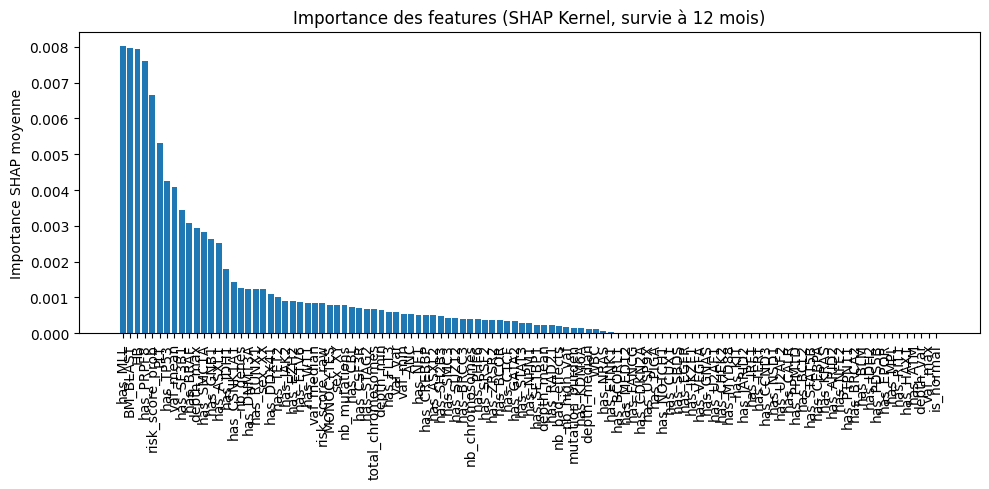

In [133]:
import torch
import shap
import numpy as np
import matplotlib.pyplot as plt

# ⚙️ Paramètres
T_max = 60
n_intervals = 41
t_target = 12

time_grid = np.linspace(0, T_max, n_intervals)
time_idx = np.argmin(np.abs(time_grid - t_target))

print(f"Temps cible {t_target} → intervalle index {time_idx} (≈ {time_grid[time_idx]:.1f})")

background_np = X_features.iloc[:100].values
test_sample_np = X_features.iloc[100:120].values
features = np.array(X_features.columns)

model.eval()

# Fonction prédictive pour SHAP : proba de survie à t_target
def predict_fn(x_numpy):
    x_torch = torch.tensor(x_numpy, dtype=torch.float32)
    with torch.no_grad():
        logits = model(x_torch)  # (batch_size, n_intervals)
        surv = mtlr_survival(logits)  # (batch_size, n_intervals), valeurs entre 0 et 1
        y_target = surv[:, time_idx].numpy()  # proba de survie à t_target
    return y_target

explainer = shap.KernelExplainer(predict_fn, background_np)

# Valeurs SHAP
shap_values = explainer.shap_values(test_sample_np, nsamples=100)

feature_importance = np.mean(np.abs(shap_values), axis=0)
sorted_idx = np.argsort(feature_importance)[::-1]

plt.figure(figsize=(10, 5))
plt.bar(features[sorted_idx], feature_importance[sorted_idx])
plt.xticks(rotation=90)
plt.title(f"Importance des features (SHAP Kernel, survie à {t_target} mois)")
plt.ylabel("Importance SHAP moyenne")
plt.tight_layout()
plt.show()

In [134]:
import pandas as pd

# Création du tableau d'importance trié
df_importance = pd.DataFrame({
    "feature": features[sorted_idx],
    "importance": feature_importance[sorted_idx]
}).reset_index(drop=True)

# Affichage markdown pour LLM
print("\nTableau markdown pour LLM :\n")
print(df_importance.to_markdown(index=False))


Tableau markdown pour LLM :

| feature           |   importance |
|:------------------|-------------:|
| has_MLL           |  0.00801947  |
| BM_BLAST          |  0.00795664  |
| HB                |  0.00793871  |
| has_PRPF8         |  0.00760167  |
| risk_score_prob   |  0.00666329  |
| PLT               |  0.00530322  |
| has_TP53          |  0.00424066  |
| vaf_mean          |  0.00409722  |
| has_SF3B1         |  0.00343599  |
| has_BRAF          |  0.003066    |
| depth_max         |  0.00294629  |
| has_SMC1A         |  0.00282717  |
| has_GNB1          |  0.00263507  |
| has_ASXL1         |  0.00250652  |
| has_IDH1          |  0.0018046   |
| has_CSNK1A1       |  0.00143445  |
| nb_genes          |  0.00127401  |
| has_DNMT3A        |  0.00123992  |
| has_RUNX1         |  0.00122443  |
| sex_XX            |  0.00122156  |
| has_DDX41         |  0.00108139  |
| has_TET2          |  0.00101044  |
| has_JAK2          |  0.000910791 |
| has_EZH2          |  0.000896509 |
| has_ET